In [2]:
import warnings
import os
import sys
# try to import peal and if not installed, add the parent directory to the path
try:
    import peal

except ImportError:
    # if peal not installed, but project downloaded locally
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

# import basic libraries needed for sure and set the device depending on whether cuda is available or not
import torch
from peal.global_utils import request
device = 'cuda' if torch.cuda.is_available() else 'cpu'

warnings.filterwarnings('ignore')

# set autoreload for more convinient development
%load_ext autoreload
%autoreload 2

# check and set that the right gpu is used
if device == 'cuda':
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    !nvidia-smi
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print('Currently used device: ' + str(os.environ["CUDA_VISIBLE_DEVICES"]))
    os.environ["CUDA_VISIBLE_DEVICES"] = request(
        'cuda_visible_devices', default="0")
    torch.cuda.set_device(int(os.environ["CUDA_VISIBLE_DEVICES"]))
    import math
    import nvidia_smi
    nvidia_smi.nvmlInit()
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    gigabyte_vram = info.total / math.pow(10, 9)
    print("Total memory:", gigabyte_vram)

else:
    gigabyte_vram = None

    
is_asking = request('asking', default = True)#
unrestricted_unpoisened = request('unrestricted_unpoisened', default = False, is_asking=is_asking)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Do you want to change value of asking==True? [y/n]n
Do you want to change value of unrestricted_unpoisened==False? [y/n]n


In [3]:
from peal.data.datasets import SymbolicDataset
from torchvision import transforms
from torchvision.transforms import ToTensor
from peal.data.transformations import (
    IdentityNormalization,
)

class CircleDataset(SymbolicDataset):
    def __init__(
        self,
        data_dir,
        mode,
        config,
        transform,
        task_config=None,
        **kwargs,
    ):
        
        super().__init__(data_dir, mode, config, transform, task_config, **kwargs)
        
        self.config = config
        self.true_data = torch.zeros([config.num_samples, config.input_size[0]])
        for i in range(config.num_samples):
            self.true_data[i,:] = self.data[str(i)][:2]

    @staticmethod
    def circle_fid(samples, radius=1):
        return (((samples.pow(2)).sum(dim=1) - radius).pow(2)).mean()
    
    @staticmethod
    def angle_cdf(samples):
        scores = abs(samples[:,1] / samples[:,0])

        first_quad_mask = (samples[:,0]>0) & (samples[:,1]>0)
        second_quad_mask = (samples[:,0]<0) & (samples[:,1]>0)
        third_quad_mask = (samples[:,0]<0) & (samples[:,1]<0)
        fourth_quad_mask = (samples[:,0]>0) & (samples[:,1]<0)
        theta_1 = torch.atan(scores)*first_quad_mask
        theta_1 = theta_1[theta_1 != 0]
        theta_2 = (torch.pi - torch.atan(scores))*second_quad_mask
        theta_2 = theta_2[theta_2 != 0]
        theta_3 = (torch.pi + torch.atan(scores))*third_quad_mask
        theta_3 = theta_3[theta_3 != 0]
        theta_4 = (2*torch.pi - torch.atan(scores))*fourth_quad_mask
        theta_4 = theta_4[theta_4 != 0]
        thetas, indices = torch.cat([theta_1, theta_2, theta_3, theta_4]).sort(dim=-1)
        
        return thetas
    
    #@staticmethod
    def circle_ks(self, samples, true_data):
        true_thetas = CircleDataset.angle_cdf(true_data)
        sample_thetas = CircleDataset.angle_cdf(samples)

        ecdf = torch.arange(self.config.num_samples)/self.config.num_samples
        true_cdf = (sample_thetas[:,None] >= true_thetas[None,:]).sum(-1)/len(true_data)
        return torch.max(torch.abs((true_cdf-ecdf)))
    
    
    def track_generator_performance(self, generator, batch_size=1):
        
        samples = generator.sample_x(batch_size).detach()
        
        ks = self.circle_ks(samples, self.true_data)
        fid = CircleDataset.circle_fid(samples)
        
        harmonic_mean = 1/(1/fid + 1/ks)
        
        
        
        return {
            'KS': ks,
            'FID': fid,
            'harmonic_mean_fid_ks': harmonic_mean
        
        }
    
    
def get_datasets(config, base_dir, task_config=None, return_dict=False):
    
    config = load_yaml_config(config)
    
    dataset = CircleDataset
    
    transform_list_train = []
    transform_list_test = []
    
    transform_list_train.append(ToTensor())
    transform_list_test.append(ToTensor())

    transform_train = transforms.Compose(transform_list_train)
    transform_test = transforms.Compose(transform_list_test)
    normalization = IdentityNormalization()
    
    transform_train = transforms.Compose([transform_train, normalization])
    transform_test = transforms.Compose([transform_test, normalization])

    train_data = dataset(
        base_dir, "train", config, transform_train, return_dict=return_dict
    )
    val_data = dataset(
        base_dir, "val", config, transform_train, return_dict=return_dict
    )
    test_data = dataset(
        base_dir, "test", config, transform_test, return_dict=return_dict
    )
    
    train_data.normalization = normalization
    val_data.normalization = normalization
    test_data.normalization = normalization

    train_data.task_config = task_config
    val_data.task_config = task_config
    test_data.task_config = task_config

    return train_data, val_data, test_data

pygame 2.1.2 (SDL 2.0.16, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
# create the datasets
#from peal.data.dataset_factory import get_datasets
from peal.data.dataset_generators import CircleDatasetGenerator
from peal.global_utils import load_yaml_config
import copy

unpoisened_dataset_config = load_yaml_config('<PEAL_BASE>/configs/data/symbolic_circle.yaml')
unpoisened_dataset_config = load_yaml_config('<PEAL_BASE>/configs/data/circle_dataset_diffusion_unpoisened.yaml')
dg = CircleDatasetGenerator(
    dataset_name='circle',
    num_samples=unpoisened_dataset_config.num_samples,
    radius=unpoisened_dataset_config.radius,
    noise_scale=unpoisened_dataset_config.noise_scale,
    seed=unpoisened_dataset_config.seed,
)

dg.generate_dataset()

#unpoisened_dataset_config = load_yaml_config('<PEAL_BASE>/configs/data/circle_dataset_diffusion_unpoisened.yaml')
student_config = load_yaml_config('<PEAL_BASE>/configs/models/symbolic_circle_classifier.yaml')
#if len(student_config['task']['x_selection']):
#    unpoisened_dataset_config['input_size'] = [len(student_config['task']['x_selection'])]
    
unpoisened_dataset_train, unpoisened_dataset_val, unpoisened_dataset_test = get_datasets(
    config=unpoisened_dataset_config,
    base_dir=dg.label_dir,
    task_config=student_config.task,
)

# create a copy of the dataset config that will be poisened in the next steps
poisened_dataset_config = copy.deepcopy(unpoisened_dataset_config)
poisened_dataset_config.num_samples = int(unpoisened_dataset_config.num_samples / 2)

confounder_probability = request('confounder_probability', '100')
poisened_dataset_config.confounder_probability = float(confounder_probability) / 100

# create dataset based changed data config
poisened_dataset_train, poisened_dataset_val, poisened_dataset_test = get_datasets(
    config=poisened_dataset_config,
    base_dir=dg.label_dir,
    task_config=student_config.task,
)

In [ ]:
is_train_generator = request('is_train_generator', False)
if is_train_generator:
    # if you want the generator getting trained from scratch
    from peal.generators.variational_autoencoders import VAE
    from peal.training.trainers import ModelTrainer
    from peal.data.dataset_wrappers import VAEDatasetWrapper
    generator_config = load_yaml_config('$PEAL/configs/models/symbolic_circle_vae.yaml')
    generator_config['data'] = unpoisened_dataset_train.config
    generator_config['training']['max_epochs'] = 50
    generator = VAE(generator_config).to(device)

    dataset_train = VAEDatasetWrapper(unpoisened_dataset_train)
    dataset_val = VAEDatasetWrapper(unpoisened_dataset_val)

    generator_trainer = ModelTrainer(
        config=generator_config,
        model=generator,
        datasource=(dataset_train, dataset_val),
        model_name=request(
            'generator_model_name',
            'artificial_symbolic_' + confounder_probability + '_generator'
        ),
        gigabyte_vram=gigabyte_vram
    )
    generator_trainer.fit()

else:
    # if you want to use loaded generator
    generator_path = request(
        'generator_path',
        'peal_runs/artificial_symbolic_' + confounder_probability + '_generator/model.cpl'
    )
    generator = torch.load(generator_path).to(device)


In [9]:
is_train_student = request('is_train_student', True)
if is_train_student:
    # if you want to train your own initial student model
    from peal.architectures.downstream_models import SequentialModel
    from peal.configs.models.model_template import ModelConfig
    from peal.training.trainers import ModelTrainer
    student_config = load_yaml_config('<PEAL_BASE>/configs/models/symbolic_circle_classifier.yaml', ModelConfig)
    student_config.data = poisened_dataset_train.config
    student_config.training.max_epochs = 5

    input_channels=len(student_config.task.x_selection) if not student_config.task.x_selection is None else student_config.data.input_size[0]
    output_channels=student_config.task.output_channels if not student_config.task.output_channels is None else student_config.data.output_size[0]
    # create and traing student model
    student = SequentialModel(student_config.architecture, input_channels, output_channels).to(device)
    student_trainer = ModelTrainer(
        config=student_config,
        model=student,
        datasource=(poisened_dataset_train, poisened_dataset_val),
        model_name=request(
            'student_model_name',
            'artificial_symbolic_' + confounder_probability + '_classifier'
        ),
        gigabyte_vram=gigabyte_vram
    )
    student_trainer.fit()
else:
    # if you want to load your initial student model
    student_path = request(
        'student_path',
        'peal_runs/artificial_symbolic_' + confounder_probability + '_classifier/model.cpl'
    )
    student = torch.load(student_path).to(device)


Do you want to change value of is_train_student==True? [y/n]n
Do you want to change value of student_model_name==artificial_symbolic_100_classifier? [y/n]n
Training Config: <peal.configs.models.model_template.ModelConfig object at 0x7fd3aee0d610>



  0%|                                                                                          | 0/1005 [00:00<?, ?it/s]
Model Training: train_it: 0, loss: 0.7116844654083252:   0%|                                   | 0/1005 [00:00<?, ?it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:29<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 1, loss: 0.6952877044677734:   0%|                           | 1/1005 [00:00<01:43,  9.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:29<02:01, 19.69it/s]
Model Training: train_it: 1, loss: 0.6952877044677734:   0%|                           | 2/1005 [00:00<00:57, 17.53it/s]
Model Training: train_it: 2, loss: 0.6660679578781128:   0%|                           | 2/1005 [00:00<00:57, 17.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:29<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 3, loss: 0.6519432663917542:   0%|                           | 3/1005 [00:00<00:57, 17.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:29<02:01, 19.69it/s]
Model Training: train_it: 3, loss: 0.6519432663917542:   0%|                           | 4/1005 [00:00<01:02, 16.07it/s]
Model Training: train_it: 4, loss: 0.6343527436256409:   0%|                           | 4/1005 [00:00<01:02, 16.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:29<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 5, loss: 0.5956071615219116:   0%|▏                          | 5/1005 [00:00<01:02, 16.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:29<02:01, 19.69it/s]
Model Training: train_it: 5, loss: 0.5956071615219116:   1%|▏                          | 6/1005 [00:00<01:04, 15.45it/s]
Model Training: train_it: 6, loss: 0.5766419172286987:   1%|▏                          | 6/1005 [00:00<01:04, 15.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:29<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 7, loss: 0.5485591292381287:   1%|▏                          | 7/1005 [00:00<01:04, 15.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:29<02:01, 19.69it/s]
Model Training: train_it: 7, loss: 0.5485591292381287:   1%|▏                          | 8/1005 [00:00<01:00, 16.41it/s]
Model Training: train_it: 8, loss: 0.5287622213363647:   1%|▏                          | 8/1005 [00:00<01:00, 16.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:29<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 9, loss: 0.5153137445449829:   1%|▏                          | 9/1005 [00:00<01:00, 16.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:29<02:01, 19.69it/s]
Model Training: train_it: 9, loss: 0.5153137445449829:   1%|▎                         | 10/1005 [00:00<00:57, 17.24it/s]
Model Training: train_it: 10, loss: 0.48701125383377075:   1%|▏                       | 10/1005 [00:00<00:57, 17.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 11, loss: 0.4705134630203247:   1%|▎                        | 11/1005 [00:00<00:57, 17.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]
Model Training: train_it: 11, loss: 0.4705134630203247:   1%|▎                        | 12/1005 [00:00<00:57, 17.41it/s]
Model Training: train_it: 12, loss: 0.4520174264907837:   1%|▎                        | 12/1005 [00:00<00:57, 17.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 13, loss: 0.42174527049064636:   1%|▎                       | 13/1005 [00:00<00:56, 17.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]
Model Training: train_it: 13, loss: 0.42174527049064636:   1%|▎                       | 14/1005 [00:00<00:58, 16.97it/s]
Model Training: train_it: 14, loss: 0.4066105782985687:   1%|▎                        | 14/1005 [00:00<00:58, 16.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 15, loss: 0.38076648116111755:   1%|▎                       | 15/1005 [00:00<00:58, 16.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]
Model Training: train_it: 15, loss: 0.38076648116111755:   2%|▍                       | 16/1005 [00:00<00:58, 16.87it/s]
Model Training: train_it: 16, loss: 0.36170944571495056:   2%|▍                       | 16/1005 [00:00<00:58, 16.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 17, loss: 0.36460503935813904:   2%|▍                       | 17/1005 [00:01<00:58, 16.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]
Model Training: train_it: 17, loss: 0.36460503935813904:   2%|▍                       | 18/1005 [00:01<00:58, 16.93it/s]
Model Training: train_it: 18, loss: 0.33875614404678345:   2%|▍                       | 18/1005 [00:01<00:58, 16.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 19, loss: 0.3224988877773285:   2%|▍                        | 19/1005 [00:01<00:58, 16.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]
Model Training: train_it: 19, loss: 0.3224988877773285:   2%|▍                        | 20/1005 [00:01<00:58, 16.93it/s]
Model Training: train_it: 20, loss: 0.3130016624927521:   2%|▍                        | 20/1005 [00:01<00:58, 16.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 21, loss: 0.29428017139434814:   2%|▌                       | 21/1005 [00:01<00:58, 16.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]
Model Training: train_it: 21, loss: 0.29428017139434814:   2%|▌                       | 22/1005 [00:01<00:59, 16.41it/s]
Model Training: train_it: 22, loss: 0.2693658173084259:   2%|▌                        | 22/1005 [00:01<00:59, 16.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 23, loss: 0.2734090983867645:   2%|▌                        | 23/1005 [00:01<00:59, 16.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]
Model Training: train_it: 23, loss: 0.2734090983867645:   2%|▌                        | 24/1005 [00:01<00:58, 16.74it/s]
Model Training: train_it: 24, loss: 0.2556699812412262:   2%|▌                        | 24/1005 [00:01<00:58, 16.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 25, loss: 0.24658040702342987:   2%|▌                       | 25/1005 [00:01<00:58, 16.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]
Model Training: train_it: 25, loss: 0.24658040702342987:   3%|▌                       | 26/1005 [00:01<00:59, 16.58it/s]
Model Training: train_it: 26, loss: 0.22419019043445587:   3%|▌                       | 26/1005 [00:01<00:59, 16.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:30<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 27, loss: 0.21389901638031006:   3%|▋                       | 27/1005 [00:01<00:58, 16.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]
Model Training: train_it: 27, loss: 0.21389901638031006:   3%|▋                       | 28/1005 [00:01<00:58, 16.77it/s]
Model Training: train_it: 28, loss: 0.20383022725582123:   3%|▋                       | 28/1005 [00:01<00:58, 16.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 29, loss: 0.18416941165924072:   3%|▋                       | 29/1005 [00:01<00:58, 16.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]
Model Training: train_it: 29, loss: 0.18416941165924072:   3%|▋                       | 30/1005 [00:01<01:00, 16.04it/s]
Model Training: train_it: 30, loss: 0.1851169466972351:   3%|▋                        | 30/1005 [00:01<01:00, 16.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 31, loss: 0.17425937950611115:   3%|▋                       | 31/1005 [00:01<01:00, 16.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]
Model Training: train_it: 31, loss: 0.17425937950611115:   3%|▊                       | 32/1005 [00:01<00:59, 16.39it/s]
Model Training: train_it: 32, loss: 0.16749829053878784:   3%|▊                       | 32/1005 [00:01<00:59, 16.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 33, loss: 0.15369337797164917:   3%|▊                       | 33/1005 [00:02<00:59, 16.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]
Model Training: train_it: 33, loss: 0.15369337797164917:   3%|▊                       | 34/1005 [00:02<00:57, 17.02it/s]
Model Training: train_it: 34, loss: 0.14896677434444427:   3%|▊                       | 34/1005 [00:02<00:57, 17.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 35, loss: 0.14548081159591675:   3%|▊                       | 35/1005 [00:02<00:56, 17.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]
Model Training: train_it: 35, loss: 0.14548081159591675:   4%|▊                       | 36/1005 [00:02<00:55, 17.47it/s]
Model Training: train_it: 36, loss: 0.13875997066497803:   4%|▊                       | 36/1005 [00:02<00:55, 17.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 37, loss: 0.12876424193382263:   4%|▉                       | 37/1005 [00:02<00:55, 17.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]
Model Training: train_it: 37, loss: 0.12876424193382263:   4%|▉                       | 38/1005 [00:02<00:56, 17.14it/s]
Model Training: train_it: 38, loss: 0.12496787309646606:   4%|▉                       | 38/1005 [00:02<00:56, 17.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 39, loss: 0.11776383221149445:   4%|▉                       | 39/1005 [00:02<00:56, 17.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]
Model Training: train_it: 39, loss: 0.11776383221149445:   4%|▉                       | 40/1005 [00:02<01:03, 15.21it/s]
Model Training: train_it: 40, loss: 0.10646211355924606:   4%|▉                       | 40/1005 [00:02<01:03, 15.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 41, loss: 0.10691192001104355:   4%|▉                       | 41/1005 [00:02<01:03, 15.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]
Model Training: train_it: 41, loss: 0.10691192001104355:   4%|█                       | 42/1005 [00:02<01:04, 14.83it/s]
Model Training: train_it: 42, loss: 0.1082342118024826:   4%|█                        | 42/1005 [00:02<01:04, 14.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:31<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 43, loss: 0.0968489944934845:   4%|█                        | 43/1005 [00:02<01:04, 14.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]
Model Training: train_it: 43, loss: 0.0968489944934845:   4%|█                        | 44/1005 [00:02<01:02, 15.45it/s]
Model Training: train_it: 44, loss: 0.09259715676307678:   4%|█                       | 44/1005 [00:02<01:02, 15.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 45, loss: 0.08600466698408127:   4%|█                       | 45/1005 [00:02<01:02, 15.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]
Model Training: train_it: 45, loss: 0.08600466698408127:   5%|█                       | 46/1005 [00:02<01:01, 15.62it/s]
Model Training: train_it: 46, loss: 0.08565806597471237:   5%|█                       | 46/1005 [00:02<01:01, 15.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 47, loss: 0.0791153535246849:   5%|█▏                       | 47/1005 [00:02<01:01, 15.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]
Model Training: train_it: 47, loss: 0.0791153535246849:   5%|█▏                       | 48/1005 [00:02<01:03, 15.14it/s]
Model Training: train_it: 48, loss: 0.07778296619653702:   5%|█▏                      | 48/1005 [00:02<01:03, 15.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 49, loss: 0.07127150893211365:   5%|█▏                      | 49/1005 [00:03<01:03, 15.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]
Model Training: train_it: 49, loss: 0.07127150893211365:   5%|█▏                      | 50/1005 [00:03<01:02, 15.28it/s]
Model Training: train_it: 50, loss: 0.07285235077142715:   5%|█▏                      | 50/1005 [00:03<01:02, 15.28it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 51, loss: 0.06553856283426285:   5%|█▏                      | 51/1005 [00:03<01:02, 15.28it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]
Model Training: train_it: 51, loss: 0.06553856283426285:   5%|█▏                      | 52/1005 [00:03<01:00, 15.67it/s]
Model Training: train_it: 52, loss: 0.06790485978126526:   5%|█▏                      | 52/1005 [00:03<01:00, 15.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 53, loss: 0.06148288771510124:   5%|█▎                      | 53/1005 [00:03<01:00, 15.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]
Model Training: train_it: 53, loss: 0.06148288771510124:   5%|█▎                      | 54/1005 [00:03<00:59, 16.04it/s]
Model Training: train_it: 54, loss: 0.059698257595300674:   5%|█▏                     | 54/1005 [00:03<00:59, 16.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 55, loss: 0.054444119334220886:   5%|█▎                     | 55/1005 [00:03<00:59, 16.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]
Model Training: train_it: 55, loss: 0.054444119334220886:   6%|█▎                     | 56/1005 [00:03<01:01, 15.31it/s]
Model Training: train_it: 56, loss: 0.05177071690559387:   6%|█▎                      | 56/1005 [00:03<01:01, 15.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 57, loss: 0.052179500460624695:   6%|█▎                     | 57/1005 [00:03<01:01, 15.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:32<02:01, 19.69it/s]
Model Training: train_it: 57, loss: 0.052179500460624695:   6%|█▎                     | 58/1005 [00:03<00:59, 15.78it/s]
Model Training: train_it: 58, loss: 0.045705925673246384:   6%|█▎                     | 58/1005 [00:03<00:59, 15.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 59, loss: 0.04673993960022926:   6%|█▍                      | 59/1005 [00:03<00:59, 15.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]
Model Training: train_it: 59, loss: 0.04673993960022926:   6%|█▍                      | 60/1005 [00:03<01:03, 14.81it/s]
Model Training: train_it: 60, loss: 0.04867952689528465:   6%|█▍                      | 60/1005 [00:03<01:03, 14.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 61, loss: 0.04113117605447769:   6%|█▍                      | 61/1005 [00:03<01:03, 14.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]
Model Training: train_it: 61, loss: 0.04113117605447769:   6%|█▍                      | 62/1005 [00:03<00:59, 15.77it/s]
Model Training: train_it: 62, loss: 0.04237384721636772:   6%|█▍                      | 62/1005 [00:03<00:59, 15.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 63, loss: 0.0402374267578125:   6%|█▌                       | 63/1005 [00:03<00:59, 15.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]
Model Training: train_it: 63, loss: 0.0402374267578125:   6%|█▌                       | 64/1005 [00:03<00:57, 16.40it/s]
Model Training: train_it: 64, loss: 0.03742307424545288:   6%|█▌                      | 64/1005 [00:03<00:57, 16.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 65, loss: 0.040045857429504395:   6%|█▍                     | 65/1005 [00:04<00:57, 16.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]
Model Training: train_it: 65, loss: 0.040045857429504395:   7%|█▌                     | 66/1005 [00:04<00:54, 17.08it/s]
Model Training: train_it: 66, loss: 0.03699250519275665:   7%|█▌                      | 66/1005 [00:04<00:54, 17.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 67, loss: 0.03539666160941124:   7%|█▌                      | 67/1005 [00:04<00:54, 17.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]
Model Training: train_it: 67, loss: 0.03539666160941124:   7%|█▌                      | 68/1005 [00:04<00:52, 17.71it/s]
Model Training: train_it: 68, loss: 0.03429209813475609:   7%|█▌                      | 68/1005 [00:04<00:52, 17.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 69, loss: 0.03308654576539993:   7%|█▋                      | 69/1005 [00:04<00:52, 17.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]
Model Training: train_it: 69, loss: 0.03308654576539993:   7%|█▋                      | 70/1005 [00:04<00:53, 17.42it/s]
Model Training: train_it: 70, loss: 0.03193887695670128:   7%|█▋                      | 70/1005 [00:04<00:53, 17.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 71, loss: 0.03248313069343567:   7%|█▋                      | 71/1005 [00:04<00:53, 17.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]
Model Training: train_it: 71, loss: 0.03248313069343567:   7%|█▋                      | 72/1005 [00:04<00:52, 17.71it/s]
Model Training: train_it: 72, loss: 0.03114374354481697:   7%|█▋                      | 72/1005 [00:04<00:52, 17.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 73, loss: 0.030535925179719925:   7%|█▋                     | 73/1005 [00:04<00:52, 17.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]
Model Training: train_it: 73, loss: 0.030535925179719925:   7%|█▋                     | 74/1005 [00:04<00:51, 17.92it/s]
Model Training: train_it: 74, loss: 0.024811487644910812:   7%|█▋                     | 74/1005 [00:04<00:51, 17.92it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:33<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 75, loss: 0.02508879266679287:   7%|█▊                      | 75/1005 [00:04<00:51, 17.92it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]
Model Training: train_it: 75, loss: 0.02508879266679287:   8%|█▊                      | 76/1005 [00:04<00:52, 17.69it/s]
Model Training: train_it: 76, loss: 0.026472583413124084:   8%|█▋                     | 76/1005 [00:04<00:52, 17.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 77, loss: 0.02513199858367443:   8%|█▊                      | 77/1005 [00:04<00:52, 17.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]
Model Training: train_it: 77, loss: 0.02513199858367443:   8%|█▊                      | 78/1005 [00:04<00:53, 17.48it/s]
Model Training: train_it: 78, loss: 0.025011036545038223:   8%|█▊                     | 78/1005 [00:04<00:53, 17.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 79, loss: 0.02576575241982937:   8%|█▉                      | 79/1005 [00:04<00:52, 17.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]
Model Training: train_it: 79, loss: 0.02576575241982937:   8%|█▉                      | 80/1005 [00:04<00:53, 17.16it/s]
Model Training: train_it: 80, loss: 0.023831281810998917:   8%|█▊                     | 80/1005 [00:04<00:53, 17.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 81, loss: 0.02474496327340603:   8%|█▉                      | 81/1005 [00:04<00:53, 17.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]
Model Training: train_it: 81, loss: 0.02474496327340603:   8%|█▉                      | 82/1005 [00:04<00:54, 16.81it/s]
Model Training: train_it: 82, loss: 0.02317075803875923:   8%|█▉                      | 82/1005 [00:05<00:54, 16.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 83, loss: 0.020090190693736076:   8%|█▉                     | 83/1005 [00:05<00:54, 16.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]
Model Training: train_it: 83, loss: 0.020090190693736076:   8%|█▉                     | 84/1005 [00:05<00:57, 15.96it/s]
Model Training: train_it: 84, loss: 0.02145160362124443:   8%|██                      | 84/1005 [00:05<00:57, 15.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 85, loss: 0.02040458843111992:   8%|██                      | 85/1005 [00:05<00:57, 15.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]
Model Training: train_it: 85, loss: 0.02040458843111992:   9%|██                      | 86/1005 [00:05<00:54, 16.74it/s]
Model Training: train_it: 86, loss: 0.021195655688643456:   9%|█▉                     | 86/1005 [00:05<00:54, 16.74it/s]
                                                                                                                        


Epoch: 0
Epoch: 0


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]
Model Training: train_it: 87, loss: 0.019376078620553017:   9%|█▉                     | 87/1005 [00:05<00:54, 16.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]
Model Training: train_it: 87, loss: 0.019376078620553017:   9%|██                     | 88/1005 [00:05<01:08, 13.36it/s]
Model Training: train_it: 88, loss: 0.017534032464027405:   9%|██                     | 88/1005 [00:05<01:08, 13.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 89, loss: 0.019188735634088516:   9%|██                     | 89/1005 [00:05<01:08, 13.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:34<02:01, 19.69it/s]
Model Training: train_it: 89, loss: 0.019188735634088516:   9%|██                     | 90/1005 [00:05<01:09, 13.08it/s]
Model Training: train_it: 90, loss: 0.017857646569609642:   9%|██                     | 90/1005 [00:05<01:09, 13.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 91, loss: 0.017853612080216408:   9%|██                     | 91/1005 [00:05<01:09, 13.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]
Model Training: train_it: 91, loss: 0.017853612080216408:   9%|██                     | 92/1005 [00:05<01:03, 14.32it/s]
Model Training: train_it: 92, loss: 0.01681319624185562:   9%|██▏                     | 92/1005 [00:05<01:03, 14.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 93, loss: 0.01740444451570511:   9%|██▏                     | 93/1005 [00:05<01:03, 14.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]
Model Training: train_it: 93, loss: 0.01740444451570511:   9%|██▏                     | 94/1005 [00:05<01:00, 14.96it/s]
Model Training: train_it: 94, loss: 0.015581836923956871:   9%|██▏                    | 94/1005 [00:05<01:00, 14.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 95, loss: 0.015434167347848415:   9%|██▏                    | 95/1005 [00:05<01:00, 14.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]
Model Training: train_it: 95, loss: 0.015434167347848415:  10%|██▏                    | 96/1005 [00:05<01:01, 14.83it/s]
Model Training: train_it: 96, loss: 0.015426634810864925:  10%|██▏                    | 96/1005 [00:05<01:01, 14.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 97, loss: 0.014961511828005314:  10%|██▏                    | 97/1005 [00:06<01:01, 14.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]
Model Training: train_it: 97, loss: 0.014961511828005314:  10%|██▏                    | 98/1005 [00:06<01:00, 14.88it/s]
Model Training: train_it: 98, loss: 0.016054727137088776:  10%|██▏                    | 98/1005 [00:06<01:00, 14.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 99, loss: 0.014683357439935207:  10%|██▎                    | 99/1005 [00:06<01:00, 14.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]
Model Training: train_it: 99, loss: 0.014683357439935207:  10%|██▏                   | 100/1005 [00:06<01:00, 14.89it/s]
Model Training: train_it: 100, loss: 0.01446950901299715:  10%|██▏                   | 100/1005 [00:06<01:00, 14.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 101, loss: 0.014478635974228382:  10%|██                   | 101/1005 [00:06<01:00, 14.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]
Model Training: train_it: 101, loss: 0.014478635974228382:  10%|██▏                  | 102/1005 [00:06<00:56, 15.85it/s]
Model Training: train_it: 102, loss: 0.013561980798840523:  10%|██▏                  | 102/1005 [00:06<00:56, 15.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 103, loss: 0.012594902887940407:  10%|██▏                  | 103/1005 [00:06<00:56, 15.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]
Model Training: train_it: 104, loss: 0.01330302283167839:  10%|██▎                   | 104/1005 [00:06<00:56, 15.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]
Model Training: train_it: 104, loss: 0.01330302283167839:  10%|██▎                   | 105/1005 [00:06<00:49, 18.25it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 105, loss: 0.012739863246679306:  10%|██▏                  | 105/1005 [00:06<00:49, 18.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]
Model Training: train_it: 106, loss: 0.011884678155183792:  11%|██▏                  | 106/1005 [00:06<00:49, 18.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:35<02:01, 19.69it/s]
Model Training: train_it: 106, loss: 0.011884678155183792:  11%|██▏                  | 107/1005 [00:06<00:49, 18.11it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 107, loss: 0.010978665202856064:  11%|██▏                  | 107/1005 [00:06<00:49, 18.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 108, loss: 0.01213300321251154:  11%|██▎                   | 108/1005 [00:06<00:49, 18.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 108, loss: 0.01213300321251154:  11%|██▍                   | 109/1005 [00:06<00:48, 18.40it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 109, loss: 0.012280812487006187:  11%|██▎                  | 109/1005 [00:06<00:48, 18.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 110, loss: 0.01224361639469862:  11%|██▍                   | 110/1005 [00:06<00:48, 18.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 110, loss: 0.01224361639469862:  11%|██▍                   | 111/1005 [00:06<00:47, 18.71it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 111, loss: 0.010714467614889145:  11%|██▎                  | 111/1005 [00:06<00:47, 18.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 112, loss: 0.01187166478484869:  11%|██▍                   | 112/1005 [00:06<00:47, 18.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 112, loss: 0.01187166478484869:  11%|██▍                   | 113/1005 [00:06<00:50, 17.50it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 113, loss: 0.01013480219990015:  11%|██▍                   | 113/1005 [00:07<00:50, 17.50it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 114, loss: 0.011335880495607853:  11%|██▍                  | 114/1005 [00:07<00:50, 17.50it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 114, loss: 0.011335880495607853:  11%|██▍                  | 115/1005 [00:07<00:51, 17.42it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 115, loss: 0.010201852768659592:  11%|██▍                  | 115/1005 [00:07<00:51, 17.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 116, loss: 0.010913543403148651:  12%|██▍                  | 116/1005 [00:07<00:51, 17.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 116, loss: 0.010913543403148651:  12%|██▍                  | 117/1005 [00:07<00:51, 17.26it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 117, loss: 0.009804179891943932:  12%|██▍                  | 117/1005 [00:07<00:51, 17.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 118, loss: 0.010326318442821503:  12%|██▍                  | 118/1005 [00:07<00:51, 17.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 118, loss: 0.010326318442821503:  12%|██▍                  | 119/1005 [00:07<00:49, 17.82it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 119, loss: 0.010002605617046356:  12%|██▍                  | 119/1005 [00:07<00:49, 17.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 120, loss: 0.010252580977976322:  12%|██▌                  | 120/1005 [00:07<00:49, 17.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 120, loss: 0.010252580977976322:  12%|██▌                  | 121/1005 [00:07<00:49, 17.76it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 121, loss: 0.009746167808771133:  12%|██▌                  | 121/1005 [00:07<00:49, 17.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 122, loss: 0.009726861491799355:  12%|██▌                  | 122/1005 [00:07<00:49, 17.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 122, loss: 0.009726861491799355:  12%|██▌                  | 123/1005 [00:07<00:51, 17.12it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 123, loss: 0.009431874379515648:  12%|██▌                  | 123/1005 [00:07<00:51, 17.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 124, loss: 0.008783476427197456:  12%|██▌                  | 124/1005 [00:07<00:51, 17.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:36<02:01, 19.69it/s]
Model Training: train_it: 124, loss: 0.008783476427197456:  12%|██▌                  | 125/1005 [00:07<00:50, 17.58it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 125, loss: 0.008590119890868664:  12%|██▌                  | 125/1005 [00:07<00:50, 17.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 126, loss: 0.00793242733925581:  13%|██▊                   | 126/1005 [00:07<00:49, 17.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 126, loss: 0.00793242733925581:  13%|██▊                   | 127/1005 [00:07<00:49, 17.76it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 127, loss: 0.007488967385143042:  13%|██▋                  | 127/1005 [00:07<00:49, 17.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 128, loss: 0.008341355249285698:  13%|██▋                  | 128/1005 [00:07<00:49, 17.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 128, loss: 0.008341355249285698:  13%|██▋                  | 129/1005 [00:07<00:49, 17.83it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 129, loss: 0.008101013489067554:  13%|██▋                  | 129/1005 [00:07<00:49, 17.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 130, loss: 0.007739350199699402:  13%|██▋                  | 130/1005 [00:07<00:49, 17.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 130, loss: 0.007739350199699402:  13%|██▋                  | 131/1005 [00:07<00:50, 17.20it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 131, loss: 0.007174262311309576:  13%|██▋                  | 131/1005 [00:08<00:50, 17.20it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 132, loss: 0.007938489317893982:  13%|██▊                  | 132/1005 [00:08<00:50, 17.20it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 132, loss: 0.007938489317893982:  13%|██▊                  | 133/1005 [00:08<00:51, 16.90it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 133, loss: 0.008012209087610245:  13%|██▊                  | 133/1005 [00:08<00:51, 16.90it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 134, loss: 0.007797330152243376:  13%|██▊                  | 134/1005 [00:08<00:51, 16.90it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 134, loss: 0.007797330152243376:  13%|██▊                  | 135/1005 [00:08<00:51, 16.98it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 135, loss: 0.006827709265053272:  13%|██▊                  | 135/1005 [00:08<00:51, 16.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 136, loss: 0.007761552929878235:  14%|██▊                  | 136/1005 [00:08<00:51, 16.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 136, loss: 0.007761552929878235:  14%|██▊                  | 137/1005 [00:08<00:50, 17.18it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 137, loss: 0.007279407232999802:  14%|██▊                  | 137/1005 [00:08<00:50, 17.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 138, loss: 0.007698290515691042:  14%|██▉                  | 138/1005 [00:08<00:50, 17.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 138, loss: 0.007698290515691042:  14%|██▉                  | 139/1005 [00:08<00:52, 16.64it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 139, loss: 0.00725618377327919:  14%|███                   | 139/1005 [00:08<00:52, 16.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 140, loss: 0.007177778519690037:  14%|██▉                  | 140/1005 [00:08<00:51, 16.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:37<02:01, 19.69it/s]
Model Training: train_it: 140, loss: 0.007177778519690037:  14%|██▉                  | 141/1005 [00:08<00:51, 16.83it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 141, loss: 0.007941698655486107:  14%|██▉                  | 141/1005 [00:08<00:51, 16.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 142, loss: 0.006772131193429232:  14%|██▉                  | 142/1005 [00:08<00:51, 16.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 142, loss: 0.006772131193429232:  14%|██▉                  | 143/1005 [00:08<00:50, 17.02it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 143, loss: 0.006089755333960056:  14%|██▉                  | 143/1005 [00:08<00:50, 17.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 144, loss: 0.007113895379006863:  14%|███                  | 144/1005 [00:08<00:50, 17.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 144, loss: 0.007113895379006863:  14%|███                  | 145/1005 [00:08<00:49, 17.41it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 145, loss: 0.0056485808454453945:  14%|██▉                 | 145/1005 [00:08<00:49, 17.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 146, loss: 0.0059853424318134785:  15%|██▉                 | 146/1005 [00:08<00:49, 17.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 146, loss: 0.0059853424318134785:  15%|██▉                 | 147/1005 [00:08<00:48, 17.83it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 147, loss: 0.006169596221297979:  15%|███                  | 147/1005 [00:08<00:48, 17.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 148, loss: 0.005705698858946562:  15%|███                  | 148/1005 [00:09<00:48, 17.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 148, loss: 0.005705698858946562:  15%|███                  | 149/1005 [00:09<00:51, 16.78it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 149, loss: 0.006133824121206999:  15%|███                  | 149/1005 [00:09<00:51, 16.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 150, loss: 0.00629590917378664:  15%|███▎                  | 150/1005 [00:09<00:50, 16.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 150, loss: 0.00629590917378664:  15%|███▎                  | 151/1005 [00:09<00:49, 17.27it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 151, loss: 0.005791586823761463:  15%|███▏                 | 151/1005 [00:09<00:49, 17.27it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 152, loss: 0.005564866121858358:  15%|███▏                 | 152/1005 [00:09<00:49, 17.27it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 152, loss: 0.005564866121858358:  15%|███▏                 | 153/1005 [00:09<00:50, 16.89it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 153, loss: 0.006069913972169161:  15%|███▏                 | 153/1005 [00:09<00:50, 16.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 154, loss: 0.005813095718622208:  15%|███▏                 | 154/1005 [00:09<00:50, 16.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 155, loss: 0.005221937317401171:  15%|███▏                 | 155/1005 [00:09<00:50, 16.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]


Epoch: 0


Model Training: train_it: 155, loss: 0.005221937317401171:  16%|███▎                 | 156/1005 [00:09<00:49, 17.09it/s]
Model Training: train_it: 156, loss: 0.005027914419770241:  16%|███▎                 | 156/1005 [00:09<00:49, 17.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 157, loss: 0.005347231402993202:  16%|███▎                 | 157/1005 [00:09<00:49, 17.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]
Model Training: train_it: 157, loss: 0.005347231402993202:  16%|███▎                 | 158/1005 [00:09<00:48, 17.48it/s]
Model Training: train_it: 158, loss: 0.0050220792181789875:  16%|███▏                | 158/1005 [00:09<00:48, 17.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:38<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 159, loss: 0.005291930865496397:  16%|███▎                 | 159/1005 [00:09<00:48, 17.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]
Model Training: train_it: 159, loss: 0.005291930865496397:  16%|███▎                 | 160/1005 [00:09<00:50, 16.70it/s]
Model Training: train_it: 160, loss: 0.004910402465611696:  16%|███▎                 | 160/1005 [00:09<00:50, 16.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 161, loss: 0.0050446526147425175:  16%|███▏                | 161/1005 [00:09<00:50, 16.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]
Model Training: train_it: 161, loss: 0.0050446526147425175:  16%|███▏                | 162/1005 [00:09<00:48, 17.40it/s]
Model Training: train_it: 162, loss: 0.005248600617051125:  16%|███▍                 | 162/1005 [00:09<00:48, 17.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 163, loss: 0.004764625336974859:  16%|███▍                 | 163/1005 [00:09<00:48, 17.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]
Model Training: train_it: 163, loss: 0.004764625336974859:  16%|███▍                 | 164/1005 [00:09<00:50, 16.64it/s]
Model Training: train_it: 164, loss: 0.00515770772472024:  16%|███▌                  | 164/1005 [00:09<00:50, 16.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 165, loss: 0.005017868708819151:  16%|███▍                 | 165/1005 [00:09<00:50, 16.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]
Model Training: train_it: 165, loss: 0.005017868708819151:  17%|███▍                 | 166/1005 [00:10<00:48, 17.37it/s]
Model Training: train_it: 166, loss: 0.004896157421171665:  17%|███▍                 | 166/1005 [00:10<00:48, 17.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 167, loss: 0.004776155576109886:  17%|███▍                 | 167/1005 [00:10<00:48, 17.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]
Model Training: train_it: 167, loss: 0.004776155576109886:  17%|███▌                 | 168/1005 [00:10<00:50, 16.53it/s]
Model Training: train_it: 168, loss: 0.004894263111054897:  17%|███▌                 | 168/1005 [00:10<00:50, 16.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 169, loss: 0.004889342002570629:  17%|███▌                 | 169/1005 [00:10<00:50, 16.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]
Model Training: train_it: 169, loss: 0.004889342002570629:  17%|███▌                 | 170/1005 [00:10<00:48, 17.29it/s]
Model Training: train_it: 170, loss: 0.004693928174674511:  17%|███▌                 | 170/1005 [00:10<00:48, 17.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 171, loss: 0.004647689405828714:  17%|███▌                 | 171/1005 [00:10<00:48, 17.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]
Model Training: train_it: 171, loss: 0.004647689405828714:  17%|███▌                 | 172/1005 [00:10<00:47, 17.61it/s]
Model Training: train_it: 172, loss: 0.00447280565276742:  17%|███▊                  | 172/1005 [00:10<00:47, 17.61it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 173, loss: 0.004333768971264362:  17%|███▌                 | 173/1005 [00:10<00:47, 17.61it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]
Model Training: train_it: 174, loss: 0.004500796552747488:  17%|███▋                 | 174/1005 [00:10<00:47, 17.61it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]
Model Training: train_it: 174, loss: 0.004500796552747488:  17%|███▋                 | 175/1005 [00:10<00:42, 19.71it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 175, loss: 0.0047656516544520855:  17%|███▍                | 175/1005 [00:10<00:42, 19.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]
Model Training: train_it: 176, loss: 0.00517935398966074:  18%|███▊                  | 176/1005 [00:10<00:42, 19.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:39<02:01, 19.69it/s]
Model Training: train_it: 176, loss: 0.00517935398966074:  18%|███▊                  | 177/1005 [00:10<00:43, 19.07it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 177, loss: 0.0045403908006846905:  18%|███▌                | 177/1005 [00:10<00:43, 19.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]
Model Training: train_it: 178, loss: 0.0043852319940924644:  18%|███▌                | 178/1005 [00:10<00:43, 19.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]
Model Training: train_it: 178, loss: 0.0043852319940924644:  18%|███▌                | 179/1005 [00:10<00:44, 18.74it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 179, loss: 0.003632886102423072:  18%|███▋                 | 179/1005 [00:10<00:44, 18.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]
Model Training: train_it: 180, loss: 0.00426596961915493:  18%|███▉                  | 180/1005 [00:10<00:44, 18.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]
Model Training: train_it: 180, loss: 0.00426596961915493:  18%|███▉                  | 181/1005 [00:10<00:45, 18.11it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 181, loss: 0.003964531235396862:  18%|███▊                 | 181/1005 [00:10<00:45, 18.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]
Model Training: train_it: 182, loss: 0.004557511769235134:  18%|███▊                 | 182/1005 [00:10<00:45, 18.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]
Model Training: train_it: 182, loss: 0.004557511769235134:  18%|███▊                 | 183/1005 [00:10<00:46, 17.76it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 183, loss: 0.004198883194476366:  18%|███▊                 | 183/1005 [00:11<00:46, 17.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]
Model Training: train_it: 184, loss: 0.003877472598105669:  18%|███▊                 | 184/1005 [00:11<00:46, 17.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]
Model Training: train_it: 184, loss: 0.003877472598105669:  18%|███▊                 | 185/1005 [00:11<00:49, 16.58it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 185, loss: 0.0035130453761667013:  18%|███▋                | 185/1005 [00:11<00:49, 16.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]
Model Training: train_it: 186, loss: 0.0035901402588933706:  19%|███▋                | 186/1005 [00:11<00:49, 16.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]
Model Training: train_it: 186, loss: 0.0035901402588933706:  19%|███▋                | 187/1005 [00:11<00:48, 16.74it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 187, loss: 0.003794331569224596:  19%|███▉                 | 187/1005 [00:11<00:48, 16.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]
Model Training: train_it: 188, loss: 0.0036416000220924616:  19%|███▋                | 188/1005 [00:11<00:48, 16.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 189, loss: 0.004054433666169643:  19%|███▉                 | 189/1005 [00:11<00:48, 16.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 189, loss: 0.004054433666169643:  19%|███▉                 | 190/1005 [00:11<00:47, 17.00it/s]
Model Training: train_it: 190, loss: 0.0036624944768846035:  19%|███▊                | 190/1005 [00:11<00:47, 17.00it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 191, loss: 0.0035592394415289164:  19%|███▊                | 191/1005 [00:11<00:47, 17.00it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 192, loss: 0.0036684938240796328:  19%|███▊                | 192/1005 [00:11<00:47, 17.00it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]
Model Training: train_it: 192, loss: 0.0036684938240796328:  19%|███▊                | 193/1005 [00:11<00:42, 19.07it/s]

Epoch: 0



Model Training: train_it: 193, loss: 0.0034487294033169746:  19%|███▊                | 193/1005 [00:11<00:42, 19.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 194, loss: 0.0037220672238618135:  19%|███▊                | 194/1005 [00:11<00:42, 19.07it/s]
                                                                                                                        
Model Training: train_it: 194, loss: 0.0037220672238618135:  19%|███▊                | 194/1005 [00:11<00:42, 19.07it/s]

Epoch: 0


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:40<02:01, 19.69it/s]
Model Training: train_it: 194, loss: 0.0037220672238618135:  19%|███▉                | 195/1005 [00:11<00:42, 19.13it/s]
Model Training: train_it: 195, loss: 0.0033266888931393623:  19%|███▉                | 195/1005 [00:11<00:42, 19.13it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 196, loss: 0.0030699530616402626:  20%|███▉                | 196/1005 [00:11<00:42, 19.13it/s]

Epoch: 0



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 196, loss: 0.0030699530616402626:  20%|███▉                | 197/1005 [00:11<00:42, 19.15it/s]

Epoch: 0



Model Training: train_it: 197, loss: 0.0033826211001724005:  20%|███▉                | 197/1005 [00:11<00:42, 19.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 198, loss: 0.003470204770565033:  20%|████▏                | 198/1005 [00:11<00:42, 19.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 198, loss: 0.003470204770565033:  20%|████▏                | 199/1005 [00:11<00:43, 18.67it/s]

Epoch: 0



Model Training: train_it: 199, loss: 0.003192643169313669:  20%|████▏                | 199/1005 [00:11<00:43, 18.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 200, loss: 0.0036891570780426264:  20%|███▉                | 200/1005 [00:11<00:43, 18.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 200, loss: 0.0036891570780426264:  20%|████                | 201/1005 [00:11<00:43, 18.68it/s]

Epoch: 0



Model Training: train_it: 201, loss: 0.0038180919364094734:  20%|████                | 201/1005 [00:11<00:43, 18.68it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 202, loss: 0.0036221006885170937:  20%|████                | 202/1005 [00:12<00:42, 18.68it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 202, loss: 0.0036221006885170937:  20%|████                | 203/1005 [00:12<00:42, 18.78it/s]

Epoch: 0



Model Training: train_it: 203, loss: 0.002935255877673626:  20%|████▏                | 203/1005 [00:12<00:42, 18.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 204, loss: 0.0032174328807741404:  20%|████                | 204/1005 [00:12<00:42, 18.78it/s]


Epoch: 0


                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 204, loss: 0.0032174328807741404:  20%|████                | 205/1005 [00:12<00:42, 19.04it/s]

Epoch: 0



Model Training: train_it: 205, loss: 0.0033359357621520758:  20%|████                | 205/1005 [00:12<00:42, 19.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 206, loss: 0.0038521967362612486:  20%|████                | 206/1005 [00:12<00:41, 19.04it/s]
                                                                                                                     

Epoch: 0


                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 206, loss: 0.0038521967362612486:  21%|████                | 207/1005 [00:12<00:41, 19.28it/s]

Epoch: 0



Model Training: train_it: 207, loss: 0.003127211704850197:  21%|████▎                | 207/1005 [00:12<00:41, 19.28it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 208, loss: 0.0029881244990974665:  21%|████▏               | 208/1005 [00:12<00:41, 19.28it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 208, loss: 0.0029881244990974665:  21%|████▏               | 209/1005 [00:12<00:44, 17.78it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 209, loss: 0.0029916272033005953:  21%|████▏               | 209/1005 [00:12<00:44, 17.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 210, loss: 0.00286443205550313:  21%|████▌                 | 210/1005 [00:12<00:44, 17.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 210, loss: 0.00286443205550313:  21%|████▌                 | 211/1005 [00:12<00:44, 17.92it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 211, loss: 0.0029032158199697733:  21%|████▏               | 211/1005 [00:12<00:44, 17.92it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 212, loss: 0.002737440401688218:  21%|████▍                | 212/1005 [00:12<00:44, 17.92it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:41<02:01, 19.69it/s]
Model Training: train_it: 212, loss: 0.002737440401688218:  21%|████▍                | 213/1005 [00:12<00:44, 17.88it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 213, loss: 0.0027695205062627792:  21%|████▏               | 213/1005 [00:12<00:44, 17.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]
Model Training: train_it: 214, loss: 0.0030510416254401207:  21%|████▎               | 214/1005 [00:12<00:44, 17.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]
Model Training: train_it: 214, loss: 0.0030510416254401207:  21%|████▎               | 215/1005 [00:12<00:47, 16.79it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 215, loss: 0.0029072538018226624:  21%|████▎               | 215/1005 [00:12<00:47, 16.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]
Model Training: train_it: 216, loss: 0.0028125529643148184:  21%|████▎               | 216/1005 [00:12<00:46, 16.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]
Model Training: train_it: 216, loss: 0.0028125529643148184:  22%|████▎               | 217/1005 [00:12<00:45, 17.38it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 217, loss: 0.0026596656534820795:  22%|████▎               | 217/1005 [00:12<00:45, 17.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]
Model Training: train_it: 218, loss: 0.002836968982592225:  22%|████▌                | 218/1005 [00:12<00:45, 17.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]
Model Training: train_it: 218, loss: 0.002836968982592225:  22%|████▌                | 219/1005 [00:12<00:45, 17.44it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 219, loss: 0.0025616842322051525:  22%|████▎               | 219/1005 [00:12<00:45, 17.44it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]
Model Training: train_it: 220, loss: 0.002618479775264859:  22%|████▌                | 220/1005 [00:13<00:45, 17.44it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 221, loss: 0.002784566255286336:  22%|████▌                | 221/1005 [00:13<00:44, 17.44it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]
Model Training: train_it: 221, loss: 0.002784566255286336:  22%|████▋                | 222/1005 [00:13<00:48, 16.23it/s]
Model Training: train_it: 222, loss: 0.0027895793318748474:  22%|████▍               | 222/1005 [00:13<00:48, 16.23it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 223, loss: 0.003096632659435272:  22%|████▋                | 223/1005 [00:13<00:48, 16.23it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]
Model Training: train_it: 223, loss: 0.003096632659435272:  22%|████▋                | 224/1005 [00:13<00:46, 16.78it/s]
Model Training: train_it: 224, loss: 0.0025923913344740868:  22%|████▍               | 224/1005 [00:13<00:46, 16.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 225, loss: 0.0023544691503047943:  22%|████▍               | 225/1005 [00:13<00:46, 16.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]
Model Training: train_it: 225, loss: 0.0023544691503047943:  22%|████▍               | 226/1005 [00:13<00:52, 14.86it/s]

Epoch: 0



Model Training: train_it: 226, loss: 0.0028286364395171404:  22%|████▍               | 226/1005 [00:13<00:52, 14.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:42<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 227, loss: 0.002405323786661029:  23%|████▋                | 227/1005 [00:13<00:52, 14.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]
Model Training: train_it: 227, loss: 0.002405323786661029:  23%|████▊                | 228/1005 [00:13<01:05, 11.94it/s]
Model Training: train_it: 228, loss: 0.002618363592773676:  23%|████▊                | 228/1005 [00:13<01:05, 11.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 229, loss: 0.0022027790546417236:  23%|████▌               | 229/1005 [00:13<01:04, 11.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]
Model Training: train_it: 229, loss: 0.0022027790546417236:  23%|████▌               | 230/1005 [00:13<00:59, 13.13it/s]
Model Training: train_it: 230, loss: 0.0023830998688936234:  23%|████▌               | 230/1005 [00:13<00:59, 13.13it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 231, loss: 0.0022792168892920017:  23%|████▌               | 231/1005 [00:13<00:58, 13.13it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]
Model Training: train_it: 231, loss: 0.0022792168892920017:  23%|████▌               | 232/1005 [00:13<00:54, 14.20it/s]
Model Training: train_it: 232, loss: 0.002537508960813284:  23%|████▊                | 232/1005 [00:13<00:54, 14.20it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 233, loss: 0.0023849704302847385:  23%|████▋               | 233/1005 [00:14<00:54, 14.20it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]
Model Training: train_it: 233, loss: 0.0023849704302847385:  23%|████▋               | 234/1005 [00:14<00:52, 14.67it/s]
Model Training: train_it: 234, loss: 0.0020759128965437412:  23%|████▋               | 234/1005 [00:14<00:52, 14.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 235, loss: 0.002349846763536334:  23%|████▉                | 235/1005 [00:14<00:52, 14.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]
Model Training: train_it: 235, loss: 0.002349846763536334:  23%|████▉                | 236/1005 [00:14<00:49, 15.44it/s]
Model Training: train_it: 236, loss: 0.002308416413143277:  23%|████▉                | 236/1005 [00:14<00:49, 15.44it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 237, loss: 0.0019955229945480824:  24%|████▋               | 237/1005 [00:14<00:49, 15.44it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]
Model Training: train_it: 237, loss: 0.0019955229945480824:  24%|████▋               | 238/1005 [00:14<00:47, 16.26it/s]
Model Training: train_it: 238, loss: 0.002789269434288144:  24%|████▉                | 238/1005 [00:14<00:47, 16.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 239, loss: 0.0025229176972061396:  24%|████▊               | 239/1005 [00:14<00:47, 16.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]
Model Training: train_it: 239, loss: 0.0025229176972061396:  24%|████▊               | 240/1005 [00:14<00:46, 16.57it/s]
Model Training: train_it: 240, loss: 0.002125734928995371:  24%|█████                | 240/1005 [00:14<00:46, 16.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 241, loss: 0.0021589004900306463:  24%|████▊               | 241/1005 [00:14<00:46, 16.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]
Model Training: train_it: 241, loss: 0.0021589004900306463:  24%|████▊               | 242/1005 [00:14<00:43, 17.42it/s]
Model Training: train_it: 242, loss: 0.002221890725195408:  24%|█████                | 242/1005 [00:14<00:43, 17.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 243, loss: 0.0023367498070001602:  24%|████▊               | 243/1005 [00:14<00:43, 17.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]
Model Training: train_it: 243, loss: 0.0023367498070001602:  24%|████▊               | 244/1005 [00:14<00:42, 17.80it/s]
Model Training: train_it: 244, loss: 0.002140510594472289:  24%|█████                | 244/1005 [00:14<00:42, 17.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:43<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 245, loss: 0.0019561355002224445:  24%|████▉               | 245/1005 [00:14<00:42, 17.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]
Model Training: train_it: 246, loss: 0.00205358793027699:  24%|█████▍                | 246/1005 [00:14<00:42, 17.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]
Model Training: train_it: 246, loss: 0.00205358793027699:  25%|█████▍                | 247/1005 [00:14<00:38, 19.75it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 247, loss: 0.0019115502946078777:  25%|████▉               | 247/1005 [00:14<00:38, 19.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]
Model Training: train_it: 248, loss: 0.00212707812897861:  25%|█████▍                | 248/1005 [00:14<00:38, 19.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]
Model Training: train_it: 248, loss: 0.00212707812897861:  25%|█████▍                | 249/1005 [00:14<00:39, 19.02it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 249, loss: 0.00224293302744627:  25%|█████▍                | 249/1005 [00:14<00:39, 19.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]
Model Training: train_it: 250, loss: 0.0022763661108911037:  25%|████▉               | 250/1005 [00:14<00:39, 19.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]
Model Training: train_it: 250, loss: 0.0022763661108911037:  25%|████▉               | 251/1005 [00:14<00:42, 17.77it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 251, loss: 0.002230329904705286:  25%|█████▏               | 251/1005 [00:15<00:42, 17.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]
Model Training: train_it: 252, loss: 0.002025493886321783:  25%|█████▎               | 252/1005 [00:15<00:42, 17.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 253, loss: 0.0020805979147553444:  25%|█████               | 253/1005 [00:15<00:42, 17.77it/s]


Epoch: 0



Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]
Model Training: train_it: 253, loss: 0.0020805979147553444:  25%|█████               | 254/1005 [00:15<00:42, 17.57it/s]
Model Training: train_it: 254, loss: 0.0020132113713771105:  25%|█████               | 254/1005 [00:15<00:42, 17.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 255, loss: 0.001738700084388256:  25%|█████▎               | 255/1005 [00:15<00:42, 17.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]
Model Training: train_it: 255, loss: 0.001738700084388256:  25%|█████▎               | 256/1005 [00:15<00:41, 17.93it/s]
Model Training: train_it: 256, loss: 0.0020294671412557364:  25%|█████               | 256/1005 [00:15<00:41, 17.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 257, loss: 0.0021268140990287066:  26%|█████               | 257/1005 [00:15<00:41, 17.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]
Model Training: train_it: 257, loss: 0.0021268140990287066:  26%|█████▏              | 258/1005 [00:15<00:41, 18.05it/s]

Epoch: 0



Model Training: train_it: 258, loss: 0.0022851901594549417:  26%|█████▏              | 258/1005 [00:15<00:41, 18.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 259, loss: 0.0017956607043743134:  26%|█████▏              | 259/1005 [00:15<00:41, 18.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]
Model Training: train_it: 259, loss: 0.0017956607043743134:  26%|█████▏              | 260/1005 [00:15<00:41, 18.13it/s]
Model Training: train_it: 260, loss: 0.002010680502280593:  26%|█████▍               | 260/1005 [00:15<00:41, 18.13it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 261, loss: 0.0019439761526882648:  26%|█████▏              | 261/1005 [00:15<00:41, 18.13it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]
Model Training: train_it: 261, loss: 0.0019439761526882648:  26%|█████▏              | 262/1005 [00:15<00:40, 18.16it/s]

Epoch: 0



Model Training: train_it: 262, loss: 0.001578135066665709:  26%|█████▍               | 262/1005 [00:15<00:40, 18.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:44<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 263, loss: 0.0019603578839451075:  26%|█████▏              | 263/1005 [00:15<00:40, 18.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]
Model Training: train_it: 263, loss: 0.0019603578839451075:  26%|█████▎              | 264/1005 [00:15<00:39, 18.62it/s]
Model Training: train_it: 264, loss: 0.0018745887791737914:  26%|█████▎              | 264/1005 [00:15<00:39, 18.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 265, loss: 0.0019443094497546554:  26%|█████▎              | 265/1005 [00:15<00:39, 18.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]
Model Training: train_it: 265, loss: 0.0019443094497546554:  26%|█████▎              | 266/1005 [00:15<00:39, 18.58it/s]


Epoch: 0


Model Training: train_it: 266, loss: 0.0018572412664070725:  26%|█████▎              | 266/1005 [00:15<00:39, 18.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 267, loss: 0.001855818321928382:  27%|█████▌               | 267/1005 [00:15<00:39, 18.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]
Model Training: train_it: 267, loss: 0.001855818321928382:  27%|█████▌               | 268/1005 [00:15<00:40, 18.37it/s]
Model Training: train_it: 268, loss: 0.002040515886619687:  27%|█████▌               | 268/1005 [00:15<00:40, 18.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 269, loss: 0.002010466530919075:  27%|█████▌               | 269/1005 [00:15<00:40, 18.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]


Epoch: 0


Model Training: train_it: 270, loss: 0.0017162332078441978:  27%|█████▎              | 270/1005 [00:15<00:40, 18.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]
Model Training: train_it: 270, loss: 0.0017162332078441978:  27%|█████▍              | 271/1005 [00:15<00:36, 20.10it/s]

Epoch: 0



Model Training: train_it: 271, loss: 0.0018111863173544407:  27%|█████▍              | 271/1005 [00:16<00:36, 20.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]
Model Training: train_it: 272, loss: 0.0018389225006103516:  27%|█████▍              | 272/1005 [00:16<00:36, 20.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]
Model Training: train_it: 272, loss: 0.0018389225006103516:  27%|█████▍              | 273/1005 [00:16<00:37, 19.63it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 273, loss: 0.0016311720246449113:  27%|█████▍              | 273/1005 [00:16<00:37, 19.63it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 274, loss: 0.0016261343844234943:  27%|█████▍              | 274/1005 [00:16<00:37, 19.63it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]
Model Training: train_it: 274, loss: 0.0016261343844234943:  27%|█████▍              | 275/1005 [00:16<00:38, 19.21it/s]

Epoch: 0



Model Training: train_it: 275, loss: 0.0017590022180229425:  27%|█████▍              | 275/1005 [00:16<00:38, 19.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]
Model Training: train_it: 276, loss: 0.0017412191955372691:  27%|█████▍              | 276/1005 [00:16<00:37, 19.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]
Model Training: train_it: 276, loss: 0.0017412191955372691:  28%|█████▌              | 277/1005 [00:16<00:38, 18.87it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 277, loss: 0.0016015567816793919:  28%|█████▌              | 277/1005 [00:16<00:38, 18.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]
Model Training: train_it: 278, loss: 0.0016798082506284118:  28%|█████▌              | 278/1005 [00:16<00:38, 18.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]
Model Training: train_it: 278, loss: 0.0016798082506284118:  28%|█████▌              | 279/1005 [00:16<00:42, 17.10it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 279, loss: 0.0014778076438233256:  28%|█████▌              | 279/1005 [00:16<00:42, 17.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:45<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 280, loss: 0.0017681525787338614:  28%|█████▌              | 280/1005 [00:16<00:42, 17.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:46<02:01, 19.69it/s]
Model Training: train_it: 280, loss: 0.0017681525787338614:  28%|█████▌              | 281/1005 [00:16<00:51, 14.12it/s]

Epoch: 0



Model Training: train_it: 281, loss: 0.0015843643341213465:  28%|█████▌              | 281/1005 [00:16<00:51, 14.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:46<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 282, loss: 0.001677430816926062:  28%|█████▉               | 282/1005 [00:16<00:51, 14.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:46<02:01, 19.69it/s]
Model Training: train_it: 282, loss: 0.001677430816926062:  28%|█████▉               | 283/1005 [00:16<01:02, 11.62it/s]

Epoch: 0



Model Training: train_it: 283, loss: 0.001646216376684606:  28%|█████▉               | 283/1005 [00:17<01:02, 11.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:46<02:01, 19.69it/s]
Model Training: train_it: 284, loss: 0.0018987414659932256:  28%|█████▋              | 284/1005 [00:17<01:02, 11.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:46<02:01, 19.69it/s]
Model Training: train_it: 284, loss: 0.0018987414659932256:  28%|█████▋              | 285/1005 [00:17<01:02, 11.54it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 285, loss: 0.0017520916881039739:  28%|█████▋              | 285/1005 [00:17<01:02, 11.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:46<02:01, 19.69it/s]
Model Training: train_it: 286, loss: 0.001587252481840551:  28%|█████▉               | 286/1005 [00:17<01:02, 11.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:46<02:01, 19.69it/s]
Model Training: train_it: 286, loss: 0.001587252481840551:  29%|█████▉               | 287/1005 [00:17<01:05, 10.92it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 287, loss: 0.0014160983264446259:  29%|█████▋              | 287/1005 [00:17<01:05, 10.92it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:46<02:01, 19.69it/s]
Model Training: train_it: 288, loss: 0.0016431191470474005:  29%|█████▋              | 288/1005 [00:17<01:05, 10.92it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:46<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 288, loss: 0.0016431191470474005:  29%|█████▊              | 289/1005 [00:17<01:03, 11.31it/s]
Model Training: train_it: 289, loss: 0.0013771754456683993:  29%|█████▊              | 289/1005 [00:17<01:03, 11.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:46<02:01, 19.69it/s]


Epoch: 0


Model Training: train_it: 290, loss: 0.0016536564799025655:  29%|█████▊              | 290/1005 [00:17<01:03, 11.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:47<02:01, 19.69it/s]
Model Training: train_it: 290, loss: 0.0016536564799025655:  29%|█████▊              | 291/1005 [00:17<01:02, 11.45it/s]

Epoch: 0



Model Training: train_it: 291, loss: 0.0018154041608795524:  29%|█████▊              | 291/1005 [00:17<01:02, 11.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:47<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 292, loss: 0.0014625202165916562:  29%|█████▊              | 292/1005 [00:17<01:02, 11.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:47<02:01, 19.69it/s]
Model Training: train_it: 292, loss: 0.0014625202165916562:  29%|█████▊              | 293/1005 [00:17<01:09, 10.29it/s]

Epoch: 0



Model Training: train_it: 293, loss: 0.0013353382237255573:  29%|█████▊              | 293/1005 [00:17<01:09, 10.29it/s]
                                                                                                                        
Model Training: train_it: 293, loss: 0.0013353382237255573:  29%|█████▊              | 293/1005 [00:17<01:09, 10.29it/s]

Epoch: 0


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:47<02:01, 19.69it/s]
Model Training: train_it: 294, loss: 0.0017669275403022766:  29%|█████▊              | 294/1005 [00:18<01:09, 10.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:47<02:01, 19.69it/s]
Model Training: train_it: 294, loss: 0.0017669275403022766:  29%|█████▊              | 295/1005 [00:18<01:05, 10.81it/s]

Epoch: 0



Model Training: train_it: 295, loss: 0.0015376623487100005:  29%|█████▊              | 295/1005 [00:18<01:05, 10.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:47<02:01, 19.69it/s]
Model Training: train_it: 296, loss: 0.0014867265708744526:  29%|█████▉              | 296/1005 [00:18<01:05, 10.81it/s]
                                                                                                                        

Epoch: 0



Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:47<02:01, 19.69it/s]
Model Training: train_it: 296, loss: 0.0014867265708744526:  30%|█████▉              | 297/1005 [00:18<01:03, 11.07it/s]

Epoch: 0



Model Training: train_it: 297, loss: 0.0015075192786753178:  30%|█████▉              | 297/1005 [00:18<01:03, 11.07it/s]


Epoch: 0



Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:47<02:01, 19.69it/s]
Model Training: train_it: 298, loss: 0.0015435026725754142:  30%|█████▉              | 298/1005 [00:18<01:03, 11.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:47<02:01, 19.69it/s]
Model Training: train_it: 298, loss: 0.0015435026725754142:  30%|█████▉              | 299/1005 [00:18<01:09, 10.18it/s]

Epoch: 0



Model Training: train_it: 299, loss: 0.0012692585587501526:  30%|█████▉              | 299/1005 [00:18<01:09, 10.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:48<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 300, loss: 0.001667916658334434:  30%|██████▎              | 300/1005 [00:18<01:09, 10.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:48<02:01, 19.69it/s]
Model Training: train_it: 300, loss: 0.001667916658334434:  30%|██████▎              | 301/1005 [00:18<01:15,  9.29it/s]

Epoch: 0



Model Training: train_it: 301, loss: 0.0014127944596111774:  30%|█████▉              | 301/1005 [00:18<01:15,  9.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:48<02:01, 19.69it/s]
Model Training: train_it: 301, loss: 0.0014127944596111774:  30%|██████              | 302/1005 [00:18<01:19,  8.84it/s]
Model Training: train_it: 302, loss: 0.0013698944821953773:  30%|██████              | 302/1005 [00:18<01:19,  8.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:48<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 303, loss: 0.0014928164891898632:  30%|██████              | 303/1005 [00:19<01:19,  8.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:48<02:01, 19.69it/s]
Model Training: train_it: 303, loss: 0.0014928164891898632:  30%|██████              | 304/1005 [00:19<01:17,  9.02it/s]
Model Training: train_it: 304, loss: 0.001382876536808908:  30%|██████▎              | 304/1005 [00:19<01:17,  9.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:48<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 305, loss: 0.0012903041206300259:  30%|██████              | 305/1005 [00:19<01:17,  9.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:48<02:01, 19.69it/s]
Model Training: train_it: 305, loss: 0.0012903041206300259:  30%|██████              | 306/1005 [00:19<01:09, 10.09it/s]
Model Training: train_it: 306, loss: 0.0014505102299153805:  30%|██████              | 306/1005 [00:19<01:09, 10.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:48<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 307, loss: 0.001335203181952238:  31%|██████▍              | 307/1005 [00:19<01:09, 10.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:48<02:01, 19.69it/s]
Model Training: train_it: 307, loss: 0.001335203181952238:  31%|██████▍              | 308/1005 [00:19<01:12,  9.60it/s]
Model Training: train_it: 308, loss: 0.0012962775072082877:  31%|██████▏             | 308/1005 [00:19<01:12,  9.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:48<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 309, loss: 0.001473161275498569:  31%|██████▍              | 309/1005 [00:19<01:12,  9.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:49<02:01, 19.69it/s]
Model Training: train_it: 309, loss: 0.001473161275498569:  31%|██████▍              | 310/1005 [00:19<01:21,  8.57it/s]
Model Training: train_it: 310, loss: 0.0012821985874325037:  31%|██████▏             | 310/1005 [00:19<01:21,  8.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:49<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 311, loss: 0.001458975370042026:  31%|██████▍              | 311/1005 [00:19<01:21,  8.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:49<02:01, 19.69it/s]
Model Training: train_it: 311, loss: 0.001458975370042026:  31%|██████▌              | 312/1005 [00:19<01:09,  9.96it/s]
Model Training: train_it: 312, loss: 0.0014133256627246737:  31%|██████▏             | 312/1005 [00:19<01:09,  9.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:49<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 313, loss: 0.0013083075173199177:  31%|██████▏             | 313/1005 [00:19<01:09,  9.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:49<02:01, 19.69it/s]
Model Training: train_it: 313, loss: 0.0013083075173199177:  31%|██████▏             | 314/1005 [00:19<01:02, 11.09it/s]
Model Training: train_it: 314, loss: 0.001320530311204493:  31%|██████▌              | 314/1005 [00:20<01:02, 11.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:49<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 315, loss: 0.001283659366890788:  31%|██████▌              | 315/1005 [00:20<01:02, 11.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:49<02:01, 19.69it/s]
Model Training: train_it: 315, loss: 0.001283659366890788:  31%|██████▌              | 316/1005 [00:20<00:56, 12.24it/s]
Model Training: train_it: 316, loss: 0.0014130467316135764:  31%|██████▎             | 316/1005 [00:20<00:56, 12.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:49<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 317, loss: 0.0013105541002005339:  32%|██████▎             | 317/1005 [00:20<00:56, 12.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:49<02:01, 19.69it/s]
Model Training: train_it: 317, loss: 0.0013105541002005339:  32%|██████▎             | 318/1005 [00:20<00:52, 13.09it/s]
Model Training: train_it: 318, loss: 0.0014061242109164596:  32%|██████▎             | 318/1005 [00:20<00:52, 13.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:49<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 319, loss: 0.001082033384591341:  32%|██████▋              | 319/1005 [00:20<00:52, 13.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:49<02:01, 19.69it/s]
Model Training: train_it: 319, loss: 0.001082033384591341:  32%|██████▋              | 320/1005 [00:20<00:54, 12.60it/s]

Epoch: 0



Model Training: train_it: 320, loss: 0.0011377055197954178:  32%|██████▎             | 320/1005 [00:20<00:54, 12.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:49<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 321, loss: 0.0011402819072827697:  32%|██████▍             | 321/1005 [00:20<00:54, 12.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:49<02:01, 19.69it/s]
Model Training: train_it: 321, loss: 0.0011402819072827697:  32%|██████▍             | 322/1005 [00:20<00:56, 12.09it/s]

Epoch: 0



Model Training: train_it: 322, loss: 0.0015611967537552118:  32%|██████▍             | 322/1005 [00:20<00:56, 12.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:50<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 323, loss: 0.0011757819447666407:  32%|██████▍             | 323/1005 [00:20<00:56, 12.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:50<02:01, 19.69it/s]
Model Training: train_it: 323, loss: 0.0011757819447666407:  32%|██████▍             | 324/1005 [00:20<00:54, 12.56it/s]
Model Training: train_it: 324, loss: 0.001399532426148653:  32%|██████▊              | 324/1005 [00:20<00:54, 12.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:50<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 325, loss: 0.0011927358573302627:  32%|██████▍             | 325/1005 [00:20<00:54, 12.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:50<02:01, 19.69it/s]
Model Training: train_it: 325, loss: 0.0011927358573302627:  32%|██████▍             | 326/1005 [00:20<00:56, 12.08it/s]

Epoch: 0



Model Training: train_it: 326, loss: 0.0011979142436757684:  32%|██████▍             | 326/1005 [00:20<00:56, 12.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:50<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 327, loss: 0.0011016139760613441:  33%|██████▌             | 327/1005 [00:21<00:56, 12.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:50<02:01, 19.69it/s]
Model Training: train_it: 327, loss: 0.0011016139760613441:  33%|██████▌             | 328/1005 [00:21<00:53, 12.60it/s]
Model Training: train_it: 328, loss: 0.001138015533797443:  33%|██████▊              | 328/1005 [00:21<00:53, 12.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:50<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 329, loss: 0.001154099008999765:  33%|██████▊              | 329/1005 [00:21<00:53, 12.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:50<02:01, 19.69it/s]
Model Training: train_it: 329, loss: 0.001154099008999765:  33%|██████▉              | 330/1005 [00:21<00:51, 13.02it/s]
Model Training: train_it: 330, loss: 0.0012486822670325637:  33%|██████▌             | 330/1005 [00:21<00:51, 13.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:50<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 331, loss: 0.0010322910966351628:  33%|██████▌             | 331/1005 [00:21<00:51, 13.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:50<02:01, 19.69it/s]
Model Training: train_it: 331, loss: 0.0010322910966351628:  33%|██████▌             | 332/1005 [00:21<00:49, 13.54it/s]
Model Training: train_it: 332, loss: 0.0013748768251389265:  33%|██████▌             | 332/1005 [00:21<00:49, 13.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:50<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 333, loss: 0.0011177054839208722:  33%|██████▋             | 333/1005 [00:21<00:49, 13.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:50<02:01, 19.69it/s]
Model Training: train_it: 333, loss: 0.0011177054839208722:  33%|██████▋             | 334/1005 [00:21<00:48, 13.93it/s]
Model Training: train_it: 334, loss: 0.0010998761281371117:  33%|██████▋             | 334/1005 [00:21<00:48, 13.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:50<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 335, loss: 0.0009719473891891539:  33%|██████▋             | 335/1005 [00:21<00:48, 13.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]
Model Training: train_it: 335, loss: 0.0009719473891891539:  33%|██████▋             | 336/1005 [00:21<00:50, 13.15it/s]

Epoch: 0



Model Training: train_it: 336, loss: 0.0013375099515542388:  33%|██████▋             | 336/1005 [00:21<00:50, 13.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 337, loss: 0.001562856137752533:  34%|███████              | 337/1005 [00:21<00:50, 13.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]
Model Training: train_it: 337, loss: 0.001562856137752533:  34%|███████              | 338/1005 [00:21<00:54, 12.26it/s]

Epoch: 0



Model Training: train_it: 338, loss: 0.0011229806113988161:  34%|██████▋             | 338/1005 [00:21<00:54, 12.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 339, loss: 0.001057966030202806:  34%|███████              | 339/1005 [00:21<00:54, 12.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]
Model Training: train_it: 339, loss: 0.001057966030202806:  34%|███████              | 340/1005 [00:22<00:56, 11.77it/s]

Epoch: 0



Model Training: train_it: 340, loss: 0.0010643810965120792:  34%|██████▊             | 340/1005 [00:22<00:56, 11.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 341, loss: 0.0009724723640829325:  34%|██████▊             | 341/1005 [00:22<00:56, 11.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]
Model Training: train_it: 341, loss: 0.0009724723640829325:  34%|██████▊             | 342/1005 [00:22<00:56, 11.84it/s]
Model Training: train_it: 342, loss: 0.0012875419342890382:  34%|██████▊             | 342/1005 [00:22<00:56, 11.84it/s]
                                                                                                                        

Epoch: 0


                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 343, loss: 0.0010051334975287318:  34%|██████▊             | 343/1005 [00:22<00:55, 11.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]
Model Training: train_it: 343, loss: 0.0010051334975287318:  34%|██████▊             | 344/1005 [00:22<00:52, 12.55it/s]
Model Training: train_it: 344, loss: 0.0011006741551682353:  34%|██████▊             | 344/1005 [00:22<00:52, 12.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 345, loss: 0.001138846855610609:  34%|███████▏             | 345/1005 [00:22<00:52, 12.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]
Model Training: train_it: 345, loss: 0.001138846855610609:  34%|███████▏             | 346/1005 [00:22<00:50, 12.94it/s]
Model Training: train_it: 346, loss: 0.0011822072556242347:  34%|██████▉             | 346/1005 [00:22<00:50, 12.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 347, loss: 0.0008767496328800917:  35%|██████▉             | 347/1005 [00:22<00:50, 12.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]
Model Training: train_it: 347, loss: 0.0008767496328800917:  35%|██████▉             | 348/1005 [00:22<00:46, 14.11it/s]
Model Training: train_it: 348, loss: 0.0010596751235425472:  35%|██████▉             | 348/1005 [00:22<00:46, 14.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:51<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 349, loss: 0.0010381988249719143:  35%|██████▉             | 349/1005 [00:22<00:46, 14.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]
Model Training: train_it: 349, loss: 0.0010381988249719143:  35%|██████▉             | 350/1005 [00:22<00:46, 14.21it/s]
Model Training: train_it: 350, loss: 0.0009754648781381547:  35%|██████▉             | 350/1005 [00:22<00:46, 14.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 351, loss: 0.0008799774223007262:  35%|██████▉             | 351/1005 [00:22<00:46, 14.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]
Model Training: train_it: 351, loss: 0.0008799774223007262:  35%|███████             | 352/1005 [00:22<00:41, 15.55it/s]
Model Training: train_it: 352, loss: 0.0010900647612288594:  35%|███████             | 352/1005 [00:22<00:41, 15.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 353, loss: 0.0010912268189713359:  35%|███████             | 353/1005 [00:22<00:41, 15.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]
Model Training: train_it: 353, loss: 0.0010912268189713359:  35%|███████             | 354/1005 [00:22<00:39, 16.31it/s]
Model Training: train_it: 354, loss: 0.0008391111623495817:  35%|███████             | 354/1005 [00:22<00:39, 16.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 355, loss: 0.0009389978367835283:  35%|███████             | 355/1005 [00:23<00:39, 16.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]
Model Training: train_it: 355, loss: 0.0009389978367835283:  35%|███████             | 356/1005 [00:23<00:39, 16.58it/s]
Model Training: train_it: 356, loss: 0.0008577350527048111:  35%|███████             | 356/1005 [00:23<00:39, 16.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 357, loss: 0.0010496871545910835:  36%|███████             | 357/1005 [00:23<00:39, 16.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]
Model Training: train_it: 357, loss: 0.0010496871545910835:  36%|███████             | 358/1005 [00:23<00:40, 15.82it/s]
Model Training: train_it: 358, loss: 0.001045995973981917:  36%|███████▍             | 358/1005 [00:23<00:40, 15.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 359, loss: 0.0008817700436338782:  36%|███████▏            | 359/1005 [00:23<00:40, 15.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]
Model Training: train_it: 359, loss: 0.0008817700436338782:  36%|███████▏            | 360/1005 [00:23<00:39, 16.53it/s]
Model Training: train_it: 360, loss: 0.0008792554726824164:  36%|███████▏            | 360/1005 [00:23<00:39, 16.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 361, loss: 0.0009532567346468568:  36%|███████▏            | 361/1005 [00:23<00:38, 16.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]
Model Training: train_it: 361, loss: 0.0009532567346468568:  36%|███████▏            | 362/1005 [00:23<00:37, 17.13it/s]
Model Training: train_it: 362, loss: 0.0009122372139245272:  36%|███████▏            | 362/1005 [00:23<00:37, 17.13it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 363, loss: 0.0009041251032613218:  36%|███████▏            | 363/1005 [00:23<00:37, 17.13it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]
Model Training: train_it: 363, loss: 0.0009041251032613218:  36%|███████▏            | 364/1005 [00:23<00:36, 17.66it/s]
Model Training: train_it: 364, loss: 0.000949519220739603:  36%|███████▌             | 364/1005 [00:23<00:36, 17.66it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:52<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 365, loss: 0.001111334073357284:  36%|███████▋             | 365/1005 [00:23<00:36, 17.66it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]
Model Training: train_it: 365, loss: 0.001111334073357284:  36%|███████▋             | 366/1005 [00:23<00:37, 17.10it/s]
Model Training: train_it: 366, loss: 0.0008479802054353058:  36%|███████▎            | 366/1005 [00:23<00:37, 17.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 367, loss: 0.0008903880370780826:  37%|███████▎            | 367/1005 [00:23<00:37, 17.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]
Model Training: train_it: 367, loss: 0.0008903880370780826:  37%|███████▎            | 368/1005 [00:23<00:41, 15.19it/s]
Model Training: train_it: 368, loss: 0.0009139143512584269:  37%|███████▎            | 368/1005 [00:23<00:41, 15.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 369, loss: 0.0008477004012092948:  37%|███████▎            | 369/1005 [00:23<00:41, 15.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]
Model Training: train_it: 369, loss: 0.0008477004012092948:  37%|███████▎            | 370/1005 [00:23<00:39, 15.96it/s]
Model Training: train_it: 370, loss: 0.0008668710361234844:  37%|███████▎            | 370/1005 [00:23<00:39, 15.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 371, loss: 0.0008625886403024197:  37%|███████▍            | 371/1005 [00:23<00:39, 15.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]
Model Training: train_it: 371, loss: 0.0008625886403024197:  37%|███████▍            | 372/1005 [00:24<00:37, 16.70it/s]
Model Training: train_it: 372, loss: 0.0010165399871766567:  37%|███████▍            | 372/1005 [00:24<00:37, 16.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 373, loss: 0.0008062552660703659:  37%|███████▍            | 373/1005 [00:24<00:37, 16.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]
Model Training: train_it: 373, loss: 0.0008062552660703659:  37%|███████▍            | 374/1005 [00:24<00:36, 17.29it/s]
Model Training: train_it: 374, loss: 0.0009467916679568589:  37%|███████▍            | 374/1005 [00:24<00:36, 17.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 375, loss: 0.0007835967116989195:  37%|███████▍            | 375/1005 [00:24<00:36, 17.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]
Model Training: train_it: 375, loss: 0.0007835967116989195:  37%|███████▍            | 376/1005 [00:24<00:42, 14.90it/s]


Epoch: 0


Model Training: train_it: 376, loss: 0.0008170817163772881:  37%|███████▍            | 376/1005 [00:24<00:42, 14.90it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 377, loss: 0.0009025311446748674:  38%|███████▌            | 377/1005 [00:24<00:42, 14.90it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]
Model Training: train_it: 377, loss: 0.0009025311446748674:  38%|███████▌            | 378/1005 [00:24<00:39, 15.68it/s]
Model Training: train_it: 378, loss: 0.0008438490913249552:  38%|███████▌            | 378/1005 [00:24<00:39, 15.68it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 379, loss: 0.0008432408212684095:  38%|███████▌            | 379/1005 [00:24<00:39, 15.68it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]
Model Training: train_it: 379, loss: 0.0008432408212684095:  38%|███████▌            | 380/1005 [00:24<00:37, 16.59it/s]

Epoch: 0



Model Training: train_it: 380, loss: 0.0008371609728783369:  38%|███████▌            | 380/1005 [00:24<00:37, 16.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 381, loss: 0.0008083617431111634:  38%|███████▌            | 381/1005 [00:24<00:37, 16.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:53<02:01, 19.69it/s]
Model Training: train_it: 381, loss: 0.0008083617431111634:  38%|███████▌            | 382/1005 [00:24<00:36, 16.99it/s]
Model Training: train_it: 382, loss: 0.0007895441958680749:  38%|███████▌            | 382/1005 [00:24<00:36, 16.99it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 383, loss: 0.0009375267545692623:  38%|███████▌            | 383/1005 [00:24<00:36, 16.99it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]
Model Training: train_it: 383, loss: 0.0009375267545692623:  38%|███████▋            | 384/1005 [00:24<00:35, 17.52it/s]

Epoch: 0



Model Training: train_it: 384, loss: 0.0009942464530467987:  38%|███████▋            | 384/1005 [00:24<00:35, 17.52it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 385, loss: 0.0007673361687920988:  38%|███████▋            | 385/1005 [00:24<00:35, 17.52it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]
Model Training: train_it: 385, loss: 0.0007673361687920988:  38%|███████▋            | 386/1005 [00:24<00:35, 17.56it/s]
Model Training: train_it: 386, loss: 0.0008796322508715093:  38%|███████▋            | 386/1005 [00:24<00:35, 17.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 387, loss: 0.0007163205882534385:  39%|███████▋            | 387/1005 [00:24<00:35, 17.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]
Model Training: train_it: 387, loss: 0.0007163205882534385:  39%|███████▋            | 388/1005 [00:24<00:34, 17.71it/s]

Epoch: 0



Model Training: train_it: 388, loss: 0.000882157008163631:  39%|████████             | 388/1005 [00:24<00:34, 17.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 389, loss: 0.0008021151879802346:  39%|███████▋            | 389/1005 [00:25<00:34, 17.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]
Model Training: train_it: 389, loss: 0.0008021151879802346:  39%|███████▊            | 390/1005 [00:25<00:34, 17.80it/s]
Model Training: train_it: 390, loss: 0.0008959693950600922:  39%|███████▊            | 390/1005 [00:25<00:34, 17.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 391, loss: 0.0007887867977842689:  39%|███████▊            | 391/1005 [00:25<00:34, 17.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]
Model Training: train_it: 391, loss: 0.0007887867977842689:  39%|███████▊            | 392/1005 [00:25<00:35, 17.22it/s]
Model Training: train_it: 392, loss: 0.0007784445770084858:  39%|███████▊            | 392/1005 [00:25<00:35, 17.22it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 393, loss: 0.0007254205411300063:  39%|███████▊            | 393/1005 [00:25<00:35, 17.22it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]
Model Training: train_it: 393, loss: 0.0007254205411300063:  39%|███████▊            | 394/1005 [00:25<00:34, 17.57it/s]
Model Training: train_it: 394, loss: 0.0007756624836474657:  39%|███████▊            | 394/1005 [00:25<00:34, 17.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 395, loss: 0.0007291255169548094:  39%|███████▊            | 395/1005 [00:25<00:34, 17.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]
Model Training: train_it: 395, loss: 0.0007291255169548094:  39%|███████▉            | 396/1005 [00:25<00:33, 17.98it/s]
Model Training: train_it: 396, loss: 0.0006935352575965226:  39%|███████▉            | 396/1005 [00:25<00:33, 17.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 397, loss: 0.0007056132890284061:  40%|███████▉            | 397/1005 [00:25<00:33, 17.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]
Model Training: train_it: 397, loss: 0.0007056132890284061:  40%|███████▉            | 398/1005 [00:25<00:33, 18.25it/s]
Model Training: train_it: 398, loss: 0.0007128719007596374:  40%|███████▉            | 398/1005 [00:25<00:33, 18.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 399, loss: 0.0008428447181358933:  40%|███████▉            | 399/1005 [00:25<00:33, 18.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:54<02:01, 19.69it/s]
Model Training: train_it: 399, loss: 0.0008428447181358933:  40%|███████▉            | 400/1005 [00:25<00:33, 18.33it/s]
Model Training: train_it: 400, loss: 0.0007135653286240995:  40%|███████▉            | 400/1005 [00:25<00:33, 18.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 401, loss: 0.0009297645301558077:  40%|███████▉            | 401/1005 [00:25<00:32, 18.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]
Model Training: train_it: 401, loss: 0.0009297645301558077:  40%|████████            | 402/1005 [00:25<00:35, 16.78it/s]
Model Training: train_it: 402, loss: 0.0007019101176410913:  40%|████████            | 402/1005 [00:25<00:35, 16.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 403, loss: 0.0006431250367313623:  40%|████████            | 403/1005 [00:25<00:35, 16.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]
Model Training: train_it: 403, loss: 0.0006431250367313623:  40%|████████            | 404/1005 [00:25<00:36, 16.33it/s]
Model Training: train_it: 404, loss: 0.0006873677484691143:  40%|████████            | 404/1005 [00:25<00:36, 16.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 405, loss: 0.0007241488201543689:  40%|████████            | 405/1005 [00:25<00:36, 16.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]
Model Training: train_it: 405, loss: 0.0007241488201543689:  40%|████████            | 406/1005 [00:25<00:35, 16.98it/s]
Model Training: train_it: 406, loss: 0.0008159413700923324:  40%|████████            | 406/1005 [00:26<00:35, 16.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 407, loss: 0.0007873224676586688:  40%|████████            | 407/1005 [00:26<00:35, 16.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]
Model Training: train_it: 407, loss: 0.0007873224676586688:  41%|████████            | 408/1005 [00:26<00:35, 16.67it/s]
Model Training: train_it: 408, loss: 0.0007792282267473638:  41%|████████            | 408/1005 [00:26<00:35, 16.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 409, loss: 0.0007070305291563272:  41%|████████▏           | 409/1005 [00:26<00:35, 16.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]
Model Training: train_it: 410, loss: 0.0006183970835991204:  41%|████████▏           | 410/1005 [00:26<00:35, 16.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]
Model Training: train_it: 410, loss: 0.0006183970835991204:  41%|████████▏           | 411/1005 [00:26<00:31, 18.73it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 411, loss: 0.000703553028870374:  41%|████████▌            | 411/1005 [00:26<00:31, 18.73it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]
Model Training: train_it: 412, loss: 0.0007801089668646455:  41%|████████▏           | 412/1005 [00:26<00:31, 18.73it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]
Model Training: train_it: 412, loss: 0.0007801089668646455:  41%|████████▏           | 413/1005 [00:26<00:31, 18.52it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 413, loss: 0.0007196427322924137:  41%|████████▏           | 413/1005 [00:26<00:31, 18.52it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]
Model Training: train_it: 414, loss: 0.0008313052239827812:  41%|████████▏           | 414/1005 [00:26<00:31, 18.52it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]
Model Training: train_it: 414, loss: 0.0008313052239827812:  41%|████████▎           | 415/1005 [00:26<00:32, 18.31it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 415, loss: 0.0006441024015657604:  41%|████████▎           | 415/1005 [00:26<00:32, 18.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]
Model Training: train_it: 416, loss: 0.0006353083881549537:  41%|████████▎           | 416/1005 [00:26<00:32, 18.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:55<02:01, 19.69it/s]
Model Training: train_it: 416, loss: 0.0006353083881549537:  41%|████████▎           | 417/1005 [00:26<00:31, 18.49it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 417, loss: 0.000703770958352834:  41%|████████▋            | 417/1005 [00:26<00:31, 18.49it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 418, loss: 0.0006353820790536702:  42%|████████▎           | 418/1005 [00:26<00:31, 18.49it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 418, loss: 0.0006353820790536702:  42%|████████▎           | 419/1005 [00:26<00:32, 17.91it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 419, loss: 0.0007490467978641391:  42%|████████▎           | 419/1005 [00:26<00:32, 17.91it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 420, loss: 0.0005969241028651595:  42%|████████▎           | 420/1005 [00:26<00:32, 17.91it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 420, loss: 0.0005969241028651595:  42%|████████▍           | 421/1005 [00:26<00:32, 18.12it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 421, loss: 0.0007140046218410134:  42%|████████▍           | 421/1005 [00:26<00:32, 18.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 422, loss: 0.0006980073521845043:  42%|████████▍           | 422/1005 [00:26<00:32, 18.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 422, loss: 0.0006980073521845043:  42%|████████▍           | 423/1005 [00:26<00:31, 18.31it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 423, loss: 0.0006384404841810465:  42%|████████▍           | 423/1005 [00:26<00:31, 18.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 424, loss: 0.0006816452951170504:  42%|████████▍           | 424/1005 [00:26<00:31, 18.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 424, loss: 0.0006816452951170504:  42%|████████▍           | 425/1005 [00:27<00:31, 18.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 425, loss: 0.0005813895259052515:  42%|████████▍           | 425/1005 [00:27<00:31, 18.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 426, loss: 0.0005635707057081163:  42%|████████▍           | 426/1005 [00:27<00:30, 18.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 426, loss: 0.0005635707057081163:  42%|████████▍           | 427/1005 [00:27<00:30, 18.85it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 427, loss: 0.0006945665227249265:  42%|████████▍           | 427/1005 [00:27<00:30, 18.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 428, loss: 0.0007108265999704599:  43%|████████▌           | 428/1005 [00:27<00:30, 18.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 428, loss: 0.0007108265999704599:  43%|████████▌           | 429/1005 [00:27<00:33, 17.17it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 429, loss: 0.0005547661567106843:  43%|████████▌           | 429/1005 [00:27<00:33, 17.17it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 430, loss: 0.0007023710641078651:  43%|████████▌           | 430/1005 [00:27<00:33, 17.17it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 430, loss: 0.0007023710641078651:  43%|████████▌           | 431/1005 [00:27<00:32, 17.62it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 431, loss: 0.000739482173230499:  43%|█████████            | 431/1005 [00:27<00:32, 17.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 432, loss: 0.0006262932438403368:  43%|████████▌           | 432/1005 [00:27<00:32, 17.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 432, loss: 0.0006262932438403368:  43%|████████▌           | 433/1005 [00:27<00:31, 18.09it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 433, loss: 0.0006793683278374374:  43%|████████▌           | 433/1005 [00:27<00:31, 18.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 434, loss: 0.0006763704004697502:  43%|████████▋           | 434/1005 [00:27<00:31, 18.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:56<02:01, 19.69it/s]
Model Training: train_it: 434, loss: 0.0006763704004697502:  43%|████████▋           | 435/1005 [00:27<00:30, 18.42it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 435, loss: 0.0006879889406263828:  43%|████████▋           | 435/1005 [00:27<00:30, 18.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 436, loss: 0.0006035534897819161:  43%|████████▋           | 436/1005 [00:27<00:30, 18.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 436, loss: 0.0006035534897819161:  43%|████████▋           | 437/1005 [00:27<00:31, 17.84it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 437, loss: 0.0006419036653824151:  43%|████████▋           | 437/1005 [00:27<00:31, 17.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 438, loss: 0.0005842008977197111:  44%|████████▋           | 438/1005 [00:27<00:31, 17.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 438, loss: 0.0005842008977197111:  44%|████████▋           | 439/1005 [00:27<00:33, 16.81it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 439, loss: 0.0006910564843565226:  44%|████████▋           | 439/1005 [00:27<00:33, 16.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 440, loss: 0.0005495340446941555:  44%|████████▊           | 440/1005 [00:27<00:33, 16.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 440, loss: 0.0005495340446941555:  44%|████████▊           | 441/1005 [00:27<00:34, 16.46it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 441, loss: 0.0005336758331395686:  44%|████████▊           | 441/1005 [00:28<00:34, 16.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 442, loss: 0.0005531875067390501:  44%|████████▊           | 442/1005 [00:28<00:34, 16.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 442, loss: 0.0005531875067390501:  44%|████████▊           | 443/1005 [00:28<00:33, 16.58it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 443, loss: 0.0005789821734651923:  44%|████████▊           | 443/1005 [00:28<00:33, 16.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 444, loss: 0.0006499277660623193:  44%|████████▊           | 444/1005 [00:28<00:33, 16.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 444, loss: 0.0006499277660623193:  44%|████████▊           | 445/1005 [00:28<00:33, 16.55it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 445, loss: 0.0005121670546941459:  44%|████████▊           | 445/1005 [00:28<00:33, 16.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 446, loss: 0.0004701170255430043:  44%|████████▉           | 446/1005 [00:28<00:33, 16.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 446, loss: 0.0004701170255430043:  44%|████████▉           | 447/1005 [00:28<00:35, 15.64it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 447, loss: 0.0005326736136339605:  44%|████████▉           | 447/1005 [00:28<00:35, 15.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 448, loss: 0.0005914541543461382:  45%|████████▉           | 448/1005 [00:28<00:35, 15.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 448, loss: 0.0005914541543461382:  45%|████████▉           | 449/1005 [00:28<00:35, 15.67it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 449, loss: 0.0005370904109440744:  45%|████████▉           | 449/1005 [00:28<00:35, 15.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 450, loss: 0.0006009215721860528:  45%|████████▉           | 450/1005 [00:28<00:35, 15.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:57<02:01, 19.69it/s]
Model Training: train_it: 450, loss: 0.0006009215721860528:  45%|████████▉           | 451/1005 [00:28<00:34, 15.97it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 451, loss: 0.0005781424697488546:  45%|████████▉           | 451/1005 [00:28<00:34, 15.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 452, loss: 0.0005688525270670652:  45%|████████▉           | 452/1005 [00:28<00:34, 15.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 452, loss: 0.0005688525270670652:  45%|█████████           | 453/1005 [00:28<00:35, 15.46it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 453, loss: 0.00047230470227077603:  45%|████████▌          | 453/1005 [00:28<00:35, 15.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 454, loss: 0.0004528620920609683:  45%|█████████           | 454/1005 [00:28<00:35, 15.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 454, loss: 0.0004528620920609683:  45%|█████████           | 455/1005 [00:28<00:34, 15.93it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 455, loss: 0.0006041972665116191:  45%|█████████           | 455/1005 [00:28<00:34, 15.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 456, loss: 0.0006021311273798347:  45%|█████████           | 456/1005 [00:28<00:34, 15.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 456, loss: 0.0006021311273798347:  45%|█████████           | 457/1005 [00:28<00:32, 16.71it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 457, loss: 0.00047366812941618264:  45%|████████▋          | 457/1005 [00:29<00:32, 16.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 458, loss: 0.0005778323393315077:  46%|█████████           | 458/1005 [00:29<00:32, 16.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 458, loss: 0.0005778323393315077:  46%|█████████▏          | 459/1005 [00:29<00:32, 16.74it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 459, loss: 0.0004864719812758267:  46%|█████████▏          | 459/1005 [00:29<00:32, 16.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 460, loss: 0.0006369297043420374:  46%|█████████▏          | 460/1005 [00:29<00:32, 16.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 460, loss: 0.0006369297043420374:  46%|█████████▏          | 461/1005 [00:29<00:32, 16.83it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 461, loss: 0.0005468879826366901:  46%|█████████▏          | 461/1005 [00:29<00:32, 16.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 462, loss: 0.0006390819908119738:  46%|█████████▏          | 462/1005 [00:29<00:32, 16.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 462, loss: 0.0006390819908119738:  46%|█████████▏          | 463/1005 [00:29<00:31, 17.31it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 463, loss: 0.0005238329758867621:  46%|█████████▏          | 463/1005 [00:29<00:31, 17.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 464, loss: 0.0004771185340359807:  46%|█████████▏          | 464/1005 [00:29<00:31, 17.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 464, loss: 0.0004771185340359807:  46%|█████████▎          | 465/1005 [00:29<00:30, 17.58it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 465, loss: 0.0005286986124701798:  46%|█████████▎          | 465/1005 [00:29<00:30, 17.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 466, loss: 0.0004810850659850985:  46%|█████████▎          | 466/1005 [00:29<00:30, 17.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:58<02:01, 19.69it/s]
Model Training: train_it: 466, loss: 0.0004810850659850985:  46%|█████████▎          | 467/1005 [00:29<00:29, 17.98it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 467, loss: 0.00048714145668782294:  46%|████████▊          | 467/1005 [00:29<00:29, 17.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 468, loss: 0.00040728962630964816:  47%|████████▊          | 468/1005 [00:29<00:29, 17.98it/s]
                                                                                                                        
Model Training: train_it: 468, loss: 0.00040728962630964816:  47%|████████▊          | 468/1005 [00:29<00:29, 17.98it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 468, loss: 0.00040728962630964816:  47%|████████▊          | 469/1005 [00:29<00:35, 15.29it/s]
Model Training: train_it: 469, loss: 0.0004684542946051806:  47%|█████████▎          | 469/1005 [00:29<00:35, 15.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 470, loss: 0.0005718894535675645:  47%|█████████▎          | 470/1005 [00:29<00:34, 15.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 470, l

Epoch: 0
Epoch: 0



Model Training: train_it: 471, loss: 0.0005329425330273807:  47%|█████████▎          | 471/1005 [00:29<00:36, 14.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 472, loss: 0.0005316854803822935:  47%|█████████▍          | 472/1005 [00:29<00:36, 14.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 472, loss: 0.0005316854803822935:  47%|█████████▍          | 473/1005 [00:29<00:34, 15.35it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 473, loss: 0.0005617496208287776:  47%|█████████▍          | 473/1005 [00:30<00:34, 15.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 474, loss: 0.0004745016631204635:  47%|█████████▍          | 474/1005 [00:30<00:34, 15.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 474, loss: 0.0004745016631204635:  47%|█████████▍          | 475/1005 [00:30<00:32, 16.10it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 475, loss: 0.000490721664391458:  47%|█████████▉           | 475/1005 [00:30<00:32, 16.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 476, loss: 0.0005676337168551981:  47%|█████████▍          | 476/1005 [00:30<00:32, 16.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 476, loss: 0.0005676337168551981:  47%|█████████▍          | 477/1005 [00:30<00:31, 16.74it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 477, loss: 0.0004728799394797534:  47%|█████████▍          | 477/1005 [00:30<00:31, 16.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 478, loss: 0.00046503887278959155:  48%|█████████          | 478/1005 [00:30<00:31, 16.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 478, loss: 0.00046503887278959155:  48%|█████████          | 479/1005 [00:30<00:31, 16.90it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 479, loss: 0.0005801682127639651:  48%|█████████▌          | 479/1005 [00:30<00:31, 16.90it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 480, loss: 0.00046732171904295683:  48%|█████████          | 480/1005 [00:30<00:31, 16.90it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 480, loss: 0.00046732171904295683:  48%|█████████          | 481/1005 [00:30<00:31, 16.88it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 481, loss: 0.0004787925281561911:  48%|█████████▌          | 481/1005 [00:30<00:31, 16.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 482, loss: 0.000415195943787694:  48%|██████████           | 482/1005 [00:30<00:30, 16.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 482, loss: 0.000415195943787694:  48%|██████████           | 483/1005 [00:30<00:30, 17.26it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 483, loss: 0.0005481420666910708:  48%|█████████▌          | 483/1005 [00:30<00:30, 17.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [00:59<02:01, 19.69it/s]
Model Training: train_it: 484, loss: 0.00045311011490412056:  48%|█████████▏         | 484/1005 [00:30<00:30, 17.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]
Model Training: train_it: 484, loss: 0.00045311011490412056:  48%|█████████▏         | 485/1005 [00:30<00:31, 16.55it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 485, loss: 0.0004260102577973157:  48%|█████████▋          | 485/1005 [00:30<00:31, 16.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]
Model Training: train_it: 486, loss: 0.00044290823279879987:  48%|█████████▏         | 486/1005 [00:30<00:31, 16.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]
Model Training: train_it: 486, loss: 0.00044290823279879987:  48%|█████████▏         | 487/1005 [00:30<00:30, 16.72it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 487, loss: 0.0004861092602368444:  48%|█████████▋          | 487/1005 [00:30<00:30, 16.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]
Model Training: train_it: 488, loss: 0.0004903606022708118:  49%|█████████▋          | 488/1005 [00:30<00:30, 16.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]
Model Training: train_it: 488, loss: 0.0004903606022708118:  49%|█████████▋          | 489/1005 [00:30<00:33, 15.54it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 489, loss: 0.0005112944636493921:  49%|█████████▋          | 489/1005 [00:30<00:33, 15.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]
Model Training: train_it: 490, loss: 0.0005181010928936303:  49%|█████████▊          | 490/1005 [00:31<00:33, 15.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]
Model Training: train_it: 490, loss: 0.0005181010928936303:  49%|█████████▊          | 491/1005 [00:31<00:32, 16.05it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 491, loss: 0.0004028511175420135:  49%|█████████▊          | 491/1005 [00:31<00:32, 16.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]
Model Training: train_it: 492, loss: 0.0005665491335093975:  49%|█████████▊          | 492/1005 [00:31<00:31, 16.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]
Model Training: train_it: 492, loss: 0.0005665491335093975:  49%|█████████▊          | 493/1005 [00:31<00:31, 16.21it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 493, loss: 0.00041975118801929057:  49%|█████████▎         | 493/1005 [00:31<00:31, 16.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]
Model Training: train_it: 494, loss: 0.00046856998233124614:  49%|█████████▎         | 494/1005 [00:31<00:31, 16.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]
Model Training: train_it: 494, loss: 0.00046856998233124614:  49%|█████████▎         | 495/1005 [00:31<00:32, 15.72it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 495, loss: 0.00040383837767876685:  49%|█████████▎         | 495/1005 [00:31<00:32, 15.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]
Model Training: train_it: 496, loss: 0.0003522135375533253:  49%|█████████▊          | 496/1005 [00:31<00:32, 15.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]
Model Training: train_it: 496, loss: 0.0003522135375533253:  49%|█████████▉          | 497/1005 [00:31<00:34, 14.54it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 497, loss: 0.0004908278351649642:  49%|█████████▉          | 497/1005 [00:31<00:34, 14.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:00<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 498, loss: 0.0003899939765688032:  50%|█████████▉          | 498/1005 [00:31<00:34, 14.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]
Model Training: train_it: 498, loss: 0.0003899939765688032:  50%|█████████▉          | 499/1005 [00:31<00:40, 12.47it/s]

Epoch: 0



Model Training: train_it: 499, loss: 0.00045181968016549945:  50%|█████████▍         | 499/1005 [00:31<00:40, 12.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]
Model Training: train_it: 500, loss: 0.000406689359806478:  50%|██████████▍          | 500/1005 [00:31<00:40, 12.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]
Model Training: train_it: 500, loss: 0.000406689359806478:  50%|██████████▍          | 501/1005 [00:31<00:38, 13.12it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 501, loss: 0.00043771229684352875:  50%|█████████▍         | 501/1005 [00:31<00:38, 13.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]
Model Training: train_it: 502, loss: 0.0005294420407153666:  50%|█████████▉          | 502/1005 [00:31<00:38, 13.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]
Model Training: train_it: 502, loss: 0.0005294420407153666:  50%|██████████          | 503/1005 [00:31<00:34, 14.50it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 503, loss: 0.0004692758375313133:  50%|██████████          | 503/1005 [00:32<00:34, 14.50it/s]
                                                                                                                        
Model Training: train_it: 503, loss: 0.0004692758375313133:  50%|██████████          | 503/1005 [00:32<00:34, 14.50it/s]

Epoch: 0


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]
Model Training: train_it: 504, loss: 0.00037422243622131646:  50%|█████████▌         | 504/1005 [00:32<00:34, 14.50it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]
Model Training: train_it: 504, loss: 0.00037422243622131646:  50%|█████████▌         | 505/1005 [00:32<00:39, 12.69it/s]

Epoch: 0



Model Training: train_it: 505, loss: 0.0004436022718437016:  50%|██████████          | 505/1005 [00:32<00:39, 12.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]
Model Training: train_it: 506, loss: 0.00047720634029246867:  50%|█████████▌         | 506/1005 [00:32<00:39, 12.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]
Model Training: train_it: 506, loss: 0.00047720634029246867:  50%|█████████▌         | 507/1005 [00:32<00:35, 13.97it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 507, loss: 0.00043239843216724694:  50%|█████████▌         | 507/1005 [00:32<00:35, 13.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 508, loss: 0.00040008153882808983:  51%|█████████▌         | 508/1005 [00:32<00:35, 13.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 509, loss: 0.00043128852848894894:  51%|█████████▌         | 509/1005 [00:32<00:35, 13.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]
Model Training: train_it: 509, loss: 0.00043128852848894894:  51%|█████████▋         | 510/1005 [00:32<00:33, 14.90it/s]
Model Training: train_it: 510, loss: 0.0005505324224941432:  51%|██████████▏         | 510/1005 [00:32<00:33, 14.90it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 511, loss: 0.000400888966396451:  51%|██████████▋          | 511/1005 [00:32<00:33, 14.90it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]
Model Training: train_it: 511, loss: 0.000400888966396451:  51%|██████████▋          | 512/1005 [00:32<00:32, 15.10it/s]
Model Training: train_it: 512, loss: 0.00042474220390431583:  51%|█████████▋         | 512/1005 [00:32<00:32, 15.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:01<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 513, loss: 0.00037977154715918005:  51%|█████████▋         | 513/1005 [00:32<00:32, 15.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]
Model Training: train_it: 513, loss: 0.00037977154715918005:  51%|█████████▋         | 514/1005 [00:32<00:30, 15.93it/s]
Model Training: train_it: 514, loss: 0.00040497342706657946:  51%|█████████▋         | 514/1005 [00:32<00:30, 15.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 515, loss: 0.00043349110637791455:  51%|█████████▋         | 515/1005 [00:32<00:30, 15.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]
Model Training: train_it: 515, loss: 0.00043349110637791455:  51%|█████████▊         | 516/1005 [00:32<00:32, 15.12it/s]
Model Training: train_it: 516, loss: 0.0004045019159093499:  51%|██████████▎         | 516/1005 [00:32<00:32, 15.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 517, loss: 0.00043808523332700133:  51%|█████████▊         | 517/1005 [00:32<00:32, 15.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]
Model Training: train_it: 517, loss: 0.00043808523332700133:  52%|█████████▊         | 518/1005 [00:32<00:31, 15.33it/s]
Model Training: train_it: 518, loss: 0.0004513075982686132:  52%|██████████▎         | 518/1005 [00:32<00:31, 15.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 519, loss: 0.0005168549250811338:  52%|██████████▎         | 519/1005 [00:33<00:31, 15.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]
Model Training: train_it: 519, loss: 0.0005168549250811338:  52%|██████████▎         | 520/1005 [00:33<00:32, 14.75it/s]
Model Training: train_it: 520, loss: 0.00047059610369615257:  52%|█████████▊         | 520/1005 [00:33<00:32, 14.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 521, loss: 0.0003877613926306367:  52%|██████████▎         | 521/1005 [00:33<00:32, 14.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]
Model Training: train_it: 521, loss: 0.0003877613926306367:  52%|██████████▍         | 522/1005 [00:33<00:30, 15.64it/s]
Model Training: train_it: 522, loss: 0.00042962905718013644:  52%|█████████▊         | 522/1005 [00:33<00:30, 15.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 523, loss: 0.00043281662510707974:  52%|█████████▉         | 523/1005 [00:33<00:30, 15.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]
Model Training: train_it: 523, loss: 0.00043281662510707974:  52%|█████████▉         | 524/1005 [00:33<00:30, 15.79it/s]
Model Training: train_it: 524, loss: 0.00036638430901803076:  52%|█████████▉         | 524/1005 [00:33<00:30, 15.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 525, loss: 0.0003960103204008192:  52%|██████████▍         | 525/1005 [00:33<00:30, 15.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]
Model Training: train_it: 525, loss: 0.0003960103204008192:  52%|██████████▍         | 526/1005 [00:33<00:29, 16.42it/s]
Model Training: train_it: 526, loss: 0.00046042894246056676:  52%|█████████▉         | 526/1005 [00:33<00:29, 16.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 527, loss: 0.00045796312042512:  52%|███████████▌          | 527/1005 [00:33<00:29, 16.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]
Model Training: train_it: 527, loss: 0.00045796312042512:  53%|███████████▌          | 528/1005 [00:33<00:28, 16.95it/s]
Model Training: train_it: 528, loss: 0.00039631163235753775:  53%|█████████▉         | 528/1005 [00:33<00:28, 16.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:02<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 529, loss: 0.00037839863216504455:  53%|██████████         | 529/1005 [00:33<00:28, 16.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 529, loss: 0.00037839863216504455:  53%|██████████         | 530/1005 [00:33<00:29, 15.89it/s]
Model Training: train_it: 530, loss: 0.0004438127507455647:  53%|██████████▌         | 530/1005 [00:33<00:29, 15.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 531, loss: 0.00032576537341810763:  53%|██████████         | 531/1005 [00:33<00:29, 15.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 531, loss: 0.00032576537341810763:  53%|██████████         | 532/1005 [00:33<00:28, 16.60it/s]
Model Training: train_it: 532, loss: 0.00035321529139764607:  53%|██████████         | 532/1005 [00:33<00:28, 16.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 533, loss: 0.0005238538142293692:  53%|██████████▌         | 533/1005 [00:33<00:28, 16.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 533, loss: 0.0005238538142293692:  53%|██████████▋         | 534/1005 [00:33<00:27, 17.15it/s]
Model Training: train_it: 534, loss: 0.00042087066685780883:  53%|██████████         | 534/1005 [00:33<00:27, 17.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 535, loss: 0.0004125618434045464:  53%|██████████▋         | 535/1005 [00:33<00:27, 17.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 535, loss: 0.0004125618434045464:  53%|██████████▋         | 536/1005 [00:33<00:26, 17.46it/s]
Model Training: train_it: 536, loss: 0.00038037452031858265:  53%|██████████▏        | 536/1005 [00:33<00:26, 17.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 537, loss: 0.0003468595095910132:  53%|██████████▋         | 537/1005 [00:34<00:26, 17.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 538, loss: 0.00043226455454714596:  54%|██████████▏        | 538/1005 [00:34<00:26, 17.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 538, loss: 0.00043226455454714596:  54%|██████████▏        | 539/1005 [00:34<00:23, 19.57it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 539, loss: 0.0003312467015348375:  54%|██████████▋         | 539/1005 [00:34<00:23, 19.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 540, loss: 0.0004349920782260597:  54%|██████████▋         | 540/1005 [00:34<00:23, 19.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 540, loss: 0.0004349920782260597:  54%|██████████▊         | 541/1005 [00:34<00:24, 18.93it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 541, loss: 0.00036253948928788304:  54%|██████████▏        | 541/1005 [00:34<00:24, 18.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 542, loss: 0.0003398792468942702:  54%|██████████▊         | 542/1005 [00:34<00:24, 18.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 542, loss: 0.0003398792468942702:  54%|██████████▊         | 543/1005 [00:34<00:25, 18.00it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 543, loss: 0.0003615389869082719:  54%|██████████▊         | 543/1005 [00:34<00:25, 18.00it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 544, loss: 0.00039935336099006236:  54%|██████████▎        | 544/1005 [00:34<00:25, 18.00it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 544, loss: 0.00039935336099006236:  54%|██████████▎        | 545/1005 [00:34<00:25, 18.30it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 545, loss: 0.00032379687763750553:  54%|██████████▎        | 545/1005 [00:34<00:25, 18.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 546, loss: 0.0003855884715449065:  54%|██████████▊         | 546/1005 [00:34<00:25, 18.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:03<02:01, 19.69it/s]
Model Training: train_it: 546, loss: 0.0003855884715449065:  54%|██████████▉         | 547/1005 [00:34<00:25, 18.16it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 547, loss: 0.00042273919098079205:  54%|██████████▎        | 547/1005 [00:34<00:25, 18.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 548, loss: 0.0003923328476957977:  55%|██████████▉         | 548/1005 [00:34<00:25, 18.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 548, loss: 0.0003923328476957977:  55%|██████████▉         | 549/1005 [00:34<00:25, 18.15it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 549, loss: 0.00044400314800441265:  55%|██████████▍        | 549/1005 [00:34<00:25, 18.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 550, loss: 0.0004047958937007934:  55%|██████████▉         | 550/1005 [00:34<00:25, 18.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 550, loss: 0.0004047958937007934:  55%|██████████▉         | 551/1005 [00:34<00:25, 17.87it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 551, loss: 0.0003807212342508137:  55%|██████████▉         | 551/1005 [00:34<00:25, 17.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 552, loss: 0.00036704179365187883:  55%|██████████▍        | 552/1005 [00:34<00:25, 17.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 552, loss: 0.00036704179365187883:  55%|██████████▍        | 553/1005 [00:34<00:26, 17.23it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 553, loss: 0.00034088038955815136:  55%|██████████▍        | 553/1005 [00:34<00:26, 17.23it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 554, loss: 0.0003625553217716515:  55%|███████████         | 554/1005 [00:34<00:26, 17.23it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 554, loss: 0.0003625553217716515:  55%|███████████         | 555/1005 [00:35<00:25, 17.49it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 555, loss: 0.0004098400240764022:  55%|███████████         | 555/1005 [00:35<00:25, 17.49it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 556, loss: 0.0004088931018486619:  55%|███████████         | 556/1005 [00:35<00:25, 17.49it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 556, loss: 0.0004088931018486619:  55%|███████████         | 557/1005 [00:35<00:24, 18.14it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 557, loss: 0.0004338652652222663:  55%|███████████         | 557/1005 [00:35<00:24, 18.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 558, loss: 0.0003727323201019317:  56%|███████████         | 558/1005 [00:35<00:24, 18.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 558, loss: 0.0003727323201019317:  56%|███████████         | 559/1005 [00:35<00:25, 17.48it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 559, loss: 0.00034904750646092:  56%|████████████▏         | 559/1005 [00:35<00:25, 17.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 560, loss: 0.00035405700327828526:  56%|██████████▌        | 560/1005 [00:35<00:25, 17.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 560, loss: 0.00035405700327828526:  56%|██████████▌        | 561/1005 [00:35<00:26, 16.78it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 561, loss: 0.000409107276936993:  56%|███████████▋         | 561/1005 [00:35<00:26, 16.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 562, loss: 0.0003258470678701997:  56%|███████████▏        | 562/1005 [00:35<00:26, 16.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 562, loss: 0.0003258470678701997:  56%|███████████▏        | 563/1005 [00:35<00:25, 17.32it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 563, loss: 0.0003081266477238387:  56%|███████████▏        | 563/1005 [00:35<00:25, 17.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 564, loss: 0.0003280470264144242:  56%|███████████▏        | 564/1005 [00:35<00:25, 17.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:04<02:01, 19.69it/s]
Model Training: train_it: 564, loss: 0.0003280470264144242:  56%|███████████▏        | 565/1005 [00:35<00:26, 16.60it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 565, loss: 0.00037473125848919153:  56%|██████████▋        | 565/1005 [00:35<00:26, 16.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]
Model Training: train_it: 566, loss: 0.0003638439520727843:  56%|███████████▎        | 566/1005 [00:35<00:26, 16.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 567, loss: 0.0003779191174544394:  56%|███████████▎        | 567/1005 [00:35<00:26, 16.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]
Model Training: train_it: 567, loss: 0.0003779191174544394:  57%|███████████▎        | 568/1005 [00:35<00:26, 16.42it/s]
Model Training: train_it: 568, loss: 0.0004183442215435207:  57%|███████████▎        | 568/1005 [00:35<00:26, 16.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 569, loss: 0.00035521225072443485:  57%|██████████▊        | 569/1005 [00:35<00:26, 16.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]
Model Training: train_it: 569, loss: 0.00035521225072443485:  57%|██████████▊        | 570/1005 [00:35<00:26, 16.56it/s]
Model Training: train_it: 570, loss: 0.00034949055407196283:  57%|██████████▊        | 570/1005 [00:35<00:26, 16.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 571, loss: 0.00037248313310556114:  57%|██████████▊        | 571/1005 [00:36<00:26, 16.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]
Model Training: train_it: 571, loss: 0.00037248313310556114:  57%|██████████▊        | 572/1005 [00:36<00:25, 16.99it/s]
Model Training: train_it: 572, loss: 0.00036261568311601877:  57%|██████████▊        | 572/1005 [00:36<00:25, 16.99it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 573, loss: 0.0003291932516731322:  57%|███████████▍        | 573/1005 [00:36<00:25, 16.99it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]
Model Training: train_it: 573, loss: 0.0003291932516731322:  57%|███████████▍        | 574/1005 [00:36<00:24, 17.40it/s]
Model Training: train_it: 574, loss: 0.00029847928090021014:  57%|██████████▊        | 574/1005 [00:36<00:24, 17.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 575, loss: 0.0003420888679102063:  57%|███████████▍        | 575/1005 [00:36<00:24, 17.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]
Model Training: train_it: 575, loss: 0.0003420888679102063:  57%|███████████▍        | 576/1005 [00:36<00:25, 17.14it/s]
Model Training: train_it: 576, loss: 0.0003459598810877651:  57%|███████████▍        | 576/1005 [00:36<00:25, 17.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 577, loss: 0.0002717043680604547:  57%|███████████▍        | 577/1005 [00:36<00:24, 17.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]
Model Training: train_it: 577, loss: 0.0002717043680604547:  58%|███████████▌        | 578/1005 [00:36<00:24, 17.08it/s]
Model Training: train_it: 578, loss: 0.0003517127479426563:  58%|███████████▌        | 578/1005 [00:36<00:24, 17.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 579, loss: 0.00034334120573475957:  58%|██████████▉        | 579/1005 [00:36<00:24, 17.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]
Model Training: train_it: 579, loss: 0.00034334120573475957:  58%|██████████▉        | 580/1005 [00:36<00:24, 17.38it/s]
Model Training: train_it: 580, loss: 0.00035520270466804504:  58%|██████████▉        | 580/1005 [00:36<00:24, 17.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 581, loss: 0.00028828380163758993:  58%|██████████▉        | 581/1005 [00:36<00:24, 17.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:05<02:01, 19.69it/s]
Model Training: train_it: 581, loss: 0.00028828380163758993:  58%|███████████        | 582/1005 [00:36<00:24, 17.32it/s]
Model Training: train_it: 582, loss: 0.0003094526764471084:  58%|███████████▌        | 582/1005 [00:36<00:24, 17.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 583, loss: 0.0003362578572705388:  58%|███████████▌        | 583/1005 [00:36<00:24, 17.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]
Model Training: train_it: 583, loss: 0.0003362578572705388:  58%|███████████▌        | 584/1005 [00:36<00:24, 17.50it/s]
Model Training: train_it: 584, loss: 0.0003312746121082455:  58%|███████████▌        | 584/1005 [00:36<00:24, 17.50it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 585, loss: 0.00030374564812518656:  58%|███████████        | 585/1005 [00:36<00:24, 17.50it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]
Model Training: train_it: 585, loss: 0.00030374564812518656:  58%|███████████        | 586/1005 [00:36<00:23, 18.09it/s]
Model Training: train_it: 586, loss: 0.0002713158028200269:  58%|███████████▋        | 586/1005 [00:36<00:23, 18.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 587, loss: 0.0003144496586173773:  58%|███████████▋        | 587/1005 [00:36<00:23, 18.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]
Model Training: train_it: 587, loss: 0.0003144496586173773:  59%|███████████▋        | 588/1005 [00:36<00:23, 17.45it/s]
Model Training: train_it: 588, loss: 0.0002722886565607041:  59%|███████████▋        | 588/1005 [00:36<00:23, 17.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 589, loss: 0.0002928566827904433:  59%|███████████▋        | 589/1005 [00:37<00:23, 17.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]
Model Training: train_it: 589, loss: 0.0002928566827904433:  59%|███████████▋        | 590/1005 [00:37<00:24, 17.01it/s]
Model Training: train_it: 590, loss: 0.00040940058534033597:  59%|███████████▏       | 590/1005 [00:37<00:24, 17.01it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 591, loss: 0.00036473292857408524:  59%|███████████▏       | 591/1005 [00:37<00:24, 17.01it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]
Model Training: train_it: 591, loss: 0.00036473292857408524:  59%|███████████▏       | 592/1005 [00:37<00:24, 16.89it/s]
Model Training: train_it: 592, loss: 0.00036299542989581823:  59%|███████████▏       | 592/1005 [00:37<00:24, 16.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 593, loss: 0.0003690229495987296:  59%|███████████▊        | 593/1005 [00:37<00:24, 16.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]
Model Training: train_it: 593, loss: 0.0003690229495987296:  59%|███████████▊        | 594/1005 [00:37<00:24, 17.07it/s]
Model Training: train_it: 594, loss: 0.00030459134723059833:  59%|███████████▏       | 594/1005 [00:37<00:24, 17.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 595, loss: 0.0003781451378017664:  59%|███████████▊        | 595/1005 [00:37<00:24, 17.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]
Model Training: train_it: 595, loss: 0.0003781451378017664:  59%|███████████▊        | 596/1005 [00:37<00:24, 16.43it/s]
Model Training: train_it: 596, loss: 0.00045277285971678793:  59%|███████████▎       | 596/1005 [00:37<00:24, 16.43it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 597, loss: 0.0003327750018797815:  59%|███████████▉        | 597/1005 [00:37<00:24, 16.43it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]
Model Training: train_it: 597, loss: 0.0003327750018797815:  60%|███████████▉        | 598/1005 [00:37<00:23, 17.16it/s]
Model Training: train_it: 598, loss: 0.00030582607723772526:  60%|███████████▎       | 598/1005 [00:37<00:23, 17.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:06<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 599, loss: 0.0003469659714028239:  60%|███████████▉        | 599/1005 [00:37<00:23, 17.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]
Model Training: train_it: 599, loss: 0.0003469659714028239:  60%|███████████▉        | 600/1005 [00:37<00:24, 16.87it/s]
Model Training: train_it: 600, loss: 0.000341015518642962:  60%|████████████▌        | 600/1005 [00:37<00:24, 16.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 601, loss: 0.0003410855424590409:  60%|███████████▉        | 601/1005 [00:37<00:23, 16.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]
Model Training: train_it: 601, loss: 0.0003410855424590409:  60%|███████████▉        | 602/1005 [00:37<00:24, 16.55it/s]
Model Training: train_it: 602, loss: 0.00037613927270285785:  60%|███████████▍       | 602/1005 [00:37<00:24, 16.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 603, loss: 0.00026594899827614427:  60%|███████████▍       | 603/1005 [00:37<00:24, 16.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]
Model Training: train_it: 603, loss: 0.00026594899827614427:  60%|███████████▍       | 604/1005 [00:37<00:24, 16.56it/s]
Model Training: train_it: 604, loss: 0.00030303921084851027:  60%|███████████▍       | 604/1005 [00:37<00:24, 16.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 605, loss: 0.0002677542215678841:  60%|████████████        | 605/1005 [00:38<00:24, 16.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]
Model Training: train_it: 605, loss: 0.0002677542215678841:  60%|████████████        | 606/1005 [00:38<00:24, 16.37it/s]
Model Training: train_it: 606, loss: 0.0003393794468138367:  60%|████████████        | 606/1005 [00:38<00:24, 16.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 607, loss: 0.00027975504053756595:  60%|███████████▍       | 607/1005 [00:38<00:24, 16.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]
Model Training: train_it: 607, loss: 0.00027975504053756595:  60%|███████████▍       | 608/1005 [00:38<00:23, 16.79it/s]
Model Training: train_it: 608, loss: 0.0003008283965755254:  60%|████████████        | 608/1005 [00:38<00:23, 16.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 609, loss: 0.0002893222263082862:  61%|████████████        | 609/1005 [00:38<00:23, 16.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]
Model Training: train_it: 609, loss: 0.0002893222263082862:  61%|████████████▏       | 610/1005 [00:38<00:25, 15.24it/s]
Model Training: train_it: 610, loss: 0.0003181702923029661:  61%|████████████▏       | 610/1005 [00:38<00:25, 15.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 611, loss: 0.00029351477860473096:  61%|███████████▌       | 611/1005 [00:38<00:25, 15.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]
Model Training: train_it: 611, loss: 0.00029351477860473096:  61%|███████████▌       | 612/1005 [00:38<00:25, 15.25it/s]
Model Training: train_it: 612, loss: 0.0003120962646789849:  61%|████████████▏       | 612/1005 [00:38<00:25, 15.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 613, loss: 0.00027269625570625067:  61%|███████████▌       | 613/1005 [00:38<00:25, 15.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]
Model Training: train_it: 613, loss: 0.00027269625570625067:  61%|███████████▌       | 614/1005 [00:38<00:25, 15.47it/s]
Model Training: train_it: 614, loss: 0.000296823593089357:  61%|████████████▊        | 614/1005 [00:38<00:25, 15.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:07<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 615, loss: 0.00025126367108896375:  61%|███████████▋       | 615/1005 [00:38<00:25, 15.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]
Model Training: train_it: 615, loss: 0.00025126367108896375:  61%|███████████▋       | 616/1005 [00:38<00:27, 14.27it/s]
Model Training: train_it: 616, loss: 0.0002763049560599029:  61%|████████████▎       | 616/1005 [00:38<00:27, 14.27it/s]
                                                                                                                     

Epoch: 0


                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 617, loss: 0.0003008738567586988:  61%|████████████▎       | 617/1005 [00:38<00:27, 14.27it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]
Model Training: train_it: 617, loss: 0.0003008738567586988:  61%|████████████▎       | 618/1005 [00:38<00:26, 14.39it/s]
Model Training: train_it: 618, loss: 0.00031507457606494427:  61%|███████████▋       | 618/1005 [00:38<00:26, 14.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 619, loss: 0.00021825794829055667:  62%|███████████▋       | 619/1005 [00:38<00:26, 14.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]
Model Training: train_it: 619, loss: 0.00021825794829055667:  62%|███████████▋       | 620/1005 [00:38<00:25, 14.91it/s]
Model Training: train_it: 620, loss: 0.0002469911705702543:  62%|████████████▎       | 620/1005 [00:38<00:25, 14.91it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 621, loss: 0.00022866767540108413:  62%|███████████▋       | 621/1005 [00:39<00:25, 14.91it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]
Model Training: train_it: 621, loss: 0.00022866767540108413:  62%|███████████▊       | 622/1005 [00:39<00:24, 15.36it/s]
Model Training: train_it: 622, loss: 0.00031650986056774855:  62%|███████████▊       | 622/1005 [00:39<00:24, 15.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 623, loss: 0.0003483795444481075:  62%|████████████▍       | 623/1005 [00:39<00:24, 15.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]
Model Training: train_it: 623, loss: 0.0003483795444481075:  62%|████████████▍       | 624/1005 [00:39<00:25, 14.82it/s]
Model Training: train_it: 624, loss: 0.0002723552461247891:  62%|████████████▍       | 624/1005 [00:39<00:25, 14.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 625, loss: 0.00029316669679246843:  62%|███████████▊       | 625/1005 [00:39<00:25, 14.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]
Model Training: train_it: 625, loss: 0.00029316669679246843:  62%|███████████▊       | 626/1005 [00:39<00:25, 15.03it/s]
Model Training: train_it: 626, loss: 0.0002477738307788968:  62%|████████████▍       | 626/1005 [00:39<00:25, 15.03it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 627, loss: 0.00028153046150691807:  62%|███████████▊       | 627/1005 [00:39<00:25, 15.03it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]
Model Training: train_it: 627, loss: 0.00028153046150691807:  62%|███████████▊       | 628/1005 [00:39<00:23, 16.01it/s]
Model Training: train_it: 628, loss: 0.0003201209765393287:  62%|████████████▍       | 628/1005 [00:39<00:23, 16.01it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:08<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 629, loss: 0.00021862806170247495:  63%|███████████▉       | 629/1005 [00:39<00:23, 16.01it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]
Model Training: train_it: 629, loss: 0.00021862806170247495:  63%|███████████▉       | 630/1005 [00:39<00:24, 15.23it/s]
Model Training: train_it: 630, loss: 0.0003242510138079524:  63%|████████████▌       | 630/1005 [00:39<00:24, 15.23it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 631, loss: 0.0002602667373139411:  63%|████████████▌       | 631/1005 [00:39<00:24, 15.23it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]
Model Training: train_it: 631, loss: 0.0002602667373139411:  63%|████████████▌       | 632/1005 [00:39<00:25, 14.67it/s]
Model Training: train_it: 632, loss: 0.0002762945368885994:  63%|████████████▌       | 632/1005 [00:39<00:25, 14.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 633, loss: 0.0002733083674684167:  63%|████████████▌       | 633/1005 [00:39<00:25, 14.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]
Model Training: train_it: 633, loss: 0.0002733083674684167:  63%|████████████▌       | 634/1005 [00:39<00:24, 15.34it/s]
Model Training: train_it: 634, loss: 0.0003315590729471296:  63%|████████████▌       | 634/1005 [00:39<00:24, 15.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 635, loss: 0.00023332852288149297:  63%|████████████       | 635/1005 [00:39<00:24, 15.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]
Model Training: train_it: 635, loss: 0.00023332852288149297:  63%|████████████       | 636/1005 [00:40<00:23, 15.70it/s]
Model Training: train_it: 636, loss: 0.000247352960286662:  63%|█████████████▎       | 636/1005 [00:40<00:23, 15.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 637, loss: 0.00026140769477933645:  63%|████████████       | 637/1005 [00:40<00:23, 15.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]
Model Training: train_it: 637, loss: 0.00026140769477933645:  63%|████████████       | 638/1005 [00:40<00:23, 15.80it/s]
Model Training: train_it: 638, loss: 0.00027775124181061983:  63%|████████████       | 638/1005 [00:40<00:23, 15.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 639, loss: 0.0002413052716292441:  64%|████████████▋       | 639/1005 [00:40<00:23, 15.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]
Model Training: train_it: 639, loss: 0.0002413052716292441:  64%|████████████▋       | 640/1005 [00:40<00:23, 15.67it/s]
Model Training: train_it: 640, loss: 0.00030099484138190746:  64%|████████████       | 640/1005 [00:40<00:23, 15.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 641, loss: 0.0003385914023965597:  64%|████████████▊       | 641/1005 [00:40<00:23, 15.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]
Model Training: train_it: 641, loss: 0.0003385914023965597:  64%|████████████▊       | 642/1005 [00:40<00:22, 16.38it/s]
Model Training: train_it: 642, loss: 0.0003055679553654045:  64%|████████████▊       | 642/1005 [00:40<00:22, 16.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 643, loss: 0.0002936450473498553:  64%|████████████▊       | 643/1005 [00:40<00:22, 16.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]
Model Training: train_it: 643, loss: 0.0002936450473498553:  64%|████████████▊       | 644/1005 [00:40<00:22, 16.40it/s]
Model Training: train_it: 644, loss: 0.0002451151085551828:  64%|████████████▊       | 644/1005 [00:40<00:22, 16.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:09<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 645, loss: 0.0002582673914730549:  64%|████████████▊       | 645/1005 [00:40<00:21, 16.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]
Model Training: train_it: 645, loss: 0.0002582673914730549:  64%|████████████▊       | 646/1005 [00:40<00:25, 14.35it/s]

Epoch: 0



Model Training: train_it: 646, loss: 0.0003126680967397988:  64%|████████████▊       | 646/1005 [00:40<00:25, 14.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 647, loss: 0.00026600147248245776:  64%|████████████▏      | 647/1005 [00:40<00:24, 14.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]
Model Training: train_it: 647, loss: 0.00026600147248245776:  64%|████████████▎      | 648/1005 [00:40<00:24, 14.59it/s]
Model Training: train_it: 648, loss: 0.00022287963656708598:  64%|████████████▎      | 648/1005 [00:40<00:24, 14.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 649, loss: 0.00025588346761651337:  65%|████████████▎      | 649/1005 [00:40<00:24, 14.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]
Model Training: train_it: 649, loss: 0.00025588346761651337:  65%|████████████▎      | 650/1005 [00:40<00:23, 14.86it/s]
Model Training: train_it: 650, loss: 0.0002937419048976153:  65%|████████████▉       | 650/1005 [00:40<00:23, 14.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 651, loss: 0.00024284706159960479:  65%|████████████▎      | 651/1005 [00:41<00:23, 14.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]
Model Training: train_it: 651, loss: 0.00024284706159960479:  65%|████████████▎      | 652/1005 [00:41<00:22, 15.70it/s]
Model Training: train_it: 652, loss: 0.0002777669869828969:  65%|████████████▉       | 652/1005 [00:41<00:22, 15.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 653, loss: 0.00021978624863550067:  65%|████████████▎      | 653/1005 [00:41<00:22, 15.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]
Model Training: train_it: 653, loss: 0.00021978624863550067:  65%|████████████▎      | 654/1005 [00:41<00:22, 15.38it/s]
Model Training: train_it: 654, loss: 0.0002875468344427645:  65%|█████████████       | 654/1005 [00:41<00:22, 15.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 655, loss: 0.0002588153874967247:  65%|█████████████       | 655/1005 [00:41<00:22, 15.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]
Model Training: train_it: 655, loss: 0.0002588153874967247:  65%|█████████████       | 656/1005 [00:41<00:22, 15.55it/s]
Model Training: train_it: 656, loss: 0.0002912809723056853:  65%|█████████████       | 656/1005 [00:41<00:22, 15.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 657, loss: 0.00022611847089137882:  65%|████████████▍      | 657/1005 [00:41<00:22, 15.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]
Model Training: train_it: 657, loss: 0.00022611847089137882:  65%|████████████▍      | 658/1005 [00:41<00:21, 15.99it/s]
Model Training: train_it: 658, loss: 0.00023259803128894418:  65%|████████████▍      | 658/1005 [00:41<00:21, 15.99it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 659, loss: 0.00027665801462717354:  66%|████████████▍      | 659/1005 [00:41<00:21, 15.99it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]
Model Training: train_it: 659, loss: 0.00027665801462717354:  66%|████████████▍      | 660/1005 [00:41<00:22, 15.52it/s]
Model Training: train_it: 660, loss: 0.0002331463183509186:  66%|█████████████▏      | 660/1005 [00:41<00:22, 15.52it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:10<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 661, loss: 0.00020640401635318995:  66%|████████████▍      | 661/1005 [00:41<00:22, 15.52it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]
Model Training: train_it: 661, loss: 0.00020640401635318995:  66%|████████████▌      | 662/1005 [00:41<00:22, 15.58it/s]
Model Training: train_it: 662, loss: 0.00032536208163946867:  66%|████████████▌      | 662/1005 [00:41<00:22, 15.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 663, loss: 0.00024405781005043536:  66%|████████████▌      | 663/1005 [00:41<00:21, 15.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]
Model Training: train_it: 663, loss: 0.00024405781005043536:  66%|████████████▌      | 664/1005 [00:41<00:21, 15.95it/s]
Model Training: train_it: 664, loss: 0.0002903820131905377:  66%|█████████████▏      | 664/1005 [00:41<00:21, 15.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 665, loss: 0.000264966394752264:  66%|█████████████▉       | 665/1005 [00:41<00:21, 15.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]
Model Training: train_it: 665, loss: 0.000264966394752264:  66%|█████████████▉       | 666/1005 [00:41<00:20, 16.47it/s]
Model Training: train_it: 666, loss: 0.0002787650446407497:  66%|█████████████▎      | 666/1005 [00:41<00:20, 16.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 667, loss: 0.00021402453421615064:  66%|████████████▌      | 667/1005 [00:42<00:20, 16.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]
Model Training: train_it: 667, loss: 0.00021402453421615064:  66%|████████████▋      | 668/1005 [00:42<00:19, 16.94it/s]
Model Training: train_it: 668, loss: 0.00027587811928242445:  66%|████████████▋      | 668/1005 [00:42<00:19, 16.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 669, loss: 0.0002736525784712285:  67%|█████████████▎      | 669/1005 [00:42<00:19, 16.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]
Model Training: train_it: 669, loss: 0.0002736525784712285:  67%|█████████████▎      | 670/1005 [00:42<00:19, 17.57it/s]
Model Training: train_it: 670, loss: 0.00026310549583286047:  67%|████████████▋      | 670/1005 [00:42<00:19, 17.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 671, loss: 0.0002762791409622878:  67%|█████████████▎      | 671/1005 [00:42<00:19, 17.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]
Model Training: train_it: 671, loss: 0.0002762791409622878:  67%|█████████████▎      | 672/1005 [00:42<00:19, 17.44it/s]
Model Training: train_it: 672, loss: 0.0002625334309414029:  67%|█████████████▎      | 672/1005 [00:42<00:19, 17.44it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 673, loss: 0.00020494841737672687:  67%|████████████▋      | 673/1005 [00:42<00:19, 17.44it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]
Model Training: train_it: 673, loss: 0.00020494841737672687:  67%|████████████▋      | 674/1005 [00:42<00:19, 17.40it/s]
Model Training: train_it: 674, loss: 0.0002268144307890907:  67%|█████████████▍      | 674/1005 [00:42<00:19, 17.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 675, loss: 0.00022633132175542414:  67%|████████████▊      | 675/1005 [00:42<00:18, 17.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]
Model Training: train_it: 675, loss: 0.00022633132175542414:  67%|████████████▊      | 676/1005 [00:42<00:20, 15.89it/s]

Epoch: 0



Model Training: train_it: 676, loss: 0.0003375932574272156:  67%|█████████████▍      | 676/1005 [00:42<00:20, 15.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:11<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 677, loss: 0.0002320650382898748:  67%|█████████████▍      | 677/1005 [00:42<00:20, 15.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:12<02:01, 19.69it/s]
Model Training: train_it: 677, loss: 0.0002320650382898748:  67%|█████████████▍      | 678/1005 [00:42<00:26, 12.35it/s]
Model Training: train_it: 678, loss: 0.000291677686618641:  67%|██████████████▏      | 678/1005 [00:42<00:26, 12.35it/s]

Epoch: 0



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:12<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 679, loss: 0.00022355721739586443:  68%|████████████▊      | 679/1005 [00:42<00:26, 12.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:12<02:01, 19.69it/s]
Model Training: train_it: 679, loss: 0.00022355721739586443:  68%|████████████▊      | 680/1005 [00:42<00:26, 12.14it/s]

Epoch: 0



Model Training: train_it: 680, loss: 0.00019692631030920893:  68%|████████████▊      | 680/1005 [00:42<00:26, 12.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:12<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 681, loss: 0.000259527558228001:  68%|██████████████▏      | 681/1005 [00:43<00:26, 12.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:12<02:01, 19.69it/s]
Model Training: train_it: 681, loss: 0.000259527558228001:  68%|██████████████▎      | 682/1005 [00:43<00:26, 12.11it/s]
Model Training: train_it: 682, loss: 0.00020529782341327518:  68%|████████████▉      | 682/1005 [00:43<00:26, 12.11it/s]
                                                                                                                     

Epoch: 0


                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:12<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 683, loss: 0.0002027222653850913:  68%|█████████████▌      | 683/1005 [00:43<00:26, 12.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:12<02:01, 19.69it/s]
Model Training: train_it: 683, loss: 0.0002027222653850913:  68%|█████████████▌      | 684/1005 [00:43<00:25, 12.49it/s]

Epoch: 0



Model Training: train_it: 684, loss: 0.0002675088180694729:  68%|█████████████▌      | 684/1005 [00:43<00:25, 12.49it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:12<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 685, loss: 0.00022732566867489368:  68%|████████████▉      | 685/1005 [00:43<00:25, 12.49it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:12<02:01, 19.69it/s]
Model Training: train_it: 685, loss: 0.00022732566867489368:  68%|████████████▉      | 686/1005 [00:43<00:27, 11.72it/s]

Epoch: 0



Model Training: train_it: 686, loss: 0.00022707147581968457:  68%|████████████▉      | 686/1005 [00:43<00:27, 11.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:12<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 687, loss: 0.0002059342950815335:  68%|█████████████▋      | 687/1005 [00:43<00:27, 11.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:13<02:01, 19.69it/s]
Model Training: train_it: 687, loss: 0.0002059342950815335:  68%|█████████████▋      | 688/1005 [00:43<00:28, 11.22it/s]

Epoch: 0



Model Training: train_it: 688, loss: 0.0002843255642801523:  68%|█████████████▋      | 688/1005 [00:43<00:28, 11.22it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:13<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 689, loss: 0.00025569830904714763:  69%|█████████████      | 689/1005 [00:43<00:28, 11.22it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:13<02:01, 19.69it/s]
Model Training: train_it: 689, loss: 0.00025569830904714763:  69%|█████████████      | 690/1005 [00:43<00:26, 11.97it/s]
Model Training: train_it: 690, loss: 0.00026216640253551304:  69%|█████████████      | 690/1005 [00:43<00:26, 11.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:13<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 691, loss: 0.0001727436319924891:  69%|█████████████▊      | 691/1005 [00:43<00:26, 11.97it/s]
                                                                                                                        


Epoch: 0


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:13<02:01, 19.69it/s]
Model Training: train_it: 691, loss: 0.0001727436319924891:  69%|█████████████▊      | 692/1005 [00:43<00:27, 11.39it/s]
Model Training: train_it: 692, loss: 0.00020359944028314203:  69%|█████████████      | 692/1005 [00:44<00:27, 11.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:13<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 693, loss: 0.0003743410052265972:  69%|█████████████▊      | 693/1005 [00:44<00:27, 11.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:13<02:01, 19.69it/s]
Model Training: train_it: 693, loss: 0.0003743410052265972:  69%|█████████████▊      | 694/1005 [00:44<00:32,  9.62it/s]
Model Training: train_it: 694, loss: 0.00025163430836983025:  69%|█████████████      | 694/1005 [00:44<00:32,  9.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:13<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 695, loss: 0.00023069986491464078:  69%|█████████████▏     | 695/1005 [00:44<00:32,  9.62it/s]
                                                                                                                        
Model Training: train_it: 695, loss: 0.00023069986491464078:  69%|█████████████▏     | 695/1005 [00:44<00:32,  9.62it/s]

Epoch: 0


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:13<02:01, 19.69it/s]
Model Training: train_it: 695, loss: 0.00023069986491464078:  69%|█████████████▏     | 696/1005 [00:44<00:31,  9.82it/s]
Model Training: train_it: 696, loss: 0.00028268832829780877:  69%|█████████████▏     | 696/1005 [00:44<00:31,  9.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:13<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 697, loss: 0.0003232717572245747:  69%|█████████████▊      | 697/1005 [00:44<00:31,  9.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]
Model Training: train_it: 697, loss: 0.0003232717572245747:  69%|█████████████▉      | 698/1005 [00:44<00:30, 10.11it/s]

Epoch: 0



Model Training: train_it: 698, loss: 0.0002481038391124457:  69%|█████████████▉      | 698/1005 [00:44<00:30, 10.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 699, loss: 0.00020549683540593833:  70%|█████████████▏     | 699/1005 [00:44<00:30, 10.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]
Model Training: train_it: 699, loss: 0.00020549683540593833:  70%|█████████████▏     | 700/1005 [00:44<00:28, 10.69it/s]


Epoch: 0


Model Training: train_it: 700, loss: 0.00023015176702756435:  70%|█████████████▏     | 700/1005 [00:44<00:28, 10.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 701, loss: 0.00021289872529450804:  70%|█████████████▎     | 701/1005 [00:44<00:28, 10.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]
Model Training: train_it: 701, loss: 0.00021289872529450804:  70%|█████████████▎     | 702/1005 [00:44<00:26, 11.61it/s]
Model Training: train_it: 702, loss: 0.00018422487482894212:  70%|█████████████▎     | 702/1005 [00:44<00:26, 11.61it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 703, loss: 0.00020605091413017362:  70%|█████████████▎     | 703/1005 [00:45<00:26, 11.61it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]
Model Training: train_it: 703, loss: 0.00020605091413017362:  70%|█████████████▎     | 704/1005 [00:45<00:25, 11.82it/s]

Epoch: 0



Model Training: train_it: 704, loss: 0.00021493852545972914:  70%|█████████████▎     | 704/1005 [00:45<00:25, 11.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 705, loss: 0.0002419904776616022:  70%|██████████████      | 705/1005 [00:45<00:25, 11.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]
Model Training: train_it: 705, loss: 0.0002419904776616022:  70%|██████████████      | 706/1005 [00:45<00:27, 11.04it/s]
Model Training: train_it: 706, loss: 0.00024453600053675473:  70%|█████████████▎     | 706/1005 [00:45<00:27, 11.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 707, loss: 0.00018345264834351838:  70%|█████████████▎     | 707/1005 [00:45<00:27, 11.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]
Model Training: train_it: 707, loss: 0.00018345264834351838:  70%|█████████████▍     | 708/1005 [00:45<00:25, 11.87it/s]
Model Training: train_it: 708, loss: 0.00020475084602367133:  70%|█████████████▍     | 708/1005 [00:45<00:25, 11.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 709, loss: 0.00016721189604140818:  71%|█████████████▍     | 709/1005 [00:45<00:24, 11.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]
Model Training: train_it: 709, loss: 0.00016721189604140818:  71%|█████████████▍     | 710/1005 [00:45<00:23, 12.70it/s]
Model Training: train_it: 710, loss: 0.00031658768421038985:  71%|█████████████▍     | 710/1005 [00:45<00:23, 12.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:14<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 711, loss: 0.00022182951215654612:  71%|█████████████▍     | 711/1005 [00:45<00:23, 12.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:15<02:01, 19.69it/s]
Model Training: train_it: 711, loss: 0.00022182951215654612:  71%|█████████████▍     | 712/1005 [00:45<00:21, 13.33it/s]
Model Training: train_it: 712, loss: 0.00022235319192986935:  71%|█████████████▍     | 712/1005 [00:45<00:21, 13.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:15<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 713, loss: 0.00022066026576794684:  71%|█████████████▍     | 713/1005 [00:45<00:21, 13.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:15<02:01, 19.69it/s]
Model Training: train_it: 713, loss: 0.00022066026576794684:  71%|█████████████▍     | 714/1005 [00:45<00:21, 13.42it/s]
Model Training: train_it: 714, loss: 0.00023837848857510835:  71%|█████████████▍     | 714/1005 [00:45<00:21, 13.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:15<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 715, loss: 0.00027655475423671305:  71%|█████████████▌     | 715/1005 [00:45<00:21, 13.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:15<02:01, 19.69it/s]
Model Training: train_it: 715, loss: 0.00027655475423671305:  71%|█████████████▌     | 716/1005 [00:46<00:21, 13.43it/s]
Model Training: train_it: 716, loss: 0.00018828561587724835:  71%|█████████████▌     | 716/1005 [00:46<00:21, 13.43it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:15<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 717, loss: 0.0002608303620945662:  71%|██████████████▎     | 717/1005 [00:46<00:21, 13.43it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:15<02:01, 19.69it/s]
Model Training: train_it: 717, loss: 0.0002608303620945662:  71%|██████████████▎     | 718/1005 [00:46<00:21, 13.42it/s]
Model Training: train_it: 718, loss: 0.00019749702187255025:  71%|█████████████▌     | 718/1005 [00:46<00:21, 13.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:15<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 719, loss: 0.00023551918275188655:  72%|█████████████▌     | 719/1005 [00:46<00:21, 13.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:15<02:01, 19.69it/s]
Model Training: train_it: 719, loss: 0.00023551918275188655:  72%|█████████████▌     | 720/1005 [00:46<00:21, 13.36it/s]
Model Training: train_it: 720, loss: 0.00021669891430065036:  72%|█████████████▌     | 720/1005 [00:46<00:21, 13.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:15<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 721, loss: 0.0001947248965734616:  72%|██████████████▎     | 721/1005 [00:46<00:21, 13.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:15<02:01, 19.69it/s]
Model Training: train_it: 721, loss: 0.0001947248965734616:  72%|██████████████▎     | 722/1005 [00:46<00:21, 13.29it/s]

Epoch: 0



Model Training: train_it: 722, loss: 0.00034160862560383976:  72%|█████████████▋     | 722/1005 [00:46<00:21, 13.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:15<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 723, loss: 0.00025008738157339394:  72%|█████████████▋     | 723/1005 [00:46<00:21, 13.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:16<02:01, 19.69it/s]
Model Training: train_it: 723, loss: 0.00025008738157339394:  72%|█████████████▋     | 724/1005 [00:46<00:22, 12.48it/s]

Epoch: 0



Model Training: train_it: 724, loss: 0.00022057292517274618:  72%|█████████████▋     | 724/1005 [00:46<00:22, 12.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:16<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 725, loss: 0.00019320956198498607:  72%|█████████████▋     | 725/1005 [00:46<00:22, 12.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:16<02:01, 19.69it/s]
Model Training: train_it: 725, loss: 0.00019320956198498607:  72%|█████████████▋     | 726/1005 [00:46<00:23, 12.04it/s]

Epoch: 0



Model Training: train_it: 726, loss: 0.00023511094332206994:  72%|█████████████▋     | 726/1005 [00:46<00:23, 12.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:16<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 727, loss: 0.00021179027680773288:  72%|█████████████▋     | 727/1005 [00:47<00:23, 12.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:16<02:01, 19.69it/s]
Model Training: train_it: 727, loss: 0.00021179027680773288:  72%|█████████████▊     | 728/1005 [00:47<00:25, 10.77it/s]
Model Training: train_it: 728, loss: 0.0002525632444303483:  72%|██████████████▍     | 728/1005 [00:47<00:25, 10.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:16<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 729, loss: 0.00027356776990927756:  73%|█████████████▊     | 729/1005 [00:47<00:25, 10.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:16<02:01, 19.69it/s]
Model Training: train_it: 729, loss: 0.00027356776990927756:  73%|█████████████▊     | 730/1005 [00:47<00:25, 10.76it/s]

Epoch: 0



Model Training: train_it: 730, loss: 0.00021896552061662078:  73%|█████████████▊     | 730/1005 [00:47<00:25, 10.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:16<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 731, loss: 0.0002154233807232231:  73%|██████████████▌     | 731/1005 [00:47<00:25, 10.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:16<02:01, 19.69it/s]
Model Training: train_it: 731, loss: 0.0002154233807232231:  73%|██████████████▌     | 732/1005 [00:47<00:24, 10.96it/s]

Epoch: 0



Model Training: train_it: 732, loss: 0.00023194271489046514:  73%|█████████████▊     | 732/1005 [00:47<00:24, 10.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:16<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 733, loss: 0.00019405523198656738:  73%|█████████████▊     | 733/1005 [00:47<00:24, 10.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:16<02:01, 19.69it/s]
Model Training: train_it: 733, loss: 0.00019405523198656738:  73%|█████████████▉     | 734/1005 [00:47<00:24, 10.94it/s]

Epoch: 0



Model Training: train_it: 734, loss: 0.00018654459563549608:  73%|█████████████▉     | 734/1005 [00:47<00:24, 10.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 735, loss: 0.00021219511108938605:  73%|█████████████▉     | 735/1005 [00:47<00:24, 10.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]
Model Training: train_it: 735, loss: 0.00021219511108938605:  73%|█████████████▉     | 736/1005 [00:47<00:25, 10.60it/s]
Model Training: train_it: 736, loss: 0.00016065951786004007:  73%|█████████████▉     | 736/1005 [00:47<00:25, 10.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 737, loss: 0.00017281858890783042:  73%|█████████████▉     | 737/1005 [00:47<00:25, 10.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]
Model Training: train_it: 737, loss: 0.00017281858890783042:  73%|█████████████▉     | 738/1005 [00:47<00:22, 11.79it/s]
Model Training: train_it: 738, loss: 0.00015888868074398488:  73%|█████████████▉     | 738/1005 [00:47<00:22, 11.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 739, loss: 0.00017635947733651847:  74%|█████████████▉     | 739/1005 [00:48<00:22, 11.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]
Model Training: train_it: 739, loss: 0.00017635947733651847:  74%|█████████████▉     | 740/1005 [00:48<00:21, 12.60it/s]
Model Training: train_it: 740, loss: 0.00017695916176307946:  74%|█████████████▉     | 740/1005 [00:48<00:21, 12.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 741, loss: 0.00017508259043097496:  74%|██████████████     | 741/1005 [00:48<00:20, 12.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]
Model Training: train_it: 741, loss: 0.00017508259043097496:  74%|██████████████     | 742/1005 [00:48<00:19, 13.36it/s]
Model Training: train_it: 742, loss: 0.0002050530893029645:  74%|██████████████▊     | 742/1005 [00:48<00:19, 13.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 743, loss: 0.00015656568575650454:  74%|██████████████     | 743/1005 [00:48<00:19, 13.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]
Model Training: train_it: 743, loss: 0.00015656568575650454:  74%|██████████████     | 744/1005 [00:48<00:20, 12.98it/s]
Model Training: train_it: 744, loss: 0.0002250475372420624:  74%|██████████████▊     | 744/1005 [00:48<00:20, 12.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 745, loss: 0.0001700808497844264:  74%|██████████████▊     | 745/1005 [00:48<00:20, 12.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]
Model Training: train_it: 745, loss: 0.0001700808497844264:  74%|██████████████▊     | 746/1005 [00:48<00:18, 14.26it/s]
Model Training: train_it: 746, loss: 0.0002742909418884665:  74%|██████████████▊     | 746/1005 [00:48<00:18, 14.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 747, loss: 0.00016526467516086996:  74%|██████████████     | 747/1005 [00:48<00:18, 14.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:17<02:01, 19.69it/s]
Model Training: train_it: 747, loss: 0.00016526467516086996:  74%|██████████████▏    | 748/1005 [00:48<00:18, 14.11it/s]
Model Training: train_it: 748, loss: 0.00017495355859864503:  74%|██████████████▏    | 748/1005 [00:48<00:18, 14.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 749, loss: 0.0002044915599981323:  75%|██████████████▉     | 749/1005 [00:48<00:18, 14.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]
Model Training: train_it: 749, loss: 0.0002044915599981323:  75%|██████████████▉     | 750/1005 [00:48<00:18, 14.11it/s]
Model Training: train_it: 750, loss: 0.00024447357282042503:  75%|██████████████▏    | 750/1005 [00:48<00:18, 14.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 751, loss: 0.00017161460709758103:  75%|██████████████▏    | 751/1005 [00:48<00:18, 14.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]
Model Training: train_it: 751, loss: 0.00017161460709758103:  75%|██████████████▏    | 752/1005 [00:48<00:16, 15.45it/s]
Model Training: train_it: 752, loss: 0.00017648580251261592:  75%|██████████████▏    | 752/1005 [00:48<00:16, 15.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 753, loss: 0.0001998822408495471:  75%|██████████████▉     | 753/1005 [00:48<00:16, 15.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]
Model Training: train_it: 753, loss: 0.0001998822408495471:  75%|███████████████     | 754/1005 [00:48<00:16, 14.99it/s]
Model Training: train_it: 754, loss: 0.00024609366664662957:  75%|██████████████▎    | 754/1005 [00:49<00:16, 14.99it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 755, loss: 0.000205615273443982:  75%|███████████████▊     | 755/1005 [00:49<00:16, 14.99it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]
Model Training: train_it: 755, loss: 0.000205615273443982:  75%|███████████████▊     | 756/1005 [00:49<00:16, 14.85it/s]
Model Training: train_it: 756, loss: 0.00018252397421747446:  75%|██████████████▎    | 756/1005 [00:49<00:16, 14.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 757, loss: 0.00017702652257867157:  75%|██████████████▎    | 757/1005 [00:49<00:16, 14.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]
Model Training: train_it: 757, loss: 0.00017702652257867157:  75%|██████████████▎    | 758/1005 [00:49<00:15, 15.81it/s]
Model Training: train_it: 758, loss: 0.00019675465591717511:  75%|██████████████▎    | 758/1005 [00:49<00:15, 15.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 759, loss: 0.00019706146849785:  76%|████████████████▌     | 759/1005 [00:49<00:15, 15.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]
Model Training: train_it: 759, loss: 0.00019706146849785:  76%|████████████████▋     | 760/1005 [00:49<00:15, 15.34it/s]
Model Training: train_it: 760, loss: 0.00019366366905160248:  76%|██████████████▎    | 760/1005 [00:49<00:15, 15.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 761, loss: 0.00024570722598582506:  76%|██████████████▍    | 761/1005 [00:49<00:15, 15.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]
Model Training: train_it: 761, loss: 0.00024570722598582506:  76%|██████████████▍    | 762/1005 [00:49<00:15, 15.95it/s]
Model Training: train_it: 762, loss: 0.00020700065942946821:  76%|██████████████▍    | 762/1005 [00:49<00:15, 15.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 763, loss: 0.00018244158127345145:  76%|██████████████▍    | 763/1005 [00:49<00:15, 15.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:18<02:01, 19.69it/s]
Model Training: train_it: 763, loss: 0.00018244158127345145:  76%|██████████████▍    | 764/1005 [00:49<00:14, 16.09it/s]
Model Training: train_it: 764, loss: 0.0001843499776441604:  76%|███████████████▏    | 764/1005 [00:49<00:14, 16.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 765, loss: 0.00020237134594935924:  76%|██████████████▍    | 765/1005 [00:49<00:14, 16.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]
Model Training: train_it: 765, loss: 0.00020237134594935924:  76%|██████████████▍    | 766/1005 [00:49<00:14, 16.21it/s]
Model Training: train_it: 766, loss: 0.00015085923951119184:  76%|██████████████▍    | 766/1005 [00:49<00:14, 16.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 767, loss: 0.000253769539995119:  76%|████████████████     | 767/1005 [00:49<00:14, 16.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]
Model Training: train_it: 767, loss: 0.000253769539995119:  76%|████████████████     | 768/1005 [00:49<00:15, 15.61it/s]
Model Training: train_it: 768, loss: 0.00019444810459390283:  76%|██████████████▌    | 768/1005 [00:49<00:15, 15.61it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 769, loss: 0.00022897795133758336:  77%|██████████████▌    | 769/1005 [00:49<00:15, 15.61it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]
Model Training: train_it: 769, loss: 0.00022897795133758336:  77%|██████████████▌    | 770/1005 [00:49<00:14, 16.55it/s]
Model Training: train_it: 770, loss: 0.00018891248328145593:  77%|██████████████▌    | 770/1005 [00:49<00:14, 16.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 771, loss: 0.00015601504128426313:  77%|██████████████▌    | 771/1005 [00:50<00:14, 16.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]
Model Training: train_it: 771, loss: 0.00015601504128426313:  77%|██████████████▌    | 772/1005 [00:50<00:13, 17.38it/s]
Model Training: train_it: 772, loss: 0.000183445998118259:  77%|████████████████▏    | 772/1005 [00:50<00:13, 17.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 773, loss: 0.00020510477770585567:  77%|██████████████▌    | 773/1005 [00:50<00:13, 17.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]
Model Training: train_it: 773, loss: 0.00020510477770585567:  77%|██████████████▋    | 774/1005 [00:50<00:14, 16.26it/s]
Model Training: train_it: 774, loss: 0.00015782713307999074:  77%|██████████████▋    | 774/1005 [00:50<00:14, 16.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 775, loss: 0.0001929869467858225:  77%|███████████████▍    | 775/1005 [00:50<00:14, 16.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]
Model Training: train_it: 775, loss: 0.0001929869467858225:  77%|███████████████▍    | 776/1005 [00:50<00:14, 16.26it/s]
Model Training: train_it: 776, loss: 0.0002093166986014694:  77%|███████████████▍    | 776/1005 [00:50<00:14, 16.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 777, loss: 0.00016661194968037307:  77%|██████████████▋    | 777/1005 [00:50<00:14, 16.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]
Model Training: train_it: 777, loss: 0.00016661194968037307:  77%|██████████████▋    | 778/1005 [00:50<00:13, 16.87it/s]
Model Training: train_it: 778, loss: 0.0001754295954015106:  77%|███████████████▍    | 778/1005 [00:50<00:13, 16.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 779, loss: 0.00020041815878357738:  78%|██████████████▋    | 779/1005 [00:50<00:13, 16.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]
Model Training: train_it: 779, loss: 0.00020041815878357738:  78%|██████████████▋    | 780/1005 [00:50<00:13, 17.25it/s]
Model Training: train_it: 780, loss: 0.0002167133498005569:  78%|███████████████▌    | 780/1005 [00:50<00:13, 17.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:19<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 781, loss: 0.0001541469246149063:  78%|███████████████▌    | 781/1005 [00:50<00:12, 17.25it/s]
                                                                                                                        
Model Training: train_it: 781, loss: 0.0001541469246149063:  78%|███████████████▌    | 781/1005 [00:50<00:12, 17.25it/s]

Epoch: 0


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]
Model Training: train_it: 781, loss: 0.0001541469246149063:  78%|███████████████▌    | 782/1005 [00:50<00:15, 14.16it/s]
Model Training: train_it: 782, loss: 0.00022198984515853226:  78%|██████████████▊    | 782/1005 [00:50<00:15, 14.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 783, loss: 0.00013756705448031425:  78%|██████████████▊    | 783/1005 [00:50<00:15, 14.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]
Model Training: train_it: 783, loss: 0.00013756705448031425:  78%|██████████████▊    | 784/1005 [00:50<00:14, 15.05it/s]
Model Training: train_it: 784, loss: 0.00014986192400101572:  78%|██████████████▊    | 784/1005 [00:50<00:14, 15.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 785, loss: 0.00018411388737149537:  78%|██████████████▊    | 785/1005 [00:50<00:14, 15.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]
Model Training: train_it: 785, loss: 0.00018411388737149537:  78%|██████████████▊    | 786/1005 [00:51<00:14, 14.95it/s]
Model Training: train_it: 786, loss: 0.00018003270088229328:  78%|██████████████▊    | 786/1005 [00:51<00:14, 14.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 787, loss: 0.00020370414131321013:  78%|██████████████▉    | 787/1005 [00:51<00:14, 14.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]
Model Training: train_it: 787, loss: 0.00020370414131321013:  78%|██████████████▉    | 788/1005 [00:51<00:13, 15.71it/s]
Model Training: train_it: 788, loss: 0.00020434168982319534:  78%|██████████████▉    | 788/1005 [00:51<00:13, 15.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 789, loss: 0.00017113835201598704:  79%|██████████████▉    | 789/1005 [00:51<00:13, 15.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]
Model Training: train_it: 789, loss: 0.00017113835201598704:  79%|██████████████▉    | 790/1005 [00:51<00:13, 15.91it/s]
Model Training: train_it: 790, loss: 0.0001371115940855816:  79%|███████████████▋    | 790/1005 [00:51<00:13, 15.91it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 791, loss: 0.00019119268108624965:  79%|██████████████▉    | 791/1005 [00:51<00:13, 15.91it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]
Model Training: train_it: 791, loss: 0.00019119268108624965:  79%|██████████████▉    | 792/1005 [00:51<00:13, 16.05it/s]
Model Training: train_it: 792, loss: 0.00017575602396391332:  79%|██████████████▉    | 792/1005 [00:51<00:13, 16.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 793, loss: 0.00019382724713068455:  79%|██████████████▉    | 793/1005 [00:51<00:13, 16.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]
Model Training: train_it: 793, loss: 0.00019382724713068455:  79%|███████████████    | 794/1005 [00:51<00:13, 15.81it/s]
Model Training: train_it: 794, loss: 0.0001510750880697742:  79%|███████████████▊    | 794/1005 [00:51<00:13, 15.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:20<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 795, loss: 0.00015447362966369838:  79%|███████████████    | 795/1005 [00:51<00:13, 15.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]
Model Training: train_it: 795, loss: 0.00015447362966369838:  79%|███████████████    | 796/1005 [00:51<00:13, 15.58it/s]
Model Training: train_it: 796, loss: 0.00023028741998132318:  79%|███████████████    | 796/1005 [00:51<00:13, 15.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 797, loss: 0.00028005606145597994:  79%|███████████████    | 797/1005 [00:51<00:13, 15.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]
Model Training: train_it: 797, loss: 0.00028005606145597994:  79%|███████████████    | 798/1005 [00:51<00:12, 16.12it/s]
Model Training: train_it: 798, loss: 0.00017903896514326334:  79%|███████████████    | 798/1005 [00:51<00:12, 16.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 799, loss: 0.0001935634936671704:  80%|███████████████▉    | 799/1005 [00:51<00:12, 16.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]
Model Training: train_it: 799, loss: 0.0001935634936671704:  80%|███████████████▉    | 800/1005 [00:51<00:12, 16.93it/s]
Model Training: train_it: 800, loss: 0.00016618409426882863:  80%|███████████████    | 800/1005 [00:51<00:12, 16.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 801, loss: 0.00017438850773032755:  80%|███████████████▏   | 801/1005 [00:51<00:12, 16.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]
Model Training: train_it: 801, loss: 0.00017438850773032755:  80%|███████████████▏   | 802/1005 [00:51<00:11, 17.36it/s]
Model Training: train_it: 802, loss: 0.00015508091019000858:  80%|███████████████▏   | 802/1005 [00:51<00:11, 17.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 803, loss: 0.00017282312910538167:  80%|███████████████▏   | 803/1005 [00:52<00:11, 17.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]
Model Training: train_it: 803, loss: 0.00017282312910538167:  80%|███████████████▏   | 804/1005 [00:52<00:11, 17.33it/s]
Model Training: train_it: 804, loss: 0.0001648025936447084:  80%|████████████████    | 804/1005 [00:52<00:11, 17.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 805, loss: 0.00013169157318770885:  80%|███████████████▏   | 805/1005 [00:52<00:11, 17.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]
Model Training: train_it: 805, loss: 0.00013169157318770885:  80%|███████████████▏   | 806/1005 [00:52<00:11, 17.32it/s]
Model Training: train_it: 806, loss: 0.000242065783822909:  80%|████████████████▊    | 806/1005 [00:52<00:11, 17.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 807, loss: 0.0001624332508072257:  80%|████████████████    | 807/1005 [00:52<00:11, 17.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]
Model Training: train_it: 807, loss: 0.0001624332508072257:  80%|████████████████    | 808/1005 [00:52<00:11, 17.25it/s]
Model Training: train_it: 808, loss: 0.0001825829385779798:  80%|████████████████    | 808/1005 [00:52<00:11, 17.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 809, loss: 0.00014187124907039106:  80%|███████████████▎   | 809/1005 [00:52<00:11, 17.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]
Model Training: train_it: 809, loss: 0.00014187124907039106:  81%|███████████████▎   | 810/1005 [00:52<00:11, 17.72it/s]
Model Training: train_it: 810, loss: 0.00013995934568811208:  81%|███████████████▎   | 810/1005 [00:52<00:11, 17.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 811, loss: 0.00018902253941632807:  81%|███████████████▎   | 811/1005 [00:52<00:10, 17.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]
Model Training: train_it: 811, loss: 0.00018902253941632807:  81%|███████████████▎   | 812/1005 [00:52<00:10, 18.21it/s]
Model Training: train_it: 812, loss: 0.0001844454527599737:  81%|████████████████▏   | 812/1005 [00:52<00:10, 18.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:21<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 813, loss: 0.0001748199138091877:  81%|████████████████▏   | 813/1005 [00:52<00:10, 18.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]
Model Training: train_it: 813, loss: 0.0001748199138091877:  81%|████████████████▏   | 814/1005 [00:52<00:10, 17.72it/s]
Model Training: train_it: 814, loss: 0.00015351785987149924:  81%|███████████████▍   | 814/1005 [00:52<00:10, 17.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 815, loss: 0.00014232646208256483:  81%|███████████████▍   | 815/1005 [00:52<00:10, 17.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]
Model Training: train_it: 815, loss: 0.00014232646208256483:  81%|███████████████▍   | 816/1005 [00:52<00:11, 16.83it/s]
Model Training: train_it: 816, loss: 0.00013726447650697082:  81%|███████████████▍   | 816/1005 [00:52<00:11, 16.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 817, loss: 0.00020143974688835442:  81%|███████████████▍   | 817/1005 [00:52<00:11, 16.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]
Model Training: train_it: 817, loss: 0.00020143974688835442:  81%|███████████████▍   | 818/1005 [00:52<00:10, 17.57it/s]
Model Training: train_it: 818, loss: 0.00014678739535156637:  81%|███████████████▍   | 818/1005 [00:52<00:10, 17.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 819, loss: 0.00014347185788210481:  81%|███████████████▍   | 819/1005 [00:52<00:10, 17.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]
Model Training: train_it: 819, loss: 0.00014347185788210481:  82%|███████████████▌   | 820/1005 [00:52<00:10, 17.25it/s]
Model Training: train_it: 820, loss: 0.0001346317440038547:  82%|████████████████▎   | 820/1005 [00:53<00:10, 17.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 821, loss: 0.00017382681835442781:  82%|███████████████▌   | 821/1005 [00:53<00:10, 17.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]
Model Training: train_it: 821, loss: 0.00017382681835442781:  82%|███████████████▌   | 822/1005 [00:53<00:10, 17.53it/s]
Model Training: train_it: 822, loss: 0.00014640558219980448:  82%|███████████████▌   | 822/1005 [00:53<00:10, 17.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 823, loss: 0.0001665248564677313:  82%|████████████████▍   | 823/1005 [00:53<00:10, 17.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]
Model Training: train_it: 823, loss: 0.0001665248564677313:  82%|████████████████▍   | 824/1005 [00:53<00:10, 17.58it/s]
Model Training: train_it: 824, loss: 0.00015211124264169484:  82%|███████████████▌   | 824/1005 [00:53<00:10, 17.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 825, loss: 0.00014718194142915308:  82%|███████████████▌   | 825/1005 [00:53<00:10, 17.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]
Model Training: train_it: 825, loss: 0.00014718194142915308:  82%|███████████████▌   | 826/1005 [00:53<00:10, 16.71it/s]
Model Training: train_it: 826, loss: 0.0001487662229919806:  82%|████████████████▍   | 826/1005 [00:53<00:10, 16.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 827, loss: 0.00019227471784688532:  82%|███████████████▋   | 827/1005 [00:53<00:10, 16.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]
Model Training: train_it: 827, loss: 0.00019227471784688532:  82%|███████████████▋   | 828/1005 [00:53<00:10, 16.98it/s]
Model Training: train_it: 828, loss: 0.00012644383241422474:  82%|███████████████▋   | 828/1005 [00:53<00:10, 16.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 829, loss: 0.00015414232620969415:  82%|███████████████▋   | 829/1005 [00:53<00:10, 16.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]
Model Training: train_it: 829, loss: 0.00015414232620969415:  83%|███████████████▋   | 830/1005 [00:53<00:10, 17.19it/s]
Model Training: train_it: 830, loss: 0.0001610396575415507:  83%|████████████████▌   | 830/1005 [00:53<00:10, 17.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:22<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 831, loss: 0.0001736870181048289:  83%|████████████████▌   | 831/1005 [00:53<00:10, 17.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]
Model Training: train_it: 831, loss: 0.0001736870181048289:  83%|████████████████▌   | 832/1005 [00:53<00:10, 17.08it/s]
Model Training: train_it: 832, loss: 0.00019062691717408597:  83%|███████████████▋   | 832/1005 [00:53<00:10, 17.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 833, loss: 0.00016927524120546877:  83%|███████████████▋   | 833/1005 [00:53<00:10, 17.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]
Model Training: train_it: 833, loss: 0.00016927524120546877:  83%|███████████████▊   | 834/1005 [00:53<00:10, 16.11it/s]
Model Training: train_it: 834, loss: 0.00022475310834124684:  83%|███████████████▊   | 834/1005 [00:53<00:10, 16.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 835, loss: 0.00019156408961862326:  83%|███████████████▊   | 835/1005 [00:53<00:10, 16.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]
Model Training: train_it: 835, loss: 0.00019156408961862326:  83%|███████████████▊   | 836/1005 [00:53<00:10, 16.30it/s]
Model Training: train_it: 836, loss: 0.00015280231309588999:  83%|███████████████▊   | 836/1005 [00:53<00:10, 16.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 837, loss: 0.00012479437282308936:  83%|███████████████▊   | 837/1005 [00:54<00:10, 16.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]
Model Training: train_it: 837, loss: 0.00012479437282308936:  83%|███████████████▊   | 838/1005 [00:54<00:09, 16.75it/s]
Model Training: train_it: 838, loss: 0.00015135762805584818:  83%|███████████████▊   | 838/1005 [00:54<00:09, 16.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 839, loss: 0.00014692480908706784:  83%|███████████████▊   | 839/1005 [00:54<00:09, 16.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]
Model Training: train_it: 839, loss: 0.00014692480908706784:  84%|███████████████▉   | 840/1005 [00:54<00:09, 17.54it/s]
Model Training: train_it: 840, loss: 0.00020333152497187257:  84%|███████████████▉   | 840/1005 [00:54<00:09, 17.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 841, loss: 0.0001718709827400744:  84%|████████████████▋   | 841/1005 [00:54<00:09, 17.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]
Model Training: train_it: 841, loss: 0.0001718709827400744:  84%|████████████████▊   | 842/1005 [00:54<00:09, 17.87it/s]
Model Training: train_it: 842, loss: 0.00014724404900334775:  84%|███████████████▉   | 842/1005 [00:54<00:09, 17.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 843, loss: 0.00015365293074864894:  84%|███████████████▉   | 843/1005 [00:54<00:09, 17.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]
Model Training: train_it: 843, loss: 0.00015365293074864894:  84%|███████████████▉   | 844/1005 [00:54<00:09, 17.85it/s]
Model Training: train_it: 844, loss: 0.0001870673877419904:  84%|████████████████▊   | 844/1005 [00:54<00:09, 17.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 845, loss: 0.00016225603758357465:  84%|███████████████▉   | 845/1005 [00:54<00:08, 17.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]
Model Training: train_it: 845, loss: 0.00016225603758357465:  84%|███████████████▉   | 846/1005 [00:54<00:08, 18.24it/s]
Model Training: train_it: 846, loss: 0.00014275297871790826:  84%|███████████████▉   | 846/1005 [00:54<00:08, 18.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 847, loss: 0.0001772910909494385:  84%|████████████████▊   | 847/1005 [00:54<00:08, 18.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:23<02:01, 19.69it/s]
Model Training: train_it: 847, loss: 0.0001772910909494385:  84%|████████████████▉   | 848/1005 [00:54<00:08, 17.59it/s]
Model Training: train_it: 848, loss: 0.0001639524707570672:  84%|████████████████▉   | 848/1005 [00:54<00:08, 17.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 849, loss: 0.00018555311544332653:  84%|████████████████   | 849/1005 [00:54<00:08, 17.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]
Model Training: train_it: 849, loss: 0.00018555311544332653:  85%|████████████████   | 850/1005 [00:54<00:09, 15.53it/s]
Model Training: train_it: 850, loss: 0.00017233638209290802:  85%|████████████████   | 850/1005 [00:54<00:09, 15.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 851, loss: 0.00011759398330468684:  85%|████████████████   | 851/1005 [00:54<00:09, 15.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]
Model Training: train_it: 851, loss: 0.00011759398330468684:  85%|████████████████   | 852/1005 [00:54<00:09, 15.72it/s]
Model Training: train_it: 852, loss: 0.00017552048666402698:  85%|████████████████   | 852/1005 [00:54<00:09, 15.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 853, loss: 0.0001855968002928421:  85%|████████████████▉   | 853/1005 [00:54<00:09, 15.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]
Model Training: train_it: 853, loss: 0.0001855968002928421:  85%|████████████████▉   | 854/1005 [00:54<00:09, 16.65it/s]
Model Training: train_it: 854, loss: 0.00015279788931366056:  85%|████████████████▏  | 854/1005 [00:55<00:09, 16.65it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 855, loss: 0.0001651282946113497:  85%|█████████████████   | 855/1005 [00:55<00:09, 16.65it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]
Model Training: train_it: 855, loss: 0.0001651282946113497:  85%|█████████████████   | 856/1005 [00:55<00:09, 16.50it/s]
Model Training: train_it: 856, loss: 0.00018192222341895103:  85%|████████████████▏  | 856/1005 [00:55<00:09, 16.50it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 857, loss: 0.0001817551819840446:  85%|█████████████████   | 857/1005 [00:55<00:08, 16.50it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]
Model Training: train_it: 857, loss: 0.0001817551819840446:  85%|█████████████████   | 858/1005 [00:55<00:08, 16.84it/s]
Model Training: train_it: 858, loss: 0.00014344508235808462:  85%|████████████████▏  | 858/1005 [00:55<00:08, 16.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 859, loss: 0.0001565254497108981:  85%|█████████████████   | 859/1005 [00:55<00:08, 16.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]
Model Training: train_it: 860, loss: 0.00019674368377309293:  86%|████████████████▎  | 860/1005 [00:55<00:08, 16.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]
Model Training: train_it: 860, loss: 0.00019674368377309293:  86%|████████████████▎  | 861/1005 [00:55<00:07, 19.18it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 861, loss: 0.00016687536844983697:  86%|████████████████▎  | 861/1005 [00:55<00:07, 19.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]
Model Training: train_it: 862, loss: 0.00019213426276110113:  86%|████████████████▎  | 862/1005 [00:55<00:07, 19.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]
Model Training: train_it: 862, loss: 0.00019213426276110113:  86%|████████████████▎  | 863/1005 [00:55<00:07, 19.13it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 863, loss: 0.00016457427409477532:  86%|████████████████▎  | 863/1005 [00:55<00:07, 19.13it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]
Model Training: train_it: 864, loss: 0.0001432273566024378:  86%|█████████████████▏  | 864/1005 [00:55<00:07, 19.13it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:24<02:01, 19.69it/s]
Model Training: train_it: 864, loss: 0.0001432273566024378:  86%|█████████████████▏  | 865/1005 [00:55<00:07, 18.20it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 865, loss: 0.00016514616436325014:  86%|████████████████▎  | 865/1005 [00:55<00:07, 18.20it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 866, loss: 0.00018951339006889611:  86%|████████████████▎  | 866/1005 [00:55<00:07, 18.20it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 866, loss: 0.00018951339006889611:  86%|████████████████▍  | 867/1005 [00:55<00:07, 17.74it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 867, loss: 0.0001598925155121833:  86%|█████████████████▎  | 867/1005 [00:55<00:07, 17.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 868, loss: 0.0001867623650468886:  86%|█████████████████▎  | 868/1005 [00:55<00:07, 17.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 868, loss: 0.0001867623650468886:  86%|█████████████████▎  | 869/1005 [00:55<00:07, 17.19it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 869, loss: 0.00015074716066010296:  86%|████████████████▍  | 869/1005 [00:55<00:07, 17.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 870, loss: 0.00015353757771663368:  87%|████████████████▍  | 870/1005 [00:55<00:07, 17.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 870, loss: 0.00015353757771663368:  87%|████████████████▍  | 871/1005 [00:55<00:07, 17.10it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 871, loss: 0.00019968727428931743:  87%|████████████████▍  | 871/1005 [00:56<00:07, 17.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 872, loss: 0.0001304116303799674:  87%|█████████████████▎  | 872/1005 [00:56<00:07, 17.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 872, loss: 0.0001304116303799674:  87%|█████████████████▎  | 873/1005 [00:56<00:07, 16.50it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 873, loss: 0.00018378930690232664:  87%|████████████████▌  | 873/1005 [00:56<00:07, 16.50it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 874, loss: 0.00014904659474268556:  87%|████████████████▌  | 874/1005 [00:56<00:07, 16.50it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 874, loss: 0.00014904659474268556:  87%|████████████████▌  | 875/1005 [00:56<00:07, 16.31it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 875, loss: 0.0001383309136144817:  87%|█████████████████▍  | 875/1005 [00:56<00:07, 16.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 876, loss: 0.0001531526359030977:  87%|█████████████████▍  | 876/1005 [00:56<00:07, 16.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 876, loss: 0.0001531526359030977:  87%|█████████████████▍  | 877/1005 [00:56<00:07, 16.55it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 877, loss: 0.00011413843458285555:  87%|████████████████▌  | 877/1005 [00:56<00:07, 16.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 878, loss: 0.00018688695854507387:  87%|████████████████▌  | 878/1005 [00:56<00:07, 16.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 878, loss: 0.00018688695854507387:  87%|████████████████▌  | 879/1005 [00:56<00:07, 16.96it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 879, loss: 0.00021582847693935037:  87%|████████████████▌  | 879/1005 [00:56<00:07, 16.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 880, loss: 0.0001282840094063431:  88%|█████████████████▌  | 880/1005 [00:56<00:07, 16.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:25<02:01, 19.69it/s]
Model Training: train_it: 880, loss: 0.0001282840094063431:  88%|█████████████████▌  | 881/1005 [00:56<00:07, 16.75it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 881, loss: 0.00014650903176516294:  88%|████████████████▋  | 881/1005 [00:56<00:07, 16.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]
Model Training: train_it: 882, loss: 0.00010537674825172871:  88%|████████████████▋  | 882/1005 [00:56<00:07, 16.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]
Model Training: train_it: 882, loss: 0.00010537674825172871:  88%|████████████████▋  | 883/1005 [00:56<00:07, 16.12it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 883, loss: 0.00014086069131735712:  88%|████████████████▋  | 883/1005 [00:56<00:07, 16.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]
Model Training: train_it: 884, loss: 0.00017489746096543968:  88%|████████████████▋  | 884/1005 [00:56<00:07, 16.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]
Model Training: train_it: 884, loss: 0.00017489746096543968:  88%|████████████████▋  | 885/1005 [00:56<00:07, 16.28it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 885, loss: 0.0001311722444370389:  88%|█████████████████▌  | 885/1005 [00:56<00:07, 16.28it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]
Model Training: train_it: 886, loss: 0.0001080896399798803:  88%|█████████████████▋  | 886/1005 [00:56<00:07, 16.28it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]
Model Training: train_it: 886, loss: 0.0001080896399798803:  88%|█████████████████▋  | 887/1005 [00:56<00:07, 16.42it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 887, loss: 0.00011735640146071091:  88%|████████████████▊  | 887/1005 [00:56<00:07, 16.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]
Model Training: train_it: 888, loss: 0.000213029416045174:  88%|██████████████████▌  | 888/1005 [00:57<00:07, 16.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]
Model Training: train_it: 888, loss: 0.000213029416045174:  88%|██████████████████▌  | 889/1005 [00:57<00:06, 16.83it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 889, loss: 0.0001346333447145298:  88%|█████████████████▋  | 889/1005 [00:57<00:06, 16.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]
Model Training: train_it: 890, loss: 0.0001258948032045737:  89%|█████████████████▋  | 890/1005 [00:57<00:06, 16.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]
Model Training: train_it: 890, loss: 0.0001258948032045737:  89%|█████████████████▋  | 891/1005 [00:57<00:06, 16.85it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 891, loss: 0.00014923152048140764:  89%|████████████████▊  | 891/1005 [00:57<00:06, 16.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]
Model Training: train_it: 892, loss: 0.00017529388424009085:  89%|████████████████▊  | 892/1005 [00:57<00:06, 16.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]
Model Training: train_it: 892, loss: 0.00017529388424009085:  89%|████████████████▉  | 893/1005 [00:57<00:08, 13.30it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 893, loss: 0.00015223678201436996:  89%|████████████████▉  | 893/1005 [00:57<00:08, 13.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 894, loss: 0.00014273906708694994:  89%|████████████████▉  | 894/1005 [00:57<00:08, 13.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:26<02:01, 19.69it/s]
Model Training: train_it: 894, loss: 0.00014273906708694994:  89%|████████████████▉  | 895/1005 [00:57<00:08, 12.26it/s]

Epoch: 0



Model Training: train_it: 895, loss: 0.00013562379172071815:  89%|████████████████▉  | 895/1005 [00:57<00:08, 12.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:27<02:01, 19.69it/s]
Model Training: train_it: 896, loss: 0.00017180120630655438:  89%|████████████████▉  | 896/1005 [00:57<00:08, 12.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:27<02:01, 19.69it/s]
Model Training: train_it: 896, loss: 0.00017180120630655438:  89%|████████████████▉  | 897/1005 [00:57<00:10, 10.19it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 897, loss: 0.0001144392226706259:  89%|█████████████████▊  | 897/1005 [00:57<00:10, 10.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:27<02:01, 19.69it/s]
Model Training: train_it: 898, loss: 0.00011252955300733447:  89%|████████████████▉  | 898/1005 [00:57<00:10, 10.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:27<02:01, 19.69it/s]
Model Training: train_it: 898, loss: 0.00011252955300733447:  89%|████████████████▉  | 899/1005 [00:57<00:09, 11.16it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 899, loss: 0.00017545733135193586:  89%|████████████████▉  | 899/1005 [00:58<00:09, 11.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:27<02:01, 19.69it/s]
Model Training: train_it: 900, loss: 0.00015776520012877882:  90%|█████████████████  | 900/1005 [00:58<00:09, 11.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:27<02:01, 19.69it/s]
Model Training: train_it: 900, loss: 0.00015776520012877882:  90%|█████████████████  | 901/1005 [00:58<00:08, 12.26it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 901, loss: 0.00011765232920879498:  90%|█████████████████  | 901/1005 [00:58<00:08, 12.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:27<02:01, 19.69it/s]
Model Training: train_it: 902, loss: 0.00010444198414916173:  90%|█████████████████  | 902/1005 [00:58<00:08, 12.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:27<02:01, 19.69it/s]
Model Training: train_it: 902, loss: 0.00010444198414916173:  90%|█████████████████  | 903/1005 [00:58<00:07, 13.09it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 903, loss: 0.00014578824630007148:  90%|█████████████████  | 903/1005 [00:58<00:07, 13.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:27<02:01, 19.69it/s]
Model Training: train_it: 904, loss: 0.00013638126256410033:  90%|█████████████████  | 904/1005 [00:58<00:07, 13.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:27<02:01, 19.69it/s]
Model Training: train_it: 904, loss: 0.00013638126256410033:  90%|█████████████████  | 905/1005 [00:58<00:07, 13.38it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 905, loss: 0.00010622165427776054:  90%|█████████████████  | 905/1005 [00:58<00:07, 13.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:27<02:01, 19.69it/s]
Model Training: train_it: 906, loss: 0.00014577480033040047:  90%|█████████████████▏ | 906/1005 [00:58<00:07, 13.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:27<02:01, 19.69it/s]
Model Training: train_it: 906, loss: 0.00014577480033040047:  90%|█████████████████▏ | 907/1005 [00:58<00:07, 13.54it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 907, loss: 0.000145470563438721:  90%|██████████████████▉  | 907/1005 [00:58<00:07, 13.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]
Model Training: train_it: 908, loss: 0.00012576165318023413:  90%|█████████████████▏ | 908/1005 [00:58<00:07, 13.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]
Model Training: train_it: 908, loss: 0.00012576165318023413:  90%|█████████████████▏ | 909/1005 [00:58<00:06, 14.24it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 909, loss: 0.00014908010780345649:  90%|█████████████████▏ | 909/1005 [00:58<00:06, 14.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]
Model Training: train_it: 910, loss: 0.00012389555922709405:  91%|█████████████████▏ | 910/1005 [00:58<00:06, 14.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]
Model Training: train_it: 910, loss: 0.00012389555922709405:  91%|█████████████████▏ | 911/1005 [00:58<00:06, 14.75it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 911, loss: 0.0001914977328851819:  91%|██████████████████▏ | 911/1005 [00:58<00:06, 14.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]
Model Training: train_it: 912, loss: 0.00013054974260739982:  91%|█████████████████▏ | 912/1005 [00:58<00:06, 14.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]
Model Training: train_it: 912, loss: 0.00013054974260739982:  91%|█████████████████▎ | 913/1005 [00:58<00:06, 14.11it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 913, loss: 0.0002459827228449285:  91%|██████████████████▏ | 913/1005 [00:59<00:06, 14.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]
Model Training: train_it: 914, loss: 0.0001463771186536178:  91%|██████████████████▏ | 914/1005 [00:59<00:06, 14.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]
Model Training: train_it: 914, loss: 0.0001463771186536178:  91%|██████████████████▏ | 915/1005 [00:59<00:06, 13.44it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 915, loss: 0.00013380037853494287:  91%|█████████████████▎ | 915/1005 [00:59<00:06, 13.44it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]
Model Training: train_it: 916, loss: 0.00014555026427842677:  91%|█████████████████▎ | 916/1005 [00:59<00:06, 13.44it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]
Model Training: train_it: 916, loss: 0.00014555026427842677:  91%|█████████████████▎ | 917/1005 [00:59<00:06, 14.58it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 917, loss: 0.00013825271162204444:  91%|█████████████████▎ | 917/1005 [00:59<00:06, 14.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]
Model Training: train_it: 918, loss: 0.0001566102000651881:  91%|██████████████████▎ | 918/1005 [00:59<00:05, 14.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]
Model Training: train_it: 918, loss: 0.0001566102000651881:  91%|██████████████████▎ | 919/1005 [00:59<00:05, 14.54it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 919, loss: 0.00012827319733332843:  91%|█████████████████▎ | 919/1005 [00:59<00:05, 14.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 920, loss: 0.00018613712745718658:  92%|█████████████████▍ | 920/1005 [00:59<00:05, 14.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:28<02:01, 19.69it/s]
Model Training: train_it: 920, loss: 0.00018613712745718658:  92%|█████████████████▍ | 921/1005 [00:59<00:06, 13.12it/s]

Epoch: 0



Model Training: train_it: 921, loss: 0.00017023498367052525:  92%|█████████████████▍ | 921/1005 [00:59<00:06, 13.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:29<02:01, 19.69it/s]
Model Training: train_it: 922, loss: 0.00011286105291219428:  92%|█████████████████▍ | 922/1005 [00:59<00:06, 13.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:29<02:01, 19.69it/s]
Model Training: train_it: 922, loss: 0.00011286105291219428:  92%|█████████████████▍ | 923/1005 [00:59<00:08,  9.54it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 923, loss: 0.00012180675548734143:  92%|█████████████████▍ | 923/1005 [00:59<00:08,  9.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:29<02:01, 19.69it/s]
Model Training: train_it: 924, loss: 0.0001462549698771909:  92%|██████████████████▍ | 924/1005 [01:00<00:08,  9.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:29<02:01, 19.69it/s]
Model Training: train_it: 924, loss: 0.0001462549698771909:  92%|██████████████████▍ | 925/1005 [01:00<00:08,  9.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 925, loss: 0.0001337361172772944:  92%|██████████████████▍ | 925/1005 [01:00<00:08,  9.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:29<02:01, 19.69it/s]
Model Training: train_it: 926, loss: 0.00010948664566967636:  92%|█████████████████▌ | 926/1005 [01:00<00:08,  9.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:29<02:01, 19.69it/s]
Model Training: train_it: 926, loss: 0.00010948664566967636:  92%|█████████████████▌ | 927/1005 [01:00<00:08,  9.25it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 927, loss: 0.00014987170288804919:  92%|█████████████████▌ | 927/1005 [01:00<00:08,  9.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:29<02:01, 19.69it/s]
Model Training: train_it: 928, loss: 0.00013596282224170864:  92%|█████████████████▌ | 928/1005 [01:00<00:08,  9.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:29<02:01, 19.69it/s]
Model Training: train_it: 928, loss: 0.00013596282224170864:  92%|█████████████████▌ | 929/1005 [01:00<00:09,  8.33it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 929, loss: 0.00017755966109689325:  92%|█████████████████▌ | 929/1005 [01:00<00:09,  8.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:30<02:01, 19.69it/s]
Model Training: train_it: 929, loss: 0.00017755966109689325:  93%|█████████████████▌ | 930/1005 [01:00<00:09,  8.24it/s]
Model Training: train_it: 930, loss: 0.000174563770997338:  93%|███████████████████▍ | 930/1005 [01:00<00:09,  8.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:30<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 931, loss: 0.00014885883138049394:  93%|█████████████████▌ | 931/1005 [01:00<00:08,  8.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:30<02:01, 19.69it/s]
Model Training: train_it: 931, loss: 0.00014885883138049394:  93%|█████████████████▌ | 932/1005 [01:00<00:07,  9.54it/s]

Epoch: 0



Model Training: train_it: 932, loss: 0.00012080997112207115:  93%|█████████████████▌ | 932/1005 [01:01<00:07,  9.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:30<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 933, loss: 0.00011590954818530008:  93%|█████████████████▋ | 933/1005 [01:01<00:07,  9.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:30<02:01, 19.69it/s]
Model Training: train_it: 933, loss: 0.00011590954818530008:  93%|█████████████████▋ | 934/1005 [01:01<00:08,  8.10it/s]
Model Training: train_it: 934, loss: 0.00012879310816060752:  93%|█████████████████▋ | 934/1005 [01:01<00:08,  8.10it/s]

Epoch: 0



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:30<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 935, loss: 0.00010781102173496038:  93%|█████████████████▋ | 935/1005 [01:01<00:08,  8.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:30<02:01, 19.69it/s]
Model Training: train_it: 935, loss: 0.00010781102173496038:  93%|█████████████████▋ | 936/1005 [01:01<00:07,  9.39it/s]
Model Training: train_it: 936, loss: 0.00013319062418304384:  93%|█████████████████▋ | 936/1005 [01:01<00:07,  9.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:30<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 937, loss: 0.00013114389730617404:  93%|█████████████████▋ | 937/1005 [01:01<00:07,  9.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:30<02:01, 19.69it/s]
Model Training: train_it: 937, loss: 0.00013114389730617404:  93%|█████████████████▋ | 938/1005 [01:01<00:06, 10.22it/s]

Epoch: 0



Model Training: train_it: 938, loss: 0.00015143788186833262:  93%|█████████████████▋ | 938/1005 [01:01<00:06, 10.22it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:30<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 939, loss: 0.00012576467997860163:  93%|█████████████████▊ | 939/1005 [01:01<00:06, 10.22it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:31<02:01, 19.69it/s]
Model Training: train_it: 939, loss: 0.00012576467997860163:  94%|█████████████████▊ | 940/1005 [01:01<00:06, 10.35it/s]

Epoch: 0



Model Training: train_it: 940, loss: 0.00011267323134234175:  94%|█████████████████▊ | 940/1005 [01:01<00:06, 10.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:31<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 941, loss: 0.00013456749729812145:  94%|█████████████████▊ | 941/1005 [01:01<00:06, 10.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:31<02:01, 19.69it/s]
Model Training: train_it: 941, loss: 0.00013456749729812145:  94%|█████████████████▊ | 942/1005 [01:01<00:05, 10.65it/s]

Epoch: 0



Model Training: train_it: 942, loss: 0.00016932960716076195:  94%|█████████████████▊ | 942/1005 [01:01<00:05, 10.65it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:31<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 943, loss: 0.00014427787391468883:  94%|█████████████████▊ | 943/1005 [01:02<00:05, 10.65it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:31<02:01, 19.69it/s]
Model Training: train_it: 943, loss: 0.00014427787391468883:  94%|█████████████████▊ | 944/1005 [01:02<00:05, 10.95it/s]

Epoch: 0



Model Training: train_it: 944, loss: 0.00014991647913120687:  94%|█████████████████▊ | 944/1005 [01:02<00:05, 10.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:31<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 945, loss: 0.00012330160825513303:  94%|█████████████████▊ | 945/1005 [01:02<00:05, 10.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:31<02:01, 19.69it/s]
Model Training: train_it: 945, loss: 0.00012330160825513303:  94%|█████████████████▉ | 946/1005 [01:02<00:05, 10.79it/s]

Epoch: 0



Model Training: train_it: 946, loss: 0.00013958905765321106:  94%|█████████████████▉ | 946/1005 [01:02<00:05, 10.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:31<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 947, loss: 0.00011939654359593987:  94%|█████████████████▉ | 947/1005 [01:02<00:05, 10.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:31<02:01, 19.69it/s]
Model Training: train_it: 947, loss: 0.00011939654359593987:  94%|█████████████████▉ | 948/1005 [01:02<00:05, 10.81it/s]

Epoch: 0



Model Training: train_it: 948, loss: 0.00015231355791911483:  94%|█████████████████▉ | 948/1005 [01:02<00:05, 10.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:31<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 949, loss: 9.458630665903911e-05:  94%|██████████████████▉ | 949/1005 [01:02<00:05, 10.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:31<02:01, 19.69it/s]
Model Training: train_it: 949, loss: 9.458630665903911e-05:  95%|██████████████████▉ | 950/1005 [01:02<00:04, 11.35it/s]
Model Training: train_it: 950, loss: 0.00012197452451800928:  95%|█████████████████▉ | 950/1005 [01:02<00:04, 11.35it/s]
                                                                                                                        
Model Training: train_it: 950, loss: 0.00012197452451800928:  95%|█████████████████▉ | 950/1005 [01:02<00:04, 11.35it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:31<02:01, 19.69it/s]
Model Training: train_it: 951, loss: 0.00014484253188129514:  95%|█████████████████▉ | 951/1005 [01:02<00:04, 11.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:32<02:01, 19.69it/s]
Model Training: train_it: 951, loss: 0.00014484253188129514:  95%|█████████████████▉ | 952/1005 [01:02<00:04, 12.07it/s]
Model Training: train_it: 952, loss: 0.00011617287964327261:  95%|█████████████████▉ | 952/1005 [01:02<00:04, 12.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:32<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 953, loss: 0.00014414236648008227:  95%|██████████████████ | 953/1005 [01:02<00:04, 12.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:32<02:01, 19.69it/s]
Model Training: train_it: 953, loss: 0.00014414236648008227:  95%|██████████████████ | 954/1005 [01:02<00:04, 12.30it/s]
Model Training: train_it: 954, loss: 0.00012099264858989045:  95%|██████████████████ | 954/1005 [01:02<00:04, 12.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:32<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 955, loss: 0.00013402281911112368:  95%|██████████████████ | 955/1005 [01:02<00:04, 12.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:32<02:01, 19.69it/s]
Model Training: train_it: 955, loss: 0.00013402281911112368:  95%|██████████████████ | 956/1005 [01:03<00:03, 12.68it/s]

Epoch: 0



Model Training: train_it: 956, loss: 0.00015185582742560655:  95%|██████████████████ | 956/1005 [01:03<00:03, 12.68it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:32<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 957, loss: 0.00013852716074325144:  95%|██████████████████ | 957/1005 [01:03<00:03, 12.68it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:32<02:01, 19.69it/s]
Model Training: train_it: 957, loss: 0.00013852716074325144:  95%|██████████████████ | 958/1005 [01:03<00:04, 11.43it/s]
Model Training: train_it: 958, loss: 0.00011439758964115754:  95%|██████████████████ | 958/1005 [01:03<00:04, 11.43it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:32<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 959, loss: 0.00012688658898696303:  95%|██████████████████▏| 959/1005 [01:03<00:04, 11.43it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:32<02:01, 19.69it/s]
Model Training: train_it: 959, loss: 0.00012688658898696303:  96%|██████████████████▏| 960/1005 [01:03<00:03, 11.62it/s]

Epoch: 0



Model Training: train_it: 960, loss: 0.000168915037647821:  96%|████████████████████ | 960/1005 [01:03<00:03, 11.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:32<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 961, loss: 0.00014335913874674588:  96%|██████████████████▏| 961/1005 [01:03<00:03, 11.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:32<02:01, 19.69it/s]
Model Training: train_it: 961, loss: 0.00014335913874674588:  96%|██████████████████▏| 962/1005 [01:03<00:03, 11.27it/s]

Epoch: 0



Model Training: train_it: 962, loss: 0.00013490827404893935:  96%|██████████████████▏| 962/1005 [01:03<00:03, 11.27it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:33<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 963, loss: 0.00010683463187888265:  96%|██████████████████▏| 963/1005 [01:03<00:03, 11.27it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:33<02:01, 19.69it/s]
Model Training: train_it: 963, loss: 0.00010683463187888265:  96%|██████████████████▏| 964/1005 [01:03<00:03, 12.02it/s]
Model Training: train_it: 964, loss: 0.0001111305900849402:  96%|███████████████████▏| 964/1005 [01:03<00:03, 12.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:33<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 965, loss: 0.00012147804955020547:  96%|██████████████████▏| 965/1005 [01:03<00:03, 12.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:33<02:01, 19.69it/s]
Model Training: train_it: 965, loss: 0.00012147804955020547:  96%|██████████████████▎| 966/1005 [01:03<00:03, 12.24it/s]
Model Training: train_it: 966, loss: 0.0001515718613518402:  96%|███████████████████▏| 966/1005 [01:03<00:03, 12.24it/s]
                                                                                                                     

Epoch: 0


                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:33<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 967, loss: 0.00011411544983275235:  96%|██████████████████▎| 967/1005 [01:04<00:03, 12.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:33<02:01, 19.69it/s]
Model Training: train_it: 967, loss: 0.00011411544983275235:  96%|██████████████████▎| 968/1005 [01:04<00:03, 10.81it/s]

Epoch: 0



Model Training: train_it: 968, loss: 0.0001544475817354396:  96%|███████████████████▎| 968/1005 [01:04<00:03, 10.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:33<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 969, loss: 0.00012680199870374054:  96%|██████████████████▎| 969/1005 [01:04<00:03, 10.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:33<02:01, 19.69it/s]
Model Training: train_it: 969, loss: 0.00012680199870374054:  97%|██████████████████▎| 970/1005 [01:04<00:03, 10.39it/s]
Model Training: train_it: 970, loss: 9.09160080482252e-05:  97%|████████████████████▎| 970/1005 [01:04<00:03, 10.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:33<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 971, loss: 0.0001626971352379769:  97%|███████████████████▎| 971/1005 [01:04<00:03, 10.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:33<02:01, 19.69it/s]
Model Training: train_it: 971, loss: 0.0001626971352379769:  97%|███████████████████▎| 972/1005 [01:04<00:02, 11.07it/s]
Model Training: train_it: 972, loss: 0.00014841201482340693:  97%|██████████████████▍| 972/1005 [01:04<00:02, 11.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:33<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 973, loss: 9.661091462476179e-05:  97%|███████████████████▎| 973/1005 [01:04<00:02, 11.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:34<02:01, 19.69it/s]
Model Training: train_it: 973, loss: 9.661091462476179e-05:  97%|███████████████████▍| 974/1005 [01:04<00:02, 11.85it/s]
Model Training: train_it: 974, loss: 0.00010900368943111971:  97%|██████████████████▍| 974/1005 [01:04<00:02, 11.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:34<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 975, loss: 0.00012238039926160127:  97%|██████████████████▍| 975/1005 [01:04<00:02, 11.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:34<02:01, 19.69it/s]
Model Training: train_it: 975, loss: 0.00012238039926160127:  97%|██████████████████▍| 976/1005 [01:04<00:02, 11.85it/s]

Epoch: 0



Model Training: train_it: 976, loss: 0.0001182450505439192:  97%|███████████████████▍| 976/1005 [01:04<00:02, 11.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:34<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 977, loss: 0.00010912027937592939:  97%|██████████████████▍| 977/1005 [01:04<00:02, 11.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:34<02:01, 19.69it/s]
Model Training: train_it: 977, loss: 0.00010912027937592939:  97%|██████████████████▍| 978/1005 [01:04<00:02, 12.49it/s]
Model Training: train_it: 978, loss: 0.00012969053932465613:  97%|██████████████████▍| 978/1005 [01:04<00:02, 12.49it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:34<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 979, loss: 0.00010116364865098149:  97%|██████████████████▌| 979/1005 [01:05<00:02, 12.49it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:34<02:01, 19.69it/s]
Model Training: train_it: 979, loss: 0.00010116364865098149:  98%|██████████████████▌| 980/1005 [01:05<00:01, 13.04it/s]
Model Training: train_it: 980, loss: 9.436378604732454e-05:  98%|███████████████████▌| 980/1005 [01:05<00:01, 13.04it/s]
                                                                                                                        
Model Training: train_it: 980, loss: 9.436378604732454e-05:  98%|███████████████████▌| 980/1005 [01:05<00:01, 13.04it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:34<02:01, 19.69it/s]
Model Training: train_it: 981, loss: 0.00012962213077116758:  98%|██████████████████▌| 981/1005 [01:05<00:01, 13.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:34<02:01, 19.69it/s]
Model Training: train_it: 981, loss: 0.00012962213077116758:  98%|██████████████████▌| 982/1005 [01:05<00:01, 12.86it/s]
Model Training: train_it: 982, loss: 0.00010498776100575924:  98%|██████████████████▌| 982/1005 [01:05<00:01, 12.86it/s]
                                                                                                                        
Model Training: train_it: 982, loss: 0.00010498776100575924:  98%|██████████████████▌| 982/1005 [01:05<00:01, 12.86it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:34<02:01, 19.69it/s]
Model Training: train_it: 983, loss: 9.09879308892414e-05:  98%|████████████████████▌| 983/1005 [01:05<00:01, 12.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:34<02:01, 19.69it/s]
Model Training: train_it: 983, loss: 9.09879308892414e-05:  98%|████████████████████▌| 984/1005 [01:05<00:01, 12.34it/s]

Epoch: 0



Model Training: train_it: 984, loss: 9.394498192705214e-05:  98%|███████████████████▌| 984/1005 [01:05<00:01, 12.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:34<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 985, loss: 0.0001010724445222877:  98%|███████████████████▌| 985/1005 [01:05<00:01, 12.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:34<02:01, 19.69it/s]
Model Training: train_it: 985, loss: 0.0001010724445222877:  98%|███████████████████▌| 986/1005 [01:05<00:01, 11.74it/s]

Epoch: 0



Model Training: train_it: 986, loss: 0.0001512374437879771:  98%|███████████████████▌| 986/1005 [01:05<00:01, 11.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:35<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 987, loss: 0.00010548518184805289:  98%|██████████████████▋| 987/1005 [01:05<00:01, 11.74it/s]
                                                                                                                        
Model Training: train_it: 987, loss: 0.00010548518184805289:  98%|██████████████████▋| 987/1005 [01:05<00:01, 11.74it/s]

Epoch: 0


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:35<02:01, 19.69it/s]
Model Training: train_it: 987, loss: 0.00010548518184805289:  98%|██████████████████▋| 988/1005 [01:05<00:01, 11.25it/s]
Model Training: train_it: 988, loss: 0.00012692122254520655:  98%|██████████████████▋| 988/1005 [01:05<00:01, 11.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:35<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 989, loss: 9.142229100689292e-05:  98%|███████████████████▋| 989/1005 [01:06<00:01, 11.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:35<02:01, 19.69it/s]
Model Training: train_it: 989, loss: 9.142229100689292e-05:  99%|███████████████████▋| 990/1005 [01:06<00:01,  9.65it/s]

Epoch: 0



Model Training: train_it: 990, loss: 0.00012364167196210474:  99%|██████████████████▋| 990/1005 [01:06<00:01,  9.65it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:35<02:01, 19.69it/s]

Epoch: 0



Model Training: train_it: 991, loss: 0.00010265846503898501:  99%|██████████████████▋| 991/1005 [01:06<00:01,  9.65it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:35<02:01, 19.69it/s]
Model Training: train_it: 991, loss: 0.00010265846503898501:  99%|██████████████████▊| 992/1005 [01:06<00:01,  8.73it/s]

Epoch: 0



Model Training: train_it: 992, loss: 0.00011498559615574777:  99%|██████████████████▊| 992/1005 [01:06<00:01,  8.73it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:35<02:01, 19.69it/s]
Model Training: train_it: 992, loss: 0.00011498559615574777:  99%|██████████████████▊| 993/1005 [01:06<00:01,  8.33it/s]

Epoch: 0



Model Training: train_it: 993, loss: 0.0001633410865906626:  99%|███████████████████▊| 993/1005 [01:06<00:01,  8.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:35<02:01, 19.69it/s]
Model Training: train_it: 993, loss: 0.0001633410865906626:  99%|███████████████████▊| 994/1005 [01:06<00:01,  8.28it/s]
Model Training: train_it: 994, loss: 0.00011382094817236066:  99%|██████████████████▊| 994/1005 [01:06<00:01,  8.28it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:36<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 995, loss: 9.060598677024245e-05:  99%|███████████████████▊| 995/1005 [01:06<00:01,  8.28it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:36<02:01, 19.69it/s]
Model Training: train_it: 995, loss: 9.060598677024245e-05:  99%|███████████████████▊| 996/1005 [01:06<00:00,  9.28it/s]

Epoch: 0



Model Training: train_it: 996, loss: 0.00012740143574774265:  99%|██████████████████▊| 996/1005 [01:06<00:00,  9.28it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:36<02:01, 19.69it/s]
Model Training: train_it: 996, loss: 0.00012740143574774265:  99%|██████████████████▊| 997/1005 [01:06<00:00,  9.25it/s]

Epoch: 0



Model Training: train_it: 997, loss: 0.00010820079478435218:  99%|██████████████████▊| 997/1005 [01:07<00:00,  9.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:36<02:01, 19.69it/s]
Model Training: train_it: 997, loss: 0.00010820079478435218:  99%|██████████████████▊| 998/1005 [01:07<00:00,  8.53it/s]
Model Training: train_it: 998, loss: 0.00011992759391432628:  99%|██████████████████▊| 998/1005 [01:07<00:00,  8.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:36<02:01, 19.69it/s]

Epoch: 0
Epoch: 0



Model Training: train_it: 999, loss: 0.00011330832057865337:  99%|██████████████████▉| 999/1005 [01:07<00:00,  8.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:36<02:01, 19.69it/s]
Model Training: train_it: 999, loss: 0.00011330832057865337: 100%|█████████████████▉| 1000/1005 [01:07<00:00,  7.39it/s]

Epoch: 0



Model Training: validation_0_it: 0, loss: 4.956978955306113e-05: 100%|█████████████▉| 1000/1005 [01:07<00:00,  7.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:36<02:01, 19.69it/s]
Model Training: validation_0_it: 0, loss: 4.956978955306113e-05: 100%|█████████████▉| 1001/1005 [01:07<00:00,  7.07it/s]

Epoch: 0, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010])



Model Training: train_it: 0, loss: 9.438847337150946e-05: 100%|████████████████████▉| 1001/1005 [01:07<00:00,  7.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:37<02:01, 19.69it/s]
Model Training: train_it: 0, loss: 9.438847337150946e-05: 100%|████████████████████▉| 1002/1005 [01:07<00:00,  6.87it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 1, loss: 0.00012931055971421301: 100%|███████████████████▉| 1002/1005 [01:07<00:00,  6.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:37<02:01, 19.69it/s]
Model Training: train_it: 1, loss: 0.00012931055971421301: 100%|███████████████████▉| 1003/1005 [01:07<00:00,  7.22it/s]
Model Training: train_it: 2, loss: 0.0001225385203724727: 100%|████████████████████▉| 1003/1005 [01:07<00:00,  7.22it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:37<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 3, loss: 9.957730071619153e-05: 100%|████████████████████▉| 1004/1005 [01:07<00:00,  7.22it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:37<02:01, 19.69it/s]
Model Training: train_it: 3, loss: 9.957730071619153e-05: 100%|█████████████████████| 1005/1005 [01:07<00:00,  8.48it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 4, loss: 0.0001355194253847003: 100%|█████████████████████| 1005/1005 [01:08<00:00,  8.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:37<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 5, loss: 0.00010131607996299863: : 1006it [01:08,  8.48it/s]                                  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:37<02:01, 19.69it/s]
Model Training: train_it: 5, loss: 0.00010131607996299863: : 1007it [01:08,  8.12it/s]
Model Training: train_it: 6, loss: 0.00011362950317561626: : 1007it [01:08,  8.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:37<02:01, 19.69it/s]
Model Training: train_it: 6, loss: 0.00011362950317561626: : 1008it [01:08,  8.19it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 7, loss: 0.00015051779337227345: : 1008it [01:08,  8.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:37<02:01, 19.69it/s]
Model Training: train_it: 7, loss: 0.00015051779337227345: : 1009it [01:08,  7.96it/s]
Model Training: train_it: 8, loss: 0.00012299565423745662: : 1009it [01:08,  7.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:37<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 9, loss: 0.00010481863137101755: : 1010it [01:08,  7.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:38<02:01, 19.69it/s]
Model Training: train_it: 9, loss: 0.00010481863137101755: : 1011it [01:08,  7.34it/s]
Model Training: train_it: 10, loss: 0.0001014065055642277: : 1011it [01:08,  7.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:38<02:01, 19.69it/s]
Model Training: train_it: 10, loss: 0.0001014065055642277: : 1012it [01:08,  7.64it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 11, loss: 0.00011050186003558338: : 1012it [01:09,  7.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:38<02:01, 19.69it/s]
Model Training: train_it: 11, loss: 0.00011050186003558338: : 1013it [01:09,  5.96it/s]
Model Training: train_it: 12, loss: 9.05090564629063e-05: : 1013it [01:09,  5.96it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:38<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 13, loss: 0.00014255598944146186: : 1014it [01:09,  5.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:38<02:01, 19.69it/s]
Model Training: train_it: 13, loss: 0.00014255598944146186: : 1015it [01:09,  6.81it/s]
Model Training: train_it: 14, loss: 9.11181268747896e-05: : 1015it [01:09,  6.81it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:38<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 15, loss: 0.0001378865126753226: : 1016it [01:09,  6.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:39<02:01, 19.69it/s]
Model Training: train_it: 15, loss: 0.0001378865126753226: : 1017it [01:09,  7.34it/s]
Model Training: train_it: 16, loss: 0.00010772309906315058: : 1017it [01:09,  7.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:39<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 17, loss: 0.00012844776210840791: : 1018it [01:09,  7.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:39<02:01, 19.69it/s]
Model Training: train_it: 17, loss: 0.00012844776210840791: : 1019it [01:09,  7.96it/s]
Model Training: train_it: 18, loss: 9.873510134639218e-05: : 1019it [01:09,  7.96it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:39<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 19, loss: 0.00010161757381865755: : 1020it [01:10,  7.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:39<02:01, 19.69it/s]
Model Training: train_it: 19, loss: 0.00010161757381865755: : 1021it [01:10,  8.19it/s]
Model Training: train_it: 20, loss: 0.0001270258508156985: : 1021it [01:10,  8.19it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:39<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 21, loss: 0.00010039799235528335: : 1022it [01:10,  8.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:39<02:01, 19.69it/s]
Model Training: train_it: 21, loss: 0.00010039799235528335: : 1023it [01:10,  8.84it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 22, loss: 0.00010849671525647864: : 1023it [01:10,  8.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:39<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 23, loss: 0.00010593268234515563: : 1024it [01:10,  8.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:39<02:01, 19.69it/s]
Model Training: train_it: 23, loss: 0.00010593268234515563: : 1025it [01:10,  9.47it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 24, loss: 9.917039278661832e-05: : 1025it [01:10,  9.47it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:39<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 25, loss: 0.00011507459566928446: : 1026it [01:10,  9.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:40<02:01, 19.69it/s]
Model Training: train_it: 25, loss: 0.00011507459566928446: : 1027it [01:10, 10.37it/s]
Model Training: train_it: 26, loss: 9.383259020978585e-05: : 1027it [01:10, 10.37it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:40<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 27, loss: 9.194349695462734e-05: : 1028it [01:10, 10.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:40<02:01, 19.69it/s]
Model Training: train_it: 27, loss: 9.194349695462734e-05: : 1029it [01:10, 10.38it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 28, loss: 0.00010110443690791726: : 1029it [01:10, 10.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:40<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 29, loss: 9.01718158274889e-05: : 1030it [01:10, 10.38it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:40<02:01, 19.69it/s]
Model Training: train_it: 29, loss: 9.01718158274889e-05: : 1031it [01:11, 10.46it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 30, loss: 0.00011793731391662732: : 1031it [01:11, 10.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:40<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 31, loss: 0.00011089412146247923: : 1032it [01:11, 10.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:40<02:01, 19.69it/s]
Model Training: train_it: 31, loss: 0.00011089412146247923: : 1033it [01:11, 10.86it/s]
Model Training: train_it: 32, loss: 9.825998859014362e-05: : 1033it [01:11, 10.86it/s] 

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:40<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 33, loss: 0.00011005236592609435: : 1034it [01:11, 10.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:40<02:01, 19.69it/s]
Model Training: train_it: 33, loss: 0.00011005236592609435: : 1035it [01:11, 11.85it/s]
Model Training: train_it: 34, loss: 9.109572420129552e-05: : 1035it [01:11, 11.85it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:40<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 35, loss: 0.00010249976912746206: : 1036it [01:11, 11.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:40<02:01, 19.69it/s]
Model Training: train_it: 35, loss: 0.00010249976912746206: : 1037it [01:11, 11.74it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 36, loss: 9.60879769991152e-05: : 1037it [01:11, 11.74it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:40<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 37, loss: 0.00010666104935808107: : 1038it [01:11, 11.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:41<02:01, 19.69it/s]
Model Training: train_it: 37, loss: 0.00010666104935808107: : 1039it [01:11, 11.67it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 38, loss: 9.315599891124293e-05: : 1039it [01:11, 11.67it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:41<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 39, loss: 0.00014949044270906597: : 1040it [01:11, 11.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:41<02:01, 19.69it/s]
Model Training: train_it: 39, loss: 0.00014949044270906597: : 1041it [01:11, 11.51it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 40, loss: 0.00011931207700399682: : 1041it [01:11, 11.51it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:41<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 41, loss: 0.0001083786046365276: : 1042it [01:12, 11.51it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:41<02:01, 19.69it/s]
Model Training: train_it: 41, loss: 0.0001083786046365276: : 1043it [01:12,  9.43it/s]
Model Training: train_it: 42, loss: 0.00010983099491568282: : 1043it [01:12,  9.43it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:41<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 43, loss: 0.00013511584256775677: : 1044it [01:12,  9.43it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:41<02:01, 19.69it/s]
Model Training: train_it: 43, loss: 0.00013511584256775677: : 1045it [01:12,  8.55it/s]
Model Training: train_it: 44, loss: 8.77345519256778e-05: : 1045it [01:12,  8.55it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:41<02:01, 19.69it/s]
Model Training: train_it: 44, loss: 8.77345519256778e-05: : 1046it [01:12,  8.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 45, loss: 0.00011289901885902509: : 1046it [01:12,  8.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:42<02:01, 19.69it/s]
Model Training: train_it: 45, loss: 0.00011289901885902509: : 1047it [01:12,  8.23it/s]
Model Training: train_it: 46, loss: 9.119633614318445e-05: : 1047it [01:12,  8.23it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:42<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 47, loss: 0.00013695376401301473: : 1048it [01:12,  8.23it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:42<02:01, 19.69it/s]
Model Training: train_it: 47, loss: 0.00013695376401301473: : 1049it [01:12,  8.11it/s]
Model Training: train_it: 48, loss: 0.00015187027747742832: : 1049it [01:13,  8.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:42<02:01, 19.69it/s]
Model Training: train_it: 48, loss: 0.00015187027747742832: : 1050it [01:13,  8.24it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 49, loss: 0.00011093624925706536: : 1050it [01:13,  8.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:42<02:01, 19.69it/s]
Model Training: train_it: 49, loss: 0.00011093624925706536: : 1051it [01:13,  8.15it/s]
Model Training: train_it: 50, loss: 8.122200961224735e-05: : 1051it [01:13,  8.15it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:42<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 51, loss: 0.00011308355897199363: : 1052it [01:13,  8.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:42<02:01, 19.69it/s]
Model Training: train_it: 51, loss: 0.00011308355897199363: : 1053it [01:13,  9.07it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 52, loss: 0.00011045415158150718: : 1053it [01:13,  9.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:42<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 53, loss: 7.94292354839854e-05: : 1054it [01:13,  9.07it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:42<02:01, 19.69it/s]
Model Training: train_it: 53, loss: 7.94292354839854e-05: : 1055it [01:13,  9.47it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 54, loss: 0.0001098470384022221: : 1055it [01:13,  9.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:43<02:01, 19.69it/s]
Model Training: train_it: 54, loss: 0.0001098470384022221: : 1056it [01:13,  8.62it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 55, loss: 9.81399862212129e-05: : 1056it [01:13,  8.62it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:43<02:01, 19.69it/s]
Model Training: train_it: 55, loss: 9.81399862212129e-05: : 1057it [01:13,  8.57it/s]
Model Training: train_it: 56, loss: 9.840579878073186e-05: : 1057it [01:13,  8.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:43<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 57, loss: 7.940711657283828e-05: : 1058it [01:13,  8.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:43<02:01, 19.69it/s]
Model Training: train_it: 57, loss: 7.940711657283828e-05: : 1059it [01:14,  9.56it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 58, loss: 9.667634003562853e-05: : 1059it [01:14,  9.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:43<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 59, loss: 9.798991231946275e-05: : 1060it [01:14,  9.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:43<02:01, 19.69it/s]
Model Training: train_it: 59, loss: 9.798991231946275e-05: : 1061it [01:14,  9.34it/s]
Model Training: train_it: 60, loss: 0.00010290425416314974: : 1061it [01:14,  9.34it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:43<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 61, loss: 8.35797909530811e-05: : 1062it [01:14,  9.34it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:43<02:01, 19.69it/s]
Model Training: train_it: 61, loss: 8.35797909530811e-05: : 1063it [01:14,  9.65it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 62, loss: 0.00013514790043700486: : 1063it [01:14,  9.65it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:43<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 63, loss: 0.00012595986481755972: : 1064it [01:14,  9.65it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:43<02:01, 19.69it/s]
Model Training: train_it: 63, loss: 0.00012595986481755972: : 1065it [01:14, 10.00it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 64, loss: 8.276676089735702e-05: : 1065it [01:14, 10.00it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:44<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 65, loss: 0.00012740983220282942: : 1066it [01:14, 10.00it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:44<02:01, 19.69it/s]
Model Training: train_it: 65, loss: 0.00012740983220282942: : 1067it [01:14, 10.24it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 66, loss: 8.244217315223068e-05: : 1067it [01:14, 10.24it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:44<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 67, loss: 8.268957753898576e-05: : 1068it [01:14, 10.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:44<02:01, 19.69it/s]
Model Training: train_it: 67, loss: 8.268957753898576e-05: : 1069it [01:15,  9.85it/s]
Model Training: train_it: 68, loss: 8.926675945986062e-05: : 1069it [01:15,  9.85it/s]
                                                                                                                        

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:44<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 69, loss: 9.990364196710289e-05: : 1070it [01:15,  9.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:44<02:01, 19.69it/s]
Model Training: train_it: 69, loss: 9.990364196710289e-05: : 1071it [01:15,  9.43it/s]
Model Training: train_it: 70, loss: 7.706177711952478e-05: : 1071it [01:15,  9.43it/s]
                                                                                   

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:44<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 71, loss: 0.00012195904855616391: : 1072it [01:15,  9.43it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:44<02:01, 19.69it/s]
Model Training: train_it: 71, loss: 0.00012195904855616391: : 1073it [01:15,  9.73it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 72, loss: 0.000119215932500083: : 1073it [01:15,  9.73it/s]  
                                                                                                                        
Model Training: train_it: 72, loss: 0.000119215932500083: : 1073it [01:15,  9.73it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:44<02:01, 19.69it/s]
Model Training: train_it: 73, loss: 0.00011211082164663821: : 1074it [01:15,  9.73it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:44<02:01, 19.69it/s]
Model Training: train_it: 73, loss: 0.00011211082164663821: : 1075it [01:15, 10.31it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 74, loss: 0.0001176869118353352: : 1075it [01:15, 10.31it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:45<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 75, loss: 0.00014015790657140315: : 1076it [01:15, 10.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:45<02:01, 19.69it/s]
Model Training: train_it: 75, loss: 0.00014015790657140315: : 1077it [01:15,  9.95it/s]
Model Training: train_it: 76, loss: 0.000109361186332535: : 1077it [01:15,  9.95it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:45<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 77, loss: 8.315389277413487e-05: : 1078it [01:15,  9.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:45<02:01, 19.69it/s]
Model Training: train_it: 77, loss: 8.315389277413487e-05: : 1079it [01:15, 10.99it/s]
Model Training: train_it: 78, loss: 0.00013145996490493417: : 1079it [01:15, 10.99it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:45<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 79, loss: 0.00010168768494622782: : 1080it [01:16, 10.99it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:45<02:01, 19.69it/s]
Model Training: train_it: 79, loss: 0.00010168768494622782: : 1081it [01:16, 11.33it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 80, loss: 0.00010570819722488523: : 1081it [01:16, 11.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:45<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 81, loss: 9.271957242162898e-05: : 1082it [01:16, 11.33it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:45<02:01, 19.69it/s]
Model Training: train_it: 81, loss: 9.271957242162898e-05: : 1083it [01:16, 11.27it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 82, loss: 0.00013815062993671745: : 1083it [01:16, 11.27it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:45<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 83, loss: 9.047081402968615e-05: : 1084it [01:16, 11.27it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:45<02:01, 19.69it/s]
Model Training: train_it: 83, loss: 9.047081402968615e-05: : 1085it [01:16, 11.35it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 84, loss: 8.69900977704674e-05: : 1085it [01:16, 11.35it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:45<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 85, loss: 9.33894989429973e-05: : 1086it [01:16, 11.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:46<02:01, 19.69it/s]
Model Training: train_it: 85, loss: 9.33894989429973e-05: : 1087it [01:16, 10.72it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 86, loss: 9.840540587902069e-05: : 1087it [01:16, 10.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:46<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 87, loss: 8.437190263066441e-05: : 1088it [01:16, 10.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:46<02:01, 19.69it/s]
Model Training: train_it: 87, loss: 8.437190263066441e-05: : 1089it [01:16, 10.16it/s]
Model Training: train_it: 88, loss: 9.422338916920125e-05: : 1089it [01:16, 10.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:46<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 89, loss: 0.00010775498230941594: : 1090it [01:17, 10.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:46<02:01, 19.69it/s]
Model Training: train_it: 89, loss: 0.00010775498230941594: : 1091it [01:17, 10.82it/s]
Model Training: train_it: 90, loss: 0.00011775336315622553: : 1091it [01:17, 10.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:46<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 91, loss: 9.214514284394681e-05: : 1092it [01:17, 10.82it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:46<02:01, 19.69it/s]
Model Training: train_it: 91, loss: 9.214514284394681e-05: : 1093it [01:17, 11.19it/s]


Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 92, loss: 9.33928313315846e-05: : 1093it [01:17, 11.19it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:46<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 93, loss: 8.754255395615473e-05: : 1094it [01:17, 11.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:46<02:01, 19.69it/s]
Model Training: train_it: 93, loss: 8.754255395615473e-05: : 1095it [01:17, 11.71it/s]
Model Training: train_it: 94, loss: 7.950380677357316e-05: : 1095it [01:17, 11.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:46<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 95, loss: 6.841239519417286e-05: : 1096it [01:17, 11.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:46<02:01, 19.69it/s]
Model Training: train_it: 95, loss: 6.841239519417286e-05: : 1097it [01:17, 12.94it/s]
Model Training: train_it: 96, loss: 8.433715265709907e-05: : 1097it [01:17, 12.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:46<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 97, loss: 0.00012107591464882717: : 1098it [01:17, 12.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]
Model Training: train_it: 97, loss: 0.00012107591464882717: : 1099it [01:17, 13.70it/s]
Model Training: train_it: 98, loss: 8.790558786131442e-05: : 1099it [01:17, 13.70it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 99, loss: 0.0001353261759504676: : 1100it [01:17, 13.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]
Model Training: train_it: 99, loss: 0.0001353261759504676: : 1101it [01:17, 14.75it/s]
Model Training: train_it: 100, loss: 8.308560791192576e-05: : 1101it [01:17, 14.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 101, loss: 8.279577014036477e-05: : 1102it [01:17, 14.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]
Model Training: train_it: 101, loss: 8.279577014036477e-05: : 1103it [01:17, 14.87it/s]
Model Training: train_it: 102, loss: 0.0001064184689312242: : 1103it [01:17, 14.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 103, loss: 7.55428773118183e-05: : 1104it [01:17, 14.87it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]
Model Training: train_it: 103, loss: 7.55428773118183e-05: : 1105it [01:17, 14.78it/s]
Model Training: train_it: 104, loss: 7.005326187936589e-05: : 1105it [01:18, 14.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 105, loss: 7.878349424572662e-05: : 1106it [01:18, 14.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]
Model Training: train_it: 105, loss: 7.878349424572662e-05: : 1107it [01:18, 14.84it/s]
Model Training: train_it: 106, loss: 8.950198389356956e-05: : 1107it [01:18, 14.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 107, loss: 9.134479478234425e-05: : 1108it [01:18, 14.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]
Model Training: train_it: 107, loss: 9.134479478234425e-05: : 1109it [01:18, 14.84it/s]
Model Training: train_it: 108, loss: 9.632093861000612e-05: : 1109it [01:18, 14.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 109, loss: 8.805176184978336e-05: : 1110it [01:18, 14.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]
Model Training: train_it: 109, loss: 8.805176184978336e-05: : 1111it [01:18, 15.72it/s]
Model Training: train_it: 110, loss: 9.532348485663533e-05: : 1111it [01:18, 15.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 111, loss: 0.00010215849033556879: : 1112it [01:18, 15.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]
Model Training: train_it: 111, loss: 0.00010215849033556879: : 1113it [01:18, 15.47it/s]
Model Training: train_it: 112, loss: 8.181481825886294e-05: : 1113it [01:18, 15.47it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:47<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 113, loss: 8.531074854545295e-05: : 1114it [01:18, 15.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]
Model Training: train_it: 113, loss: 8.531074854545295e-05: : 1115it [01:18, 15.74it/s]
Model Training: train_it: 114, loss: 8.648259245092049e-05: : 1115it [01:18, 15.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 115, loss: 8.851927850628272e-05: : 1116it [01:18, 15.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]
Model Training: train_it: 115, loss: 8.851927850628272e-05: : 1117it [01:18, 16.24it/s]
Model Training: train_it: 116, loss: 8.218355651479214e-05: : 1117it [01:18, 16.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 117, loss: 0.00010537765047047287: : 1118it [01:18, 16.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]
Model Training: train_it: 117, loss: 0.00010537765047047287: : 1119it [01:18, 15.58it/s]
Model Training: train_it: 118, loss: 8.524727309122682e-05: : 1119it [01:18, 15.58it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 119, loss: 0.00010377191938459873: : 1120it [01:19, 15.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]
Model Training: train_it: 119, loss: 0.00010377191938459873: : 1121it [01:19, 15.34it/s]
Model Training: train_it: 120, loss: 7.702198490733281e-05: : 1121it [01:19, 15.34it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 121, loss: 7.840311445761472e-05: : 1122it [01:19, 15.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]
Model Training: train_it: 121, loss: 7.840311445761472e-05: : 1123it [01:19, 16.14it/s]
Model Training: train_it: 122, loss: 9.677797788754106e-05: : 1123it [01:19, 16.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 123, loss: 8.299334876937792e-05: : 1124it [01:19, 16.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]
Model Training: train_it: 123, loss: 8.299334876937792e-05: : 1125it [01:19, 16.69it/s]
Model Training: train_it: 124, loss: 7.230799383250996e-05: : 1125it [01:19, 16.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 125, loss: 8.86542911757715e-05: : 1126it [01:19, 16.69it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]
Model Training: train_it: 125, loss: 8.86542911757715e-05: : 1127it [01:19, 16.84it/s]
Model Training: train_it: 126, loss: 0.00012037358101224527: : 1127it [01:19, 16.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 127, loss: 7.141215610317886e-05: : 1128it [01:19, 16.84it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]
Model Training: train_it: 127, loss: 7.141215610317886e-05: : 1129it [01:19, 17.53it/s]
Model Training: train_it: 128, loss: 8.277517918031663e-05: : 1129it [01:19, 17.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 129, loss: 7.43773634894751e-05: : 1130it [01:19, 17.53it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:48<02:01, 19.69it/s]
Model Training: train_it: 129, loss: 7.43773634894751e-05: : 1131it [01:19, 17.63it/s]
Model Training: train_it: 130, loss: 8.287594391731545e-05: : 1131it [01:19, 17.63it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 131, loss: 7.699251727899536e-05: : 1132it [01:19, 17.63it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]
Model Training: train_it: 131, loss: 7.699251727899536e-05: : 1133it [01:19, 15.82it/s]
Model Training: train_it: 132, loss: 9.002727165352553e-05: : 1133it [01:19, 15.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 133, loss: 8.116412936942652e-05: : 1134it [01:19, 15.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]
Model Training: train_it: 133, loss: 8.116412936942652e-05: : 1135it [01:19, 15.46it/s]
Model Training: train_it: 134, loss: 7.538194768130779e-05: : 1135it [01:19, 15.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 135, loss: 6.905265036039054e-05: : 1136it [01:19, 15.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]
Model Training: train_it: 135, loss: 6.905265036039054e-05: : 1137it [01:19, 15.66it/s]
Model Training: train_it: 136, loss: 0.0001066153054125607: : 1137it [01:20, 15.66it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 137, loss: 7.794776320224628e-05: : 1138it [01:20, 15.66it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]
Model Training: train_it: 137, loss: 7.794776320224628e-05: : 1139it [01:20, 16.16it/s]
Model Training: train_it: 138, loss: 0.00011957751848967746: : 1139it [01:20, 16.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 139, loss: 7.292492227861658e-05: : 1140it [01:20, 16.16it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]
Model Training: train_it: 139, loss: 7.292492227861658e-05: : 1141it [01:20, 16.50it/s]
Model Training: train_it: 140, loss: 7.503365486627445e-05: : 1141it [01:20, 16.50it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 141, loss: 6.22587904217653e-05: : 1142it [01:20, 16.50it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]
Model Training: train_it: 141, loss: 6.22587904217653e-05: : 1143it [01:20, 16.95it/s]
Model Training: train_it: 142, loss: 0.00010590981401037425: : 1143it [01:20, 16.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 143, loss: 9.53278795350343e-05: : 1144it [01:20, 16.95it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]
Model Training: train_it: 143, loss: 9.53278795350343e-05: : 1145it [01:20, 16.71it/s]
Model Training: train_it: 144, loss: 8.45269241835922e-05: : 1145it [01:20, 16.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 145, loss: 9.511322423350066e-05: : 1146it [01:20, 16.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:49<02:01, 19.69it/s]
Model Training: train_it: 145, loss: 9.511322423350066e-05: : 1147it [01:20, 15.54it/s]
Model Training: train_it: 146, loss: 7.238402031362057e-05: : 1147it [01:20, 15.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 147, loss: 0.0001355815475108102: : 1148it [01:20, 15.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]
Model Training: train_it: 147, loss: 0.0001355815475108102: : 1149it [01:20, 16.08it/s]
Model Training: train_it: 148, loss: 8.045009599300101e-05: : 1149it [01:20, 16.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 149, loss: 8.785955287748948e-05: : 1150it [01:20, 16.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]
Model Training: train_it: 149, loss: 8.785955287748948e-05: : 1151it [01:20, 15.56it/s]
Model Training: train_it: 150, loss: 7.572782487841323e-05: : 1151it [01:20, 15.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 151, loss: 6.554216815857217e-05: : 1152it [01:20, 15.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]
Model Training: train_it: 151, loss: 6.554216815857217e-05: : 1153it [01:20, 16.01it/s]
Model Training: train_it: 152, loss: 0.00011369204003131017: : 1153it [01:20, 16.01it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 153, loss: 8.564488962292671e-05: : 1154it [01:21, 16.01it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]
Model Training: train_it: 153, loss: 8.564488962292671e-05: : 1155it [01:21, 16.12it/s]
Model Training: train_it: 154, loss: 9.177775791613385e-05: : 1155it [01:21, 16.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 155, loss: 9.886177576845512e-05: : 1156it [01:21, 16.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]
Model Training: train_it: 155, loss: 9.886177576845512e-05: : 1157it [01:21, 16.66it/s]
Model Training: train_it: 156, loss: 6.991541886236519e-05: : 1157it [01:21, 16.66it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 157, loss: 8.029528544284403e-05: : 1158it [01:21, 16.66it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]
Model Training: train_it: 157, loss: 8.029528544284403e-05: : 1159it [01:21, 16.88it/s]
Model Training: train_it: 158, loss: 9.816944657359272e-05: : 1159it [01:21, 16.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 159, loss: 0.00012009748024865985: : 1160it [01:21, 16.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]
Model Training: train_it: 159, loss: 0.00012009748024865985: : 1161it [01:21, 15.67it/s]
Model Training: train_it: 160, loss: 8.597004489274696e-05: : 1161it [01:21, 15.67it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 161, loss: 9.385861631017178e-05: : 1162it [01:21, 15.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:50<02:01, 19.69it/s]
Model Training: train_it: 161, loss: 9.385861631017178e-05: : 1163it [01:21, 15.85it/s]
Model Training: train_it: 162, loss: 8.76874037203379e-05: : 1163it [01:21, 15.85it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 163, loss: 8.019233064260334e-05: : 1164it [01:21, 15.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]
Model Training: train_it: 163, loss: 8.019233064260334e-05: : 1165it [01:21, 16.20it/s]
Model Training: train_it: 164, loss: 7.396360888378695e-05: : 1165it [01:21, 16.20it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 165, loss: 8.979943231679499e-05: : 1166it [01:21, 16.20it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]
Model Training: train_it: 165, loss: 8.979943231679499e-05: : 1167it [01:21, 16.10it/s]
Model Training: train_it: 166, loss: 7.849501707823947e-05: : 1167it [01:21, 16.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 167, loss: 6.128941458882764e-05: : 1168it [01:21, 16.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]
Model Training: train_it: 167, loss: 6.128941458882764e-05: : 1169it [01:21, 16.29it/s]
Model Training: train_it: 168, loss: 7.123957766452804e-05: : 1169it [01:21, 16.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 169, loss: 0.00012259952200111002: : 1170it [01:22, 16.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]
Model Training: train_it: 169, loss: 0.00012259952200111002: : 1171it [01:22, 16.38it/s]
Model Training: train_it: 170, loss: 8.582370355725288e-05: : 1171it [01:22, 16.38it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 171, loss: 8.062462438829243e-05: : 1172it [01:22, 16.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]
Model Training: train_it: 171, loss: 8.062462438829243e-05: : 1173it [01:22, 16.25it/s]
Model Training: train_it: 172, loss: 8.59718129504472e-05: : 1173it [01:22, 16.25it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 173, loss: 9.373867214890197e-05: : 1174it [01:22, 16.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]
Model Training: train_it: 173, loss: 9.373867214890197e-05: : 1175it [01:22, 16.21it/s]
Model Training: train_it: 174, loss: 7.231518975459039e-05: : 1175it [01:22, 16.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 175, loss: 8.174537651939318e-05: : 1176it [01:22, 16.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]
Model Training: train_it: 175, loss: 8.174537651939318e-05: : 1177it [01:22, 15.55it/s]
Model Training: train_it: 176, loss: 7.862411439418793e-05: : 1177it [01:22, 15.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 177, loss: 0.00011646896018646657: : 1178it [01:22, 15.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:51<02:01, 19.69it/s]
Model Training: train_it: 177, loss: 0.00011646896018646657: : 1179it [01:22, 15.75it/s]
Model Training: train_it: 178, loss: 6.20480568613857e-05: : 1179it [01:22, 15.75it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:52<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 179, loss: 6.877072883071378e-05: : 1180it [01:22, 15.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:52<02:01, 19.69it/s]
Model Training: train_it: 179, loss: 6.877072883071378e-05: : 1181it [01:22, 16.10it/s]
Model Training: train_it: 180, loss: 8.686040382599458e-05: : 1181it [01:22, 16.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:52<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 181, loss: 7.022254430921748e-05: : 1182it [01:22, 16.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:52<02:01, 19.69it/s]
Model Training: train_it: 181, loss: 7.022254430921748e-05: : 1183it [01:22, 15.63it/s]
Model Training: train_it: 182, loss: 0.00010178767115576193: : 1183it [01:22, 15.63it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:52<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 183, loss: 6.188341649249196e-05: : 1184it [01:22, 15.63it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:52<02:01, 19.69it/s]
Model Training: train_it: 183, loss: 6.188341649249196e-05: : 1185it [01:23, 14.28it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 184, loss: 7.205579458968714e-05: : 1185it [01:23, 14.28it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:52<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 185, loss: 0.00010323393507860601: : 1186it [01:23, 14.28it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:52<02:01, 19.69it/s]
Model Training: train_it: 185, loss: 0.00010323393507860601: : 1187it [01:23, 11.89it/s]
Model Training: train_it: 186, loss: 0.00011100470874225721: : 1187it [01:23, 11.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:52<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 187, loss: 7.847177039366215e-05: : 1188it [01:23, 11.89it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:52<02:01, 19.69it/s]
Model Training: train_it: 187, loss: 7.847177039366215e-05: : 1189it [01:23, 12.79it/s]
Model Training: train_it: 188, loss: 7.06820865161717e-05: : 1189it [01:23, 12.79it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:52<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 189, loss: 8.870212332112715e-05: : 1190it [01:23, 12.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:52<02:01, 19.69it/s]
Model Training: train_it: 189, loss: 8.870212332112715e-05: : 1191it [01:23, 13.80it/s]
Model Training: train_it: 190, loss: 6.51195805403404e-05: : 1191it [01:23, 13.80it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:52<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 191, loss: 8.657342550577596e-05: : 1192it [01:23, 13.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]
Model Training: train_it: 191, loss: 8.657342550577596e-05: : 1193it [01:23, 13.80it/s]
Model Training: train_it: 192, loss: 8.270886610262096e-05: : 1193it [01:23, 13.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 193, loss: 6.862122245365754e-05: : 1194it [01:23, 13.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]
Model Training: train_it: 193, loss: 6.862122245365754e-05: : 1195it [01:23, 14.98it/s]
Model Training: train_it: 194, loss: 8.218931907322258e-05: : 1195it [01:23, 14.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 195, loss: 6.242339441087097e-05: : 1196it [01:23, 14.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]
Model Training: train_it: 195, loss: 6.242339441087097e-05: : 1197it [01:23, 14.45it/s]
Model Training: train_it: 196, loss: 7.635419751750305e-05: : 1197it [01:23, 14.45it/s]
                                                                                                                        
Model Training: train_it: 196, loss: 7.635419751750305e-05: : 1197it [01:23, 14.45it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]
Model Training: train_it: 197, loss: 6.260575901251286e-05: : 1198it [01:24, 14.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]
Model Training: train_it: 197, loss: 6.260575901251286e-05: : 1199it [01:24, 14.25it/s]
Model Training: train_it: 198, loss: 8.830800652503967e-05: : 1199it [01:24, 14.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 199, loss: 6.827243487350643e-05: : 1200it [01:24, 14.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]
Model Training: train_it: 199, loss: 6.827243487350643e-05: : 1201it [01:24, 14.64it/s]
Model Training: train_it: 200, loss: 9.247620619134977e-05: : 1201it [01:24, 14.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 201, loss: 7.900826312834397e-05: : 1202it [01:24, 14.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]
Model Training: train_it: 201, loss: 7.900826312834397e-05: : 1203it [01:24, 14.29it/s]
Model Training: train_it: 202, loss: 0.00011988179903710261: : 1203it [01:24, 14.29it/s]
                                                                                     

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 203, loss: 9.660888463258743e-05: : 1204it [01:24, 14.29it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]
Model Training: train_it: 203, loss: 9.660888463258743e-05: : 1205it [01:24, 13.27it/s]


Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 204, loss: 7.974592881510034e-05: : 1205it [01:24, 13.27it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:53<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 205, loss: 8.104601874947548e-05: : 1206it [01:24, 13.27it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]
Model Training: train_it: 205, loss: 8.104601874947548e-05: : 1207it [01:24, 13.53it/s]
Model Training: train_it: 206, loss: 5.666347351507284e-05: : 1207it [01:24, 13.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 207, loss: 9.437925473321229e-05: : 1208it [01:24, 13.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]
Model Training: train_it: 207, loss: 9.437925473321229e-05: : 1209it [01:24, 13.13it/s]
Model Training: train_it: 208, loss: 0.00011151760554639623: : 1209it [01:24, 13.13it/s]
                                                                                                                        
Model Training: train_it: 208, loss: 0.00011151760554639623: : 1209it [01:24, 13.13it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]
Model Training: train_it: 209, loss: 6.837741966592148e-05: : 1210it [01:24, 13.13it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]
Model Training: train_it: 209, loss: 6.837741966592148e-05: : 1211it [01:24, 13.56it/s]
Model Training: train_it: 210, loss: 8.553565567126498e-05: : 1211it [01:24, 13.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 211, loss: 9.740686073200777e-05: : 1212it [01:25, 13.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]
Model Training: train_it: 211, loss: 9.740686073200777e-05: : 1213it [01:25, 13.73it/s]
Model Training: train_it: 212, loss: 7.643704157089815e-05: : 1213it [01:25, 13.73it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 213, loss: 0.00010040818597190082: : 1214it [01:25, 13.73it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]
Model Training: train_it: 213, loss: 0.00010040818597190082: : 1215it [01:25, 14.24it/s]
Model Training: train_it: 214, loss: 5.2851893997285515e-05: : 1215it [01:25, 14.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 215, loss: 9.822082938626409e-05: : 1216it [01:25, 14.24it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]
Model Training: train_it: 215, loss: 9.822082938626409e-05: : 1217it [01:25, 15.25it/s]
Model Training: train_it: 216, loss: 8.079192775767297e-05: : 1217it [01:25, 15.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 217, loss: 0.0001353683037450537: : 1218it [01:25, 15.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]
Model Training: train_it: 217, loss: 0.0001353683037450537: : 1219it [01:25, 16.15it/s]
Model Training: train_it: 218, loss: 7.78958055889234e-05: : 1219it [01:25, 16.15it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 219, loss: 9.745539136929438e-05: : 1220it [01:25, 16.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]
Model Training: train_it: 219, loss: 9.745539136929438e-05: : 1221it [01:25, 15.93it/s]
Model Training: train_it: 220, loss: 6.202205258887261e-05: : 1221it [01:25, 15.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:54<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 221, loss: 7.971490413183346e-05: : 1222it [01:25, 15.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]
Model Training: train_it: 221, loss: 7.971490413183346e-05: : 1223it [01:25, 16.35it/s]
Model Training: train_it: 222, loss: 8.0665442510508e-05: : 1223it [01:25, 16.35it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 223, loss: 6.860547000542283e-05: : 1224it [01:25, 16.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]
Model Training: train_it: 223, loss: 6.860547000542283e-05: : 1225it [01:25, 16.31it/s]
Model Training: train_it: 224, loss: 8.020766108529642e-05: : 1225it [01:25, 16.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 225, loss: 9.09537702682428e-05: : 1226it [01:25, 16.31it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]
Model Training: train_it: 225, loss: 9.09537702682428e-05: : 1227it [01:25, 16.99it/s]
Model Training: train_it: 226, loss: 8.771803550189361e-05: : 1227it [01:25, 16.99it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 227, loss: 5.694107312592678e-05: : 1228it [01:25, 16.99it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]
Model Training: train_it: 227, loss: 5.694107312592678e-05: : 1229it [01:26, 16.76it/s]
Model Training: train_it: 228, loss: 7.012659625615925e-05: : 1229it [01:26, 16.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 229, loss: 7.036430179141462e-05: : 1230it [01:26, 16.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]
Model Training: train_it: 229, loss: 7.036430179141462e-05: : 1231it [01:26, 16.76it/s]
Model Training: train_it: 230, loss: 0.00012842043361160904: : 1231it [01:26, 16.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 231, loss: 9.62470585363917e-05: : 1232it [01:26, 16.76it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]
Model Training: train_it: 231, loss: 9.62470585363917e-05: : 1233it [01:26, 16.26it/s]
Model Training: train_it: 232, loss: 6.56385745969601e-05: : 1233it [01:26, 16.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 233, loss: 9.336936636827886e-05: : 1234it [01:26, 16.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]
Model Training: train_it: 233, loss: 9.336936636827886e-05: : 1235it [01:26, 13.81it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 234, loss: 7.079001079546288e-05: : 1235it [01:26, 13.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 235, loss: 8.095113298622891e-05: : 1236it [01:26, 13.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:55<02:01, 19.69it/s]
Model Training: train_it: 235, loss: 8.095113298622891e-05: : 1237it [01:26, 13.60it/s]
Model Training: train_it: 236, loss: 6.937036232557148e-05: : 1237it [01:26, 13.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:56<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 237, loss: 5.473820783663541e-05: : 1238it [01:26, 13.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:56<02:01, 19.69it/s]
Model Training: train_it: 237, loss: 5.473820783663541e-05: : 1239it [01:26, 14.10it/s]
Model Training: train_it: 238, loss: 6.898827268742025e-05: : 1239it [01:26, 14.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:56<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 239, loss: 9.177904576063156e-05: : 1240it [01:26, 14.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:56<02:01, 19.69it/s]
Model Training: train_it: 239, loss: 9.177904576063156e-05: : 1241it [01:26, 14.73it/s]
Model Training: train_it: 240, loss: 8.722105849301443e-05: : 1241it [01:26, 14.73it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:56<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 241, loss: 6.998931348789483e-05: : 1242it [01:27, 14.73it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:56<02:01, 19.69it/s]
Model Training: train_it: 241, loss: 6.998931348789483e-05: : 1243it [01:27, 13.81it/s]
Model Training: train_it: 242, loss: 4.9355425289832056e-05: : 1243it [01:27, 13.81it/s]
                                                                                     

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:56<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 243, loss: 7.581164391012862e-05: : 1244it [01:27, 13.81it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:56<02:01, 19.69it/s]
Model Training: train_it: 243, loss: 7.581164391012862e-05: : 1245it [01:27, 13.54it/s]
Model Training: train_it: 244, loss: 5.526647510123439e-05: : 1245it [01:27, 13.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:56<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 245, loss: 6.72183814458549e-05: : 1246it [01:27, 13.54it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:56<02:01, 19.69it/s]
Model Training: train_it: 245, loss: 6.72183814458549e-05: : 1247it [01:27, 13.56it/s]
Model Training: train_it: 246, loss: 8.360368519788608e-05: : 1247it [01:27, 13.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:56<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 247, loss: 9.097757720155641e-05: : 1248it [01:27, 13.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:56<02:01, 19.69it/s]
Model Training: train_it: 247, loss: 9.097757720155641e-05: : 1249it [01:27, 13.37it/s]
Model Training: train_it: 248, loss: 9.133291314356029e-05: : 1249it [01:27, 13.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:56<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 249, loss: 8.228719525504857e-05: : 1250it [01:27, 13.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]
Model Training: train_it: 249, loss: 8.228719525504857e-05: : 1251it [01:27, 13.75it/s]
Model Training: train_it: 250, loss: 5.957299435976893e-05: : 1251it [01:27, 13.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 251, loss: 0.00010175012721447274: : 1252it [01:27, 13.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]
Model Training: train_it: 251, loss: 0.00010175012721447274: : 1253it [01:27, 14.14it/s]
Model Training: train_it: 252, loss: 5.0747967179631814e-05: : 1253it [01:27, 14.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 253, loss: 7.679124246351421e-05: : 1254it [01:27, 14.14it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]
Model Training: train_it: 253, loss: 7.679124246351421e-05: : 1255it [01:27, 14.35it/s]
Model Training: train_it: 254, loss: 6.076463978388347e-05: : 1255it [01:27, 14.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 255, loss: 6.0547361499629915e-05: : 1256it [01:27, 14.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]
Model Training: train_it: 255, loss: 6.0547361499629915e-05: : 1257it [01:28, 15.19it/s]
Model Training: train_it: 256, loss: 7.369845116045326e-05: : 1257it [01:28, 15.19it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 257, loss: 6.821639544796199e-05: : 1258it [01:28, 15.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]
Model Training: train_it: 257, loss: 6.821639544796199e-05: : 1259it [01:28, 16.16it/s]
Model Training: train_it: 258, loss: 7.25713325664401e-05: : 1259it [01:28, 16.16it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 259, loss: 7.41844778531231e-05: : 1260it [01:28, 16.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]
Model Training: train_it: 259, loss: 7.41844778531231e-05: : 1261it [01:28, 15.49it/s]
Model Training: train_it: 260, loss: 0.00016620710084680468: : 1261it [01:28, 15.49it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 261, loss: 7.272479706443846e-05: : 1262it [01:28, 15.49it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]
Model Training: train_it: 261, loss: 7.272479706443846e-05: : 1263it [01:28, 15.64it/s]
Model Training: train_it: 262, loss: 5.313949077390134e-05: : 1263it [01:28, 15.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 263, loss: 7.043899677228183e-05: : 1264it [01:28, 15.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]
Model Training: train_it: 263, loss: 7.043899677228183e-05: : 1265it [01:28, 15.95it/s]
Model Training: train_it: 264, loss: 7.419197936542332e-05: : 1265it [01:28, 15.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 265, loss: 5.215071723796427e-05: : 1266it [01:28, 15.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:57<02:01, 19.69it/s]
Model Training: train_it: 265, loss: 5.215071723796427e-05: : 1267it [01:28, 16.32it/s]
Model Training: train_it: 266, loss: 6.640801439061761e-05: : 1267it [01:28, 16.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 267, loss: 7.499527418985963e-05: : 1268it [01:28, 16.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]
Model Training: train_it: 267, loss: 7.499527418985963e-05: : 1269it [01:28, 16.40it/s]
Model Training: train_it: 268, loss: 7.274600648088381e-05: : 1269it [01:28, 16.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 269, loss: 7.585793355247006e-05: : 1270it [01:28, 16.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]
Model Training: train_it: 269, loss: 7.585793355247006e-05: : 1271it [01:28, 15.90it/s]
Model Training: train_it: 270, loss: 7.560918311355636e-05: : 1271it [01:28, 15.90it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 271, loss: 5.8744339185068384e-05: : 1272it [01:28, 15.90it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]
Model Training: train_it: 271, loss: 5.8744339185068384e-05: : 1273it [01:29, 15.27it/s]
Model Training: train_it: 272, loss: 4.750898006022908e-05: : 1273it [01:29, 15.27it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 273, loss: 0.0001136405480792746: : 1274it [01:29, 15.27it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]
Model Training: train_it: 273, loss: 0.0001136405480792746: : 1275it [01:29, 15.35it/s]
Model Training: train_it: 274, loss: 6.189891428221017e-05: : 1275it [01:29, 15.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 275, loss: 5.0640814151847735e-05: : 1276it [01:29, 15.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]
Model Training: train_it: 275, loss: 5.0640814151847735e-05: : 1277it [01:29, 13.76it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 276, loss: 7.160096720326692e-05: : 1277it [01:29, 13.76it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 277, loss: 6.865929026389495e-05: : 1278it [01:29, 13.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]
Model Training: train_it: 277, loss: 6.865929026389495e-05: : 1279it [01:29, 14.00it/s]
Model Training: train_it: 278, loss: 0.00010255901725031435: : 1279it [01:29, 14.00it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 279, loss: 6.529382517328486e-05: : 1280it [01:29, 14.00it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]
Model Training: train_it: 279, loss: 6.529382517328486e-05: : 1281it [01:29, 14.50it/s]
Model Training: train_it: 280, loss: 0.00011087870370829478: : 1281it [01:29, 14.50it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:58<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 281, loss: 8.35039681987837e-05: : 1282it [01:29, 14.50it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]
Model Training: train_it: 281, loss: 8.35039681987837e-05: : 1283it [01:29, 15.36it/s]
Model Training: train_it: 282, loss: 5.911263724556193e-05: : 1283it [01:29, 15.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 283, loss: 5.95656965742819e-05: : 1284it [01:29, 15.36it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]
Model Training: train_it: 283, loss: 5.95656965742819e-05: : 1285it [01:29, 14.14it/s]
Model Training: train_it: 284, loss: 5.772012809757143e-05: : 1285it [01:29, 14.14it/s]
                                                                                                                        
Model Training: train_it: 284, loss: 5.772012809757143e-05: : 1285it [01:29, 14.14it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]
Model Training: train_it: 285, loss: 6.388593465089798e-05: : 1286it [01:29, 14.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]
Model Training: train_it: 285, loss: 6.388593465089798e-05: : 1287it [01:29, 14.94it/s]
Model Training: train_it: 286, loss: 8.680697646923363e-05: : 1287it [01:29, 14.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 287, loss: 9.603994840290397e-05: : 1288it [01:30, 14.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]
Model Training: train_it: 287, loss: 9.603994840290397e-05: : 1289it [01:30, 15.59it/s]
Model Training: train_it: 288, loss: 7.86670861998573e-05: : 1289it [01:30, 15.59it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 289, loss: 8.695076394360512e-05: : 1290it [01:30, 15.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]
Model Training: train_it: 289, loss: 8.695076394360512e-05: : 1291it [01:30, 15.96it/s]
Model Training: train_it: 290, loss: 5.8655998145695776e-05: : 1291it [01:30, 15.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 291, loss: 8.448213338851929e-05: : 1292it [01:30, 15.96it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]
Model Training: train_it: 291, loss: 8.448213338851929e-05: : 1293it [01:30, 14.87it/s]
Model Training: train_it: 292, loss: 4.744711623061448e-05: : 1293it [01:30, 14.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 293, loss: 7.991602615220472e-05: : 1294it [01:30, 14.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]
Model Training: train_it: 293, loss: 7.991602615220472e-05: : 1295it [01:30, 14.70it/s]
Model Training: train_it: 294, loss: 6.765388388885185e-05: : 1295it [01:30, 14.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [01:59<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 295, loss: 4.513113890425302e-05: : 1296it [01:30, 14.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]
Model Training: train_it: 295, loss: 4.513113890425302e-05: : 1297it [01:30, 15.11it/s]
Model Training: train_it: 296, loss: 5.1154234824934974e-05: : 1297it [01:30, 15.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 297, loss: 6.551351543748751e-05: : 1298it [01:30, 15.11it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]
Model Training: train_it: 297, loss: 6.551351543748751e-05: : 1299it [01:30, 15.46it/s]
Model Training: train_it: 298, loss: 5.9668378526112065e-05: : 1299it [01:30, 15.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 299, loss: 8.493322820868343e-05: : 1300it [01:30, 15.46it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]
Model Training: train_it: 299, loss: 8.493322820868343e-05: : 1301it [01:30, 15.86it/s]
Model Training: train_it: 300, loss: 9.105969365919009e-05: : 1301it [01:30, 15.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 301, loss: 6.23624655418098e-05: : 1302it [01:30, 15.86it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]
Model Training: train_it: 301, loss: 6.23624655418098e-05: : 1303it [01:30, 16.01it/s]
Model Training: train_it: 302, loss: 5.8164830988971516e-05: : 1303it [01:31, 16.01it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 303, loss: 6.608536205021665e-05: : 1304it [01:31, 16.01it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]
Model Training: train_it: 303, loss: 6.608536205021665e-05: : 1305it [01:31, 16.01it/s]
Model Training: train_it: 304, loss: 6.500723247881979e-05: : 1305it [01:31, 16.01it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 305, loss: 5.8443882153369486e-05: : 1306it [01:31, 16.01it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]
Model Training: train_it: 305, loss: 5.8443882153369486e-05: : 1307it [01:31, 16.49it/s]
Model Training: train_it: 306, loss: 5.139929271535948e-05: : 1307it [01:31, 16.49it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 307, loss: 8.68016795720905e-05: : 1308it [01:31, 16.49it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]
Model Training: train_it: 307, loss: 8.68016795720905e-05: : 1309it [01:31, 15.83it/s]
Model Training: train_it: 308, loss: 7.510656723752618e-05: : 1309it [01:31, 15.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 309, loss: 6.654857861576602e-05: : 1310it [01:31, 15.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]
Model Training: train_it: 309, loss: 6.654857861576602e-05: : 1311it [01:31, 16.19it/s]
Model Training: train_it: 310, loss: 7.499112689401954e-05: : 1311it [01:31, 16.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:00<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 311, loss: 6.162105273688212e-05: : 1312it [01:31, 16.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]
Model Training: train_it: 311, loss: 6.162105273688212e-05: : 1313it [01:31, 15.74it/s]
Model Training: train_it: 312, loss: 0.00010303937597200274: : 1313it [01:31, 15.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 313, loss: 4.994054324924946e-05: : 1314it [01:31, 15.74it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]
Model Training: train_it: 313, loss: 4.994054324924946e-05: : 1315it [01:31, 15.25it/s]
Model Training: train_it: 314, loss: 7.22003896953538e-05: : 1315it [01:31, 15.25it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 315, loss: 6.243021198315546e-05: : 1316it [01:31, 15.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]
Model Training: train_it: 315, loss: 6.243021198315546e-05: : 1317it [01:31, 15.57it/s]
Model Training: train_it: 316, loss: 5.0794049457181245e-05: : 1317it [01:31, 15.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 317, loss: 8.764055382926017e-05: : 1318it [01:31, 15.57it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]
Model Training: train_it: 317, loss: 8.764055382926017e-05: : 1319it [01:32, 15.73it/s]
Model Training: train_it: 318, loss: 5.966907338006422e-05: : 1319it [01:32, 15.73it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 319, loss: 5.08345510752406e-05: : 1320it [01:32, 15.73it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]
Model Training: train_it: 319, loss: 5.08345510752406e-05: : 1321it [01:32, 16.34it/s]
Model Training: train_it: 320, loss: 6.944139022380114e-05: : 1321it [01:32, 16.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 321, loss: 5.854062328580767e-05: : 1322it [01:32, 16.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]
Model Training: train_it: 321, loss: 5.854062328580767e-05: : 1323it [01:32, 16.11it/s]
Model Training: train_it: 322, loss: 6.521309114759788e-05: : 1323it [01:32, 16.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 323, loss: 5.904786303290166e-05: : 1324it [01:32, 16.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]
Model Training: train_it: 323, loss: 5.904786303290166e-05: : 1325it [01:32, 16.39it/s]
Model Training: train_it: 324, loss: 6.630887946812436e-05: : 1325it [01:32, 16.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 325, loss: 5.417023930931464e-05: : 1326it [01:32, 16.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]
Model Training: train_it: 325, loss: 5.417023930931464e-05: : 1327it [01:32, 16.75it/s]
Model Training: train_it: 326, loss: 5.545799285755493e-05: : 1327it [01:32, 16.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 327, loss: 7.068341801641509e-05: : 1328it [01:32, 16.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:01<02:01, 19.69it/s]
Model Training: train_it: 327, loss: 7.068341801641509e-05: : 1329it [01:32, 16.57it/s]
Model Training: train_it: 328, loss: 5.911990228923969e-05: : 1329it [01:32, 16.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 329, loss: 9.148724348051473e-05: : 1330it [01:32, 16.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]
Model Training: train_it: 329, loss: 9.148724348051473e-05: : 1331it [01:32, 16.59it/s]
Model Training: train_it: 330, loss: 8.690158574609086e-05: : 1331it [01:32, 16.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 331, loss: 6.455038965214044e-05: : 1332it [01:32, 16.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]
Model Training: train_it: 331, loss: 6.455038965214044e-05: : 1333it [01:32, 15.85it/s]
Model Training: train_it: 332, loss: 9.174468141281977e-05: : 1333it [01:32, 15.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 333, loss: 6.174952432047576e-05: : 1334it [01:32, 15.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]
Model Training: train_it: 333, loss: 6.174952432047576e-05: : 1335it [01:32, 16.38it/s]
Model Training: train_it: 334, loss: 5.583716483670287e-05: : 1335it [01:32, 16.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 335, loss: 4.61057061329484e-05: : 1336it [01:33, 16.38it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]
Model Training: train_it: 335, loss: 4.61057061329484e-05: : 1337it [01:33, 16.16it/s]
Model Training: train_it: 336, loss: 5.138999767950736e-05: : 1337it [01:33, 16.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 337, loss: 5.645158307743259e-05: : 1338it [01:33, 16.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]
Model Training: train_it: 337, loss: 5.645158307743259e-05: : 1339it [01:33, 16.36it/s]
Model Training: train_it: 338, loss: 8.763611549511552e-05: : 1339it [01:33, 16.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 339, loss: 3.983108763350174e-05: : 1340it [01:33, 16.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]
Model Training: train_it: 339, loss: 3.983108763350174e-05: : 1341it [01:33, 15.45it/s]
Model Training: train_it: 340, loss: 4.660281047108583e-05: : 1341it [01:33, 15.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 341, loss: 4.723811071016826e-05: : 1342it [01:33, 15.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]
Model Training: train_it: 341, loss: 4.723811071016826e-05: : 1343it [01:33, 15.49it/s]
Model Training: train_it: 342, loss: 7.923717930680141e-05: : 1343it [01:33, 15.49it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:02<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 343, loss: 9.250280709238723e-05: : 1344it [01:33, 15.49it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]
Model Training: train_it: 343, loss: 9.250280709238723e-05: : 1345it [01:33, 14.60it/s]
Model Training: train_it: 344, loss: 5.788953058072366e-05: : 1345it [01:33, 14.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 345, loss: 6.933696568012238e-05: : 1346it [01:33, 14.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]
Model Training: train_it: 345, loss: 6.933696568012238e-05: : 1347it [01:33, 15.35it/s]
Model Training: train_it: 346, loss: 4.908195842290297e-05: : 1347it [01:33, 15.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 347, loss: 6.23685700702481e-05: : 1348it [01:33, 15.35it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]
Model Training: train_it: 347, loss: 6.23685700702481e-05: : 1349it [01:33, 15.24it/s]
Model Training: train_it: 348, loss: 8.25502720545046e-05: : 1349it [01:33, 15.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 349, loss: 7.689429185120389e-05: : 1350it [01:33, 15.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]
Model Training: train_it: 349, loss: 7.689429185120389e-05: : 1351it [01:34, 15.88it/s]
Model Training: train_it: 350, loss: 5.604443504125811e-05: : 1351it [01:34, 15.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 351, loss: 5.9612699260469526e-05: : 1352it [01:34, 15.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]
Model Training: train_it: 351, loss: 5.9612699260469526e-05: : 1353it [01:34, 15.67it/s]
Model Training: train_it: 352, loss: 5.856221469002776e-05: : 1353it [01:34, 15.67it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 353, loss: 6.609207775909454e-05: : 1354it [01:34, 15.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]
Model Training: train_it: 353, loss: 6.609207775909454e-05: : 1355it [01:34, 15.68it/s]
Model Training: train_it: 354, loss: 4.6530665713362396e-05: : 1355it [01:34, 15.68it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 355, loss: 5.072113708592951e-05: : 1356it [01:34, 15.68it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]
Model Training: train_it: 355, loss: 5.072113708592951e-05: : 1357it [01:34, 16.48it/s]
Model Training: train_it: 356, loss: 6.266008858801797e-05: : 1357it [01:34, 16.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 357, loss: 7.312000525416806e-05: : 1358it [01:34, 16.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]
Model Training: train_it: 357, loss: 7.312000525416806e-05: : 1359it [01:34, 15.98it/s]
Model Training: train_it: 358, loss: 7.524884131271392e-05: : 1359it [01:34, 15.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:03<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 359, loss: 5.885213613510132e-05: : 1360it [01:34, 15.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]
Model Training: train_it: 359, loss: 5.885213613510132e-05: : 1361it [01:34, 15.93it/s]
Model Training: train_it: 360, loss: 6.561945338035002e-05: : 1361it [01:34, 15.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 361, loss: 5.199398219701834e-05: : 1362it [01:34, 15.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]
Model Training: train_it: 361, loss: 5.199398219701834e-05: : 1363it [01:34, 14.95it/s]
Model Training: train_it: 362, loss: 5.8810986956814304e-05: : 1363it [01:34, 14.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 363, loss: 6.626224785577506e-05: : 1364it [01:34, 14.95it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]
Model Training: train_it: 363, loss: 6.626224785577506e-05: : 1365it [01:34, 15.11it/s]
Model Training: train_it: 364, loss: 9.472759120399132e-05: : 1365it [01:34, 15.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 365, loss: 7.76180240791291e-05: : 1366it [01:35, 15.11it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]
Model Training: train_it: 365, loss: 7.76180240791291e-05: : 1367it [01:35, 15.42it/s]
Model Training: train_it: 366, loss: 0.00011664185876725242: : 1367it [01:35, 15.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 367, loss: 4.742374949273653e-05: : 1368it [01:35, 15.42it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]
Model Training: train_it: 367, loss: 4.742374949273653e-05: : 1369it [01:35, 15.72it/s]
Model Training: train_it: 368, loss: 4.904617526335642e-05: : 1369it [01:35, 15.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 369, loss: 5.8144629292655736e-05: : 1370it [01:35, 15.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]
Model Training: train_it: 369, loss: 5.8144629292655736e-05: : 1371it [01:35, 15.97it/s]
Model Training: train_it: 370, loss: 5.0754646508721635e-05: : 1371it [01:35, 15.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 371, loss: 6.131728878244758e-05: : 1372it [01:35, 15.97it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]
Model Training: train_it: 371, loss: 6.131728878244758e-05: : 1373it [01:35, 16.02it/s]
Model Training: train_it: 372, loss: 5.9847243392141536e-05: : 1373it [01:35, 16.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 373, loss: 6.0013728216290474e-05: : 1374it [01:35, 16.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]
Model Training: train_it: 373, loss: 6.0013728216290474e-05: : 1375it [01:35, 16.04it/s]
Model Training: train_it: 374, loss: 6.683006358798593e-05: : 1375it [01:35, 16.04it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:04<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 375, loss: 0.00013457777095027268: : 1376it [01:35, 16.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]
Model Training: train_it: 375, loss: 0.00013457777095027268: : 1377it [01:35, 15.96it/s]
Model Training: train_it: 376, loss: 4.992213143850677e-05: : 1377it [01:35, 15.96it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 377, loss: 6.241082883207127e-05: : 1378it [01:35, 15.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]
Model Training: train_it: 377, loss: 6.241082883207127e-05: : 1379it [01:35, 14.43it/s]
Model Training: train_it: 378, loss: 6.69425935484469e-05: : 1379it [01:35, 14.43it/s] 

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 379, loss: 5.226474240771495e-05: : 1380it [01:35, 14.43it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]
Model Training: train_it: 379, loss: 5.226474240771495e-05: : 1381it [01:35, 14.57it/s]
Model Training: train_it: 380, loss: 5.71063683310058e-05: : 1381it [01:35, 14.57it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 381, loss: 9.086083446163684e-05: : 1382it [01:36, 14.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]
Model Training: train_it: 381, loss: 9.086083446163684e-05: : 1383it [01:36, 14.86it/s]
Model Training: train_it: 382, loss: 5.360546492738649e-05: : 1383it [01:36, 14.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 383, loss: 5.071495252195746e-05: : 1384it [01:36, 14.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]
Model Training: train_it: 383, loss: 5.071495252195746e-05: : 1385it [01:36, 14.96it/s]
Model Training: train_it: 384, loss: 5.5879987485241145e-05: : 1385it [01:36, 14.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 385, loss: 6.416682299459353e-05: : 1386it [01:36, 14.96it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]
Model Training: train_it: 385, loss: 6.416682299459353e-05: : 1387it [01:36, 15.10it/s]
Model Training: train_it: 386, loss: 6.49752764729783e-05: : 1387it [01:36, 15.10it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 387, loss: 5.5657663324382156e-05: : 1388it [01:36, 15.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]
Model Training: train_it: 387, loss: 5.5657663324382156e-05: : 1389it [01:36, 15.11it/s]
Model Training: train_it: 388, loss: 4.8335528845200315e-05: : 1389it [01:36, 15.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:05<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 389, loss: 9.564364154357463e-05: : 1390it [01:36, 15.11it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]
Model Training: train_it: 389, loss: 9.564364154357463e-05: : 1391it [01:36, 15.05it/s]
Model Training: train_it: 390, loss: 6.804209988331422e-05: : 1391it [01:36, 15.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 391, loss: 6.437547563109547e-05: : 1392it [01:36, 15.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]
Model Training: train_it: 391, loss: 6.437547563109547e-05: : 1393it [01:36, 14.30it/s]
Model Training: train_it: 392, loss: 6.019516513333656e-05: : 1393it [01:36, 14.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 393, loss: 7.02457909937948e-05: : 1394it [01:36, 14.30it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]
Model Training: train_it: 393, loss: 7.02457909937948e-05: : 1395it [01:36, 15.13it/s]
Model Training: train_it: 394, loss: 6.930564268259332e-05: : 1395it [01:36, 15.13it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 395, loss: 5.283107384457253e-05: : 1396it [01:36, 15.13it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]
Model Training: train_it: 395, loss: 5.283107384457253e-05: : 1397it [01:36, 15.93it/s]
Model Training: train_it: 396, loss: 5.01336544402875e-05: : 1397it [01:37, 15.93it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 397, loss: 5.922797936364077e-05: : 1398it [01:37, 15.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]
Model Training: train_it: 397, loss: 5.922797936364077e-05: : 1399it [01:37, 16.24it/s]
Model Training: train_it: 398, loss: 8.412001625401899e-05: : 1399it [01:37, 16.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 399, loss: 5.2772225899389014e-05: : 1400it [01:37, 16.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]
Model Training: train_it: 399, loss: 5.2772225899389014e-05: : 1401it [01:37, 16.32it/s]
Model Training: train_it: 400, loss: 4.157058720011264e-05: : 1401it [01:37, 16.32it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 401, loss: 6.854598177596927e-05: : 1402it [01:37, 16.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]
Model Training: train_it: 401, loss: 6.854598177596927e-05: : 1403it [01:37, 16.33it/s]
Model Training: train_it: 402, loss: 6.015610779286362e-05: : 1403it [01:37, 16.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 403, loss: 4.394203278934583e-05: : 1404it [01:37, 16.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]
Model Training: train_it: 403, loss: 4.394203278934583e-05: : 1405it [01:37, 16.22it/s]
Model Training: train_it: 404, loss: 4.15199356211815e-05: : 1405it [01:37, 16.22it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 405, loss: 5.5379929108312353e-05: : 1406it [01:37, 16.22it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:06<02:01, 19.69it/s]
Model Training: train_it: 405, loss: 5.5379929108312353e-05: : 1407it [01:37, 16.20it/s]
Model Training: train_it: 406, loss: 6.19457132415846e-05: : 1407it [01:37, 16.20it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 407, loss: 5.640267409035005e-05: : 1408it [01:37, 16.20it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]
Model Training: train_it: 407, loss: 5.640267409035005e-05: : 1409it [01:37, 16.51it/s]
Model Training: train_it: 408, loss: 5.3897671023150906e-05: : 1409it [01:37, 16.51it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 409, loss: 5.698195309378207e-05: : 1410it [01:37, 16.51it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]
Model Training: train_it: 409, loss: 5.698195309378207e-05: : 1411it [01:37, 16.53it/s]
Model Training: train_it: 410, loss: 4.743257522932254e-05: : 1411it [01:37, 16.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 411, loss: 5.845003397553228e-05: : 1412it [01:37, 16.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]
Model Training: train_it: 411, loss: 5.845003397553228e-05: : 1413it [01:37, 16.79it/s]
Model Training: train_it: 412, loss: 7.385921344393864e-05: : 1413it [01:37, 16.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 413, loss: 5.042361590312794e-05: : 1414it [01:38, 16.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]
Model Training: train_it: 413, loss: 5.042361590312794e-05: : 1415it [01:38, 16.92it/s]
Model Training: train_it: 414, loss: 6.593525176867843e-05: : 1415it [01:38, 16.92it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 415, loss: 4.840348265133798e-05: : 1416it [01:38, 16.92it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]
Model Training: train_it: 415, loss: 4.840348265133798e-05: : 1417it [01:38, 17.17it/s]
Model Training: train_it: 416, loss: 5.650185630656779e-05: : 1417it [01:38, 17.17it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 417, loss: 4.0996019379235804e-05: : 1418it [01:38, 17.17it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]
Model Training: train_it: 417, loss: 4.0996019379235804e-05: : 1419it [01:38, 17.11it/s]
Model Training: train_it: 418, loss: 4.98321169288829e-05: : 1419it [01:38, 17.11it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 419, loss: 7.118859502952546e-05: : 1420it [01:38, 17.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]
Model Training: train_it: 419, loss: 7.118859502952546e-05: : 1421it [01:38, 16.09it/s]
Model Training: train_it: 420, loss: 5.794124081148766e-05: : 1421it [01:38, 16.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 421, loss: 4.169574094703421e-05: : 1422it [01:38, 16.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]
Model Training: train_it: 421, loss: 4.169574094703421e-05: : 1423it [01:38, 16.24it/s]
Model Training: train_it: 422, loss: 5.0907045078929514e-05: : 1423it [01:38, 16.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:07<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 423, loss: 9.281051461584866e-05: : 1424it [01:38, 16.24it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]
Model Training: train_it: 423, loss: 9.281051461584866e-05: : 1425it [01:38, 16.46it/s]
Model Training: train_it: 424, loss: 5.983114169794135e-05: : 1425it [01:38, 16.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 425, loss: 4.778719448950142e-05: : 1426it [01:38, 16.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]
Model Training: train_it: 425, loss: 4.778719448950142e-05: : 1427it [01:38, 16.47it/s]
Model Training: train_it: 426, loss: 4.8842743126442656e-05: : 1427it [01:38, 16.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 427, loss: 8.31010183901526e-05: : 1428it [01:38, 16.47it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]
Model Training: train_it: 427, loss: 8.31010183901526e-05: : 1429it [01:38, 16.30it/s]
Model Training: train_it: 428, loss: 4.686099418904632e-05: : 1429it [01:38, 16.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 429, loss: 4.683013685280457e-05: : 1430it [01:39, 16.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]
Model Training: train_it: 429, loss: 4.683013685280457e-05: : 1431it [01:39, 16.11it/s]
Model Training: train_it: 430, loss: 3.8357855373760685e-05: : 1431it [01:39, 16.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 431, loss: 4.682165672420524e-05: : 1432it [01:39, 16.11it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]
Model Training: train_it: 431, loss: 4.682165672420524e-05: : 1433it [01:39, 15.36it/s]
Model Training: train_it: 432, loss: 4.6955123252701014e-05: : 1433it [01:39, 15.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 433, loss: 3.929264494217932e-05: : 1434it [01:39, 15.36it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]
Model Training: train_it: 433, loss: 3.929264494217932e-05: : 1435it [01:39, 15.86it/s]
Model Training: train_it: 434, loss: 6.503198528662324e-05: : 1435it [01:39, 15.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 435, loss: 4.004761285614222e-05: : 1436it [01:39, 15.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]
Model Training: train_it: 435, loss: 4.004761285614222e-05: : 1437it [01:39, 16.54it/s]
Model Training: train_it: 436, loss: 6.532502447953448e-05: : 1437it [01:39, 16.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 437, loss: 5.183921166462824e-05: : 1438it [01:39, 16.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]
Model Training: train_it: 437, loss: 5.183921166462824e-05: : 1439it [01:39, 16.34it/s]
Model Training: train_it: 438, loss: 5.2432566008064896e-05: : 1439it [01:39, 16.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:08<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 439, loss: 4.66400888399221e-05: : 1440it [01:39, 16.34it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]
Model Training: train_it: 439, loss: 4.66400888399221e-05: : 1441it [01:39, 16.29it/s]
Model Training: train_it: 440, loss: 4.1444214730290696e-05: : 1441it [01:39, 16.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 441, loss: 3.368762190802954e-05: : 1442it [01:39, 16.29it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]
Model Training: train_it: 441, loss: 3.368762190802954e-05: : 1443it [01:39, 15.40it/s]
Model Training: train_it: 442, loss: 5.5047727073542774e-05: : 1443it [01:39, 15.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 443, loss: 5.739377229474485e-05: : 1444it [01:39, 15.40it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]
Model Training: train_it: 443, loss: 5.739377229474485e-05: : 1445it [01:39, 16.18it/s]
Model Training: train_it: 444, loss: 5.3866435337113217e-05: : 1445it [01:39, 16.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 445, loss: 4.549690493149683e-05: : 1446it [01:40, 16.18it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]
Model Training: train_it: 445, loss: 4.549690493149683e-05: : 1447it [01:40, 16.32it/s]
Model Training: train_it: 446, loss: 4.534714389592409e-05: : 1447it [01:40, 16.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 447, loss: 6.173469591885805e-05: : 1448it [01:40, 16.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]
Model Training: train_it: 447, loss: 6.173469591885805e-05: : 1449it [01:40, 16.25it/s]
Model Training: train_it: 448, loss: 3.384877345524728e-05: : 1449it [01:40, 16.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 449, loss: 4.6071785618551075e-05: : 1450it [01:40, 16.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]
Model Training: train_it: 449, loss: 4.6071785618551075e-05: : 1451it [01:40, 16.50it/s]
Model Training: train_it: 450, loss: 7.278180419234559e-05: : 1451it [01:40, 16.50it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 451, loss: 3.5885776014765725e-05: : 1452it [01:40, 16.50it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]
Model Training: train_it: 451, loss: 3.5885776014765725e-05: : 1453it [01:40, 16.46it/s]
Model Training: train_it: 452, loss: 5.582708035944961e-05: : 1453it [01:40, 16.46it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 453, loss: 5.79075058340095e-05: : 1454it [01:40, 16.46it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]
Model Training: train_it: 453, loss: 5.79075058340095e-05: : 1455it [01:40, 16.81it/s]
Model Training: train_it: 454, loss: 5.734141814173199e-05: : 1455it [01:40, 16.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:09<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 455, loss: 4.6236742491601035e-05: : 1456it [01:40, 16.81it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]
Model Training: train_it: 455, loss: 4.6236742491601035e-05: : 1457it [01:40, 16.62it/s]
Model Training: train_it: 456, loss: 4.982670725439675e-05: : 1457it [01:40, 16.62it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 457, loss: 4.075357355759479e-05: : 1458it [01:40, 16.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]
Model Training: train_it: 457, loss: 4.075357355759479e-05: : 1459it [01:40, 16.68it/s]
Model Training: train_it: 458, loss: 5.08963166794274e-05: : 1459it [01:40, 16.68it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 459, loss: 5.3973963076714426e-05: : 1460it [01:40, 16.68it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]
Model Training: train_it: 459, loss: 5.3973963076714426e-05: : 1461it [01:40, 16.63it/s]
Model Training: train_it: 460, loss: 4.337993959779851e-05: : 1461it [01:40, 16.63it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 461, loss: 4.525924668996595e-05: : 1462it [01:41, 16.63it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]
Model Training: train_it: 461, loss: 4.525924668996595e-05: : 1463it [01:41, 15.35it/s]
Model Training: train_it: 462, loss: 5.435438652057201e-05: : 1463it [01:41, 15.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 463, loss: 5.409043296822347e-05: : 1464it [01:41, 15.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]
Model Training: train_it: 463, loss: 5.409043296822347e-05: : 1465it [01:41, 15.41it/s]
Model Training: train_it: 464, loss: 6.836946704424918e-05: : 1465it [01:41, 15.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 465, loss: 6.0199472500244156e-05: : 1466it [01:41, 15.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]
Model Training: train_it: 465, loss: 6.0199472500244156e-05: : 1467it [01:41, 15.77it/s]
Model Training: train_it: 466, loss: 0.00013452536950353533: : 1467it [01:41, 15.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 467, loss: 4.1779458115343004e-05: : 1468it [01:41, 15.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]
Model Training: train_it: 467, loss: 4.1779458115343004e-05: : 1469it [01:41, 16.09it/s]
Model Training: train_it: 468, loss: 8.419805089943111e-05: : 1469it [01:41, 16.09it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 469, loss: 3.583019133657217e-05: : 1470it [01:41, 16.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]
Model Training: train_it: 469, loss: 3.583019133657217e-05: : 1471it [01:41, 16.36it/s]
Model Training: train_it: 470, loss: 5.7468820159556344e-05: : 1471it [01:41, 16.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:10<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 471, loss: 4.850909681408666e-05: : 1472it [01:41, 16.36it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]
Model Training: train_it: 471, loss: 4.850909681408666e-05: : 1473it [01:41, 16.47it/s]
Model Training: train_it: 472, loss: 4.8211353714577854e-05: : 1473it [01:41, 16.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 473, loss: 7.620410178788006e-05: : 1474it [01:41, 16.47it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]
Model Training: train_it: 473, loss: 7.620410178788006e-05: : 1475it [01:41, 15.68it/s]
Model Training: train_it: 474, loss: 4.025670568807982e-05: : 1475it [01:41, 15.68it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 475, loss: 7.582183025078848e-05: : 1476it [01:41, 15.68it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]
Model Training: train_it: 475, loss: 7.582183025078848e-05: : 1477it [01:41, 15.95it/s]
Model Training: train_it: 476, loss: 5.549690104089677e-05: : 1477it [01:41, 15.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 477, loss: 4.5516349928220734e-05: : 1478it [01:42, 15.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]
Model Training: train_it: 477, loss: 4.5516349928220734e-05: : 1479it [01:42, 15.95it/s]
Model Training: train_it: 478, loss: 6.082456457079388e-05: : 1479it [01:42, 15.95it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 479, loss: 8.575082028983161e-05: : 1480it [01:42, 15.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]
Model Training: train_it: 479, loss: 8.575082028983161e-05: : 1481it [01:42, 16.29it/s]
Model Training: train_it: 480, loss: 5.5525906645925716e-05: : 1481it [01:42, 16.29it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 481, loss: 4.431307752383873e-05: : 1482it [01:42, 16.29it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]
Model Training: train_it: 481, loss: 4.431307752383873e-05: : 1483it [01:42, 16.18it/s]
Model Training: train_it: 482, loss: 4.571340105030686e-05: : 1483it [01:42, 16.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 483, loss: 4.899904888588935e-05: : 1484it [01:42, 16.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]
Model Training: train_it: 483, loss: 4.899904888588935e-05: : 1485it [01:42, 16.15it/s]
Model Training: train_it: 484, loss: 5.449116724776104e-05: : 1485it [01:42, 16.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 485, loss: 4.611624535755254e-05: : 1486it [01:42, 16.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]
Model Training: train_it: 485, loss: 4.611624535755254e-05: : 1487it [01:42, 16.78it/s]
Model Training: train_it: 486, loss: 6.996414595050737e-05: : 1487it [01:42, 16.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:11<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 487, loss: 4.2216157453367487e-05: : 1488it [01:42, 16.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]
Model Training: train_it: 487, loss: 4.2216157453367487e-05: : 1489it [01:42, 16.66it/s]
Model Training: train_it: 488, loss: 5.361616058507934e-05: : 1489it [01:42, 16.66it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 489, loss: 5.145685645402409e-05: : 1490it [01:42, 16.66it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]
Model Training: train_it: 489, loss: 5.145685645402409e-05: : 1491it [01:42, 17.16it/s]
Model Training: train_it: 490, loss: 4.081420775037259e-05: : 1491it [01:42, 17.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 491, loss: 3.231395021430217e-05: : 1492it [01:42, 17.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]
Model Training: train_it: 491, loss: 3.231395021430217e-05: : 1493it [01:42, 17.26it/s]
Model Training: train_it: 492, loss: 8.017448999453336e-05: : 1493it [01:42, 17.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 493, loss: 6.532403494929895e-05: : 1494it [01:42, 17.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]
Model Training: train_it: 493, loss: 6.532403494929895e-05: : 1495it [01:42, 17.21it/s]
Model Training: train_it: 494, loss: 5.327914550434798e-05: : 1495it [01:42, 17.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 495, loss: 5.327566395862959e-05: : 1496it [01:43, 17.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]
Model Training: train_it: 495, loss: 5.327566395862959e-05: : 1497it [01:43, 16.96it/s]
Model Training: train_it: 496, loss: 5.838449942530133e-05: : 1497it [01:43, 16.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 497, loss: 6.612357537960634e-05: : 1498it [01:43, 16.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]
Model Training: train_it: 497, loss: 6.612357537960634e-05: : 1499it [01:43, 17.19it/s]
Model Training: train_it: 498, loss: 5.8848876506090164e-05: : 1499it [01:43, 17.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 499, loss: 6.41995357000269e-05: : 1500it [01:43, 17.19it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]
Model Training: train_it: 499, loss: 6.41995357000269e-05: : 1501it [01:43, 16.54it/s]
Model Training: train_it: 500, loss: 4.1431845602346584e-05: : 1501it [01:43, 16.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 501, loss: 5.018365118303336e-05: : 1502it [01:43, 16.54it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]
Model Training: train_it: 501, loss: 5.018365118303336e-05: : 1503it [01:43, 16.87it/s]
Model Training: train_it: 502, loss: 4.347725916886702e-05: : 1503it [01:43, 16.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 503, loss: 6.22759253019467e-05: : 1504it [01:43, 16.87it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]
Model Training: train_it: 503, loss: 6.22759253019467e-05: : 1505it [01:43, 16.89it/s]
Model Training: train_it: 504, loss: 5.726858944399282e-05: : 1505it [01:43, 16.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:12<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 505, loss: 5.247984518064186e-05: : 1506it [01:43, 16.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]
Model Training: train_it: 505, loss: 5.247984518064186e-05: : 1507it [01:43, 16.94it/s]
Model Training: train_it: 506, loss: 3.8265163311734796e-05: : 1507it [01:43, 16.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 507, loss: 5.835991760250181e-05: : 1508it [01:43, 16.94it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]
Model Training: train_it: 507, loss: 5.835991760250181e-05: : 1509it [01:43, 17.00it/s]
Model Training: train_it: 508, loss: 3.825261228485033e-05: : 1509it [01:43, 17.00it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 509, loss: 5.084080112283118e-05: : 1510it [01:43, 17.00it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]
Model Training: train_it: 509, loss: 5.084080112283118e-05: : 1511it [01:43, 16.83it/s]
Model Training: train_it: 510, loss: 5.318328840075992e-05: : 1511it [01:43, 16.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 511, loss: 4.797217479790561e-05: : 1512it [01:44, 16.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]
Model Training: train_it: 511, loss: 4.797217479790561e-05: : 1513it [01:44, 16.80it/s]
Model Training: train_it: 512, loss: 5.4294447181746364e-05: : 1513it [01:44, 16.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 513, loss: 4.655382508644834e-05: : 1514it [01:44, 16.80it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]
Model Training: train_it: 513, loss: 4.655382508644834e-05: : 1515it [01:44, 16.86it/s]
Model Training: train_it: 514, loss: 3.679535802803002e-05: : 1515it [01:44, 16.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 515, loss: 4.923174492432736e-05: : 1516it [01:44, 16.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]
Model Training: train_it: 515, loss: 4.923174492432736e-05: : 1517it [01:44, 16.94it/s]
Model Training: train_it: 516, loss: 3.676901542348787e-05: : 1517it [01:44, 16.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 517, loss: 5.319876072462648e-05: : 1518it [01:44, 16.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]
Model Training: train_it: 517, loss: 5.319876072462648e-05: : 1519it [01:44, 17.05it/s]
Model Training: train_it: 518, loss: 5.417054126155563e-05: : 1519it [01:44, 17.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 519, loss: 6.113029667176306e-05: : 1520it [01:44, 17.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]
Model Training: train_it: 519, loss: 6.113029667176306e-05: : 1521it [01:44, 17.16it/s]
Model Training: train_it: 520, loss: 4.311362863518298e-05: : 1521it [01:44, 17.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:13<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 521, loss: 3.84557424695231e-05: : 1522it [01:44, 17.16it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]
Model Training: train_it: 521, loss: 3.84557424695231e-05: : 1523it [01:44, 17.51it/s]
Model Training: train_it: 522, loss: 5.199674342293292e-05: : 1523it [01:44, 17.51it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 523, loss: 3.9210732211358845e-05: : 1524it [01:44, 17.51it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]
Model Training: train_it: 523, loss: 3.9210732211358845e-05: : 1525it [01:44, 17.82it/s]
Model Training: train_it: 524, loss: 4.895196252618916e-05: : 1525it [01:44, 17.82it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 525, loss: 3.737190127139911e-05: : 1526it [01:44, 17.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]
Model Training: train_it: 525, loss: 3.737190127139911e-05: : 1527it [01:44, 17.06it/s]
Model Training: train_it: 526, loss: 3.518971425364725e-05: : 1527it [01:44, 17.06it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 527, loss: 3.612410728237592e-05: : 1528it [01:44, 17.06it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]
Model Training: train_it: 527, loss: 3.612410728237592e-05: : 1529it [01:44, 17.19it/s]
Model Training: train_it: 528, loss: 4.56640227639582e-05: : 1529it [01:44, 17.19it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 529, loss: 3.180953353876248e-05: : 1530it [01:45, 17.19it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]
Model Training: train_it: 529, loss: 3.180953353876248e-05: : 1531it [01:45, 17.48it/s]
Model Training: train_it: 530, loss: 4.739096766570583e-05: : 1531it [01:45, 17.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 531, loss: 3.8164140278240666e-05: : 1532it [01:45, 17.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]
Model Training: train_it: 531, loss: 3.8164140278240666e-05: : 1533it [01:45, 17.05it/s]
Model Training: train_it: 532, loss: 5.5995733418967575e-05: : 1533it [01:45, 17.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 533, loss: 4.724144309875555e-05: : 1534it [01:45, 17.05it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]
Model Training: train_it: 533, loss: 4.724144309875555e-05: : 1535it [01:45, 17.21it/s]
Model Training: train_it: 534, loss: 3.477661084616557e-05: : 1535it [01:45, 17.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 535, loss: 5.720389526686631e-05: : 1536it [01:45, 17.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]
Model Training: train_it: 535, loss: 5.720389526686631e-05: : 1537it [01:45, 16.67it/s]
Model Training: train_it: 536, loss: 5.7269226090284064e-05: : 1537it [01:45, 16.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 537, loss: 3.97844378312584e-05: : 1538it [01:45, 16.67it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]
Model Training: train_it: 537, loss: 3.97844378312584e-05: : 1539it [01:45, 17.02it/s]
Model Training: train_it: 538, loss: 5.478240564116277e-05: : 1539it [01:45, 17.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:14<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 539, loss: 7.188981544459239e-05: : 1540it [01:45, 17.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]
Model Training: train_it: 539, loss: 7.188981544459239e-05: : 1541it [01:45, 16.96it/s]
Model Training: train_it: 540, loss: 8.749692642595619e-05: : 1541it [01:45, 16.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 541, loss: 3.7130957935005426e-05: : 1542it [01:45, 16.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]
Model Training: train_it: 541, loss: 3.7130957935005426e-05: : 1543it [01:45, 16.78it/s]
Model Training: train_it: 542, loss: 4.43619501311332e-05: : 1543it [01:45, 16.78it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 543, loss: 4.0165545215131715e-05: : 1544it [01:45, 16.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]
Model Training: train_it: 543, loss: 4.0165545215131715e-05: : 1545it [01:45, 16.70it/s]
Model Training: train_it: 544, loss: 5.914839857723564e-05: : 1545it [01:45, 16.70it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 545, loss: 4.6082317567197606e-05: : 1546it [01:46, 16.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]
Model Training: train_it: 545, loss: 4.6082317567197606e-05: : 1547it [01:46, 17.21it/s]
Model Training: train_it: 546, loss: 0.00010437364835524932: : 1547it [01:46, 17.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 547, loss: 5.500010593095794e-05: : 1548it [01:46, 17.21it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]
Model Training: train_it: 547, loss: 5.500010593095794e-05: : 1549it [01:46, 16.80it/s]
Model Training: train_it: 548, loss: 3.796744567807764e-05: : 1549it [01:46, 16.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 549, loss: 7.246340828714892e-05: : 1550it [01:46, 16.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]
Model Training: train_it: 549, loss: 7.246340828714892e-05: : 1551it [01:46, 17.24it/s]
Model Training: train_it: 550, loss: 5.3243224101606756e-05: : 1551it [01:46, 17.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 551, loss: 5.7867542636813596e-05: : 1552it [01:46, 17.24it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]
Model Training: train_it: 551, loss: 5.7867542636813596e-05: : 1553it [01:46, 17.53it/s]
Model Training: train_it: 552, loss: 5.6805718486430123e-05: : 1553it [01:46, 17.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 553, loss: 4.7492223529843614e-05: : 1554it [01:46, 17.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]
Model Training: train_it: 553, loss: 4.7492223529843614e-05: : 1555it [01:46, 17.90it/s]
Model Training: train_it: 554, loss: 4.040504791191779e-05: : 1555it [01:46, 17.90it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 555, loss: 6.208565173437819e-05: : 1556it [01:46, 17.90it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:15<02:01, 19.69it/s]
Model Training: train_it: 555, loss: 6.208565173437819e-05: : 1557it [01:46, 17.60it/s]
Model Training: train_it: 556, loss: 5.107057586428709e-05: : 1557it [01:46, 17.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 557, loss: 5.194601180846803e-05: : 1558it [01:46, 17.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]
Model Training: train_it: 557, loss: 5.194601180846803e-05: : 1559it [01:46, 17.41it/s]
Model Training: train_it: 558, loss: 6.19523343630135e-05: : 1559it [01:46, 17.41it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 559, loss: 4.510830694925971e-05: : 1560it [01:46, 17.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]
Model Training: train_it: 559, loss: 4.510830694925971e-05: : 1561it [01:46, 17.55it/s]
Model Training: train_it: 560, loss: 4.42551463493146e-05: : 1561it [01:46, 17.55it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 561, loss: 5.3754920372739434e-05: : 1562it [01:46, 17.55it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]
Model Training: train_it: 561, loss: 5.3754920372739434e-05: : 1563it [01:46, 17.77it/s]
Model Training: train_it: 562, loss: 4.1878054616972804e-05: : 1563it [01:46, 17.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 563, loss: 3.805597225436941e-05: : 1564it [01:47, 17.77it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]
Model Training: train_it: 563, loss: 3.805597225436941e-05: : 1565it [01:47, 17.59it/s]
Model Training: train_it: 564, loss: 7.035798626020551e-05: : 1565it [01:47, 17.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 565, loss: 3.869237480103038e-05: : 1566it [01:47, 17.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]
Model Training: train_it: 565, loss: 3.869237480103038e-05: : 1567it [01:47, 17.80it/s]
Model Training: train_it: 566, loss: 5.61317392566707e-05: : 1567it [01:47, 17.80it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 567, loss: 3.4260741813341156e-05: : 1568it [01:47, 17.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]
Model Training: train_it: 567, loss: 3.4260741813341156e-05: : 1569it [01:47, 17.65it/s]
Model Training: train_it: 568, loss: 3.781987106776796e-05: : 1569it [01:47, 17.65it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 569, loss: 5.6461918575223535e-05: : 1570it [01:47, 17.65it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]
Model Training: train_it: 569, loss: 5.6461918575223535e-05: : 1571it [01:47, 17.53it/s]
Model Training: train_it: 570, loss: 5.293974754749797e-05: : 1571it [01:47, 17.53it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 571, loss: 4.2647458030842245e-05: : 1572it [01:47, 17.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]
Model Training: train_it: 571, loss: 4.2647458030842245e-05: : 1573it [01:47, 17.99it/s]
Model Training: train_it: 572, loss: 4.082913073943928e-05: : 1573it [01:47, 17.99it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:16<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 573, loss: 3.777857273234986e-05: : 1574it [01:47, 17.99it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]
Model Training: train_it: 573, loss: 3.777857273234986e-05: : 1575it [01:47, 17.83it/s]
Model Training: train_it: 574, loss: 4.0674221963854507e-05: : 1575it [01:47, 17.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 575, loss: 5.642035466735251e-05: : 1576it [01:47, 17.83it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]
Model Training: train_it: 575, loss: 5.642035466735251e-05: : 1577it [01:47, 18.05it/s]
Model Training: train_it: 576, loss: 4.856220039073378e-05: : 1577it [01:47, 18.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 577, loss: 6.606268289033324e-05: : 1578it [01:47, 18.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]
Model Training: train_it: 577, loss: 6.606268289033324e-05: : 1579it [01:47, 18.25it/s]
Model Training: train_it: 578, loss: 4.495026223594323e-05: : 1579it [01:47, 18.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 579, loss: 3.308850136818364e-05: : 1580it [01:47, 18.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]
Model Training: train_it: 579, loss: 3.308850136818364e-05: : 1581it [01:47, 17.95it/s]
Model Training: train_it: 580, loss: 4.9039022997021675e-05: : 1581it [01:47, 17.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 581, loss: 5.6461893109371886e-05: : 1582it [01:48, 17.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]
Model Training: train_it: 581, loss: 5.6461893109371886e-05: : 1583it [01:48, 17.90it/s]
Model Training: train_it: 582, loss: 3.1970332202035934e-05: : 1583it [01:48, 17.90it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 583, loss: 3.373896470293403e-05: : 1584it [01:48, 17.90it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]
Model Training: train_it: 583, loss: 3.373896470293403e-05: : 1585it [01:48, 17.27it/s]
Model Training: train_it: 584, loss: 5.5350043112412095e-05: : 1585it [01:48, 17.27it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 585, loss: 2.9944912967039272e-05: : 1586it [01:48, 17.27it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]
Model Training: train_it: 585, loss: 2.9944912967039272e-05: : 1587it [01:48, 17.74it/s]
Model Training: train_it: 586, loss: 6.387518078554422e-05: : 1587it [01:48, 17.74it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 587, loss: 3.856861803797074e-05: : 1588it [01:48, 17.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]
Model Training: train_it: 587, loss: 3.856861803797074e-05: : 1589it [01:48, 17.36it/s]
Model Training: train_it: 588, loss: 3.356020533828996e-05: : 1589it [01:48, 17.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 589, loss: 7.08700972609222e-05: : 1590it [01:48, 17.36it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]
Model Training: train_it: 589, loss: 7.08700972609222e-05: : 1591it [01:48, 17.66it/s]
Model Training: train_it: 590, loss: 3.531553375069052e-05: : 1591it [01:48, 17.66it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:17<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 591, loss: 9.011214569909498e-05: : 1592it [01:48, 17.66it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]
Model Training: train_it: 591, loss: 9.011214569909498e-05: : 1593it [01:48, 17.40it/s]
Model Training: train_it: 592, loss: 4.723975507658906e-05: : 1593it [01:48, 17.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 593, loss: 6.472323730122298e-05: : 1594it [01:48, 17.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]
Model Training: train_it: 593, loss: 6.472323730122298e-05: : 1595it [01:48, 17.74it/s]
Model Training: train_it: 594, loss: 4.6698787627974525e-05: : 1595it [01:48, 17.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 595, loss: 8.719305333215743e-05: : 1596it [01:48, 17.74it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]
Model Training: train_it: 595, loss: 8.719305333215743e-05: : 1597it [01:48, 17.97it/s]
Model Training: train_it: 596, loss: 5.3939140343572944e-05: : 1597it [01:48, 17.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 597, loss: 2.9178780096117407e-05: : 1598it [01:48, 17.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]
Model Training: train_it: 597, loss: 2.9178780096117407e-05: : 1599it [01:48, 18.11it/s]
Model Training: train_it: 598, loss: 4.2816653149202466e-05: : 1599it [01:48, 18.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 599, loss: 5.1035745855188e-05: : 1600it [01:49, 18.11it/s]   
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]
Model Training: train_it: 599, loss: 5.1035745855188e-05: : 1601it [01:49, 18.18it/s]
Model Training: train_it: 600, loss: 5.199199586058967e-05: : 1601it [01:49, 18.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 601, loss: 3.183864100719802e-05: : 1602it [01:49, 18.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]
Model Training: train_it: 601, loss: 3.183864100719802e-05: : 1603it [01:49, 18.06it/s]
Model Training: train_it: 602, loss: 3.6073899536859244e-05: : 1603it [01:49, 18.06it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 603, loss: 3.198618287569843e-05: : 1604it [01:49, 18.06it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]
Model Training: train_it: 603, loss: 3.198618287569843e-05: : 1605it [01:49, 17.97it/s]
Model Training: train_it: 604, loss: 3.929962986148894e-05: : 1605it [01:49, 17.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 605, loss: 5.032471744925715e-05: : 1606it [01:49, 17.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]
Model Training: train_it: 605, loss: 5.032471744925715e-05: : 1607it [01:49, 18.00it/s]
Model Training: train_it: 606, loss: 5.061766933067702e-05: : 1607it [01:49, 18.00it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 607, loss: 3.853122325381264e-05: : 1608it [01:49, 18.00it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]
Model Training: train_it: 607, loss: 3.853122325381264e-05: : 1609it [01:49, 17.79it/s]
Model Training: train_it: 608, loss: 7.759973232168704e-05: : 1609it [01:49, 17.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:18<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 609, loss: 3.6044253647560254e-05: : 1610it [01:49, 17.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:19<02:01, 19.69it/s]
Model Training: train_it: 609, loss: 3.6044253647560254e-05: : 1611it [01:49, 17.22it/s]
Model Training: train_it: 610, loss: 3.3861968404380605e-05: : 1611it [01:49, 17.22it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:19<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 611, loss: 3.946036667912267e-05: : 1612it [01:49, 17.22it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:19<02:01, 19.69it/s]
Model Training: train_it: 611, loss: 3.946036667912267e-05: : 1613it [01:49, 16.18it/s]
Model Training: train_it: 612, loss: 5.8149922551820055e-05: : 1613it [01:49, 16.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [02:19<02:01, 19.69it/s]

Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.017813093960285187, train_accuracy: 0.9979599714279175, train_predicted_classes: tensor([0.4990, 0.5010]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([-0.0010,  0.0010]), validation_0_loss_accumulated: 4.956978955306113e-05, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 51, loss: 8.904716196411755e-06: : 3054it [03:24, 13.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:54<02:01, 19.69it/s]
Model Training: train_it: 52, loss: 6.425290848710574e-06: : 3055it [03:25, 13.79it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:54<02:01, 19.69it/s]
Model Training: train_it: 52, loss: 6.425290848710574e-06: : 3056it [03:25, 13.35it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 53, loss: 1.2908826647617389e-05: : 3056it [03:25, 13.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:54<02:01, 19.69it/s]
Model Training: train_it: 54, loss: 9.084673365578055e-06: : 3057it [03:25, 13.35it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:54<02:01, 19.69it/s]
Model Training: train_it: 54, loss: 9.084673365578055e-06: : 3058it [03:25, 13.46it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 55, loss: 1.115472969104303e-05: : 3058it [03:25, 13.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:54<02:01, 19.69it/s]
Model Training: train_it: 56, loss: 7.690076927246992e-06: : 3059it [03:25, 13.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:54<02:01, 19.69it/s]
Model Training: train_it: 56, loss: 7.690076927246992e-06: : 3060it [03:25, 13.25it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 57, loss: 1.2521925782493781e-05: : 3060it [03:25, 13.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:54<02:01, 19.69it/s]
Model Training: train_it: 58, loss: 1.1237189028179273e-05: : 3061it [03:25, 13.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:54<02:01, 19.69it/s]
Model Training: train_it: 58, loss: 1.1237189028179273e-05: : 3062it [03:25, 13.78it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 59, loss: 1.381783022225136e-05: : 3062it [03:25, 13.78it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:54<02:01, 19.69it/s]
Model Training: train_it: 60, loss: 8.945105946622789e-06: : 3063it [03:25, 13.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:54<02:01, 19.69it/s]
Model Training: train_it: 60, loss: 8.945105946622789e-06: : 3064it [03:25, 14.32it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 61, loss: 9.62942522164667e-06: : 3064it [03:25, 14.32it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:55<02:01, 19.69it/s]
Model Training: train_it: 62, loss: 1.3877748642698862e-05: : 3065it [03:25, 14.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:55<02:01, 19.69it/s]
Model Training: train_it: 62, loss: 1.3877748642698862e-05: : 3066it [03:25, 14.87it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 63, loss: 8.215744855988305e-06: : 3066it [03:25, 14.87it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:55<02:01, 19.69it/s]
Model Training: train_it: 64, loss: 1.870168671302963e-05: : 3067it [03:25, 14.87it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:55<02:01, 19.69it/s]
Model Training: train_it: 64, loss: 1.870168671302963e-05: : 3068it [03:25, 15.12it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 65, loss: 1.2584113392222207e-05: : 3068it [03:25, 15.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:55<02:01, 19.69it/s]
Model Training: train_it: 66, loss: 1.2925105693284422e-05: : 3069it [03:25, 15.12it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:55<02:01, 19.69it/s]
Model Training: train_it: 66, loss: 1.2925105693284422e-05: : 3070it [03:25, 15.07it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 67, loss: 9.758104170032311e-06: : 3070it [03:26, 15.07it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:55<02:01, 19.69it/s]
Model Training: train_it: 68, loss: 1.5544279449386522e-05: : 3071it [03:26, 15.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:55<02:01, 19.69it/s]
Model Training: train_it: 68, loss: 1.5544279449386522e-05: : 3072it [03:26, 15.02it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 69, loss: 8.412405804847367e-06: : 3072it [03:26, 15.02it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:55<02:01, 19.69it/s]
Model Training: train_it: 70, loss: 1.3249202311271802e-05: : 3073it [03:26, 15.02it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:55<02:01, 19.69it/s]
Model Training: train_it: 70, loss: 1.3249202311271802e-05: : 3074it [03:26, 13.55it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 71, loss: 7.374056622211356e-06: : 3074it [03:26, 13.55it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:55<02:01, 19.69it/s]
Model Training: train_it: 72, loss: 1.2416321624186821e-05: : 3075it [03:26, 13.55it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:55<02:01, 19.69it/s]
Model Training: train_it: 72, loss: 1.2416321624186821e-05: : 3076it [03:26, 12.05it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 73, loss: 1.6490679627167992e-05: : 3076it [03:26, 12.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 74, loss: 1.1218049621675164e-05: : 3077it [03:26, 12.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 74, loss: 1.1218049621675164e-05: : 3078it [03:26, 10.81it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 75, loss: 7.51244306229637e-06: : 3078it [03:26, 10.81it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 76, loss: 1.0771476809168234e-05: : 3079it [03:26, 10.81it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 76, loss: 1.0771476809168234e-05: : 3080it [03:26, 11.70it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 77, loss: 8.99776023288723e-06: : 3080it [03:26, 11.70it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 78, loss: 1.2208629414089955e-05: : 3081it [03:26, 11.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 78, loss: 1.2208629414089955e-05: : 3082it [03:26, 12.62it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 79, loss: 1.2638673979381565e-05: : 3082it [03:27, 12.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 80, loss: 9.016810508910567e-06: : 3083it [03:27, 12.62it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 80, loss: 9.016810508910567e-06: : 3084it [03:27, 13.25it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 81, loss: 1.1922603334824089e-05: : 3084it [03:27, 13.25it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 82, loss: 5.83043038204778e-06: : 3085it [03:27, 13.25it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 82, loss: 5.83043038204778e-06: : 3086it [03:27, 13.59it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 83, loss: 8.518511094735004e-06: : 3086it [03:27, 13.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 84, loss: 1.0274070518789813e-05: : 3087it [03:27, 13.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 84, loss: 1.0274070518789813e-05: : 3088it [03:27, 13.98it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 85, loss: 5.992572368995752e-06: : 3088it [03:27, 13.98it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 86, loss: 1.3216766092227772e-05: : 3089it [03:27, 13.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 86, loss: 1.3216766092227772e-05: : 3090it [03:27, 14.47it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 87, loss: 1.0337384082959034e-05: : 3090it [03:27, 14.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:56<02:01, 19.69it/s]
Model Training: train_it: 88, loss: 1.0072897566715255e-05: : 3091it [03:27, 14.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 88, loss: 1.0072897566715255e-05: : 3092it [03:27, 14.70it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 89, loss: 1.462916588934604e-05: : 3092it [03:27, 14.70it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 90, loss: 1.2424285159795545e-05: : 3093it [03:27, 14.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 90, loss: 1.2424285159795545e-05: : 3094it [03:27, 15.09it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 91, loss: 2.430229687888641e-05: : 3094it [03:27, 15.09it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 92, loss: 9.439940185984597e-06: : 3095it [03:27, 15.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 92, loss: 9.439940185984597e-06: : 3096it [03:27, 14.72it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 93, loss: 7.815131539246067e-06: : 3096it [03:28, 14.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 94, loss: 6.1368064052658156e-06: : 3097it [03:28, 14.72it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 94, loss: 6.1368064052658156e-06: : 3098it [03:28, 14.54it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 95, loss: 1.7356444004690275e-05: : 3098it [03:28, 14.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 96, loss: 2.609074545034673e-05: : 3099it [03:28, 14.54it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 96, loss: 2.609074545034673e-05: : 3100it [03:28, 14.45it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 97, loss: 9.65333038038807e-06: : 3100it [03:28, 14.45it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 98, loss: 2.1682444639736786e-05: : 3101it [03:28, 14.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 98, loss: 2.1682444639736786e-05: : 3102it [03:28, 14.53it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 99, loss: 8.576909749535844e-06: : 3102it [03:28, 14.53it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 100, loss: 1.0268418918712996e-05: : 3103it [03:28, 14.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 100, loss: 1.0268418918712996e-05: : 3104it [03:28, 14.42it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 101, loss: 7.450466455338756e-06: : 3104it [03:28, 14.42it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 102, loss: 1.1115876077383291e-05: : 3105it [03:28, 14.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:57<02:01, 19.69it/s]
Model Training: train_it: 102, loss: 1.1115876077383291e-05: : 3106it [03:28, 14.77it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 103, loss: 1.2561013136291876e-05: : 3106it [03:28, 14.77it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 104, loss: 1.715936195978429e-05: : 3107it [03:28, 14.77it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 104, loss: 1.715936195978429e-05: : 3108it [03:28, 15.15it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 105, loss: 1.6829419109853916e-05: : 3108it [03:28, 15.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 106, loss: 1.055898337654071e-05: : 3109it [03:28, 15.15it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 106, loss: 1.055898337654071e-05: : 3110it [03:28, 15.62it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 107, loss: 6.2083017837721854e-06: : 3110it [03:28, 15.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 108, loss: 1.2003840311081149e-05: : 3111it [03:28, 15.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 108, loss: 1.2003840311081149e-05: : 3112it [03:28, 15.80it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 109, loss: 1.5635603631380945e-05: : 3112it [03:29, 15.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 110, loss: 3.414724415051751e-05: : 3113it [03:29, 15.80it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 110, loss: 3.414724415051751e-05: : 3114it [03:29, 16.47it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 111, loss: 8.094109034573194e-06: : 3114it [03:29, 16.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 112, loss: 1.5640936908312142e-05: : 3115it [03:29, 16.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 112, loss: 1.5640936908312142e-05: : 3116it [03:29, 16.50it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 113, loss: 9.104982382268645e-06: : 3116it [03:29, 16.50it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 114, loss: 1.6166861314559355e-05: : 3117it [03:29, 16.50it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 114, loss: 1.6166861314559355e-05: : 3118it [03:29, 16.34it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 115, loss: 8.396786142839119e-06: : 3118it [03:29, 16.34it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 116, loss: 7.78302455728408e-06: : 3119it [03:29, 16.34it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 116, loss: 7.78302455728408e-06: : 3120it [03:29, 15.86it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 117, loss: 1.0001202099374495e-05: : 3120it [03:29, 15.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 118, loss: 8.823677489999682e-06: : 3121it [03:29, 15.86it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:58<02:01, 19.69it/s]
Model Training: train_it: 118, loss: 8.823677489999682e-06: : 3122it [03:29, 15.48it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 119, loss: 8.627008355688304e-06: : 3122it [03:29, 15.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 120, loss: 1.4534229194396175e-05: : 3123it [03:29, 15.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 120, loss: 1.4534229194396175e-05: : 3124it [03:29, 15.44it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 121, loss: 1.0299334462615661e-05: : 3124it [03:29, 15.44it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 122, loss: 8.840345799399074e-06: : 3125it [03:29, 15.44it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 122, loss: 8.840345799399074e-06: : 3126it [03:29, 15.49it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 123, loss: 5.465641152113676e-06: : 3126it [03:29, 15.49it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 124, loss: 1.3991899322718382e-05: : 3127it [03:29, 15.49it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 124, loss: 1.3991899322718382e-05: : 3128it [03:29, 15.76it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 125, loss: 9.227726877725217e-06: : 3128it [03:30, 15.76it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 126, loss: 7.402669325529132e-06: : 3129it [03:30, 15.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 126, loss: 7.402669325529132e-06: : 3130it [03:30, 15.48it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 127, loss: 1.279039861401543e-05: : 3130it [03:30, 15.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 128, loss: 8.701967999513727e-06: : 3131it [03:30, 15.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 128, loss: 8.701967999513727e-06: : 3132it [03:30, 15.37it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 129, loss: 8.822464224067517e-06: : 3132it [03:30, 15.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 130, loss: 1.4161146282276604e-05: : 3133it [03:30, 15.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 130, loss: 1.4161146282276604e-05: : 3134it [03:30, 15.14it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 131, loss: 1.2765531209879555e-05: : 3134it [03:30, 15.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 132, loss: 1.0167997061216738e-05: : 3135it [03:30, 15.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 132, loss: 1.0167997061216738e-05: : 3136it [03:30, 15.10it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 133, loss: 1.3116612535668537e-05: : 3136it [03:30, 15.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [03:59<02:01, 19.69it/s]
Model Training: train_it: 134, loss: 9.493372090219054e-06: : 3137it [03:30, 15.10it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 134, loss: 9.493372090219054e-06: : 3138it [03:30, 15.34it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 135, loss: 1.648346005822532e-05: : 3138it [03:30, 15.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 136, loss: 1.4858299437037203e-05: : 3139it [03:30, 15.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 136, loss: 1.4858299437037203e-05: : 3140it [03:30, 14.61it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 137, loss: 1.324552886217134e-05: : 3140it [03:30, 14.61it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 138, loss: 1.0821278920047916e-05: : 3141it [03:30, 14.61it/s]
                                                                                                                        

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 138, loss: 1.0821278920047916e-05: : 3142it [03:30, 13.48it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 139, loss: 1.873663131846115e-05: : 3142it [03:31, 13.48it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 140, loss: 1.514021641924046e-05: : 3143it [03:31, 13.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 140, loss: 1.514021641924046e-05: : 3144it [03:31, 14.18it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 141, loss: 1.2895454347017221e-05: : 3144it [03:31, 14.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 142, loss: 1.700360735412687e-05: : 3145it [03:31, 14.18it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 142, loss: 1.700360735412687e-05: : 3146it [03:31, 14.11it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 143, loss: 8.555324711778667e-06: : 3146it [03:31, 14.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 144, loss: 8.848739526001737e-06: : 3147it [03:31, 14.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 144, loss: 8.848739526001737e-06: : 3148it [03:31, 15.08it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 145, loss: 1.1704724784067366e-05: : 3148it [03:31, 15.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 146, loss: 1.2685065485129599e-05: : 3149it [03:31, 15.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 146, loss: 1.2685065485129599e-05: : 3150it [03:31, 14.58it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 147, loss: 1.6414882338722236e-05: : 3150it [03:31, 14.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:00<02:01, 19.69it/s]
Model Training: train_it: 148, loss: 1.0877462045755237e-05: : 3151it [03:31, 14.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 148, loss: 1.0877462045755237e-05: : 3152it [03:31, 13.84it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 149, loss: 9.851110007730313e-06: : 3152it [03:31, 13.84it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 150, loss: 1.2118457561882678e-05: : 3153it [03:31, 13.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 150, loss: 1.2118457561882678e-05: : 3154it [03:31, 12.84it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 151, loss: 1.0503169505682308e-05: : 3154it [03:31, 12.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 152, loss: 8.41824476083275e-06: : 3155it [03:31, 12.84it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 152, loss: 8.41824476083275e-06: : 3156it [03:31, 13.14it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 153, loss: 1.0747611668193713e-05: : 3156it [03:32, 13.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 154, loss: 8.169145985448267e-06: : 3157it [03:32, 13.14it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 154, loss: 8.169145985448267e-06: : 3158it [03:32, 13.97it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 155, loss: 1.3442769159155432e-05: : 3158it [03:32, 13.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 156, loss: 1.3195360224926844e-05: : 3159it [03:32, 13.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 156, loss: 1.3195360224926844e-05: : 3160it [03:32, 14.42it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 157, loss: 1.1194372746103909e-05: : 3160it [03:32, 14.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 158, loss: 1.2776469702657778e-05: : 3161it [03:32, 14.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 158, loss: 1.2776469702657778e-05: : 3162it [03:32, 14.64it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 159, loss: 1.898910886666272e-05: : 3162it [03:32, 14.64it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 160, loss: 1.2043215974699706e-05: : 3163it [03:32, 14.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 160, loss: 1.2043215974699706e-05: : 3164it [03:32, 14.41it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 161, loss: 7.590891982545145e-06: : 3164it [03:32, 14.41it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:01<02:01, 19.69it/s]
Model Training: train_it: 162, loss: 5.385790700529469e-06: : 3165it [03:32, 14.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 162, loss: 5.385790700529469e-06: : 3166it [03:32, 14.63it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 163, loss: 8.807029189483728e-06: : 3166it [03:32, 14.63it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 164, loss: 1.0551591003604699e-05: : 3167it [03:32, 14.63it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 164, loss: 1.0551591003604699e-05: : 3168it [03:32, 14.75it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 165, loss: 8.611446901340969e-06: : 3168it [03:32, 14.75it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 166, loss: 1.3946556464361493e-05: : 3169it [03:32, 14.75it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 166, loss: 1.3946556464361493e-05: : 3170it [03:32, 15.08it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 167, loss: 6.016408860887168e-06: : 3170it [03:32, 15.08it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 168, loss: 1.3595684322353918e-05: : 3171it [03:33, 15.08it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 168, loss: 1.3595684322353918e-05: : 3172it [03:33, 15.38it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 169, loss: 8.461198376608081e-06: : 3172it [03:33, 15.38it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 170, loss: 1.323515061812941e-05: : 3173it [03:33, 15.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 170, loss: 1.323515061812941e-05: : 3174it [03:33, 14.71it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 171, loss: 8.668641385156661e-06: : 3174it [03:33, 14.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 172, loss: 1.3493485312210396e-05: : 3175it [03:33, 14.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 172, loss: 1.3493485312210396e-05: : 3176it [03:33, 15.34it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 173, loss: 8.744940714677796e-06: : 3176it [03:33, 15.34it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 174, loss: 1.116926796385087e-05: : 3177it [03:33, 15.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 174, loss: 1.116926796385087e-05: : 3178it [03:33, 15.57it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 175, loss: 7.921065844129771e-06: : 3178it [03:33, 15.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 176, loss: 1.6249448890448548e-05: : 3179it [03:33, 15.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:02<02:01, 19.69it/s]
Model Training: train_it: 176, loss: 1.6249448890448548e-05: : 3180it [03:33, 14.93it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 177, loss: 1.1908564374607522e-05: : 3180it [03:33, 14.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 178, loss: 1.2996953046240378e-05: : 3181it [03:33, 14.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]
Model Training: train_it: 178, loss: 1.2996953046240378e-05: : 3182it [03:33, 13.98it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 179, loss: 1.1190842997166328e-05: : 3182it [03:33, 13.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]
Model Training: train_it: 180, loss: 9.978638445318211e-06: : 3183it [03:33, 13.98it/s] 
                                                                                       

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]
Model Training: train_it: 180, loss: 9.978638445318211e-06: : 3184it [03:33, 13.48it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 181, loss: 9.125291398959234e-06: : 3184it [03:33, 13.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]
Model Training: train_it: 182, loss: 5.848329692526022e-06: : 3185it [03:33, 13.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]
Model Training: train_it: 182, loss: 5.848329692526022e-06: : 3186it [03:33, 14.44it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 183, loss: 1.067959328793222e-05: : 3186it [03:34, 14.44it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]
Model Training: train_it: 184, loss: 7.827078661648557e-06: : 3187it [03:34, 14.44it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]
Model Training: train_it: 184, loss: 7.827078661648557e-06: : 3188it [03:34, 14.88it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 185, loss: 1.39646690513473e-05: : 3188it [03:34, 14.88it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]
Model Training: train_it: 186, loss: 1.1521882697707042e-05: : 3189it [03:34, 14.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]
Model Training: train_it: 186, loss: 1.1521882697707042e-05: : 3190it [03:34, 15.38it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 187, loss: 1.632128441997338e-05: : 3190it [03:34, 15.38it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]
Model Training: train_it: 188, loss: 9.025129656947684e-06: : 3191it [03:34, 15.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]
Model Training: train_it: 188, loss: 9.025129656947684e-06: : 3192it [03:34, 15.80it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 189, loss: 8.360958418052178e-06: : 3192it [03:34, 15.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 190, loss: 9.709316145745106e-06: : 3193it [03:34, 15.80it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:03<02:01, 19.69it/s]
Model Training: train_it: 190, loss: 9.709316145745106e-06: : 3194it [03:34, 13.06it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 191, loss: 1.1133770385640673e-05: : 3194it [03:34, 13.06it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:04<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 192, loss: 4.880381766270148e-06: : 3195it [03:34, 13.06it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:04<02:01, 19.69it/s]
Model Training: train_it: 192, loss: 4.880381766270148e-06: : 3196it [03:34, 11.66it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 193, loss: 8.913071724236943e-06: : 3196it [03:34, 11.66it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:04<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 194, loss: 8.7378639364033e-06: : 3197it [03:34, 11.66it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:04<02:01, 19.69it/s]
Model Training: train_it: 194, loss: 8.7378639364033e-06: : 3198it [03:34, 11.43it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 195, loss: 1.0914278391283005e-05: : 3198it [03:35, 11.43it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:04<02:01, 19.69it/s]
Model Training: train_it: 196, loss: 9.063297511602286e-06: : 3199it [03:35, 11.43it/s] 

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:04<02:01, 19.69it/s]
Model Training: train_it: 196, loss: 9.063297511602286e-06: : 3200it [03:35, 11.68it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 197, loss: 6.973546078370418e-06: : 3200it [03:35, 11.68it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:04<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 198, loss: 1.0051418030343484e-05: : 3201it [03:35, 11.68it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:04<02:01, 19.69it/s]
Model Training: train_it: 198, loss: 1.0051418030343484e-05: : 3202it [03:35, 11.37it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 199, loss: 1.515880194347119e-05: : 3202it [03:35, 11.37it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:04<02:01, 19.69it/s]


Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 200, loss: 1.3037159988016356e-05: : 3203it [03:35, 11.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:04<02:01, 19.69it/s]
Model Training: train_it: 200, loss: 1.3037159988016356e-05: : 3204it [03:35, 11.57it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 201, loss: 1.2792330380761996e-05: : 3204it [03:35, 11.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:05<02:01, 19.69it/s]
Model Training: train_it: 202, loss: 1.2487688763940241e-05: : 3205it [03:35, 11.57it/s]
                                                                                        

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:05<02:01, 19.69it/s]
Model Training: train_it: 202, loss: 1.2487688763940241e-05: : 3206it [03:35, 11.73it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 203, loss: 1.79398302861955e-05: : 3206it [03:35, 11.73it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:05<02:01, 19.69it/s]
Model Training: train_it: 204, loss: 1.0121776540472638e-05: : 3207it [03:35, 11.73it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:05<02:01, 19.69it/s]
Model Training: train_it: 204, loss: 1.0121776540472638e-05: : 3208it [03:35, 12.07it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 205, loss: 1.4382276276592165e-05: : 3208it [03:35, 12.07it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:05<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 206, loss: 1.230546422448242e-05: : 3209it [03:36, 12.07it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:05<02:01, 19.69it/s]
Model Training: train_it: 206, loss: 1.230546422448242e-05: : 3210it [03:36,  9.82it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 207, loss: 2.548028714954853e-05: : 3210it [03:36,  9.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:05<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 208, loss: 7.724581337242853e-06: : 3211it [03:36,  9.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:05<02:01, 19.69it/s]
Model Training: train_it: 208, loss: 7.724581337242853e-06: : 3212it [03:36,  9.62it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 209, loss: 8.593597158323973e-06: : 3212it [03:36,  9.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:05<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 210, loss: 1.4300216207630001e-05: : 3213it [03:36,  9.62it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:05<02:01, 19.69it/s]
Model Training: train_it: 210, loss: 1.4300216207630001e-05: : 3214it [03:36,  9.41it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 211, loss: 1.2252511623955797e-05: : 3214it [03:36,  9.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:06<02:01, 19.69it/s]
Model Training: train_it: 211, loss: 1.2252511623955797e-05: : 3215it [03:36,  8.93it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 212, loss: 1.1203549547644798e-05: : 3215it [03:36,  8.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:06<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 213, loss: 1.0187269253947306e-05: : 3216it [03:36,  8.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:06<02:01, 19.69it/s]
Model Training: train_it: 213, loss: 1.0187269253947306e-05: : 3217it [03:36,  9.35it/s]
Model Training: train_it: 214, loss: 9.189534466713667e-06: : 3217it [03:36,  9.35it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:06<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 215, loss: 8.473125490127131e-06: : 3218it [03:36,  9.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:06<02:01, 19.69it/s]
Model Training: train_it: 215, loss: 8.473125490127131e-06: : 3219it [03:37, 10.73it/s]
Model Training: train_it: 216, loss: 9.582879101799335e-06: : 3219it [03:37, 10.73it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:06<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 217, loss: 1.2274109394638799e-05: : 3220it [03:37, 10.73it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:06<02:01, 19.69it/s]
Model Training: train_it: 217, loss: 1.2274109394638799e-05: : 3221it [03:37, 11.21it/s]
Model Training: train_it: 218, loss: 1.2835750567319337e-05: : 3221it [03:37, 11.21it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:06<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 219, loss: 7.587491836602567e-06: : 3222it [03:37, 11.21it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:06<02:01, 19.69it/s]
Model Training: train_it: 219, loss: 7.587491836602567e-06: : 3223it [03:37, 11.37it/s]
Model Training: train_it: 220, loss: 7.147649284888757e-06: : 3223it [03:37, 11.37it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:06<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 221, loss: 9.429219062440097e-06: : 3224it [03:37, 11.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:06<02:01, 19.69it/s]
Model Training: train_it: 221, loss: 9.429219062440097e-06: : 3225it [03:37, 12.22it/s]
Model Training: train_it: 222, loss: 8.164517566910945e-06: : 3225it [03:37, 12.22it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:06<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 223, loss: 7.695886779401917e-06: : 3226it [03:37, 12.22it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:06<02:01, 19.69it/s]
Model Training: train_it: 223, loss: 7.695886779401917e-06: : 3227it [03:37, 12.94it/s]
Model Training: train_it: 224, loss: 7.67573783377884e-06: : 3227it [03:37, 12.94it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:07<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 225, loss: 1.0569186088105198e-05: : 3228it [03:37, 12.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:07<02:01, 19.69it/s]
Model Training: train_it: 225, loss: 1.0569186088105198e-05: : 3229it [03:37, 13.43it/s]
Model Training: train_it: 226, loss: 1.9882489141309634e-05: : 3229it [03:37, 13.43it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:07<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 227, loss: 8.044125934247859e-06: : 3230it [03:37, 13.43it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:07<02:01, 19.69it/s]
Model Training: train_it: 227, loss: 8.044125934247859e-06: : 3231it [03:37, 13.40it/s]
Model Training: train_it: 228, loss: 1.3714538908971008e-05: : 3231it [03:37, 13.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:07<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 229, loss: 1.0393407137598842e-05: : 3232it [03:38, 13.40it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:07<02:01, 19.69it/s]
Model Training: train_it: 229, loss: 1.0393407137598842e-05: : 3233it [03:38, 12.76it/s]


Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 230, loss: 1.1789166819653474e-05: : 3233it [03:38, 12.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:07<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 231, loss: 7.898636795289349e-06: : 3234it [03:38, 12.76it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:07<02:01, 19.69it/s]
Model Training: train_it: 231, loss: 7.898636795289349e-06: : 3235it [03:38, 13.04it/s]
Model Training: train_it: 232, loss: 5.4656793508911505e-06: : 3235it [03:38, 13.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:07<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 233, loss: 8.669893759361003e-06: : 3236it [03:38, 13.04it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:07<02:01, 19.69it/s]
Model Training: train_it: 233, loss: 8.669893759361003e-06: : 3237it [03:38, 12.54it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 234, loss: 9.219390449288767e-06: : 3237it [03:38, 12.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:07<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 235, loss: 9.075215530174319e-06: : 3238it [03:38, 12.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:07<02:01, 19.69it/s]
Model Training: train_it: 235, loss: 9.075215530174319e-06: : 3239it [03:38, 12.73it/s]


Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 236, loss: 1.0567393474048004e-05: : 3239it [03:38, 12.73it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:07<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 237, loss: 5.568190317717381e-06: : 3240it [03:38, 12.73it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:08<02:01, 19.69it/s]
Model Training: train_it: 237, loss: 5.568190317717381e-06: : 3241it [03:38, 12.11it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 238, loss: 6.636270427406998e-06: : 3241it [03:38, 12.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:08<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 239, loss: 1.1691739018715452e-05: : 3242it [03:38, 12.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:08<02:01, 19.69it/s]
Model Training: train_it: 239, loss: 1.1691739018715452e-05: : 3243it [03:38, 11.93it/s]
Model Training: train_it: 240, loss: 1.9872875782311894e-05: : 3243it [03:38, 11.93it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:08<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 241, loss: 2.101437894452829e-05: : 3244it [03:39, 11.93it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:08<02:01, 19.69it/s]
Model Training: train_it: 241, loss: 2.101437894452829e-05: : 3245it [03:39, 12.38it/s]
Model Training: train_it: 242, loss: 9.85702354228124e-06: : 3245it [03:39, 12.38it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:08<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 243, loss: 9.288409273722209e-06: : 3246it [03:39, 12.38it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:08<02:01, 19.69it/s]
Model Training: train_it: 243, loss: 9.288409273722209e-06: : 3247it [03:39, 12.88it/s]
Model Training: train_it: 244, loss: 1.0249405931972433e-05: : 3247it [03:39, 12.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:08<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 245, loss: 8.971290299086832e-06: : 3248it [03:39, 12.88it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:08<02:01, 19.69it/s]
Model Training: train_it: 245, loss: 8.971290299086832e-06: : 3249it [03:39, 12.47it/s]
Model Training: train_it: 246, loss: 7.750837539788336e-06: : 3249it [03:39, 12.47it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:08<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 247, loss: 7.171445759013295e-06: : 3250it [03:39, 12.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:08<02:01, 19.69it/s]
Model Training: train_it: 247, loss: 7.171445759013295e-06: : 3251it [03:39, 13.39it/s]
Model Training: train_it: 248, loss: 7.961702976899687e-06: : 3251it [03:39, 13.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:08<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 249, loss: 1.3428269994619768e-05: : 3252it [03:39, 13.39it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:08<02:01, 19.69it/s]
Model Training: train_it: 249, loss: 1.3428269994619768e-05: : 3253it [03:39, 14.30it/s]
Model Training: train_it: 250, loss: 1.6145228073582985e-05: : 3253it [03:39, 14.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:09<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 251, loss: 2.0749725081259385e-05: : 3254it [03:39, 14.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:09<02:01, 19.69it/s]
Model Training: train_it: 251, loss: 2.0749725081259385e-05: : 3255it [03:39, 15.10it/s]
Model Training: train_it: 252, loss: 5.119987690704875e-06: : 3255it [03:39, 15.10it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:09<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 253, loss: 6.562338057847228e-06: : 3256it [03:39, 15.10it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:09<02:01, 19.69it/s]
Model Training: train_it: 253, loss: 6.562338057847228e-06: : 3257it [03:39, 15.34it/s]
Model Training: train_it: 254, loss: 1.0598246262816247e-05: : 3257it [03:39, 15.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:09<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 255, loss: 1.8508277207729407e-05: : 3258it [03:39, 15.34it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:09<02:01, 19.69it/s]
Model Training: train_it: 255, loss: 1.8508277207729407e-05: : 3259it [03:39, 14.26it/s]
Model Training: train_it: 256, loss: 8.914061254472472e-06: : 3259it [03:40, 14.26it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:09<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 257, loss: 7.751910743536428e-06: : 3260it [03:40, 14.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:09<02:01, 19.69it/s]
Model Training: train_it: 257, loss: 7.751910743536428e-06: : 3261it [03:40, 15.02it/s]
Model Training: train_it: 258, loss: 9.556728400639258e-06: : 3261it [03:40, 15.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:09<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 259, loss: 7.426639967889059e-06: : 3262it [03:40, 15.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:09<02:01, 19.69it/s]
Model Training: train_it: 259, loss: 7.426639967889059e-06: : 3263it [03:40, 15.37it/s]
Model Training: train_it: 260, loss: 8.36468916531885e-06: : 3263it [03:40, 15.37it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:09<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 261, loss: 6.292966645560227e-06: : 3264it [03:40, 15.37it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:09<02:01, 19.69it/s]
Model Training: train_it: 261, loss: 6.292966645560227e-06: : 3265it [03:40, 15.56it/s]
Model Training: train_it: 262, loss: 1.3517420484276954e-05: : 3265it [03:40, 15.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [04:09<02:01, 19.69it/s]

Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 2.0211362425470725e-05, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 2.220269607278169e-06, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 263, loss: 1.177937701868359e-05: : 3266it [03:40, 15.56it/s] 
                                                                                                                        IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


Model Training: train_it: 129, loss: 4.0387408262176905e-06: : 4134it [04:37, 16.88it/s]
Model Training: train_it: 130, loss: 4.003010417363839e-06: : 4134it [04:38, 16.88it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:07<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 131, loss: 5.702427642972907e-06: : 4135it [04:38, 16.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:07<02:01, 19.69it/s]
Model Training: train_it: 131, loss: 5.702427642972907e-06: : 4136it [04:38, 17.22it/s]
Model Training: train_it: 132, loss: 4.112638180231443e-06: : 4136it [04:38, 17.22it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:07<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 133, loss: 5.00313626616844e-06: : 4137it [04:38, 17.22it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:07<02:01, 19.69it/s]
Model Training: train_it: 133, loss: 5.00313626616844e-06: : 4138it [04:38, 15.47it/s]
Model Training: train_it: 134, loss: 3.117299002042273e-06: : 4138it [04:38, 15.47it/s]
                                                                                                                        


Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:07<02:01, 19.69it/s]
Model Training: train_it: 135, loss: 7.763429493934382e-06: : 4139it [04:38, 15.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:07<02:01, 19.69it/s]
Model Training: train_it: 135, loss: 7.763429493934382e-06: : 4140it [04:38, 15.53it/s]
Model Training: train_it: 136, loss: 6.8029830799787305e-06: : 4140it [04:38, 15.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:07<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 137, loss: 5.938804406468989e-06: : 4141it [04:38, 15.53it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:07<02:01, 19.69it/s]
Model Training: train_it: 137, loss: 5.938804406468989e-06: : 4142it [04:38, 14.91it/s]
Model Training: train_it: 138, loss: 6.39751533526578e-06: : 4142it [04:38, 14.91it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:07<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 139, loss: 3.0111993964965222e-06: : 4143it [04:38, 14.91it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]
Model Training: train_it: 139, loss: 3.0111993964965222e-06: : 4144it [04:38, 14.60it/s]
Model Training: train_it: 140, loss: 5.2380014494701754e-06: : 4144it [04:38, 14.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 141, loss: 4.064955192006892e-06: : 4145it [04:38, 14.60it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]
Model Training: train_it: 141, loss: 4.064955192006892e-06: : 4146it [04:38, 14.74it/s]
Model Training: train_it: 142, loss: 6.9079505919944495e-06: : 4146it [04:38, 14.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 143, loss: 1.0303943781764247e-05: : 4147it [04:38, 14.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]
Model Training: train_it: 143, loss: 1.0303943781764247e-05: : 4148it [04:38, 15.45it/s]
Model Training: train_it: 144, loss: 1.2405273992044386e-05: : 4148it [04:38, 15.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 145, loss: 9.647153092373628e-06: : 4149it [04:39, 15.45it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]
Model Training: train_it: 145, loss: 9.647153092373628e-06: : 4150it [04:39, 15.76it/s]
Model Training: train_it: 146, loss: 3.980348537879763e-06: : 4150it [04:39, 15.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 147, loss: 3.477298605503165e-06: : 4151it [04:39, 15.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]
Model Training: train_it: 147, loss: 3.477298605503165e-06: : 4152it [04:39, 16.14it/s]
Model Training: train_it: 148, loss: 3.6167443795420695e-06: : 4152it [04:39, 16.14it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 149, loss: 7.670842023799196e-06: : 4153it [04:39, 16.14it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]
Model Training: train_it: 149, loss: 7.670842023799196e-06: : 4154it [04:39, 16.58it/s]
Model Training: train_it: 150, loss: 5.720700301026227e-06: : 4154it [04:39, 16.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 151, loss: 3.118476342933718e-06: : 4155it [04:39, 16.58it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]
Model Training: train_it: 151, loss: 3.118476342933718e-06: : 4156it [04:39, 16.70it/s]
Model Training: train_it: 152, loss: 1.1398397873563226e-05: : 4156it [04:39, 16.70it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 153, loss: 6.928112725290703e-06: : 4157it [04:39, 16.70it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]
Model Training: train_it: 153, loss: 6.928112725290703e-06: : 4158it [04:39, 16.78it/s]
Model Training: train_it: 154, loss: 8.030866410990711e-06: : 4158it [04:39, 16.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:08<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 155, loss: 3.497534862617613e-06: : 4159it [04:39, 16.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]
Model Training: train_it: 155, loss: 3.497534862617613e-06: : 4160it [04:39, 16.65it/s]
Model Training: train_it: 156, loss: 4.55602958027157e-06: : 4160it [04:39, 16.65it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 157, loss: 5.664669515681453e-06: : 4161it [04:39, 16.65it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]
Model Training: train_it: 157, loss: 5.664669515681453e-06: : 4162it [04:39, 16.95it/s]
Model Training: train_it: 158, loss: 4.4440630517783575e-06: : 4162it [04:39, 16.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 159, loss: 4.9602122089709155e-06: : 4163it [04:39, 16.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]
Model Training: train_it: 159, loss: 4.9602122089709155e-06: : 4164it [04:39, 16.94it/s]
Model Training: train_it: 160, loss: 1.1884202649525832e-05: : 4164it [04:39, 16.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 161, loss: 5.876740488020005e-06: : 4165it [04:39, 16.94it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]
Model Training: train_it: 161, loss: 5.876740488020005e-06: : 4166it [04:39, 16.98it/s]
Model Training: train_it: 162, loss: 5.508537469722796e-06: : 4166it [04:40, 16.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 163, loss: 5.271211648505414e-06: : 4167it [04:40, 16.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]
Model Training: train_it: 163, loss: 5.271211648505414e-06: : 4168it [04:40, 17.20it/s]
Model Training: train_it: 164, loss: 3.2340215057047317e-06: : 4168it [04:40, 17.20it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 165, loss: 7.418977475026622e-06: : 4169it [04:40, 17.20it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]
Model Training: train_it: 165, loss: 7.418977475026622e-06: : 4170it [04:40, 17.09it/s]
Model Training: train_it: 166, loss: 7.384786840702873e-06: : 4170it [04:40, 17.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 167, loss: 3.578624955480336e-06: : 4171it [04:40, 17.09it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]
Model Training: train_it: 167, loss: 3.578624955480336e-06: : 4172it [04:40, 16.96it/s]
Model Training: train_it: 168, loss: 7.370255389105296e-06: : 4172it [04:40, 16.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 169, loss: 2.8824517812608974e-06: : 4173it [04:40, 16.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]
Model Training: train_it: 169, loss: 2.8824517812608974e-06: : 4174it [04:40, 17.17it/s]
Model Training: train_it: 170, loss: 3.7836261981283315e-06: : 4174it [04:40, 17.17it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 171, loss: 7.905602615210228e-06: : 4175it [04:40, 17.17it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]
Model Training: train_it: 171, loss: 7.905602615210228e-06: : 4176it [04:40, 17.23it/s]
Model Training: train_it: 172, loss: 4.0248331060865894e-05: : 4176it [04:40, 17.23it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:09<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 173, loss: 3.275822109571891e-06: : 4177it [04:40, 17.23it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]
Model Training: train_it: 173, loss: 3.275822109571891e-06: : 4178it [04:40, 17.42it/s]
Model Training: train_it: 174, loss: 6.644467248406727e-06: : 4178it [04:40, 17.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 175, loss: 5.676583896274678e-06: : 4179it [04:40, 17.42it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]
Model Training: train_it: 175, loss: 5.676583896274678e-06: : 4180it [04:40, 15.93it/s]
Model Training: train_it: 176, loss: 4.4475718823377974e-06: : 4180it [04:40, 15.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 177, loss: 4.0411237023363356e-06: : 4181it [04:40, 15.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]
Model Training: train_it: 177, loss: 4.0411237023363356e-06: : 4182it [04:40, 16.21it/s]
Model Training: train_it: 178, loss: 6.041376764187589e-06: : 4182it [04:40, 16.21it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 179, loss: 6.845802545285551e-06: : 4183it [04:41, 16.21it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]
Model Training: train_it: 179, loss: 6.845802545285551e-06: : 4184it [04:41, 16.36it/s]
Model Training: train_it: 180, loss: 6.000781468173955e-06: : 4184it [04:41, 16.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 181, loss: 6.493176897492958e-06: : 4185it [04:41, 16.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]
Model Training: train_it: 181, loss: 6.493176897492958e-06: : 4186it [04:41, 16.31it/s]
Model Training: train_it: 182, loss: 6.347751423163572e-06: : 4186it [04:41, 16.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 183, loss: 8.316967068822123e-06: : 4187it [04:41, 16.31it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]
Model Training: train_it: 183, loss: 8.316967068822123e-06: : 4188it [04:41, 16.71it/s]
Model Training: train_it: 184, loss: 5.05081879964564e-06: : 4188it [04:41, 16.71it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 185, loss: 6.105611646489706e-06: : 4189it [04:41, 16.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]
Model Training: train_it: 185, loss: 6.105611646489706e-06: : 4190it [04:41, 16.93it/s]
Model Training: train_it: 186, loss: 8.289498509839177e-06: : 4190it [04:41, 16.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 187, loss: 8.954253644333221e-06: : 4191it [04:41, 16.93it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]
Model Training: train_it: 187, loss: 8.954253644333221e-06: : 4192it [04:41, 16.82it/s]
Model Training: train_it: 188, loss: 4.343914497439982e-06: : 4192it [04:41, 16.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:10<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 189, loss: 1.0266960998706054e-05: : 4193it [04:41, 16.82it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]
Model Training: train_it: 189, loss: 1.0266960998706054e-05: : 4194it [04:41, 17.16it/s]
Model Training: train_it: 190, loss: 5.9542362578213215e-06: : 4194it [04:41, 17.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 191, loss: 5.746931492467411e-06: : 4195it [04:41, 17.16it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]
Model Training: train_it: 191, loss: 5.746931492467411e-06: : 4196it [04:41, 16.95it/s]
Model Training: train_it: 192, loss: 4.594265647028806e-06: : 4196it [04:41, 16.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 193, loss: 7.083093350956915e-06: : 4197it [04:41, 16.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]
Model Training: train_it: 193, loss: 7.083093350956915e-06: : 4198it [04:41, 16.48it/s]
Model Training: train_it: 194, loss: 4.997115411242703e-06: : 4198it [04:41, 16.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 195, loss: 4.230613740219269e-06: : 4199it [04:42, 16.48it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]
Model Training: train_it: 195, loss: 4.230613740219269e-06: : 4200it [04:42, 16.60it/s]
Model Training: train_it: 196, loss: 8.484588761348277e-06: : 4200it [04:42, 16.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 197, loss: 6.000802386552095e-06: : 4201it [04:42, 16.60it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]
Model Training: train_it: 197, loss: 6.000802386552095e-06: : 4202it [04:42, 16.61it/s]
Model Training: train_it: 198, loss: 3.696639851114014e-06: : 4202it [04:42, 16.61it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 199, loss: 5.404820967669366e-06: : 4203it [04:42, 16.61it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]
Model Training: train_it: 199, loss: 5.404820967669366e-06: : 4204it [04:42, 17.04it/s]
Model Training: train_it: 200, loss: 4.813593022845453e-06: : 4204it [04:42, 17.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 201, loss: 3.516622200550046e-06: : 4205it [04:42, 17.04it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]
Model Training: train_it: 201, loss: 3.516622200550046e-06: : 4206it [04:42, 17.00it/s]
Model Training: train_it: 202, loss: 7.642304808541667e-06: : 4206it [04:42, 17.00it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 203, loss: 7.115312200767221e-06: : 4207it [04:42, 17.00it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]
Model Training: train_it: 203, loss: 7.115312200767221e-06: : 4208it [04:42, 17.05it/s]
Model Training: train_it: 204, loss: 2.453306024108315e-06: : 4208it [04:42, 17.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:11<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 205, loss: 5.2520758799801115e-06: : 4209it [04:42, 17.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]
Model Training: train_it: 205, loss: 5.2520758799801115e-06: : 4210it [04:42, 16.46it/s]
Model Training: train_it: 206, loss: 6.4514524638070725e-06: : 4210it [04:42, 16.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 207, loss: 2.814512754412135e-06: : 4211it [04:42, 16.46it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]
Model Training: train_it: 207, loss: 2.814512754412135e-06: : 4212it [04:42, 16.01it/s]
Model Training: train_it: 208, loss: 3.948138783016475e-06: : 4212it [04:42, 16.01it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 209, loss: 5.5014347708493005e-06: : 4213it [04:42, 16.01it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]
Model Training: train_it: 209, loss: 5.5014347708493005e-06: : 4214it [04:42, 16.05it/s]
Model Training: train_it: 210, loss: 9.520311323285569e-06: : 4214it [04:42, 16.05it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 211, loss: 5.3498779379879124e-06: : 4215it [04:42, 16.05it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]
Model Training: train_it: 211, loss: 5.3498779379879124e-06: : 4216it [04:43, 15.84it/s]
Model Training: train_it: 212, loss: 9.812693861022126e-06: : 4216it [04:43, 15.84it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 213, loss: 4.706332219939213e-06: : 4217it [04:43, 15.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]
Model Training: train_it: 213, loss: 4.706332219939213e-06: : 4218it [04:43, 15.78it/s]
Model Training: train_it: 214, loss: 7.564584848296363e-06: : 4218it [04:43, 15.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 215, loss: 5.0818180170608684e-06: : 4219it [04:43, 15.78it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]
Model Training: train_it: 215, loss: 5.0818180170608684e-06: : 4220it [04:43, 15.03it/s]
Model Training: train_it: 216, loss: 4.978065135219367e-06: : 4220it [04:43, 15.03it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 217, loss: 5.533590410777833e-06: : 4221it [04:43, 15.03it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]
Model Training: train_it: 217, loss: 5.533590410777833e-06: : 4222it [04:43, 15.88it/s]
Model Training: train_it: 218, loss: 5.471626081998693e-06: : 4222it [04:43, 15.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 219, loss: 3.118418680969626e-05: : 4223it [04:43, 15.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]
Model Training: train_it: 219, loss: 3.118418680969626e-05: : 4224it [04:43, 16.18it/s]
Model Training: train_it: 220, loss: 5.103273906570394e-06: : 4224it [04:43, 16.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:12<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 221, loss: 3.6274816466175253e-06: : 4225it [04:43, 16.18it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]
Model Training: train_it: 221, loss: 3.6274816466175253e-06: : 4226it [04:43, 15.89it/s]
Model Training: train_it: 222, loss: 2.931332346634008e-06: : 4226it [04:43, 15.89it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 223, loss: 5.982992661301978e-06: : 4227it [04:43, 15.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]
Model Training: train_it: 223, loss: 5.982992661301978e-06: : 4228it [04:43, 15.71it/s]
Model Training: train_it: 224, loss: 3.5165880944987293e-06: : 4228it [04:43, 15.71it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 225, loss: 5.32614058101899e-06: : 4229it [04:43, 15.71it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]
Model Training: train_it: 225, loss: 5.32614058101899e-06: : 4230it [04:43, 15.06it/s]
Model Training: train_it: 226, loss: 2.897943886637222e-06: : 4230it [04:43, 15.06it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 227, loss: 3.6799478948523756e-06: : 4231it [04:44, 15.06it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]
Model Training: train_it: 227, loss: 3.6799478948523756e-06: : 4232it [04:44, 14.95it/s]
Model Training: train_it: 228, loss: 7.962293238961138e-06: : 4232it [04:44, 14.95it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 229, loss: 7.557672688562889e-06: : 4233it [04:44, 14.95it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]
Model Training: train_it: 229, loss: 7.557672688562889e-06: : 4234it [04:44, 14.96it/s]
Model Training: train_it: 230, loss: 1.286954739043722e-05: : 4234it [04:44, 14.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 231, loss: 8.00674479251029e-06: : 4235it [04:44, 14.96it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]
Model Training: train_it: 231, loss: 8.00674479251029e-06: : 4236it [04:44, 15.45it/s]
Model Training: train_it: 232, loss: 2.251845671707997e-06: : 4236it [04:44, 15.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 233, loss: 5.440591394290095e-06: : 4237it [04:44, 15.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]
Model Training: train_it: 233, loss: 5.440591394290095e-06: : 4238it [04:44, 15.94it/s]
Model Training: train_it: 234, loss: 4.550138783088187e-06: : 4238it [04:44, 15.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 235, loss: 3.421258952585049e-06: : 4239it [04:44, 15.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]
Model Training: train_it: 235, loss: 3.421258952585049e-06: : 4240it [04:44, 16.15it/s]
Model Training: train_it: 236, loss: 1.3035672964178957e-05: : 4240it [04:44, 16.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:13<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 237, loss: 6.689681868010666e-06: : 4241it [04:44, 16.15it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]
Model Training: train_it: 237, loss: 6.689681868010666e-06: : 4242it [04:44, 16.57it/s]
Model Training: train_it: 238, loss: 9.79669039224973e-06: : 4242it [04:44, 16.57it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 239, loss: 3.2460413876833627e-06: : 4243it [04:44, 16.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]
Model Training: train_it: 239, loss: 3.2460413876833627e-06: : 4244it [04:44, 16.67it/s]
Model Training: train_it: 240, loss: 8.190517291950528e-06: : 4244it [04:44, 16.67it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 241, loss: 5.24633469467517e-06: : 4245it [04:44, 16.67it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]
Model Training: train_it: 241, loss: 5.24633469467517e-06: : 4246it [04:44, 16.74it/s]
Model Training: train_it: 242, loss: 1.5942898244247772e-05: : 4246it [04:44, 16.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 243, loss: 5.440295353764668e-06: : 4247it [04:44, 16.74it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]
Model Training: train_it: 243, loss: 5.440295353764668e-06: : 4248it [04:45, 16.83it/s]
Model Training: train_it: 244, loss: 5.6825315368769225e-06: : 4248it [04:45, 16.83it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 245, loss: 7.55038399802288e-06: : 4249it [04:45, 16.83it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]
Model Training: train_it: 245, loss: 7.55038399802288e-06: : 4250it [04:45, 16.51it/s]
Model Training: train_it: 246, loss: 7.696854481764603e-06: : 4250it [04:45, 16.51it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 247, loss: 4.501269813772524e-06: : 4251it [04:45, 16.51it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]
Model Training: train_it: 247, loss: 4.501269813772524e-06: : 4252it [04:45, 15.02it/s]
Model Training: train_it: 248, loss: 4.6120740080368705e-06: : 4252it [04:45, 15.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 249, loss: 6.179616320878267e-06: : 4253it [04:45, 15.02it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]
Model Training: train_it: 249, loss: 6.179616320878267e-06: : 4254it [04:45, 14.69it/s]
Model Training: train_it: 250, loss: 6.875698090880178e-06: : 4254it [04:45, 14.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 251, loss: 5.696839707525214e-06: : 4255it [04:45, 14.69it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]
Model Training: train_it: 251, loss: 5.696839707525214e-06: : 4256it [04:45, 15.30it/s]
Model Training: train_it: 252, loss: 3.6370213365444215e-06: : 4256it [04:45, 15.30it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:14<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 253, loss: 4.266391442797612e-06: : 4257it [04:45, 15.30it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]
Model Training: train_it: 253, loss: 4.266391442797612e-06: : 4258it [04:45, 15.45it/s]
Model Training: train_it: 254, loss: 4.465478923521005e-06: : 4258it [04:45, 15.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 255, loss: 3.148269115627045e-06: : 4259it [04:45, 15.45it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]
Model Training: train_it: 255, loss: 3.148269115627045e-06: : 4260it [04:45, 15.94it/s]
Model Training: train_it: 256, loss: 7.725222531007603e-06: : 4260it [04:45, 15.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 257, loss: 5.657485417032149e-06: : 4261it [04:45, 15.94it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]
Model Training: train_it: 257, loss: 5.657485417032149e-06: : 4262it [04:45, 15.96it/s]
Model Training: train_it: 258, loss: 8.540748240193352e-06: : 4262it [04:45, 15.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 259, loss: 4.901744432572741e-06: : 4263it [04:46, 15.96it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]
Model Training: train_it: 259, loss: 4.901744432572741e-06: : 4264it [04:46, 14.85it/s]
Model Training: train_it: 260, loss: 4.504801836446859e-06: : 4264it [04:46, 14.85it/s]
                                                                                                                        


Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]
Model Training: train_it: 261, loss: 6.094986474636244e-06: : 4265it [04:46, 14.85it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]
Model Training: train_it: 261, loss: 6.094986474636244e-06: : 4266it [04:46, 14.41it/s]
Model Training: train_it: 262, loss: 3.1518641208094778e-06: : 4266it [04:46, 14.41it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 263, loss: 4.104329946130747e-06: : 4267it [04:46, 14.41it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]
Model Training: train_it: 263, loss: 4.104329946130747e-06: : 4268it [04:46, 15.02it/s]
Model Training: train_it: 264, loss: 4.404601440910483e-06: : 4268it [04:46, 15.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 265, loss: 5.485787823999999e-06: : 4269it [04:46, 15.02it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]
Model Training: train_it: 265, loss: 5.485787823999999e-06: : 4270it [04:46, 14.76it/s]
Model Training: train_it: 266, loss: 8.412087481701747e-06: : 4270it [04:46, 14.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:15<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 267, loss: 4.417799573275261e-06: : 4271it [04:46, 14.76it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]
Model Training: train_it: 267, loss: 4.417799573275261e-06: : 4272it [04:46, 14.35it/s]
Model Training: train_it: 268, loss: 7.50031085772207e-06: : 4272it [04:46, 14.35it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 269, loss: 4.2890928853012156e-06: : 4273it [04:46, 14.35it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]
Model Training: train_it: 269, loss: 4.2890928853012156e-06: : 4274it [04:46, 14.64it/s]
Model Training: train_it: 270, loss: 4.129354692850029e-06: : 4274it [04:46, 14.64it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 271, loss: 4.416663614392746e-06: : 4275it [04:46, 14.64it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]
Model Training: train_it: 271, loss: 4.416663614392746e-06: : 4276it [04:46, 12.98it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 272, loss: 7.4964718805858865e-06: : 4276it [04:47, 12.98it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 273, loss: 5.630055056826677e-06: : 4277it [04:47, 12.98it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]
Model Training: train_it: 273, loss: 5.630055056826677e-06: : 4278it [04:47, 13.53it/s]
Model Training: train_it: 274, loss: 7.947379344841465e-06: : 4278it [04:47, 13.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 275, loss: 2.3388711269944906e-06: : 4279it [04:47, 13.53it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]
Model Training: train_it: 275, loss: 2.3388711269944906e-06: : 4280it [04:47, 14.56it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 276, loss: 3.992265192209743e-06: : 4280it [04:47, 14.56it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 277, loss: 1.3586735803983174e-05: : 4281it [04:47, 14.56it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]
Model Training: train_it: 277, loss: 1.3586735803983174e-05: : 4282it [04:47, 14.86it/s]
Model Training: train_it: 278, loss: 6.140317964309361e-06: : 4282it [04:47, 14.86it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 279, loss: 1.0634145837684628e-05: : 4283it [04:47, 14.86it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]
Model Training: train_it: 279, loss: 1.0634145837684628e-05: : 4284it [04:47, 15.51it/s]
Model Training: train_it: 280, loss: 5.091274942969903e-06: : 4284it [04:47, 15.51it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 281, loss: 6.5932167672144715e-06: : 4285it [04:47, 15.51it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]
Model Training: train_it: 281, loss: 6.5932167672144715e-06: : 4286it [04:47, 16.23it/s]
Model Training: train_it: 282, loss: 5.70401425648015e-06: : 4286it [04:47, 16.23it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:16<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 283, loss: 7.965024451550562e-06: : 4287it [04:47, 16.23it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]
Model Training: train_it: 283, loss: 7.965024451550562e-06: : 4288it [04:47, 14.28it/s]


Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 284, loss: 3.6608662412618287e-06: : 4288it [04:47, 14.28it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 285, loss: 3.7574334328382974e-06: : 4289it [04:47, 14.28it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]
Model Training: train_it: 285, loss: 3.7574334328382974e-06: : 4290it [04:47, 14.92it/s]
Model Training: train_it: 286, loss: 1.8966123889185837e-06: : 4290it [04:47, 14.92it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 287, loss: 3.0004719064891106e-06: : 4291it [04:47, 14.92it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]
Model Training: train_it: 287, loss: 3.0004719064891106e-06: : 4292it [04:48, 14.67it/s]
Model Training: train_it: 288, loss: 7.852013368392363e-06: : 4292it [04:48, 14.67it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 289, loss: 7.5849657150683925e-06: : 4293it [04:48, 14.67it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]
Model Training: train_it: 289, loss: 7.5849657150683925e-06: : 4294it [04:48, 15.46it/s]
Model Training: train_it: 290, loss: 1.530641270619526e-06: : 4294it [04:48, 15.46it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 291, loss: 4.494092536333483e-06: : 4295it [04:48, 15.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]
Model Training: train_it: 291, loss: 4.494092536333483e-06: : 4296it [04:48, 15.84it/s]
Model Training: train_it: 292, loss: 4.568016265693586e-06: : 4296it [04:48, 15.84it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 293, loss: 5.05893422086956e-06: : 4297it [04:48, 15.84it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]
Model Training: train_it: 293, loss: 5.05893422086956e-06: : 4298it [04:48, 16.15it/s]
Model Training: train_it: 294, loss: 1.0516027941775974e-05: : 4298it [04:48, 16.15it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 295, loss: 6.63739456285839e-06: : 4299it [04:48, 16.15it/s]  
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]
Model Training: train_it: 295, loss: 6.63739456285839e-06: : 4300it [04:48, 16.57it/s]
Model Training: train_it: 296, loss: 4.8326237447327e-06: : 4300it [04:48, 16.57it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 297, loss: 4.489352704695193e-06: : 4301it [04:48, 16.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:17<02:01, 19.69it/s]
Model Training: train_it: 297, loss: 4.489352704695193e-06: : 4302it [04:48, 16.46it/s]
Model Training: train_it: 298, loss: 3.7728968891315162e-06: : 4302it [04:48, 16.46it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 299, loss: 4.484547389438376e-06: : 4303it [04:48, 16.46it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]
Model Training: train_it: 299, loss: 4.484547389438376e-06: : 4304it [04:48, 16.89it/s]
Model Training: train_it: 300, loss: 8.040148713917006e-06: : 4304it [04:48, 16.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 301, loss: 5.0603134695847984e-06: : 4305it [04:48, 16.89it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]
Model Training: train_it: 301, loss: 5.0603134695847984e-06: : 4306it [04:48, 16.88it/s]
Model Training: train_it: 302, loss: 6.967492936382769e-06: : 4306it [04:48, 16.88it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 303, loss: 7.417000233544968e-06: : 4307it [04:48, 16.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]
Model Training: train_it: 303, loss: 7.417000233544968e-06: : 4308it [04:48, 16.65it/s]
Model Training: train_it: 304, loss: 4.0077638914226554e-06: : 4308it [04:48, 16.65it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 305, loss: 4.486962097871583e-06: : 4309it [04:49, 16.65it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]
Model Training: train_it: 305, loss: 4.486962097871583e-06: : 4310it [04:49, 15.11it/s]
Model Training: train_it: 306, loss: 8.128430636133999e-06: : 4310it [04:49, 15.11it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 307, loss: 4.870830252912128e-06: : 4311it [04:49, 15.11it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]
Model Training: train_it: 307, loss: 4.870830252912128e-06: : 4312it [04:49, 14.32it/s]
Model Training: train_it: 308, loss: 2.4139651486621005e-06: : 4312it [04:49, 14.32it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 309, loss: 4.067357167514274e-06: : 4313it [04:49, 14.32it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]
Model Training: train_it: 309, loss: 4.067357167514274e-06: : 4314it [04:49, 14.74it/s]
Model Training: train_it: 310, loss: 9.954453162208665e-06: : 4314it [04:49, 14.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 311, loss: 2.528408913349267e-06: : 4315it [04:49, 14.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]
Model Training: train_it: 311, loss: 2.528408913349267e-06: : 4316it [04:49, 15.33it/s]
Model Training: train_it: 312, loss: 4.00654516852228e-06: : 4316it [04:49, 15.33it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:18<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 313, loss: 4.541775979305385e-06: : 4317it [04:49, 15.33it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]
Model Training: train_it: 313, loss: 4.541775979305385e-06: : 4318it [04:49, 14.74it/s]
Model Training: train_it: 314, loss: 6.396261142072035e-06: : 4318it [04:49, 14.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 315, loss: 4.573946625896497e-06: : 4319it [04:49, 14.74it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]
Model Training: train_it: 315, loss: 4.573946625896497e-06: : 4320it [04:49, 14.51it/s]
Model Training: train_it: 316, loss: 8.662511390866712e-06: : 4320it [04:49, 14.51it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 317, loss: 7.914034540590364e-06: : 4321it [04:49, 14.51it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]
Model Training: train_it: 317, loss: 7.914034540590364e-06: : 4322it [04:49, 13.97it/s]
Model Training: train_it: 318, loss: 7.857986020098906e-06: : 4322it [04:49, 13.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 319, loss: 4.560893103189301e-06: : 4323it [04:50, 13.97it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]
Model Training: train_it: 319, loss: 4.560893103189301e-06: : 4324it [04:50, 14.59it/s]
Model Training: train_it: 320, loss: 3.398609351279447e-06: : 4324it [04:50, 14.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 321, loss: 5.0994694902328774e-06: : 4325it [04:50, 14.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]
Model Training: train_it: 321, loss: 5.0994694902328774e-06: : 4326it [04:50, 15.36it/s]
Model Training: train_it: 322, loss: 3.958885827159975e-06: : 4326it [04:50, 15.36it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 323, loss: 4.121010533708613e-06: : 4327it [04:50, 15.36it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]
Model Training: train_it: 323, loss: 4.121010533708613e-06: : 4328it [04:50, 15.57it/s]
Model Training: train_it: 324, loss: 7.437182830472011e-06: : 4328it [04:50, 15.57it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 325, loss: 3.41292843586416e-06: : 4329it [04:50, 15.57it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]
Model Training: train_it: 325, loss: 3.41292843586416e-06: : 4330it [04:50, 16.26it/s]
Model Training: train_it: 326, loss: 1.8906513332694885e-06: : 4330it [04:50, 16.26it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 327, loss: 7.762652785459068e-06: : 4331it [04:50, 16.26it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]
Model Training: train_it: 327, loss: 7.762652785459068e-06: : 4332it [04:50, 16.16it/s]
Model Training: train_it: 328, loss: 3.0016587970749242e-06: : 4332it [04:50, 16.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:19<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 329, loss: 6.283146831265185e-06: : 4333it [04:50, 16.16it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]
Model Training: train_it: 329, loss: 6.283146831265185e-06: : 4334it [04:50, 15.54it/s]
Model Training: train_it: 330, loss: 2.585635456853197e-06: : 4334it [04:50, 15.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 331, loss: 5.392921138991369e-06: : 4335it [04:50, 15.54it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]
Model Training: train_it: 331, loss: 5.392921138991369e-06: : 4336it [04:50, 15.47it/s]
Model Training: train_it: 332, loss: 4.265255029167747e-06: : 4336it [04:50, 15.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 333, loss: 4.932812316837953e-06: : 4337it [04:50, 15.47it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]
Model Training: train_it: 333, loss: 4.932812316837953e-06: : 4338it [04:50, 14.61it/s]
Model Training: train_it: 334, loss: 6.7064711402053945e-06: : 4338it [04:50, 14.61it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 335, loss: 2.313840468559647e-06: : 4339it [04:51, 14.61it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]
Model Training: train_it: 335, loss: 2.313840468559647e-06: : 4340it [04:51, 14.65it/s]
Model Training: train_it: 336, loss: 6.352490800054511e-06: : 4340it [04:51, 14.65it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 337, loss: 5.189021067053545e-06: : 4341it [04:51, 14.65it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]
Model Training: train_it: 337, loss: 5.189021067053545e-06: : 4342it [04:51, 15.16it/s]
Model Training: train_it: 338, loss: 1.0306687727279495e-05: : 4342it [04:51, 15.16it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 339, loss: 9.312014299212024e-06: : 4343it [04:51, 15.16it/s] 
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]
Model Training: train_it: 339, loss: 9.312014299212024e-06: : 4344it [04:51, 15.59it/s]
Model Training: train_it: 340, loss: 2.881269665522268e-06: : 4344it [04:51, 15.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 341, loss: 3.794354597630445e-06: : 4345it [04:51, 15.59it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]
Model Training: train_it: 341, loss: 3.794354597630445e-06: : 4346it [04:51, 15.88it/s]
Model Training: train_it: 342, loss: 4.808814537682338e-06: : 4346it [04:51, 15.88it/s]
                                                                                                                        
Model Training: train_it: 16, loss: 0.3620499074459076:   1%|▏                        | 17/2412 [05:20<02:01, 19.69it/s]

Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 9.262697858503088e-06, train_accuracy: 1.0, train_predicted_classes: tensor([0.5000, 0.5000]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([0., 0.]), validation_0_loss_accumulated: 8.145963761307939e-07, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])



Model Training: train_it: 343, loss: 1.2841028365073726e-05: : 4347it [04:51, 15.88it/s]
                                                                                                                        
Model Training: train_it: 343, loss: 1.2841028365073726e-05: : 4347it [04:51, 15.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import numpy as np
dataset = unpoisened_dataset_train
input_ = np.zeros((len(dataset), len(dataset.task_config['x_selection'])))
target_ = np.zeros((len(dataset), len(dataset.task_config['y_selection'])))
for i in range(len(dataset)):
        x = dataset[i]
        input_[i] = x[0].numpy()
        target_[i] = x[1].numpy()

In [ ]:
data = torch.tensor(input_, dtype=torch.float32)

In [ ]:
encoded = generator.encode(data)

In [ ]:
encoded[0].shape

In [ ]:
decoded = generator.decode(encoded[0]).detach()

In [ ]:
plt.scatter(decoded[:,0], decoded[:,1])

In [6]:
teacher_type = request('teacher_type', 'train')
if teacher_type == 'train':
    # if you want to train and use new model for knowledge distillation
    from peal.architectures.downstream_models import SequentialModel
    from peal.configs.models.model_template import ModelConfig
    from peal.training.trainers import ModelTrainer
    teacher_config = load_yaml_config('<PEAL_BASE>/configs/models/symbolic_circle_classifier.yaml', ModelConfig)
    teacher_config.data = unpoisened_dataset_train.config
    teacher_config.training.max_epochs = 5

    input_channels=len(teacher_config.task.x_selection) if not teacher_config.task.x_selection is None else teacher_config.data.input_size[0]
    output_channels=teacher_config.task.output_channels if not teacher_config.task.output_channels is None else teacher_config.data.output_size[0]
    # create and traing student model
    teacher = SequentialModel(teacher_config.architecture, input_channels, output_channels).to(device)
    teacher_trainer = ModelTrainer(
        config=teacher_config,
        model=teacher,
        datasource=(unpoisened_dataset_train, unpoisened_dataset_val),
        model_name=request('teacher_model_name', 'artificial_symbolic_unpoisened_classifier'),
        gigabyte_vram=gigabyte_vram
    )
    teacher_trainer.fit()
    teacher_type = 'oracle'

elif teacher_type == 'load':
    # if you want to use existing model for knowledge distillation
    teacher_path = request(
        'teacher_path', 'peal_runs/artificial_symbolic_unpoisened_classifier/model.cpl')
    teacher = torch.load(teacher_path).to(device)
    teacher_type = 'oracle'

else:
    teacher = teacher_type

Do you want to change value of teacher_type==train? [y/n]n


2023-09-01 17:02:36.943193: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Do you want to change value of teacher_model_name==artificial_symbolic_unpoisened_classifier? [y/n]n
Training Config: <peal.configs.models.model_template.ModelConfig object at 0x7fd39a71af40>


Model Training: train_it: 0, loss: 0.6942547559738159:   0%|                                   | 0/2005 [00:00<?, ?it/s]

Epoch: 0


Model Training: train_it: 4, loss: 0.6286675930023193:   0%|                           | 4/2005 [00:00<02:19, 14.39it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 8, loss: 0.5877514481544495:   0%|                           | 8/2005 [00:00<01:21, 24.61it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 12, loss: 0.5086877942085266:   1%|▏                        | 12/2005 [00:00<01:09, 28.78it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 16, loss: 0.4635610282421112:   1%|▏                        | 16/2005 [00:00<01:04, 30.96it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 20, loss: 0.41734078526496887:   1%|▏                       | 20/2005 [00:00<01:01, 32.19it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 24, loss: 0.38218608498573303:   1%|▎                       | 24/2005 [00:00<01:01, 32.25it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 28, loss: 0.3422386050224304:   1%|▎                        | 28/2005 [00:00<01:04, 30.52it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 32, loss: 0.31047961115837097:   2%|▍                       | 32/2005 [00:01<01:07, 29.25it/s]

Epoch: 0


Model Training: train_it: 35, loss: 0.27670109272003174:   2%|▍                       | 35/2005 [00:01<01:09, 28.16it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 36, loss: 0.2718663215637207:   2%|▍                        | 36/2005 [00:01<01:09, 28.16it/s]

Epoch: 0


Model Training: train_it: 40, loss: 0.26269686222076416:   2%|▍                       | 40/2005 [00:01<01:07, 29.32it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 43, loss: 0.2308511734008789:   2%|▌                        | 43/2005 [00:01<01:11, 27.33it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 44, loss: 0.22447729110717773:   2%|▌                       | 44/2005 [00:01<01:11, 27.33it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 48, loss: 0.21044068038463593:   2%|▌                       | 48/2005 [00:01<01:07, 29.11it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 52, loss: 0.19479669630527496:   3%|▌                       | 52/2005 [00:01<01:04, 30.27it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 56, loss: 0.18317624926567078:   3%|▋                       | 56/2005 [00:01<01:03, 30.89it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 60, loss: 0.17500187456607819:   3%|▋                       | 60/2005 [00:01<01:00, 32.15it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 64, loss: 0.16010761260986328:   3%|▊                       | 64/2005 [00:02<00:59, 32.77it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 68, loss: 0.1443503350019455:   3%|▊                        | 68/2005 [00:02<00:58, 32.85it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 72, loss: 0.1366477906703949:   4%|▉                        | 72/2005 [00:02<00:57, 33.87it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 76, loss: 0.13977859914302826:   4%|▉                       | 76/2005 [00:02<00:56, 33.87it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 80, loss: 0.14103439450263977:   4%|▉                       | 80/2005 [00:02<00:56, 34.21it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 84, loss: 0.11776095628738403:   4%|█                       | 84/2005 [00:02<00:56, 33.99it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 88, loss: 0.1190013661980629:   4%|█                        | 88/2005 [00:02<00:54, 35.16it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 92, loss: 0.11058878898620605:   5%|█                       | 92/2005 [00:02<00:53, 35.57it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 96, loss: 0.10538175702095032:   5%|█▏                      | 96/2005 [00:03<00:55, 34.48it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 100, loss: 0.10689141601324081:   5%|█                     | 100/2005 [00:03<01:00, 31.73it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 103, loss: 0.09679575264453888:   5%|█▏                    | 103/2005 [00:03<01:04, 29.52it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 104, loss: 0.10668013244867325:   5%|█▏                    | 104/2005 [00:03<01:04, 29.52it/s]

Epoch: 0


Model Training: train_it: 108, loss: 0.09352356940507889:   5%|█▏                    | 108/2005 [00:03<01:01, 30.66it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 110, loss: 0.11448077857494354:   5%|█▏                    | 110/2005 [00:03<00:59, 32.05it/s]

Epoch: 0


Model Training: train_it: 112, loss: 0.08992201089859009:   6%|█▏                    | 112/2005 [00:03<00:59, 32.05it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 116, loss: 0.08919580280780792:   6%|█▎                    | 116/2005 [00:03<01:00, 31.31it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 120, loss: 0.10113055258989334:   6%|█▎                    | 120/2005 [00:03<00:58, 32.48it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 124, loss: 0.08908138424158096:   6%|█▎                    | 124/2005 [00:03<00:57, 32.90it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 128, loss: 0.08783559501171112:   6%|█▍                    | 128/2005 [00:04<00:56, 33.47it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 132, loss: 0.08312852680683136:   7%|█▍                    | 132/2005 [00:04<01:00, 31.06it/s]

Epoch: 0


Model Training: train_it: 136, loss: 0.08138290047645569:   7%|█▍                    | 136/2005 [00:04<01:00, 30.71it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 140, loss: 0.07457193732261658:   7%|█▌                    | 140/2005 [00:04<00:59, 31.39it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 144, loss: 0.07814516127109528:   7%|█▌                    | 144/2005 [00:04<00:57, 32.42it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 148, loss: 0.07478775084018707:   7%|█▌                    | 148/2005 [00:04<00:56, 32.87it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 152, loss: 0.07557123899459839:   8%|█▋                    | 152/2005 [00:04<00:55, 33.20it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 156, loss: 0.0830816999077797:   8%|█▊                     | 156/2005 [00:04<00:54, 33.93it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 160, loss: 0.06432872265577316:   8%|█▊                    | 160/2005 [00:05<00:54, 33.65it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 164, loss: 0.0734747052192688:   8%|█▉                     | 164/2005 [00:05<00:53, 34.28it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 168, loss: 0.08849187195301056:   8%|█▊                    | 168/2005 [00:05<00:53, 34.22it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 172, loss: 0.07024748623371124:   9%|█▉                    | 172/2005 [00:05<00:52, 34.68it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 176, loss: 0.06652829796075821:   9%|█▉                    | 176/2005 [00:05<00:53, 33.90it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 180, loss: 0.06600223481655121:   9%|█▉                    | 180/2005 [00:05<00:53, 33.80it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 184, loss: 0.06264032423496246:   9%|██                    | 184/2005 [00:05<00:54, 33.60it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 188, loss: 0.05568574741482735:   9%|██                    | 188/2005 [00:05<00:54, 33.55it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 192, loss: 0.053904853761196136:  10%|██                   | 192/2005 [00:05<00:54, 33.44it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 196, loss: 0.06579527258872986:  10%|██▏                   | 196/2005 [00:06<00:53, 33.65it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 200, loss: 0.061438754200935364:  10%|██                   | 200/2005 [00:06<00:53, 33.65it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 204, loss: 0.06860525906085968:  10%|██▏                   | 204/2005 [00:06<00:53, 33.73it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 208, loss: 0.05422548949718475:  10%|██▎                   | 208/2005 [00:06<00:53, 33.87it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 212, loss: 0.04344319924712181:  11%|██▎                   | 212/2005 [00:06<00:56, 31.86it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 216, loss: 0.04892955347895622:  11%|██▎                   | 216/2005 [00:06<00:58, 30.73it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 220, loss: 0.0475723072886467:  11%|██▌                    | 220/2005 [00:06<00:59, 30.00it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 224, loss: 0.057307254523038864:  11%|██▎                  | 224/2005 [00:07<01:00, 29.29it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 228, loss: 0.06017635762691498:  11%|██▌                   | 228/2005 [00:07<01:00, 29.46it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 232, loss: 0.05216849222779274:  12%|██▌                   | 232/2005 [00:07<00:57, 30.96it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 236, loss: 0.06479645520448685:  12%|██▌                   | 236/2005 [00:07<00:53, 32.88it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 240, loss: 0.049450960010290146:  12%|██▌                  | 240/2005 [00:07<00:52, 33.37it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 244, loss: 0.05332513898611069:  12%|██▋                   | 244/2005 [00:07<00:51, 34.02it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 248, loss: 0.05621735751628876:  12%|██▋                   | 248/2005 [00:07<00:51, 34.02it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 252, loss: 0.061795081943273544:  13%|██▋                  | 252/2005 [00:07<00:50, 34.64it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 256, loss: 0.0382695309817791:  13%|██▉                    | 256/2005 [00:07<00:49, 35.22it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 260, loss: 0.05569849908351898:  13%|██▊                   | 260/2005 [00:08<00:49, 35.26it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 264, loss: 0.05894932150840759:  13%|██▉                   | 264/2005 [00:08<00:49, 35.06it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 268, loss: 0.05682675912976265:  13%|██▉                   | 268/2005 [00:08<00:50, 34.44it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 272, loss: 0.0439179390668869:  14%|███                    | 272/2005 [00:08<00:49, 34.74it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 276, loss: 0.06172619387507439:  14%|███                   | 276/2005 [00:08<00:49, 35.17it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 280, loss: 0.03943513706326485:  14%|███                   | 280/2005 [00:08<00:48, 35.53it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 284, loss: 0.03743793070316315:  14%|███                   | 284/2005 [00:08<00:49, 35.12it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 288, loss: 0.06035923585295677:  14%|███▏                  | 288/2005 [00:08<00:49, 34.74it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 292, loss: 0.04938427358865738:  15%|███▏                  | 292/2005 [00:08<00:51, 33.36it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 296, loss: 0.05835342034697533:  15%|███▏                  | 296/2005 [00:09<00:50, 34.04it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 300, loss: 0.051044926047325134:  15%|███▏                 | 300/2005 [00:09<00:48, 34.94it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 304, loss: 0.04951626434922218:  15%|███▎                  | 304/2005 [00:09<00:50, 33.96it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 308, loss: 0.041287705302238464:  15%|███▏                 | 308/2005 [00:09<00:50, 33.89it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 312, loss: 0.04622881859540939:  16%|███▍                  | 312/2005 [00:09<00:50, 33.70it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 316, loss: 0.04045479744672775:  16%|███▍                  | 316/2005 [00:09<00:52, 31.91it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 320, loss: 0.06725063174962997:  16%|███▌                  | 320/2005 [00:09<00:50, 33.08it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 324, loss: 0.054564181715250015:  16%|███▍                 | 324/2005 [00:09<00:50, 33.37it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 328, loss: 0.05741383507847786:  16%|███▌                  | 328/2005 [00:10<00:49, 33.83it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 332, loss: 0.03321212902665138:  17%|███▋                  | 332/2005 [00:10<00:49, 33.59it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 336, loss: 0.04719477519392967:  17%|███▋                  | 336/2005 [00:10<00:48, 34.16it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 340, loss: 0.038538381457328796:  17%|███▌                 | 340/2005 [00:10<00:48, 34.21it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 344, loss: 0.04644202068448067:  17%|███▊                  | 344/2005 [00:10<00:52, 31.88it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 348, loss: 0.0456012487411499:  17%|███▉                   | 348/2005 [00:10<00:53, 31.02it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 352, loss: 0.04627858102321625:  18%|███▊                  | 352/2005 [00:10<00:53, 31.12it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 355, loss: 0.06121820583939552:  18%|███▉                  | 355/2005 [00:10<00:54, 30.19it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 356, loss: 0.04498181864619255:  18%|███▉                  | 356/2005 [00:10<00:54, 30.19it/s]

Epoch: 0


Model Training: train_it: 359, loss: 0.047071605920791626:  18%|███▊                 | 359/2005 [00:11<00:55, 29.43it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 360, loss: 0.05912352725863457:  18%|███▉                  | 360/2005 [00:11<00:55, 29.43it/s]

Epoch: 0


Model Training: train_it: 364, loss: 0.02992040105164051:  18%|███▉                  | 364/2005 [00:11<00:56, 28.93it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 368, loss: 0.04059542343020439:  18%|████                  | 368/2005 [00:11<00:54, 29.77it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 372, loss: 0.035157810896635056:  19%|███▉                 | 372/2005 [00:11<00:55, 29.47it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 376, loss: 0.039149392396211624:  19%|███▉                 | 376/2005 [00:11<00:54, 29.65it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 380, loss: 0.04199172556400299:  19%|████▏                 | 380/2005 [00:11<00:54, 29.88it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 384, loss: 0.032198693603277206:  19%|████                 | 384/2005 [00:11<00:50, 32.08it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 387, loss: 0.02729412168264389:  19%|████▏                 | 387/2005 [00:12<00:54, 29.63it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 388, loss: 0.03329763561487198:  19%|████▎                 | 388/2005 [00:12<00:54, 29.63it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 392, loss: 0.029119381681084633:  20%|████                 | 392/2005 [00:12<00:54, 29.57it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 394, loss: 0.04855792224407196:  20%|████▎                 | 394/2005 [00:12<00:58, 27.39it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 396, loss: 0.033915840089321136:  20%|████▏                | 396/2005 [00:12<00:58, 27.39it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 400, loss: 0.025500210002064705:  20%|████▏                | 400/2005 [00:12<00:54, 29.29it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 404, loss: 0.03615754842758179:  20%|████▍                 | 404/2005 [00:12<00:55, 28.72it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 408, loss: 0.04287843778729439:  20%|████▍                 | 408/2005 [00:12<00:52, 30.30it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 412, loss: 0.045288678258657455:  21%|████▎                | 412/2005 [00:12<00:49, 32.01it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 415, loss: 0.04647986590862274:  21%|████▌                 | 415/2005 [00:12<00:53, 29.75it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 416, loss: 0.03441184386610985:  21%|████▌                 | 416/2005 [00:12<00:53, 29.75it/s]

Epoch: 0


Model Training: train_it: 420, loss: 0.0591244213283062:  21%|████▊                  | 420/2005 [00:13<00:50, 31.25it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 424, loss: 0.03730087727308273:  21%|████▋                 | 424/2005 [00:13<00:52, 30.04it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 428, loss: 0.04782819747924805:  21%|████▋                 | 428/2005 [00:13<00:49, 31.83it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 432, loss: 0.044155992567539215:  22%|████▌                | 432/2005 [00:13<00:51, 30.31it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 436, loss: 0.03923039138317108:  22%|████▊                 | 436/2005 [00:13<00:50, 31.29it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 440, loss: 0.0488450862467289:  22%|█████                  | 440/2005 [00:13<00:49, 31.80it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 444, loss: 0.03319387137889862:  22%|████▊                 | 444/2005 [00:13<00:47, 32.78it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 448, loss: 0.03763934597373009:  22%|████▉                 | 448/2005 [00:13<00:46, 33.57it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 452, loss: 0.026937155053019524:  23%|████▋                | 452/2005 [00:14<00:45, 34.30it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 456, loss: 0.02816597931087017:  23%|█████                 | 456/2005 [00:14<00:47, 32.64it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 460, loss: 0.04747182875871658:  23%|█████                 | 460/2005 [00:14<00:47, 32.82it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 464, loss: 0.03937269374728203:  23%|█████                 | 464/2005 [00:14<00:44, 34.33it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 468, loss: 0.04488951340317726:  23%|█████▏                | 468/2005 [00:14<00:45, 33.67it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 472, loss: 0.023542404174804688:  24%|████▉                | 472/2005 [00:14<00:44, 34.33it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 476, loss: 0.03467783331871033:  24%|█████▏                | 476/2005 [00:14<00:43, 34.79it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 480, loss: 0.032172027975320816:  24%|█████                | 480/2005 [00:14<00:45, 33.51it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Epoch: 0
Epoch: 0


Model Training: train_it: 484, loss: 0.021611148491501808:  24%|█████                | 484/2005 [00:15<00:50, 29.97it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 488, loss: 0.022400308400392532:  24%|█████                | 488/2005 [00:15<00:47, 31.72it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 489, loss: 0.00913295615464449:  24%|█████▍                | 490/2005 [00:15<00:46, 32.78it/s]

Epoch: 0


Model Training: train_it: 492, loss: 0.027152029797434807:  25%|█████▏               | 492/2005 [00:15<00:46, 32.78it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 494, loss: 0.06400378048419952:  25%|█████▍                | 494/2005 [00:15<00:51, 29.22it/s]

Epoch: 0


Model Training: train_it: 495, loss: 0.04049934446811676:  25%|█████▍                | 495/2005 [00:15<00:51, 29.22it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 496, loss: 0.03606267645955086:  25%|█████▍                | 496/2005 [00:15<00:51, 29.22it/s]

Epoch: 0


Model Training: train_it: 498, loss: 0.056560710072517395:  25%|█████▏               | 498/2005 [00:15<00:56, 26.90it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 500, loss: 0.036243755370378494:  25%|█████▏               | 500/2005 [00:15<00:55, 26.90it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 504, loss: 0.023678041994571686:  25%|█████▎               | 504/2005 [00:15<00:52, 28.32it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 508, loss: 0.027874929830431938:  25%|█████▎               | 508/2005 [00:15<00:53, 28.15it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 508, loss: 0.027874929830431938:  25%|█████▎               | 508/2005 [00:15<00:53, 28.15it/s]

Epoch: 0


Model Training: train_it: 509, loss: 0.01873481087386608:  25%|█████▌                | 510/2005 [00:16<00:58, 25.75it/s]

Epoch: 0


Epoch: 0
Epoch: 0


Model Training: train_it: 512, loss: 0.028336195275187492:  26%|█████▎               | 512/2005 [00:16<00:57, 25.75it/s]

Epoch: 0


Model Training: train_it: 515, loss: 0.046022482216358185:  26%|█████▍               | 515/2005 [00:16<00:57, 25.73it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 516, loss: 0.029726726934313774:  26%|█████▍               | 516/2005 [00:16<00:57, 25.73it/s]

Epoch: 0


Model Training: train_it: 519, loss: 0.03738673776388168:  26%|█████▋                | 519/2005 [00:16<00:58, 25.49it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 520, loss: 0.03140827268362045:  26%|█████▋                | 520/2005 [00:16<00:58, 25.49it/s]

Epoch: 0


Model Training: train_it: 524, loss: 0.037636686116456985:  26%|█████▍               | 524/2005 [00:16<00:54, 27.22it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 525, loss: 0.017066888511180878:  26%|█████▌               | 526/2005 [00:16<00:51, 28.73it/s]

Epoch: 0


Model Training: train_it: 528, loss: 0.03174244984984398:  26%|█████▊                | 528/2005 [00:16<00:51, 28.73it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 532, loss: 0.030877187848091125:  27%|█████▌               | 532/2005 [00:16<00:48, 30.63it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 536, loss: 0.03385542705655098:  27%|█████▉                | 536/2005 [00:16<00:49, 29.47it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 540, loss: 0.02851973846554756:  27%|█████▉                | 540/2005 [00:17<00:47, 30.78it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 544, loss: 0.033745601773262024:  27%|█████▋               | 544/2005 [00:17<00:46, 31.37it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 548, loss: 0.022257095202803612:  27%|█████▋               | 548/2005 [00:17<00:47, 30.54it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 552, loss: 0.027461517602205276:  28%|█████▊               | 552/2005 [00:17<00:47, 30.57it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 556, loss: 0.022707553580403328:  28%|█████▊               | 556/2005 [00:17<00:46, 31.04it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 559, loss: 0.0401296392083168:  28%|██████▍                | 559/2005 [00:17<00:47, 30.25it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 560, loss: 0.03911195695400238:  28%|██████▏               | 560/2005 [00:17<00:47, 30.25it/s]

Epoch: 0


Model Training: train_it: 563, loss: 0.021389596164226532:  28%|█████▉               | 563/2005 [00:17<00:48, 29.81it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 564, loss: 0.024999922141432762:  28%|█████▉               | 564/2005 [00:17<00:48, 29.81it/s]

Epoch: 0


Model Training: train_it: 567, loss: 0.03505702689290047:  28%|██████▏               | 567/2005 [00:17<00:50, 28.68it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 568, loss: 0.02514316886663437:  28%|██████▏               | 568/2005 [00:17<00:50, 28.68it/s]

Epoch: 0


Model Training: train_it: 569, loss: 0.012289953418076038:  28%|█████▉               | 570/2005 [00:18<00:48, 29.84it/s]

Epoch: 0


Model Training: train_it: 572, loss: 0.02523326314985752:  29%|██████▎               | 572/2005 [00:18<00:48, 29.84it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 576, loss: 0.02664468251168728:  29%|██████▎               | 576/2005 [00:18<00:48, 29.68it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 580, loss: 0.02924918569624424:  29%|██████▎               | 580/2005 [00:18<00:47, 30.24it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 584, loss: 0.028453338891267776:  29%|██████               | 584/2005 [00:18<00:45, 31.08it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 588, loss: 0.02832130342721939:  29%|██████▍               | 588/2005 [00:18<00:45, 31.33it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 592, loss: 0.0350952185690403:  30%|██████▊                | 592/2005 [00:18<00:46, 30.14it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 596, loss: 0.034741368144750595:  30%|██████▏              | 596/2005 [00:18<00:49, 28.75it/s]

Epoch: 0


Model Training: train_it: 600, loss: 0.03443903103470802:  30%|██████▌               | 600/2005 [00:19<00:48, 28.95it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 601, loss: 0.00754272285848856:  30%|██████▌               | 601/2005 [00:19<00:48, 28.95it/s]

Epoch: 0


Model Training: train_it: 604, loss: 0.039508379995822906:  30%|██████▎              | 604/2005 [00:19<00:42, 32.65it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 608, loss: 0.02469242550432682:  30%|██████▋               | 608/2005 [00:19<00:41, 33.98it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 609, loss: 0.012338506989181042:  30%|██████▍              | 609/2005 [00:19<00:41, 33.98it/s]

Epoch: 0


Model Training: train_it: 612, loss: 0.0325426384806633:  31%|███████                | 612/2005 [00:19<00:40, 34.55it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 616, loss: 0.03587207943201065:  31%|██████▊               | 616/2005 [00:19<00:39, 34.95it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 617, loss: 0.01348559744656086:  31%|██████▊               | 617/2005 [00:19<00:39, 34.95it/s]

Epoch: 0


Model Training: train_it: 620, loss: 0.0276466254144907:  31%|███████                | 620/2005 [00:19<00:39, 35.51it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 624, loss: 0.04008200764656067:  31%|██████▊               | 624/2005 [00:19<00:38, 36.01it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 625, loss: 0.010078026913106441:  31%|██████▌              | 625/2005 [00:19<00:38, 36.01it/s]

Epoch: 0


Model Training: train_it: 628, loss: 0.02849292941391468:  31%|██████▉               | 628/2005 [00:19<00:38, 36.00it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 629, loss: 0.0189655888825655:  31%|███████▏               | 629/2005 [00:19<00:38, 36.00it/s]

Epoch: 0


Model Training: train_it: 630, loss: 0.030236931517720222:  31%|██████▌              | 631/2005 [00:19<00:50, 27.46it/s]

Epoch: 0


Model Training: train_it: 631, loss: 0.03934852033853531:  31%|██████▉               | 631/2005 [00:20<00:50, 27.46it/s]

Epoch: 0


Model Training: train_it: 632, loss: 0.018227240070700645:  32%|██████▌              | 632/2005 [00:20<00:49, 27.46it/s]

Epoch: 0


Model Training: train_it: 636, loss: 0.01273407693952322:  32%|██████▉               | 636/2005 [00:20<01:15, 18.19it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 637, loss: 0.01787903718650341:  32%|███████               | 638/2005 [00:20<01:11, 19.09it/s]

Epoch: 0


Model Training: train_it: 640, loss: 0.013921304605901241:  32%|██████▋              | 641/2005 [00:20<01:06, 20.45it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 642, loss: 0.06742016971111298:  32%|███████               | 642/2005 [00:20<01:06, 20.45it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 644, loss: 0.019700178876519203:  32%|██████▋              | 644/2005 [00:20<01:08, 19.90it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 648, loss: 0.041526712477207184:  32%|██████▊              | 648/2005 [00:21<01:19, 16.97it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 652, loss: 0.014668579213321209:  33%|██████▊              | 652/2005 [00:21<01:05, 20.54it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 656, loss: 0.016132216900587082:  33%|██████▊              | 656/2005 [00:21<01:00, 22.28it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 660, loss: 0.03327593579888344:  33%|███████▏              | 660/2005 [00:21<00:53, 25.24it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 664, loss: 0.020875155925750732:  33%|██████▉              | 664/2005 [00:21<00:46, 28.66it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 668, loss: 0.026120485737919807:  33%|██████▉              | 668/2005 [00:21<00:44, 30.28it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 672, loss: 0.01996280811727047:  34%|███████▎              | 672/2005 [00:21<00:42, 31.63it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 676, loss: 0.042913489043712616:  34%|███████              | 676/2005 [00:21<00:40, 33.17it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 680, loss: 0.02746562659740448:  34%|███████▍              | 680/2005 [00:21<00:39, 33.52it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 684, loss: 0.029956014826893806:  34%|███████▏             | 684/2005 [00:22<00:41, 31.87it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 688, loss: 0.03522070497274399:  34%|███████▌              | 688/2005 [00:22<00:49, 26.39it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 692, loss: 0.036806680262088776:  35%|███████▏             | 692/2005 [00:22<00:47, 27.50it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 696, loss: 0.0334119088947773:  35%|███████▉               | 696/2005 [00:22<00:43, 30.13it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 699, loss: 0.02890935353934765:  35%|███████▋              | 699/2005 [00:22<00:46, 28.18it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 700, loss: 0.023517457768321037:  35%|███████▎             | 700/2005 [00:22<00:46, 28.18it/s]

Epoch: 0


Model Training: train_it: 703, loss: 0.01811240240931511:  35%|███████▋              | 703/2005 [00:22<00:43, 30.27it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 704, loss: 0.018580319359898567:  35%|███████▎             | 704/2005 [00:22<00:42, 30.27it/s]

Epoch: 0


Model Training: train_it: 706, loss: 0.04842190816998482:  35%|███████▋              | 706/2005 [00:22<00:47, 27.24it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 708, loss: 0.03243212029337883:  35%|███████▊              | 708/2005 [00:23<00:47, 27.24it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 709, loss: 0.01774611882865429:  35%|███████▊              | 710/2005 [00:23<00:43, 29.99it/s]

Epoch: 0


Model Training: train_it: 712, loss: 0.030731072649359703:  36%|███████▍             | 712/2005 [00:23<00:43, 29.99it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Epoch: 0


Model Training: train_it: 716, loss: 0.024882890284061432:  36%|███████▍             | 716/2005 [00:23<00:40, 31.48it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 717, loss: 0.012644099071621895:  36%|███████▌             | 718/2005 [00:23<00:38, 33.10it/s]

Epoch: 0


Model Training: train_it: 720, loss: 0.01196806225925684:  36%|███████▉              | 720/2005 [00:23<00:38, 33.10it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 721, loss: 0.010199992917478085:  36%|███████▌             | 722/2005 [00:23<00:36, 34.90it/s]

Epoch: 0


Model Training: train_it: 724, loss: 0.029008720070123672:  36%|███████▌             | 724/2005 [00:23<00:36, 34.90it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 728, loss: 0.03319064527750015:  36%|███████▉              | 728/2005 [00:23<00:38, 33.47it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 732, loss: 0.01447901502251625:  37%|████████              | 732/2005 [00:23<00:36, 34.52it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 736, loss: 0.022365842014551163:  37%|███████▋             | 736/2005 [00:23<00:38, 32.63it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 740, loss: 0.027820246294140816:  37%|███████▊             | 740/2005 [00:23<00:37, 33.32it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 744, loss: 0.012301990762352943:  37%|███████▊             | 744/2005 [00:24<00:38, 32.58it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 745, loss: 0.010071358643472195:  37%|███████▊             | 746/2005 [00:24<00:44, 28.30it/s]

Epoch: 0


Model Training: train_it: 748, loss: 0.023323196917772293:  37%|███████▊             | 748/2005 [00:24<00:44, 28.30it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 751, loss: 0.023594019934535027:  37%|███████▊             | 751/2005 [00:24<00:44, 28.16it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 752, loss: 0.030450189486145973:  38%|███████▉             | 752/2005 [00:24<00:44, 28.16it/s]

Epoch: 0


Model Training: train_it: 756, loss: 0.02960354834794998:  38%|████████▎             | 756/2005 [00:24<00:44, 27.76it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 756, loss: 0.02960354834794998:  38%|████████▎             | 756/2005 [00:24<00:44, 27.76it/s]

Epoch: 0


Model Training: train_it: 760, loss: 0.03442583233118057:  38%|████████▎             | 760/2005 [00:24<00:45, 27.64it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 760, loss: 0.03442583233118057:  38%|████████▎             | 760/2005 [00:24<00:45, 27.64it/s]

Epoch: 0


Model Training: train_it: 763, loss: 0.013907214626669884:  38%|███████▉             | 763/2005 [00:24<00:45, 27.60it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 764, loss: 0.03191092610359192:  38%|████████▍             | 764/2005 [00:24<00:44, 27.60it/s]

Epoch: 0


Model Training: train_it: 766, loss: 0.051854778081178665:  38%|████████             | 766/2005 [00:24<00:47, 26.22it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 768, loss: 0.019864220172166824:  38%|████████             | 768/2005 [00:25<00:47, 26.22it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 769, loss: 0.01401789765805006:  38%|████████▍             | 770/2005 [00:25<00:55, 22.13it/s]

Epoch: 0


Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 775, loss: 0.03925486281514168:  39%|████████▌             | 776/2005 [00:25<00:59, 20.75it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 776, loss: 0.027529383078217506:  39%|████████▏            | 776/2005 [00:25<00:59, 20.75it/s]

Epoch: 0


Model Training: train_it: 780, loss: 0.019599877297878265:  39%|████████▏            | 780/2005 [00:25<00:55, 21.91it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Epoch: 0


Model Training: train_it: 784, loss: 0.016948528587818146:  39%|████████▏            | 785/2005 [00:25<00:54, 22.32it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Epoch: 0


Model Training: train_it: 788, loss: 0.025460198521614075:  39%|████████▎            | 788/2005 [00:26<00:54, 22.37it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 791, loss: 0.029785385355353355:  39%|████████▎            | 791/2005 [00:26<00:55, 21.86it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 792, loss: 0.022558312863111496:  40%|████████▎            | 792/2005 [00:26<00:55, 21.86it/s]

Epoch: 0


Model Training: train_it: 795, loss: 0.01724144257605076:  40%|████████▋             | 795/2005 [00:26<00:51, 23.42it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 796, loss: 0.023464219644665718:  40%|████████▎            | 796/2005 [00:26<00:51, 23.42it/s]

Epoch: 0


Model Training: train_it: 797, loss: 0.009089909493923187:  40%|████████▎            | 798/2005 [00:26<00:52, 22.84it/s]

Epoch: 0


Model Training: train_it: 800, loss: 0.032476652413606644:  40%|████████▍            | 800/2005 [00:26<00:52, 22.84it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 800, loss: 0.032476652413606644:  40%|████████▍            | 800/2005 [00:26<00:52, 22.84it/s]

Epoch: 0


Model Training: train_it: 802, loss: 0.047299422323703766:  40%|████████▍            | 802/2005 [00:26<00:52, 22.82it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 804, loss: 0.018174732103943825:  40%|████████▍            | 804/2005 [00:26<00:52, 22.82it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 805, loss: 0.022832129150629044:  40%|████████▍            | 806/2005 [00:26<00:58, 20.67it/s]

Epoch: 0


Model Training: train_it: 808, loss: 0.015248799696564674:  40%|████████▍            | 809/2005 [00:27<00:56, 21.10it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 812, loss: 0.02170700393617153:  40%|████████▉             | 812/2005 [00:27<00:55, 21.41it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 816, loss: 0.030417244881391525:  41%|████████▌            | 816/2005 [00:27<00:52, 22.44it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 819, loss: 0.01746217906475067:  41%|████████▉             | 819/2005 [00:27<00:50, 23.40it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 820, loss: 0.030442699790000916:  41%|████████▌            | 821/2005 [00:27<00:48, 24.34it/s]

Epoch: 0


Model Training: train_it: 823, loss: 0.022648226469755173:  41%|████████▋            | 824/2005 [00:27<00:54, 21.49it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 824, loss: 0.01915600709617138:  41%|█████████             | 824/2005 [00:27<00:54, 21.49it/s]

Epoch: 0


Model Training: train_it: 825, loss: 0.020098280161619186:  41%|████████▋            | 825/2005 [00:27<00:54, 21.49it/s]

Epoch: 0


Model Training: train_it: 828, loss: 0.02389884740114212:  41%|█████████             | 828/2005 [00:27<00:59, 19.82it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 832, loss: 0.013588967733085155:  41%|████████▋            | 832/2005 [00:28<00:58, 20.03it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 836, loss: 0.021042227745056152:  42%|████████▊            | 836/2005 [00:28<00:50, 23.35it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 840, loss: 0.015279363840818405:  42%|████████▊            | 840/2005 [00:28<00:44, 26.17it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 842, loss: 0.03258615359663963:  42%|█████████▏            | 842/2005 [00:28<00:42, 27.69it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 844, loss: 0.02139354683458805:  42%|█████████▎            | 845/2005 [00:28<00:41, 28.03it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 848, loss: 0.02190837450325489:  42%|█████████▎            | 848/2005 [00:28<00:44, 25.87it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 852, loss: 0.012766382656991482:  42%|████████▉            | 852/2005 [00:28<00:39, 28.90it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 860, loss: 0.01559638511389494:  43%|█████████▍            | 860/2005 [00:28<00:39, 29.02it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 864, loss: 0.021670034155249596:  43%|█████████            | 864/2005 [00:29<00:39, 28.85it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 868, loss: 0.03467807173728943:  43%|█████████▌            | 868/2005 [00:29<00:37, 30.22it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 872, loss: 0.017498863860964775:  43%|█████████▏           | 872/2005 [00:29<00:36, 31.35it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 876, loss: 0.023334471508860588:  44%|█████████▏           | 876/2005 [00:29<00:35, 31.91it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 880, loss: 0.02382967434823513:  44%|█████████▋            | 880/2005 [00:29<00:36, 31.20it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 884, loss: 0.016300898045301437:  44%|█████████▎           | 884/2005 [00:29<00:35, 31.79it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 888, loss: 0.014011213555932045:  44%|█████████▎           | 888/2005 [00:29<00:33, 33.45it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 892, loss: 0.018080662935972214:  44%|█████████▎           | 892/2005 [00:29<00:32, 34.36it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 896, loss: 0.018157171085476875:  45%|█████████▍           | 896/2005 [00:30<00:32, 34.19it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 900, loss: 0.02326703816652298:  45%|█████████▉            | 900/2005 [00:30<00:33, 33.46it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 904, loss: 0.018892573192715645:  45%|█████████▍           | 904/2005 [00:30<00:33, 33.19it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 908, loss: 0.0225454680621624:  45%|██████████▍            | 908/2005 [00:30<00:31, 34.33it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 912, loss: 0.02082710526883602:  45%|██████████            | 912/2005 [00:30<00:33, 32.90it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 916, loss: 0.01697627641260624:  46%|██████████            | 916/2005 [00:30<00:33, 32.56it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 920, loss: 0.010140525177121162:  46%|█████████▋           | 920/2005 [00:30<00:34, 31.02it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 924, loss: 0.01941964402794838:  46%|██████████▏           | 924/2005 [00:30<00:34, 31.75it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 928, loss: 0.011327113956212997:  46%|█████████▋           | 928/2005 [00:31<00:34, 31.09it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 932, loss: 0.01848764345049858:  46%|██████████▏           | 932/2005 [00:31<00:34, 31.40it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 936, loss: 0.008762392215430737:  47%|█████████▊           | 936/2005 [00:31<00:33, 32.10it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 940, loss: 0.01577998511493206:  47%|██████████▎           | 940/2005 [00:31<00:32, 33.02it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 944, loss: 0.013185921125113964:  47%|█████████▉           | 944/2005 [00:31<00:31, 34.05it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 948, loss: 0.029093628749251366:  47%|█████████▉           | 948/2005 [00:31<00:30, 34.86it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 952, loss: 0.0217924565076828:  47%|██████████▉            | 952/2005 [00:31<00:29, 35.54it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 956, loss: 0.038314420729875565:  48%|██████████           | 956/2005 [00:31<00:29, 35.59it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 959, loss: 0.021265218034386635:  48%|██████████           | 959/2005 [00:31<00:30, 34.81it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 960, loss: 0.018114756792783737:  48%|██████████           | 960/2005 [00:32<00:30, 34.81it/s]

Epoch: 0


Model Training: train_it: 962, loss: 0.04627222567796707:  48%|██████████▌           | 962/2005 [00:32<00:35, 29.43it/s]

Epoch: 0


Model Training: train_it: 964, loss: 0.022119516506791115:  48%|██████████           | 964/2005 [00:32<00:35, 29.43it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 968, loss: 0.01270800270140171:  48%|██████████▌           | 968/2005 [00:32<00:35, 29.30it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 972, loss: 0.026331210508942604:  48%|██████████▏          | 972/2005 [00:32<00:33, 30.77it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 976, loss: 0.02539019100368023:  49%|██████████▋           | 976/2005 [00:32<00:32, 31.25it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 980, loss: 0.019899029284715652:  49%|██████████▎          | 980/2005 [00:32<00:33, 30.68it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 982, loss: 0.03312293067574501:  49%|██████████▊           | 982/2005 [00:32<00:34, 29.46it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 984, loss: 0.02851460874080658:  49%|██████████▊           | 985/2005 [00:32<00:34, 29.49it/s]

Epoch: 0
Epoch: 0


Model Training: train_it: 985, loss: 0.0047307549975812435:  49%|█████████▊          | 985/2005 [00:32<00:34, 29.49it/s]

Epoch: 0


Model Training: train_it: 988, loss: 0.02070522867143154:  49%|██████████▊           | 988/2005 [00:33<00:36, 27.98it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 992, loss: 0.019582167267799377:  49%|██████████▍          | 992/2005 [00:33<00:35, 28.38it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 996, loss: 0.02033943682909012:  50%|██████████▉           | 996/2005 [00:33<00:33, 30.22it/s]

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


Model Training: train_it: 999, loss: 0.013106577098369598:  50%|██████████▍          | 999/2005 [00:33<00:31, 32.37it/s]

Epoch: 0
Epoch: 0
Epoch: 0


Model Training: validation_0_it: 0, loss: 0.028252623975276947:  50%|███████▍       | 1000/2005 [00:33<00:31, 32.37it/s]

Epoch: 0, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010])


Model Training: train_it: 0, loss: 0.013852575793862343:  50%|██████████▉           | 1001/2005 [00:33<00:31, 32.37it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 4, loss: 0.012541276402771473:  50%|███████████           | 1005/2005 [00:33<00:41, 23.81it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 6, loss: 0.05315002426505089:  50%|███████████▌           | 1007/2005 [00:33<00:37, 26.58it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 8, loss: 0.022763986140489578:  50%|███████████           | 1009/2005 [00:33<00:37, 26.58it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 12, loss: 0.011794806458055973:  51%|██████████▌          | 1013/2005 [00:33<00:37, 26.63it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 16, loss: 0.02764943614602089:  51%|███████████▏          | 1017/2005 [00:34<00:35, 28.18it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 20, loss: 0.026977663859725:  51%|████████████▏           | 1021/2005 [00:34<00:33, 29.11it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 24, loss: 0.008958324790000916:  51%|██████████▋          | 1025/2005 [00:34<00:32, 30.25it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 28, loss: 0.023299014195799828:  51%|██████████▊          | 1029/2005 [00:34<00:30, 31.60it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 32, loss: 0.02143300697207451:  52%|███████████▎          | 1033/2005 [00:34<00:29, 32.59it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 36, loss: 0.014771814458072186:  52%|██████████▊          | 1037/2005 [00:34<00:29, 32.47it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 40, loss: 0.0209509190171957:  52%|███████████▉           | 1041/2005 [00:34<00:29, 33.15it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 44, loss: 0.018557051196694374:  52%|██████████▉          | 1045/2005 [00:34<00:28, 33.55it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 48, loss: 0.010842567309737206:  52%|██████████▉          | 1049/2005 [00:34<00:28, 33.80it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 52, loss: 0.023932501673698425:  53%|███████████          | 1053/2005 [00:35<00:27, 34.40it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 56, loss: 0.004884081892669201:  53%|███████████          | 1057/2005 [00:35<00:27, 34.77it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 60, loss: 0.02397017925977707:  53%|███████████▋          | 1061/2005 [00:35<00:27, 34.69it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 64, loss: 0.017066704109311104:  53%|███████████▏         | 1065/2005 [00:35<00:27, 34.51it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 68, loss: 0.014667161740362644:  53%|███████████▏         | 1069/2005 [00:35<00:27, 33.49it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 72, loss: 0.02035433053970337:  54%|███████████▊          | 1073/2005 [00:35<00:27, 33.73it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 76, loss: 0.007458976935595274:  54%|███████████▎         | 1077/2005 [00:35<00:27, 33.78it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 80, loss: 0.06111394241452217:  54%|███████████▊          | 1081/2005 [00:35<00:27, 33.80it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 84, loss: 0.021234815940260887:  54%|███████████▎         | 1085/2005 [00:36<00:27, 33.65it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 88, loss: 0.022398684173822403:  54%|███████████▍         | 1089/2005 [00:36<00:27, 33.29it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 92, loss: 0.015902552753686905:  55%|███████████▍         | 1093/2005 [00:36<00:28, 32.02it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 96, loss: 0.024204425513744354:  55%|███████████▍         | 1097/2005 [00:36<00:28, 31.38it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 100, loss: 0.012964192777872086:  55%|██████████▉         | 1101/2005 [00:36<00:29, 31.08it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 104, loss: 0.006518823094666004:  55%|███████████         | 1105/2005 [00:36<00:29, 30.50it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 108, loss: 0.0190925020724535:  55%|████████████▏         | 1109/2005 [00:36<00:28, 31.99it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 112, loss: 0.020302558317780495:  56%|███████████         | 1113/2005 [00:36<00:27, 32.32it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 116, loss: 0.014582928270101547:  56%|███████████▏        | 1117/2005 [00:37<00:28, 31.01it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 120, loss: 0.020259391516447067:  56%|███████████▏        | 1121/2005 [00:37<00:27, 31.62it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 124, loss: 0.01498259324580431:  56%|███████████▊         | 1125/2005 [00:37<00:27, 31.83it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 128, loss: 0.03870370611548424:  56%|███████████▊         | 1129/2005 [00:37<00:28, 30.40it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 132, loss: 0.008503708057105541:  57%|███████████▎        | 1133/2005 [00:37<00:27, 31.25it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 136, loss: 0.01369394175708294:  57%|███████████▉         | 1137/2005 [00:37<00:26, 32.40it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 140, loss: 0.022832805290818214:  57%|███████████▍        | 1141/2005 [00:37<00:26, 32.10it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 144, loss: 0.017886687070131302:  57%|███████████▍        | 1145/2005 [00:37<00:27, 31.51it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 148, loss: 0.028028078377246857:  57%|███████████▍        | 1149/2005 [00:38<00:27, 31.34it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 152, loss: 0.02042524889111519:  58%|████████████         | 1153/2005 [00:38<00:27, 31.02it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 156, loss: 0.010697878897190094:  58%|███████████▌        | 1157/2005 [00:38<00:26, 31.78it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 160, loss: 0.013307287357747555:  58%|███████████▌        | 1161/2005 [00:38<00:26, 31.77it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 164, loss: 0.022554773837327957:  58%|███████████▌        | 1165/2005 [00:38<00:26, 31.24it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 168, loss: 0.019143812358379364:  58%|███████████▋        | 1169/2005 [00:38<00:26, 31.32it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 172, loss: 0.017735140398144722:  59%|███████████▋        | 1173/2005 [00:38<00:26, 31.87it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 176, loss: 0.022817524150013924:  59%|███████████▋        | 1177/2005 [00:38<00:25, 32.61it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 180, loss: 0.010582073591649532:  59%|███████████▊        | 1181/2005 [00:39<00:24, 33.10it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 184, loss: 0.018736695870757103:  59%|███████████▊        | 1185/2005 [00:39<00:25, 32.33it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 188, loss: 0.010371311567723751:  59%|███████████▊        | 1189/2005 [00:39<00:25, 31.80it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 192, loss: 0.013942398130893707:  60%|███████████▉        | 1193/2005 [00:39<00:26, 30.24it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 196, loss: 0.010649297386407852:  60%|███████████▉        | 1197/2005 [00:39<00:27, 29.70it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 200, loss: 0.00872700847685337:  60%|████████████▌        | 1201/2005 [00:39<00:25, 31.23it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 204, loss: 0.02471330389380455:  60%|████████████▌        | 1205/2005 [00:39<00:25, 31.93it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 208, loss: 0.012680714018642902:  60%|████████████        | 1209/2005 [00:39<00:25, 31.19it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 212, loss: 0.008299693465232849:  60%|████████████        | 1213/2005 [00:40<00:26, 29.39it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 212, loss: 0.008299693465232849:  60%|████████████        | 1213/2005 [00:40<00:26, 29.39it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 216, loss: 0.046545203775167465:  61%|████████████▏       | 1217/2005 [00:40<00:26, 29.29it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 217, loss: 0.004293771926313639:  61%|████████████▏       | 1219/2005 [00:40<00:25, 30.92it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 220, loss: 0.01521267183125019:  61%|████████████▊        | 1221/2005 [00:40<00:25, 30.92it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 224, loss: 0.013788792304694653:  61%|████████████▏       | 1225/2005 [00:40<00:24, 31.59it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 228, loss: 0.012055512517690659:  61%|████████████▎       | 1229/2005 [00:40<00:24, 32.27it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 232, loss: 0.026596160605549812:  61%|████████████▎       | 1233/2005 [00:40<00:25, 30.73it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 236, loss: 0.00908323097974062:  62%|████████████▉        | 1237/2005 [00:40<00:25, 29.58it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 240, loss: 0.023273654282093048:  62%|████████████▍       | 1241/2005 [00:41<00:26, 28.90it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 244, loss: 0.0062048411928117275:  62%|███████████▊       | 1245/2005 [00:41<00:26, 28.18it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 248, loss: 0.0180381927639246:  62%|█████████████▋        | 1249/2005 [00:41<00:25, 30.16it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 252, loss: 0.008914262987673283:  62%|████████████▍       | 1253/2005 [00:41<00:24, 30.23it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 256, loss: 0.03585049510002136:  63%|█████████████▏       | 1257/2005 [00:41<00:24, 30.23it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 260, loss: 0.017649155110120773:  63%|████████████▌       | 1261/2005 [00:41<00:24, 30.53it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 264, loss: 0.027539778500795364:  63%|████████████▌       | 1265/2005 [00:41<00:23, 31.85it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 268, loss: 0.008088246919214725:  63%|████████████▋       | 1269/2005 [00:41<00:23, 31.55it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 272, loss: 0.013755117543041706:  63%|████████████▋       | 1273/2005 [00:42<00:22, 32.21it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 273, loss: 0.010463068261742592:  64%|████████████▋       | 1275/2005 [00:42<00:25, 28.34it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 276, loss: 0.01606008969247341:  64%|█████████████▍       | 1278/2005 [00:42<00:26, 27.85it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 278, loss: 0.02775980904698372:  64%|█████████████▍       | 1279/2005 [00:42<00:26, 27.85it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 280, loss: 0.019231047481298447:  64%|████████████▊       | 1281/2005 [00:42<00:29, 24.56it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 284, loss: 0.017681967467069626:  64%|████████████▊       | 1285/2005 [00:42<00:40, 17.78it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 287, loss: 0.020674187690019608:  64%|████████████▊       | 1289/2005 [00:43<00:44, 15.98it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 288, loss: 0.016956232488155365:  64%|████████████▊       | 1289/2005 [00:43<00:44, 15.98it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 289, loss: 0.0040129427798092365:  64%|████████████▏      | 1291/2005 [00:43<00:57, 12.45it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 291, loss: 0.01674826256930828:  64%|█████████████▌       | 1293/2005 [00:43<00:56, 12.50it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 292, loss: 0.02823951095342636:  64%|█████████████▌       | 1293/2005 [00:43<00:56, 12.50it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 293, loss: 0.0021763648837804794:  65%|████████████▎      | 1295/2005 [00:43<01:03, 11.22it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 295, loss: 0.015722502022981644:  65%|████████████▉       | 1296/2005 [00:44<01:03, 11.22it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 296, loss: 0.019836781546473503:  65%|████████████▉       | 1297/2005 [00:44<01:05, 10.80it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 299, loss: 0.03647821769118309:  65%|█████████████▌       | 1300/2005 [00:44<01:24,  8.37it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 300, loss: 0.013423441909253597:  65%|████████████▉       | 1302/2005 [00:44<01:15,  9.26it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 302, loss: 0.027891743928194046:  65%|█████████████       | 1304/2005 [00:45<01:41,  6.92it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 304, loss: 0.009439727291464806:  65%|█████████████       | 1306/2005 [00:45<01:29,  7.84it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 308, loss: 0.03016831912100315:  65%|█████████████▋       | 1310/2005 [00:45<00:58, 11.85it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 311, loss: 0.027254663407802582:  65%|█████████████       | 1312/2005 [00:45<01:07, 10.26it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 312, loss: 0.018844647333025932:  66%|█████████████       | 1314/2005 [00:45<01:00, 11.46it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 314, loss: 0.025799063965678215:  66%|█████████████▏      | 1316/2005 [00:46<01:02, 11.01it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 316, loss: 0.012957101687788963:  66%|█████████████▏      | 1318/2005 [00:46<00:54, 12.61it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 320, loss: 0.02949165739119053:  66%|█████████████▊       | 1321/2005 [00:46<00:56, 12.15it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 324, loss: 0.042006805539131165:  66%|█████████████▏      | 1325/2005 [00:46<00:51, 13.20it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 328, loss: 0.0202280692756176:  66%|██████████████▌       | 1330/2005 [00:47<00:44, 15.08it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 331, loss: 0.03089992329478264:  66%|█████████████▉       | 1332/2005 [00:47<00:50, 13.21it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 332, loss: 0.015358172357082367:  67%|█████████████▎      | 1334/2005 [00:47<00:58, 11.55it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 335, loss: 0.02314593642950058:  67%|█████████████▉       | 1336/2005 [00:48<01:20,  8.36it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 336, loss: 0.01919800043106079:  67%|██████████████       | 1338/2005 [00:48<01:18,  8.49it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 339, loss: 0.021800613030791283:  67%|█████████████▎      | 1340/2005 [00:48<01:35,  6.98it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 340, loss: 0.00953076221048832:  67%|██████████████       | 1341/2005 [00:48<01:35,  6.98it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 344, loss: 0.004995417781174183:  67%|█████████████▍      | 1345/2005 [00:49<01:43,  6.35it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 348, loss: 0.02353757806122303:  67%|██████████████▏      | 1349/2005 [00:49<01:03, 10.31it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 352, loss: 0.015184312127530575:  68%|█████████████▌      | 1354/2005 [00:49<00:46, 13.94it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 353, loss: 0.003796932753175497:  68%|█████████████▌      | 1354/2005 [00:49<00:46, 13.94it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 356, loss: 0.007857131771743298:  68%|█████████████▌      | 1357/2005 [00:49<00:44, 14.65it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 359, loss: 0.019128359854221344:  68%|█████████████▌      | 1360/2005 [00:50<00:38, 16.93it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 360, loss: 0.028733480721712112:  68%|█████████████▌      | 1361/2005 [00:50<00:38, 16.93it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 362, loss: 0.04724323749542236:  68%|██████████████▎      | 1363/2005 [00:50<00:33, 19.24it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 364, loss: 0.022983258590102196:  68%|█████████████▌      | 1365/2005 [00:50<00:33, 19.24it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 365, loss: 0.010449078865349293:  68%|█████████████▋      | 1367/2005 [00:50<00:32, 19.65it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 368, loss: 0.005677236244082451:  68%|█████████████▋      | 1369/2005 [00:50<00:32, 19.65it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 371, loss: 0.014849760569632053:  68%|█████████████▋      | 1372/2005 [00:50<00:29, 21.20it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 372, loss: 0.008031166158616543:  68%|█████████████▋      | 1373/2005 [00:50<00:29, 21.20it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 375, loss: 0.03965827450156212:  69%|██████████████▍      | 1376/2005 [00:50<00:28, 22.36it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 376, loss: 0.02057216316461563:  69%|██████████████▍      | 1377/2005 [00:50<00:28, 22.36it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 378, loss: 0.03582233190536499:  69%|██████████████▍      | 1379/2005 [00:50<00:27, 22.83it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 380, loss: 0.03265530988574028:  69%|██████████████▍      | 1381/2005 [00:50<00:27, 22.83it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 384, loss: 0.02869277447462082:  69%|██████████████▌      | 1385/2005 [00:51<00:25, 23.89it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 384, loss: 0.02869277447462082:  69%|██████████████▌      | 1385/2005 [00:51<00:25, 23.89it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 387, loss: 0.019945403560996056:  69%|█████████████▊      | 1388/2005 [00:51<00:25, 24.20it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 388, loss: 0.021152794361114502:  69%|█████████████▊      | 1389/2005 [00:51<00:25, 24.20it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 391, loss: 0.01995106413960457:  69%|██████████████▌      | 1392/2005 [00:51<00:25, 24.37it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 392, loss: 0.008311156183481216:  69%|█████████████▉      | 1393/2005 [00:51<00:25, 24.37it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 396, loss: 0.01288688275963068:  70%|██████████████▋      | 1397/2005 [00:51<00:23, 25.51it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 400, loss: 0.005076975096017122:  70%|█████████████▉      | 1401/2005 [00:51<00:23, 26.02it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 400, loss: 0.005076975096017122:  70%|█████████████▉      | 1401/2005 [00:51<00:23, 26.02it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 403, loss: 0.004505728371441364:  70%|██████████████      | 1404/2005 [00:51<00:23, 25.61it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 404, loss: 0.015005583874881268:  70%|██████████████      | 1405/2005 [00:51<00:23, 25.61it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 407, loss: 0.015557782724499702:  70%|██████████████      | 1408/2005 [00:51<00:22, 26.19it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 408, loss: 0.019758738577365875:  70%|██████████████      | 1409/2005 [00:51<00:22, 26.19it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 411, loss: 0.029965607449412346:  70%|██████████████      | 1412/2005 [00:52<00:26, 22.72it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 412, loss: 0.022020135074853897:  70%|██████████████      | 1413/2005 [00:52<00:26, 22.72it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 414, loss: 0.03139205649495125:  71%|██████████████▊      | 1415/2005 [00:52<00:25, 23.06it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 416, loss: 0.01868198812007904:  71%|██████████████▊      | 1417/2005 [00:52<00:25, 23.06it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 418, loss: 0.0591304749250412:  71%|███████████████▌      | 1419/2005 [00:52<00:25, 23.27it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 420, loss: 0.03261345252394676:  71%|██████████████▉      | 1421/2005 [00:52<00:25, 23.27it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 423, loss: 0.01390790194272995:  71%|██████████████▉      | 1424/2005 [00:52<00:24, 24.20it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 424, loss: 0.008002351969480515:  71%|██████████████▏     | 1425/2005 [00:52<00:23, 24.20it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 428, loss: 0.012348026968538761:  71%|██████████████▎     | 1429/2005 [00:52<00:22, 25.55it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 432, loss: 0.007932561449706554:  71%|██████████████▎     | 1433/2005 [00:52<00:21, 26.44it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 433, loss: 0.005647964309900999:  72%|██████████████▎     | 1435/2005 [00:53<00:21, 26.71it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 435, loss: 0.010244019329547882:  72%|██████████████▎     | 1436/2005 [00:53<00:21, 26.71it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 436, loss: 0.008132548071444035:  72%|██████████████▎     | 1438/2005 [00:53<00:27, 20.85it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 440, loss: 0.033518120646476746:  72%|██████████████▎     | 1441/2005 [00:53<00:27, 20.29it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 443, loss: 0.01150816585868597:  72%|███████████████      | 1444/2005 [00:53<00:27, 20.72it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 444, loss: 0.023313336074352264:  72%|██████████████▍     | 1445/2005 [00:53<00:27, 20.72it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 445, loss: 0.00815672893077135:  72%|███████████████▏     | 1447/2005 [00:53<00:27, 20.50it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 448, loss: 0.009723542258143425:  72%|██████████████▍     | 1449/2005 [00:53<00:27, 20.50it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 449, loss: 0.003634006716310978:  72%|██████████████▍     | 1451/2005 [00:53<00:27, 20.23it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 452, loss: 0.024000070989131927:  72%|██████████████▍     | 1453/2005 [00:54<00:27, 20.23it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 454, loss: 0.058370448648929596:  73%|██████████████▌     | 1455/2005 [00:54<00:26, 21.02it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 456, loss: 0.014998254366219044:  73%|██████████████▌     | 1457/2005 [00:54<00:26, 21.02it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 457, loss: 0.00916274543851614:  73%|███████████████▎     | 1459/2005 [00:54<00:25, 21.03it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 459, loss: 0.012511464767158031:  73%|██████████████▌     | 1460/2005 [00:54<00:25, 21.03it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 460, loss: 0.007263401057571173:  73%|██████████████▌     | 1461/2005 [00:54<00:25, 21.03it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 462, loss: 0.02850068360567093:  73%|███████████████▎     | 1463/2005 [00:54<00:24, 21.89it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 464, loss: 0.01243154052644968:  73%|███████████████▎     | 1465/2005 [00:54<00:24, 21.89it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 465, loss: 0.00793169904500246:  73%|███████████████▎     | 1467/2005 [00:54<00:24, 22.40it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 467, loss: 0.02257513999938965:  73%|███████████████▍     | 1468/2005 [00:54<00:23, 22.40it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 468, loss: 0.014514676295220852:  73%|██████████████▋     | 1470/2005 [00:54<00:23, 23.13it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 470, loss: 0.027931254357099533:  73%|██████████████▋     | 1471/2005 [00:54<00:23, 23.13it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 472, loss: 0.012552647851407528:  73%|██████████████▋     | 1473/2005 [00:54<00:24, 22.13it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 472, loss: 0.012552647851407528:  73%|██████████████▋     | 1473/2005 [00:54<00:24, 22.13it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 476, loss: 0.007417283020913601:  74%|██████████████▋     | 1477/2005 [00:55<00:23, 22.66it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 479, loss: 0.014645070768892765:  74%|██████████████▊     | 1480/2005 [00:55<00:22, 23.25it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 480, loss: 0.02133016847074032:  74%|███████████████▌     | 1481/2005 [00:55<00:22, 23.25it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 482, loss: 0.017785482108592987:  74%|██████████████▊     | 1483/2005 [00:55<00:22, 23.14it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 484, loss: 0.016286222264170647:  74%|██████████████▊     | 1485/2005 [00:55<00:22, 23.14it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 486, loss: 0.014608102850615978:  74%|██████████████▊     | 1487/2005 [00:55<00:22, 23.24it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 488, loss: 0.019508585333824158:  74%|██████████████▊     | 1489/2005 [00:55<00:22, 23.24it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 488, loss: 0.019508585333824158:  74%|██████████████▊     | 1489/2005 [00:55<00:22, 23.24it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 491, loss: 0.015029076486825943:  74%|██████████████▉     | 1492/2005 [00:55<00:21, 24.06it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 492, loss: 0.02615066058933735:  74%|███████████████▋     | 1493/2005 [00:55<00:21, 24.06it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 494, loss: 0.052797432988882065:  75%|██████████████▉     | 1495/2005 [00:55<00:21, 24.08it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 496, loss: 0.020058523863554:  75%|█████████████████▏     | 1497/2005 [00:55<00:21, 24.08it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 498, loss: 0.025250529870390892:  75%|██████████████▉     | 1499/2005 [00:55<00:21, 24.05it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 500, loss: 0.022697769105434418:  75%|██████████████▉     | 1501/2005 [00:56<00:20, 24.05it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 503, loss: 0.014868050813674927:  75%|███████████████     | 1504/2005 [00:56<00:20, 24.34it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 504, loss: 0.011832859367132187:  75%|███████████████     | 1505/2005 [00:56<00:20, 24.34it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 508, loss: 0.009528852999210358:  75%|███████████████     | 1509/2005 [00:56<00:19, 25.81it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 512, loss: 0.006186260376125574:  75%|███████████████     | 1513/2005 [00:56<00:18, 26.41it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 512, loss: 0.006186260376125574:  75%|███████████████     | 1513/2005 [00:56<00:18, 26.41it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 516, loss: 0.006567133590579033:  76%|███████████████▏    | 1517/2005 [00:56<00:17, 27.44it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 519, loss: 0.010005715303122997:  76%|███████████████▏    | 1520/2005 [00:56<00:17, 27.10it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 520, loss: 0.010548524558544159:  76%|███████████████▏    | 1521/2005 [00:56<00:17, 27.10it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 521, loss: 0.0035110360477119684:  76%|██████████████▍    | 1523/2005 [00:56<00:19, 25.19it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 524, loss: 0.01911991834640503:  76%|███████████████▉     | 1525/2005 [00:56<00:19, 25.19it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 526, loss: 0.024260759353637695:  76%|███████████████▏    | 1527/2005 [00:57<00:19, 24.74it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 528, loss: 0.019772736355662346:  76%|███████████████▎    | 1529/2005 [00:57<00:19, 24.74it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 528, loss: 0.019772736355662346:  76%|███████████████▎    | 1529/2005 [00:57<00:19, 24.74it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 531, loss: 0.013427629135549068:  76%|███████████████▎    | 1532/2005 [00:57<00:18, 25.27it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 532, loss: 0.007392240688204765:  76%|███████████████▎    | 1533/2005 [00:57<00:18, 25.27it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 536, loss: 0.028026292100548744:  77%|███████████████▎    | 1537/2005 [00:57<00:17, 26.24it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 540, loss: 0.014190086163580418:  77%|███████████████▎    | 1541/2005 [00:57<00:16, 27.57it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 544, loss: 0.012590319849550724:  77%|███████████████▍    | 1545/2005 [00:57<00:16, 27.50it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 544, loss: 0.012590319849550724:  77%|███████████████▍    | 1545/2005 [00:57<00:16, 27.50it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 548, loss: 0.01178564690053463:  77%|████████████████▏    | 1549/2005 [00:57<00:16, 27.67it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 552, loss: 0.011888334527611732:  77%|███████████████▍    | 1553/2005 [00:57<00:16, 27.92it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 556, loss: 0.008235914632678032:  78%|███████████████▌    | 1557/2005 [00:58<00:15, 29.08it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 559, loss: 0.00748040433973074:  78%|████████████████▎    | 1560/2005 [00:58<00:15, 28.47it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 560, loss: 0.008886481635272503:  78%|███████████████▌    | 1561/2005 [00:58<00:15, 28.47it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 563, loss: 0.00829197745770216:  78%|████████████████▍    | 1564/2005 [00:58<00:15, 28.81it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 564, loss: 0.00787529069930315:  78%|████████████████▍    | 1565/2005 [00:58<00:15, 28.81it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 568, loss: 0.012021707370877266:  78%|███████████████▋    | 1569/2005 [00:58<00:15, 28.54it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 568, loss: 0.012021707370877266:  78%|███████████████▋    | 1569/2005 [00:58<00:15, 28.54it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 569, loss: 0.0020717186853289604:  78%|██████████████▉    | 1571/2005 [00:58<00:17, 24.22it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 572, loss: 0.004478294402360916:  78%|███████████████▋    | 1573/2005 [00:58<00:17, 24.22it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 576, loss: 0.01608826220035553:  79%|████████████████▌    | 1577/2005 [00:59<00:20, 20.47it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 577, loss: 0.006265891250222921:  79%|███████████████▊    | 1579/2005 [00:59<00:20, 20.61it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 580, loss: 0.010408558882772923:  79%|███████████████▊    | 1581/2005 [00:59<00:20, 20.61it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 582, loss: 0.037165217101573944:  79%|███████████████▊    | 1583/2005 [00:59<00:20, 20.34it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 584, loss: 0.013476025313138962:  79%|███████████████▊    | 1585/2005 [00:59<00:20, 20.34it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 587, loss: 0.0109848128631711:  79%|█████████████████▍    | 1588/2005 [00:59<00:18, 21.98it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 588, loss: 0.009214255027472973:  79%|███████████████▊    | 1589/2005 [00:59<00:18, 21.98it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 590, loss: 0.022677548229694366:  79%|███████████████▊    | 1591/2005 [00:59<00:18, 22.60it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 592, loss: 0.00991077907383442:  79%|████████████████▋    | 1593/2005 [00:59<00:18, 22.60it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 594, loss: 0.013946034014225006:  80%|███████████████▉    | 1595/2005 [00:59<00:18, 22.37it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 596, loss: 0.017747925594449043:  80%|███████████████▉    | 1597/2005 [00:59<00:18, 22.37it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 597, loss: 0.004470789339393377:  80%|███████████████▉    | 1599/2005 [01:00<00:18, 22.00it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 600, loss: 0.005093073472380638:  80%|███████████████▉    | 1601/2005 [01:00<00:18, 22.00it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 603, loss: 0.008456617593765259:  80%|████████████████    | 1605/2005 [01:00<00:23, 16.79it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 604, loss: 0.0271915215998888:  80%|█████████████████▌    | 1605/2005 [01:00<00:23, 16.79it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 608, loss: 0.00567749934270978:  80%|████████████████▊    | 1609/2005 [01:00<00:24, 16.38it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 612, loss: 0.01696733385324478:  80%|████████████████▉    | 1613/2005 [01:01<00:24, 16.13it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 616, loss: 0.01023585069924593:  81%|████████████████▉    | 1618/2005 [01:01<00:22, 16.90it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 619, loss: 0.011914190836250782:  81%|████████████████▏   | 1620/2005 [01:01<00:28, 13.68it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 620, loss: 0.009591381996870041:  81%|████████████████▏   | 1622/2005 [01:01<00:30, 12.72it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 622, loss: 0.03345825523138046:  81%|█████████████████    | 1624/2005 [01:01<00:32, 11.90it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 624, loss: 0.0251024030148983:  81%|█████████████████▊    | 1626/2005 [01:02<00:37,  9.98it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 628, loss: 0.0034808949567377567:  81%|███████████████▍   | 1629/2005 [01:02<00:36, 10.31it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 632, loss: 0.011657538823783398:  81%|████████████████▎   | 1633/2005 [01:02<00:29, 12.45it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 635, loss: 0.019588658586144447:  82%|████████████████▎   | 1636/2005 [01:02<00:30, 12.15it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 636, loss: 0.00663674296811223:  82%|█████████████████▏   | 1638/2005 [01:03<00:28, 12.79it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 637, loss: 0.005120395217090845:  82%|████████████████▎   | 1638/2005 [01:03<00:28, 12.79it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 638, loss: 0.03223325312137604:  82%|█████████████████▏   | 1640/2005 [01:03<00:33, 10.96it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 639, loss: 0.007726294454187155:  82%|████████████████▎   | 1640/2005 [01:03<00:33, 10.96it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 640, loss: 0.0037125335074961185:  82%|███████████████▌   | 1642/2005 [01:03<00:40,  8.93it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 644, loss: 0.008425883017480373:  82%|████████████████▍   | 1645/2005 [01:04<00:39,  9.02it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 648, loss: 0.013385309837758541:  82%|████████████████▍   | 1649/2005 [01:04<00:31, 11.29it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 651, loss: 0.03368965908885002:  82%|█████████████████▎   | 1653/2005 [01:04<00:31, 11.02it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 652, loss: 0.012827751226723194:  82%|████████████████▍   | 1653/2005 [01:04<00:31, 11.02it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 655, loss: 0.010622167959809303:  83%|████████████████▌   | 1656/2005 [01:04<00:30, 11.54it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 656, loss: 0.011533278040587902:  83%|████████████████▌   | 1658/2005 [01:05<00:26, 13.27it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 657, loss: 0.0034245378337800503:  83%|███████████████▋   | 1658/2005 [01:05<00:26, 13.27it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 660, loss: 0.013709005899727345:  83%|████████████████▌   | 1661/2005 [01:05<00:32, 10.49it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 664, loss: 0.011298736557364464:  83%|████████████████▌   | 1666/2005 [01:05<00:25, 13.26it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 668, loss: 0.006600827444344759:  83%|████████████████▋   | 1669/2005 [01:06<00:28, 11.97it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 672, loss: 0.02030574344098568:  83%|█████████████████▌   | 1673/2005 [01:06<00:28, 11.59it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 674, loss: 0.03874525427818298:  84%|█████████████████▌   | 1675/2005 [01:06<00:22, 14.47it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 676, loss: 0.006796522065997124:  84%|████████████████▋   | 1677/2005 [01:06<00:22, 14.47it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 678, loss: 0.04613540321588516:  84%|█████████████████▌   | 1679/2005 [01:06<00:19, 16.73it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 679, loss: 0.011939543299376965:  84%|████████████████▊   | 1680/2005 [01:06<00:19, 16.73it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 680, loss: 0.009778279811143875:  84%|████████████████▊   | 1681/2005 [01:06<00:19, 16.73it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 681, loss: 0.0018678683554753661:  84%|███████████████▉   | 1683/2005 [01:06<00:18, 17.64it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 683, loss: 0.018160643056035042:  84%|████████████████▊   | 1684/2005 [01:06<00:18, 17.64it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 684, loss: 0.0060526602901518345:  84%|███████████████▉   | 1686/2005 [01:06<00:16, 19.63it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 685, loss: 0.0006917973514646292:  84%|███████████████▉   | 1686/2005 [01:07<00:16, 19.63it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 688, loss: 0.029934817925095558:  84%|████████████████▊   | 1689/2005 [01:07<00:19, 15.87it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 691, loss: 0.006336031015962362:  84%|████████████████▉   | 1693/2005 [01:07<00:23, 13.41it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 692, loss: 0.00923694297671318:  84%|█████████████████▋   | 1693/2005 [01:07<00:23, 13.41it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 694, loss: 0.034219712018966675:  85%|████████████████▉   | 1695/2005 [01:08<00:33,  9.31it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 696, loss: 0.009780253283679485:  85%|████████████████▉   | 1697/2005 [01:08<00:34,  8.97it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 697, loss: 0.004005242604762316:  85%|████████████████▉   | 1699/2005 [01:08<00:31,  9.63it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 700, loss: 0.011664051562547684:  85%|████████████████▉   | 1702/2005 [01:08<00:25, 12.00it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 704, loss: 0.007146591320633888:  85%|█████████████████   | 1705/2005 [01:08<00:23, 12.62it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 705, loss: 0.0028835730627179146:  85%|████████████████▏  | 1707/2005 [01:08<00:20, 14.73it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 708, loss: 0.008463654667139053:  85%|█████████████████   | 1709/2005 [01:08<00:20, 14.73it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 710, loss: 0.04533793777227402:  85%|█████████████████▉   | 1711/2005 [01:09<00:17, 16.61it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 712, loss: 0.020836176350712776:  85%|█████████████████   | 1714/2005 [01:09<00:16, 17.25it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 716, loss: 0.008946217596530914:  86%|█████████████████▏  | 1717/2005 [01:09<00:19, 14.52it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 718, loss: 0.030564425513148308:  86%|█████████████████▏  | 1719/2005 [01:09<00:17, 16.09it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 720, loss: 0.006124147679656744:  86%|█████████████████▏  | 1721/2005 [01:09<00:17, 16.09it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 721, loss: 0.005443166475743055:  86%|█████████████████▏  | 1723/2005 [01:09<00:15, 17.85it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 722, loss: 0.030842022970318794:  86%|█████████████████▏  | 1723/2005 [01:09<00:15, 17.85it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 724, loss: 0.011015798896551132:  86%|█████████████████▏  | 1725/2005 [01:09<00:15, 17.85it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 727, loss: 0.012342549860477448:  86%|█████████████████▏  | 1728/2005 [01:09<00:13, 19.92it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 728, loss: 0.03179747983813286:  86%|██████████████████   | 1729/2005 [01:09<00:13, 19.92it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 729, loss: 0.0019150791922584176:  86%|████████████████▍  | 1731/2005 [01:10<00:13, 20.60it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 732, loss: 0.012154018506407738:  86%|█████████████████▎  | 1733/2005 [01:10<00:13, 20.60it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 734, loss: 0.025851506739854813:  87%|█████████████████▎  | 1735/2005 [01:10<00:12, 21.89it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 736, loss: 0.008530355989933014:  87%|█████████████████▎  | 1737/2005 [01:10<00:12, 21.89it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 740, loss: 0.004716549534350634:  87%|█████████████████▎  | 1741/2005 [01:10<00:12, 20.92it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 742, loss: 0.037044912576675415:  87%|█████████████████▍  | 1743/2005 [01:10<00:12, 21.79it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 744, loss: 0.008977995254099369:  87%|█████████████████▍  | 1745/2005 [01:10<00:11, 21.79it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 746, loss: 0.0383814200758934:  87%|███████████████████▏  | 1747/2005 [01:10<00:11, 22.33it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 748, loss: 0.007998967543244362:  87%|█████████████████▍  | 1749/2005 [01:10<00:11, 22.33it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 750, loss: 0.019863005727529526:  87%|█████████████████▍  | 1751/2005 [01:10<00:11, 22.47it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 752, loss: 0.0075154490768909454:  87%|████████████████▌  | 1753/2005 [01:10<00:11, 22.47it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 755, loss: 0.010083049535751343:  88%|█████████████████▌  | 1756/2005 [01:11<00:10, 24.15it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 756, loss: 0.018348176032304764:  88%|█████████████████▌  | 1757/2005 [01:11<00:10, 24.15it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 758, loss: 0.024860138073563576:  88%|█████████████████▌  | 1759/2005 [01:11<00:10, 23.62it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 760, loss: 0.01106335874646902:  88%|██████████████████▍  | 1761/2005 [01:11<00:10, 23.62it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 762, loss: 0.030850373208522797:  88%|█████████████████▌  | 1763/2005 [01:11<00:10, 24.14it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 763, loss: 0.05113866925239563:  88%|██████████████████▍  | 1764/2005 [01:11<00:09, 24.14it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 764, loss: 0.01673378422856331:  88%|██████████████████▍  | 1765/2005 [01:11<00:09, 24.14it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 768, loss: 0.022248532623052597:  88%|█████████████████▋  | 1769/2005 [01:11<00:10, 22.54it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 772, loss: 0.005896783899515867:  88%|█████████████████▋  | 1774/2005 [01:11<00:09, 24.42it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 774, loss: 0.03033103421330452:  89%|██████████████████▌  | 1775/2005 [01:11<00:09, 24.42it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 775, loss: 0.007851380854845047:  89%|█████████████████▋  | 1777/2005 [01:11<00:09, 24.27it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 776, loss: 0.016594698652625084:  89%|█████████████████▋  | 1777/2005 [01:12<00:09, 24.27it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 777, loss: 0.003657509107142687:  89%|█████████████████▋  | 1778/2005 [01:12<00:09, 24.27it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 779, loss: 0.019828278571367264:  89%|█████████████████▊  | 1780/2005 [01:12<00:10, 20.91it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 780, loss: 0.0055576772429049015:  89%|████████████████▉  | 1781/2005 [01:12<00:10, 20.91it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 783, loss: 0.027180932462215424:  89%|█████████████████▊  | 1784/2005 [01:12<00:10, 21.34it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 784, loss: 0.0029999602120369673:  89%|████████████████▉  | 1785/2005 [01:12<00:10, 21.34it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 785, loss: 0.011776627041399479:  89%|█████████████████▊  | 1787/2005 [01:12<00:09, 21.85it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 788, loss: 0.01965366117656231:  89%|██████████████████▋  | 1789/2005 [01:12<00:09, 21.85it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 788, loss: 0.01965366117656231:  89%|██████████████████▋  | 1789/2005 [01:12<00:09, 21.85it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 791, loss: 0.013943894766271114:  89%|█████████████████▉  | 1792/2005 [01:12<00:09, 22.81it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 792, loss: 0.008634158410131931:  89%|█████████████████▉  | 1793/2005 [01:12<00:09, 22.81it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 795, loss: 0.026892289519309998:  90%|█████████████████▉  | 1796/2005 [01:12<00:08, 23.69it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 796, loss: 0.007398194633424282:  90%|█████████████████▉  | 1797/2005 [01:12<00:08, 23.69it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 800, loss: 0.006184450816363096:  90%|█████████████████▉  | 1801/2005 [01:12<00:08, 25.19it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 804, loss: 0.005666429176926613:  90%|██████████████████  | 1805/2005 [01:13<00:07, 26.51it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 808, loss: 0.006863397546112537:  90%|██████████████████  | 1809/2005 [01:13<00:07, 27.03it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 808, loss: 0.006863397546112537:  90%|██████████████████  | 1809/2005 [01:13<00:07, 27.03it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 810, loss: 0.02004292979836464:  90%|██████████████████▉  | 1811/2005 [01:13<00:07, 25.40it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 812, loss: 0.0067224628292024136:  90%|█████████████████▏ | 1813/2005 [01:13<00:07, 25.40it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 816, loss: 0.01625814661383629:  91%|███████████████████  | 1817/2005 [01:13<00:07, 26.81it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 818, loss: 0.03439563512802124:  91%|███████████████████  | 1819/2005 [01:13<00:07, 25.80it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 820, loss: 0.014118503779172897:  91%|██████████████████▏ | 1821/2005 [01:13<00:07, 25.80it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 823, loss: 0.015838880091905594:  91%|██████████████████▏ | 1824/2005 [01:13<00:07, 25.76it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 824, loss: 0.013452600687742233:  91%|██████████████████▏ | 1825/2005 [01:13<00:06, 25.76it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 826, loss: 0.020045317709445953:  91%|██████████████████▏ | 1827/2005 [01:14<00:06, 25.61it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 828, loss: 0.036286674439907074:  91%|██████████████████▏ | 1829/2005 [01:14<00:06, 25.61it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 832, loss: 0.01295641902834177:  91%|███████████████████▏ | 1833/2005 [01:14<00:06, 26.13it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 836, loss: 0.007791385520249605:  92%|██████████████████▎ | 1837/2005 [01:14<00:05, 28.05it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 840, loss: 0.003230562200769782:  92%|██████████████████▎ | 1841/2005 [01:14<00:05, 29.39it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 844, loss: 0.01692943274974823:  92%|███████████████████▎ | 1845/2005 [01:14<00:05, 30.51it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 848, loss: 0.009752192534506321:  92%|██████████████████▍ | 1849/2005 [01:14<00:05, 31.12it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 850, loss: 0.024496614933013916:  92%|██████████████████▍ | 1851/2005 [01:14<00:05, 28.43it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 852, loss: 0.010686790570616722:  92%|██████████████████▍ | 1853/2005 [01:14<00:05, 28.43it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 853, loss: 0.006398938130587339:  93%|██████████████████▌ | 1855/2005 [01:14<00:05, 27.11it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 855, loss: 0.00470362976193428:  93%|███████████████████▍ | 1856/2005 [01:15<00:05, 27.11it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 856, loss: 0.007265280466526747:  93%|██████████████████▌ | 1857/2005 [01:15<00:05, 27.11it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 858, loss: 0.03406073898077011:  93%|███████████████████▍ | 1859/2005 [01:15<00:05, 25.56it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 860, loss: 0.004871140234172344:  93%|██████████████████▌ | 1861/2005 [01:15<00:05, 25.56it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 864, loss: 0.019207987934350967:  93%|██████████████████▌ | 1865/2005 [01:15<00:05, 27.74it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 865, loss: 0.004045955371111631:  93%|██████████████████▌ | 1867/2005 [01:15<00:04, 29.75it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 868, loss: 0.013167944736778736:  93%|██████████████████▋ | 1869/2005 [01:15<00:04, 29.75it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 872, loss: 0.006599488202482462:  93%|██████████████████▋ | 1873/2005 [01:15<00:04, 29.68it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 876, loss: 0.007447272539138794:  94%|██████████████████▋ | 1877/2005 [01:15<00:04, 30.24it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 880, loss: 0.0036158862058073282:  94%|█████████████████▊ | 1881/2005 [01:15<00:03, 31.46it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 884, loss: 0.026134876534342766:  94%|██████████████████▊ | 1885/2005 [01:15<00:04, 29.61it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 884, loss: 0.026134876534342766:  94%|██████████████████▊ | 1885/2005 [01:15<00:04, 29.61it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 888, loss: 0.011785810813307762:  94%|██████████████████▊ | 1889/2005 [01:16<00:03, 29.37it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 892, loss: 0.006737540476024151:  94%|██████████████████▉ | 1893/2005 [01:16<00:03, 29.07it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 896, loss: 0.007156942039728165:  95%|██████████████████▉ | 1897/2005 [01:16<00:03, 29.39it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 900, loss: 0.014307274483144283:  95%|██████████████████▉ | 1901/2005 [01:16<00:03, 28.90it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 900, loss: 0.014307274483144283:  95%|██████████████████▉ | 1901/2005 [01:16<00:03, 28.90it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 904, loss: 0.00448869913816452:  95%|███████████████████▉ | 1905/2005 [01:16<00:03, 28.82it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 908, loss: 0.0043178037740290165:  95%|██████████████████ | 1909/2005 [01:16<00:03, 29.23it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 912, loss: 0.01369378063827753:  95%|████████████████████ | 1913/2005 [01:16<00:03, 29.30it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 916, loss: 0.00934503972530365:  96%|████████████████████ | 1917/2005 [01:17<00:02, 30.47it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 919, loss: 0.0035316648427397013:  96%|██████████████████▏| 1920/2005 [01:17<00:02, 29.55it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 920, loss: 0.00437999377027154:  96%|████████████████████ | 1921/2005 [01:17<00:02, 29.55it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 923, loss: 0.014515284448862076:  96%|███████████████████▏| 1924/2005 [01:17<00:02, 28.06it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 924, loss: 0.008169389329850674:  96%|███████████████████▏| 1925/2005 [01:17<00:02, 28.06it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 928, loss: 0.009064416401088238:  96%|███████████████████▏| 1929/2005 [01:17<00:02, 29.40it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 931, loss: 0.007826125249266624:  96%|███████████████████▎| 1932/2005 [01:17<00:02, 28.23it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 932, loss: 0.036942627280950546:  96%|███████████████████▎| 1933/2005 [01:17<00:02, 28.23it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 936, loss: 0.010241631418466568:  97%|███████████████████▎| 1937/2005 [01:17<00:02, 28.96it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 938, loss: 0.052216511219739914:  97%|███████████████████▎| 1939/2005 [01:17<00:02, 27.54it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 940, loss: 0.004281738307327032:  97%|███████████████████▎| 1941/2005 [01:17<00:02, 27.54it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 944, loss: 0.004280388355255127:  97%|███████████████████▍| 1945/2005 [01:18<00:02, 28.44it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 948, loss: 0.004931113217025995:  97%|███████████████████▍| 1949/2005 [01:18<00:01, 29.43it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 952, loss: 0.012109790928661823:  97%|███████████████████▍| 1953/2005 [01:18<00:01, 30.79it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 956, loss: 0.029051369056105614:  98%|███████████████████▌| 1957/2005 [01:18<00:01, 29.86it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 956, loss: 0.029051369056105614:  98%|███████████████████▌| 1957/2005 [01:18<00:01, 29.86it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 959, loss: 0.00881089735776186:  98%|████████████████████▌| 1960/2005 [01:18<00:01, 28.13it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 960, loss: 0.009042099118232727:  98%|███████████████████▌| 1961/2005 [01:18<00:01, 28.13it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 964, loss: 0.005792956333607435:  98%|███████████████████▌| 1965/2005 [01:18<00:01, 27.96it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 968, loss: 0.0148061728104949:  98%|█████████████████████▌| 1969/2005 [01:18<00:01, 29.34it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 972, loss: 0.01265723630785942:  98%|████████████████████▋| 1973/2005 [01:18<00:01, 29.79it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 975, loss: 0.006371981929987669:  99%|███████████████████▋| 1976/2005 [01:19<00:01, 28.37it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 976, loss: 0.01203695498406887:  99%|████████████████████▋| 1977/2005 [01:19<00:00, 28.37it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 980, loss: 0.0025983161758631468:  99%|██████████████████▊| 1981/2005 [01:19<00:00, 29.54it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 984, loss: 0.012979005463421345:  99%|███████████████████▊| 1985/2005 [01:19<00:00, 28.90it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 988, loss: 0.008395957760512829:  99%|███████████████████▊| 1989/2005 [01:19<00:00, 28.33it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 992, loss: 0.003194305347278714:  99%|███████████████████▉| 1993/2005 [01:19<00:00, 29.39it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.0609613619744777

Model Training: train_it: 993, loss: 0.008855643682181835:  99%|███████████████████▉| 1994/2005 [01:19<00:00, 29.39it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 995, loss: 0.00941021740436554: 100%|████████████████████▉| 1996/2005 [01:19<00:00, 29.78it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 996, loss: 0.0103523600846529: 100%|█████████████████████▉| 1997/2005 [01:19<00:00, 29.78it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 998, loss: 0.032033827155828476: 100%|███████████████████▉| 1999/2005 [01:19<00:00, 27.31it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 999, loss: 0.007024439983069897: 100%|███████████████████▉| 2000/2005 [01:19<00:00, 27.31it/s]

Epoch: 1, train_loss_accumulated: 0.06096136197447777, train_accuracy: 0.9845700263977051, train_predicted_classes: tensor([0.5010, 0.4990]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0010, -0.0010]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 0, loss: 0.002562150591984391: 100%|█████████████████████▉| 2002/2005 [01:20<00:00, 25.67it/s]

Epoch: 1, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.028252623975276947, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 4, loss: 0.007304761558771133: : 2006it [01:20, 24.15it/s]                                    

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 8, loss: 0.009938019327819347: : 2010it [01:20, 24.94it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 12, loss: 0.00986008532345295: : 2014it [01:20, 25.73it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 16, loss: 0.011110741645097733: : 2018it [01:20, 27.85it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 20, loss: 0.004473377484828234: : 2022it [01:20, 29.65it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 24, loss: 0.02845287322998047: : 2026it [01:20, 30.46it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 28, loss: 0.002552900230512023: : 2030it [01:21, 29.04it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 32, loss: 0.0075456369668245316: : 2034it [01:21, 30.30it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 36, loss: 0.0069167655892670155: : 2038it [01:21, 29.64it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 40, loss: 0.019376195967197418: : 2042it [01:21, 29.75it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 44, loss: 0.019327646121382713: : 2046it [01:21, 29.43it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 48, loss: 0.009336770512163639: : 2050it [01:21, 30.80it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 52, loss: 0.005647913087159395: : 2054it [01:21, 30.52it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 56, loss: 0.00659537548199296: : 2058it [01:21, 30.43it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 60, loss: 0.01904268190264702: : 2062it [01:22, 30.30it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 64, loss: 0.01583883725106716: : 2066it [01:22, 29.03it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 64, loss: 0.01583883725106716: : 2066it [01:22, 29.03it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 68, loss: 0.0079037519171834: : 2070it [01:22, 29.46it/s]   

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 69, loss: 0.009589179418981075: : 2072it [01:22, 30.99it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 72, loss: 0.007252143230289221: : 2074it [01:22, 30.99it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 76, loss: 0.008051952347159386: : 2078it [01:22, 31.17it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 80, loss: 0.010418237186968327: : 2082it [01:22, 31.95it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 84, loss: 0.006557287648320198: : 2086it [01:22, 30.29it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 84, loss: 0.006557287648320198: : 2086it [01:22, 30.29it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 88, loss: 0.004762304946780205: : 2090it [01:23, 29.52it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 88, loss: 0.004762304946780205: : 2090it [01:23, 29.52it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 92, loss: 0.003744453191757202: : 2094it [01:23, 29.60it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 96, loss: 0.012195871211588383: : 2098it [01:23, 29.33it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 100, loss: 0.004405943676829338: : 2102it [01:23, 30.59it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 104, loss: 0.00209035468287766: : 2106it [01:23, 31.57it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 108, loss: 0.0063176024705171585: : 2110it [01:23, 32.16it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 112, loss: 0.0019486253149807453: : 2114it [01:23, 31.98it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 114, loss: 0.03426915407180786: : 2116it [01:23, 31.98it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 116, loss: 0.004620516672730446: : 2118it [01:24, 31.98it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 120, loss: 0.0062508536502718925: : 2122it [01:24, 19.84it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 124, loss: 0.007982481271028519: : 2126it [01:24, 16.05it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 125, loss: 0.0009149030083790421: : 2128it [01:24, 19.01it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 128, loss: 0.007848011329770088: : 2131it [01:24, 16.34it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 132, loss: 0.008112716488540173: : 2134it [01:25, 13.14it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 136, loss: 0.003554294817149639: : 2138it [01:25, 10.67it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 140, loss: 0.008307494223117828: : 2142it [01:26, 11.07it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 144, loss: 0.010533961467444897: : 2146it [01:26, 10.80it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 148, loss: 0.019406814128160477: : 2150it [01:26, 10.95it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 152, loss: 0.013903259299695492: : 2154it [01:27, 10.63it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 156, loss: 0.006147006526589394: : 2158it [01:27, 10.73it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 160, loss: 0.007563239894807339: : 2162it [01:27, 10.54it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 164, loss: 0.008837678469717503: : 2166it [01:28,  9.95it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 168, loss: 0.006536385044455528: : 2170it [01:28, 10.40it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 172, loss: 0.005176567006856203: : 2174it [01:28, 12.73it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 176, loss: 0.0049186344258487225: : 2178it [01:29, 15.53it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 179, loss: 0.009440711699426174: : 2181it [01:29, 17.43it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 180, loss: 0.004231643863022327: : 2182it [01:29, 17.43it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 184, loss: 0.011508052237331867: : 2186it [01:29, 20.45it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 185, loss: 0.0021074023097753525: : 2188it [01:29, 23.16it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 188, loss: 0.002638050355017185: : 2190it [01:29, 23.16it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 191, loss: 0.026068439707159996: : 2193it [01:29, 24.21it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 192, loss: 0.004747288301587105: : 2194it [01:29, 24.21it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 196, loss: 0.0033333045430481434: : 2198it [01:29, 24.82it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 196, loss: 0.0033333045430481434: : 2198it [01:29, 24.82it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 197, loss: 0.002643145387992263: : 2200it [01:29, 27.29it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 200, loss: 0.01002845261245966: : 2202it [01:29, 27.29it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 202, loss: 0.031931694597005844: : 2204it [01:29, 26.10it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 204, loss: 0.0063409036956727505: : 2206it [01:30, 26.10it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 208, loss: 0.0027362436521798372: : 2210it [01:30, 27.31it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 212, loss: 0.017641087993979454: : 2214it [01:30, 29.05it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 216, loss: 0.020376885309815407: : 2218it [01:30, 30.70it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 220, loss: 0.027082214131951332: : 2222it [01:30, 31.61it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 223, loss: 0.010189082473516464: : 2225it [01:30, 30.21it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 224, loss: 0.004925309214740992: : 2226it [01:30, 30.21it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 228, loss: 0.005507379770278931: : 2230it [01:30, 29.03it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 228, loss: 0.005507379770278931: : 2230it [01:30, 29.03it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 232, loss: 0.00901954434812069: : 2234it [01:30, 29.83it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 233, loss: 0.0018822827842086554: : 2236it [01:30, 31.01it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 236, loss: 0.011261449195444584: : 2238it [01:31, 31.01it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 240, loss: 0.018708951771259308: : 2242it [01:31, 30.26it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 244, loss: 0.007360346149653196: : 2246it [01:31, 31.19it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 248, loss: 0.012624169699847698: : 2250it [01:31, 32.06it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 252, loss: 0.005436317529529333: : 2254it [01:31, 32.69it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 256, loss: 0.02484849840402603: : 2258it [01:31, 30.94it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 256, loss: 0.02484849840402603: : 2258it [01:31, 30.94it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 260, loss: 0.007028617896139622: : 2262it [01:31, 30.87it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 264, loss: 0.008834869600832462: : 2266it [01:31, 30.42it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 267, loss: 0.013979324139654636: : 2269it [01:32, 28.30it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 268, loss: 0.0069899833761155605: : 2270it [01:32, 28.30it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 272, loss: 0.006292661651968956: : 2274it [01:32, 29.39it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 275, loss: 0.007939091883599758: : 2277it [01:32, 29.14it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 276, loss: 0.0019792860839515924: : 2278it [01:32, 29.14it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 279, loss: 0.013043420389294624: : 2281it [01:32, 28.40it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 280, loss: 0.0023695561103522778: : 2282it [01:32, 28.40it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 282, loss: 0.034802235662937164: : 2284it [01:32, 27.99it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 284, loss: 0.005159690510481596: : 2286it [01:32, 27.99it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 287, loss: 0.010646754875779152: : 2289it [01:32, 26.68it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 288, loss: 0.012404575012624264: : 2290it [01:32, 26.68it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 291, loss: 0.022417904809117317: : 2293it [01:32, 27.08it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 292, loss: 0.013646682724356651: : 2294it [01:32, 27.08it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 293, loss: 0.0034827280323952436: : 2296it [01:33, 25.04it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 296, loss: 0.003041586373001337: : 2298it [01:33, 25.04it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 298, loss: 0.016120392829179764: : 2300it [01:33, 24.64it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 299, loss: 0.010001672431826591: : 2301it [01:33, 24.64it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 300, loss: 0.002242413582280278: : 2302it [01:33, 24.64it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 304, loss: 0.009888410568237305: : 2306it [01:33, 25.01it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 307, loss: 0.021727627143263817: : 2309it [01:33, 25.48it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 308, loss: 0.004610554780811071: : 2310it [01:33, 25.48it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 312, loss: 0.017469655722379684: : 2314it [01:33, 26.20it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 315, loss: 0.017415160313248634: : 2317it [01:33, 26.47it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 316, loss: 0.004656300414353609: : 2318it [01:33, 26.47it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 319, loss: 0.006195066496729851: : 2321it [01:34, 25.92it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 320, loss: 0.004709610249847174: : 2322it [01:34, 25.92it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 324, loss: 0.005431888159364462: : 2326it [01:34, 28.23it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 325, loss: 0.001075464184395969: : 2328it [01:34, 29.13it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 328, loss: 0.014735993929207325: : 2330it [01:34, 29.13it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 332, loss: 0.014075689017772675: : 2334it [01:34, 30.86it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 336, loss: 0.011028042063117027: : 2338it [01:34, 31.56it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 339, loss: 0.012140571139752865: : 2341it [01:34, 29.40it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 340, loss: 0.0109490267932415: : 2342it [01:34, 29.40it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 344, loss: 0.0057579027488827705: : 2346it [01:34, 30.19it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 347, loss: 0.007494264282286167: : 2349it [01:34, 28.73it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 348, loss: 0.011147763580083847: : 2350it [01:34, 28.73it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 351, loss: 0.012904589995741844: : 2353it [01:35, 28.22it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 352, loss: 0.010828587226569653: : 2354it [01:35, 28.22it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 354, loss: 0.014548229053616524: : 2356it [01:35, 26.46it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 356, loss: 0.004609076306223869: : 2358it [01:35, 26.46it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 359, loss: 0.014272745698690414: : 2361it [01:35, 27.04it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 360, loss: 0.003850070759654045: : 2362it [01:35, 27.04it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 363, loss: 0.006281533744186163: : 2365it [01:35, 26.45it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 364, loss: 0.0017616255208849907: : 2366it [01:35, 26.45it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 368, loss: 0.003089990234002471: : 2370it [01:35, 27.51it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 370, loss: 0.0183465126901865: : 2372it [01:35, 26.47it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 372, loss: 0.005490167066454887: : 2374it [01:35, 26.47it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 374, loss: 0.0271457452327013: : 2376it [01:36, 25.59it/s]   

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 376, loss: 0.005727226845920086: : 2378it [01:36, 25.59it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 380, loss: 0.009522143751382828: : 2382it [01:36, 27.27it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 384, loss: 0.006241489667445421: : 2386it [01:36, 28.19it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 384, loss: 0.006241489667445421: : 2386it [01:36, 28.19it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 388, loss: 0.00567991379648447: : 2390it [01:36, 28.01it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 389, loss: 0.0017316510202363133: : 2392it [01:36, 29.54it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 392, loss: 0.01914089173078537: : 2394it [01:36, 29.54it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 395, loss: 0.009495203383266926: : 2397it [01:36, 29.01it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 396, loss: 0.016721531748771667: : 2398it [01:36, 29.01it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 399, loss: 0.005619005765765905: : 2401it [01:36, 27.60it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 400, loss: 0.008042149245738983: : 2402it [01:36, 27.60it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 404, loss: 0.002753180218860507: : 2406it [01:37, 28.50it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 408, loss: 0.009546133689582348: : 2410it [01:37, 29.29it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 412, loss: 0.009432503953576088: : 2414it [01:37, 30.33it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 416, loss: 0.007422836031764746: : 2418it [01:37, 30.60it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 420, loss: 0.005821199622005224: : 2422it [01:37, 31.61it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 424, loss: 0.01448032259941101: : 2426it [01:37, 31.85it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 428, loss: 0.004389024339616299: : 2430it [01:37, 31.08it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 431, loss: 0.009443762712180614: : 2433it [01:37, 30.29it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 432, loss: 0.026122214272618294: : 2434it [01:37, 30.29it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 436, loss: 0.00950851570814848: : 2438it [01:38, 29.97it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 439, loss: 0.0062188999727368355: : 2441it [01:38, 27.82it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 440, loss: 0.008242098614573479: : 2442it [01:38, 27.82it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 444, loss: 0.013741668313741684: : 2446it [01:38, 28.09it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 448, loss: 0.019686494022607803: : 2450it [01:38, 28.92it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 451, loss: 0.005574705079197884: : 2453it [01:38, 28.12it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 452, loss: 0.003736905986443162: : 2454it [01:38, 28.12it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 456, loss: 0.003484112676233053: : 2458it [01:38, 27.78it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 460, loss: 0.00796853844076395: : 2462it [01:38, 28.37it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 464, loss: 0.00233496748842299: : 2466it [01:39, 29.00it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 468, loss: 0.003943145740777254: : 2470it [01:39, 29.36it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 472, loss: 0.0015919544966891408: : 2474it [01:39, 28.92it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 472, loss: 0.0015919544966891408: : 2474it [01:39, 28.92it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 476, loss: 0.006761468015611172: : 2478it [01:39, 28.95it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 480, loss: 0.004997175186872482: : 2482it [01:39, 28.04it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 480, loss: 0.004997175186872482: : 2482it [01:39, 28.04it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 484, loss: 0.006351381540298462: : 2486it [01:39, 29.47it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 485, loss: 0.0006549814133904874: : 2488it [01:39, 30.43it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 488, loss: 0.005822551436722279: : 2490it [01:39, 30.43it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 491, loss: 0.016636038199067116: : 2493it [01:39, 29.27it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 492, loss: 0.011324725113809109: : 2494it [01:40, 29.27it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 496, loss: 0.0018993369303643703: : 2498it [01:40, 28.74it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 500, loss: 0.006486762780696154: : 2502it [01:40, 29.57it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 504, loss: 0.008062009699642658: : 2506it [01:40, 28.82it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 504, loss: 0.008062009699642658: : 2506it [01:40, 28.82it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 506, loss: 0.030334070324897766: : 2508it [01:40, 27.51it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 508, loss: 0.005080267321318388: : 2510it [01:40, 27.51it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 512, loss: 0.0040454380214214325: : 2514it [01:40, 27.52it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 516, loss: 0.0031851159874349833: : 2518it [01:40, 27.64it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 520, loss: 0.0023782611824572086: : 2522it [01:40, 28.83it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 524, loss: 0.002398060169070959: : 2526it [01:41, 30.04it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 528, loss: 0.004945024847984314: : 2530it [01:41, 29.75it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 532, loss: 0.0020544282160699368: : 2534it [01:41, 29.42it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 536, loss: 0.005726086441427469: : 2538it [01:41, 30.24it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 539, loss: 0.004537413828074932: : 2541it [01:41, 28.52it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 540, loss: 0.003965792246162891: : 2542it [01:41, 28.52it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 544, loss: 0.028321851044893265: : 2546it [01:41, 29.62it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 548, loss: 0.0022678393870592117: : 2550it [01:41, 29.12it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 548, loss: 0.0022678393870592117: : 2550it [01:41, 29.12it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 551, loss: 0.016040459275245667: : 2553it [01:42, 28.27it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 552, loss: 0.0068695154041051865: : 2554it [01:42, 28.27it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 556, loss: 0.011874893680214882: : 2558it [01:42, 28.65it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 560, loss: 0.017671125009655952: : 2562it [01:42, 29.31it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 564, loss: 0.005472236778587103: : 2566it [01:42, 30.05it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 568, loss: 0.012250369414687157: : 2570it [01:42, 31.58it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 572, loss: 0.0040312595665454865: : 2574it [01:42, 31.89it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 572, loss: 0.0040312595665454865: : 2574it [01:42, 31.89it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 573, loss: 0.001588998711667955: : 2576it [01:42, 28.97it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 576, loss: 0.0026833699084818363: : 2578it [01:42, 28.97it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 578, loss: 0.03506340831518173: : 2580it [01:43, 26.64it/s]   

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 580, loss: 0.007458365987986326: : 2582it [01:43, 26.64it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 584, loss: 0.007267364300787449: : 2586it [01:43, 27.93it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 588, loss: 0.011323846876621246: : 2590it [01:43, 28.90it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 592, loss: 0.0037762492429465055: : 2594it [01:43, 28.34it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 596, loss: 0.009591314010322094: : 2598it [01:43, 29.35it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 598, loss: 0.015099745243787766: : 2600it [01:43, 28.29it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 600, loss: 0.00388222630135715: : 2603it [01:43, 27.49it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 604, loss: 0.02537454105913639: : 2606it [01:44, 21.32it/s]   

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 608, loss: 0.004758176393806934: : 2610it [01:44, 19.76it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 612, loss: 0.01579114980995655: : 2614it [01:44, 19.01it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 616, loss: 0.00871369894593954: : 2618it [01:44, 22.31it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 620, loss: 0.008174153976142406: : 2622it [01:44, 24.65it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 624, loss: 0.0027985863853245974: : 2626it [01:44, 26.98it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 628, loss: 0.004828157834708691: : 2630it [01:44, 28.76it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 632, loss: 0.006707604043185711: : 2634it [01:45, 30.02it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 636, loss: 0.0029529547318816185: : 2638it [01:45, 29.46it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 640, loss: 0.0017781001515686512: : 2642it [01:45, 30.35it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 643, loss: 0.02024347148835659: : 2645it [01:45, 28.90it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 644, loss: 0.004222291521728039: : 2646it [01:45, 28.90it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 645, loss: 0.0008474127389490604: : 2648it [01:45, 25.87it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 650, loss: 0.015101448632776737: : 2652it [01:45, 25.06it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 652, loss: 0.0028065103106200695: : 2654it [01:45, 25.06it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 652, loss: 0.0028065103106200695: : 2654it [01:45, 25.06it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 653, loss: 0.0010123555548489094: : 2656it [01:45, 22.69it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 656, loss: 0.004409629851579666: : 2658it [01:46, 22.69it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 660, loss: 0.00788071844726801: : 2662it [01:46, 24.35it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 664, loss: 0.0020136376842856407: : 2666it [01:46, 26.29it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 668, loss: 0.01825491152703762: : 2670it [01:46, 26.56it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 672, loss: 0.001575320609845221: : 2674it [01:46, 27.55it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 676, loss: 0.0036569559015333652: : 2678it [01:46, 29.59it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 680, loss: 0.008810184895992279: : 2682it [01:46, 28.46it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 680, loss: 0.008810184895992279: : 2682it [01:46, 28.46it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 684, loss: 0.006251759361475706: : 2686it [01:47, 29.55it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 687, loss: 0.008923469111323357: : 2689it [01:47, 27.94it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 688, loss: 0.0012067477218806744: : 2690it [01:47, 27.94it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 692, loss: 0.005915884859859943: : 2694it [01:47, 26.75it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 696, loss: 0.0025595843326300383: : 2698it [01:47, 27.68it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 700, loss: 0.013935643248260021: : 2702it [01:47, 27.99it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 704, loss: 0.0074182176031172276: : 2706it [01:47, 28.74it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 707, loss: 0.005659209564328194: : 2709it [01:47, 29.53it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 708, loss: 0.004813449457287788: : 2711it [01:47, 28.22it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 712, loss: 0.005772522650659084: : 2714it [01:48, 26.67it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 716, loss: 0.005275195464491844: : 2718it [01:48, 26.73it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 720, loss: 0.005464922171086073: : 2722it [01:48, 26.80it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 722, loss: 0.016464916989207268: : 2724it [01:48, 27.31it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 724, loss: 0.006664678920060396: : 2727it [01:48, 23.34it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 728, loss: 0.003496873890981078: : 2730it [01:48, 16.50it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 732, loss: 0.00396319106221199: : 2735it [01:49, 17.07it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 736, loss: 0.002595266792923212: : 2738it [01:49, 15.59it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 740, loss: 0.009402912110090256: : 2742it [01:49, 14.19it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 741, loss: 0.0012387169990688562: : 2744it [01:50, 10.53it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 744, loss: 0.012586568482220173: : 2746it [01:50,  8.44it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 746, loss: 0.03983874246478081: : 2749it [01:50,  7.14it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 748, loss: 0.003651081584393978: : 2751it [01:51,  7.39it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 752, loss: 0.007601343560963869: : 2754it [01:51,  8.59it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 752, loss: 0.007601343560963869: : 2754it [01:51,  8.59it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 756, loss: 0.009036344476044178: : 2758it [01:51,  8.74it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 759, loss: 0.011480477638542652: : 2761it [01:51, 13.36it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 760, loss: 0.0037552244029939175: : 2762it [01:52, 13.36it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 764, loss: 0.005551057867705822: : 2766it [01:52, 11.71it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 766, loss: 0.03643692657351494: : 2768it [01:52, 14.48it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 768, loss: 0.009973169304430485: : 2770it [01:52, 14.48it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 769, loss: 0.0008285448420792818: : 2772it [01:52, 15.10it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 772, loss: 0.00850591529160738: : 2775it [01:52, 17.38it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 773, loss: 0.003771865740418434: : 2775it [01:52, 17.38it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 776, loss: 0.00976980198174715: : 2778it [01:53, 17.00it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 777, loss: 0.0021356886718422174: : 2780it [01:53, 16.22it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 780, loss: 0.0035054427571594715: : 2783it [01:53, 18.44it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 784, loss: 0.0044969115406274796: : 2786it [01:53, 12.49it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 788, loss: 0.020661041140556335: : 2790it [01:53, 12.31it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 789, loss: 0.0009542422485537827: : 2792it [01:54, 15.25it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 792, loss: 0.001055403845384717: : 2794it [01:54, 13.20it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 794, loss: 0.017273565754294395: : 2796it [01:54, 13.36it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 796, loss: 0.0019859205931425095: : 2798it [01:54, 13.36it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 797, loss: 0.0028799590654671192: : 2800it [01:54, 16.07it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 800, loss: 0.0025828692596405745: : 2802it [01:54, 16.07it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 802, loss: 0.006147583015263081: : 2804it [01:54, 18.38it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 803, loss: 0.007358848582953215: : 2805it [01:54, 18.38it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 804, loss: 0.003574604634195566: : 2806it [01:54, 18.38it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 807, loss: 0.007645872887223959: : 2809it [01:55, 18.83it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 807, loss: 0.007645872887223959: : 2809it [01:55, 18.83it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 808, loss: 0.008640422485768795: : 2810it [01:55, 18.83it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 811, loss: 0.012019664980471134: : 2813it [01:55, 18.73it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 812, loss: 0.0014425310073420405: : 2814it [01:55, 18.73it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 814, loss: 0.01603209599852562: : 2816it [01:55, 20.21it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 816, loss: 0.00579054607078433: : 2818it [01:55, 20.21it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 817, loss: 0.0018841070123016834: : 2820it [01:55, 20.24it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 820, loss: 0.0024962211027741432: : 2822it [01:55, 20.24it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 820, loss: 0.0024962211027741432: : 2822it [01:55, 20.24it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 822, loss: 0.033096134662628174: : 2824it [01:55, 21.24it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 823, loss: 0.010019362904131413: : 2825it [01:55, 21.24it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 824, loss: 0.0024678425397723913: : 2826it [01:55, 21.24it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 825, loss: 0.001040089875459671: : 2828it [01:55, 19.63it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 828, loss: 0.002791588893160224: : 2831it [01:56, 20.91it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 832, loss: 0.015082714147865772: : 2834it [01:56, 21.25it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 834, loss: 0.01212900597602129: : 2836it [01:56, 21.25it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 836, loss: 0.0034351840149611235: : 2838it [01:56, 20.50it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 837, loss: 0.010261778719723225: : 2840it [01:56, 20.54it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 839, loss: 0.012029542587697506: : 2841it [01:56, 20.54it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 840, loss: 0.0077376957051455975: : 2842it [01:56, 20.54it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 841, loss: 0.00041269115172326565: : 2843it [01:56, 20.54it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 844, loss: 0.0026415607426315546: : 2847it [01:56, 21.11it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 847, loss: 0.006635104306042194: : 2849it [01:56, 21.11it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 848, loss: 0.010677427984774113: : 2850it [01:57, 20.66it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 851, loss: 0.003647491568699479: : 2853it [01:57, 21.28it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 852, loss: 0.0035849702544510365: : 2854it [01:57, 21.28it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 856, loss: 0.002072930335998535: : 2858it [01:57, 22.52it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 856, loss: 0.002072930335998535: : 2858it [01:57, 22.52it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 858, loss: 0.028914103284478188: : 2860it [01:57, 23.90it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 860, loss: 0.011825722642242908: : 2862it [01:57, 23.90it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 862, loss: 0.03177902102470398: : 2864it [01:57, 23.44it/s]   

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 864, loss: 0.00316641409881413: : 2866it [01:57, 23.44it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 868, loss: 0.00523728970438242: : 2870it [01:57, 25.47it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 871, loss: 0.008809538558125496: : 2873it [01:57, 26.01it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 872, loss: 0.003738011699169874: : 2874it [01:57, 26.01it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 873, loss: 0.0003956548753194511: : 2876it [01:58, 24.36it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 876, loss: 0.0006871875957585871: : 2878it [01:58, 24.36it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 880, loss: 0.01713445968925953: : 2882it [01:58, 26.11it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 882, loss: 0.021557118743658066: : 2884it [01:58, 24.81it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 884, loss: 0.0031688029412180185: : 2886it [01:58, 24.81it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 888, loss: 0.004980762023478746: : 2890it [01:58, 25.11it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 888, loss: 0.004980762023478746: : 2890it [01:58, 25.11it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 892, loss: 0.005664926953613758: : 2894it [01:58, 27.35it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 900, loss: 0.008510930463671684: : 2902it [01:59, 23.64it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 902, loss: 0.027435660362243652: : 2904it [01:59, 23.74it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 904, loss: 0.004419164732098579: : 2906it [01:59, 23.74it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 905, loss: 0.0003661340451799333: : 2908it [01:59, 23.38it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 907, loss: 0.003725749906152487: : 2909it [01:59, 23.38it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 908, loss: 0.007932666689157486: : 2910it [01:59, 23.38it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 912, loss: 0.00175289751496166: : 2914it [01:59, 22.00it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 912, loss: 0.00175289751496166: : 2914it [01:59, 22.00it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 916, loss: 0.0051055289804935455: : 2918it [01:59, 24.27it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 917, loss: 0.0013412940315902233: : 2920it [01:59, 26.34it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 920, loss: 0.0069178128615021706: : 2922it [01:59, 26.34it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 922, loss: 0.023382730782032013: : 2924it [01:59, 25.90it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 923, loss: 0.005180934444069862: : 2925it [01:59, 25.90it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 924, loss: 0.003927203826606274: : 2926it [02:00, 25.90it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 925, loss: 0.002501865616068244: : 2928it [02:00, 23.94it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 928, loss: 0.00689566507935524: : 2930it [02:00, 23.94it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 928, loss: 0.00689566507935524: : 2930it [02:00, 23.94it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 932, loss: 0.002200572518631816: : 2934it [02:00, 25.83it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 933, loss: 0.006589021533727646: : 2936it [02:00, 27.87it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 936, loss: 0.0066705322824418545: : 2938it [02:00, 27.87it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 939, loss: 0.00742702791467309: : 2941it [02:00, 28.51it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 940, loss: 0.005151175428181887: : 2943it [02:00, 28.65it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 942, loss: 0.036002300679683685: : 2944it [02:00, 28.65it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 944, loss: 0.004783237352967262: : 2946it [02:00, 27.82it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 945, loss: 0.0017551244236528873: : 2947it [02:00, 27.82it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 948, loss: 0.0018903741147369146: : 2950it [02:00, 22.95it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 949, loss: 0.0010100832441821694: : 2952it [02:01, 22.86it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 952, loss: 0.002408642554655671: : 2954it [02:01, 22.86it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 956, loss: 0.005983707960695028: : 2958it [02:01, 25.30it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 960, loss: 0.003159451996907592: : 2962it [02:01, 26.03it/s]  

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 963, loss: 0.010056226514279842: : 2965it [02:01, 25.90it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 964, loss: 0.009329556487500668: : 2966it [02:01, 25.90it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 968, loss: 0.0014823740348219872: : 2970it [02:01, 27.69it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 969, loss: 0.0007732550729997456: : 2972it [02:01, 29.09it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 972, loss: 0.0055435276590287685: : 2974it [02:01, 29.09it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 976, loss: 0.0052739339880645275: : 2978it [02:01, 28.81it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 980, loss: 0.007156850770115852: : 2982it [02:02, 29.29it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 984, loss: 0.0010677881073206663: : 2986it [02:02, 29.88it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 988, loss: 0.002957598539069295: : 2990it [02:02, 30.36it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 992, loss: 0.002671250607818365: : 2994it [02:02, 31.55it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 996, loss: 0.0038058292120695114: : 2998it [02:02, 31.18it/s] 

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 999, loss: 0.0049239457584917545: : 3001it [02:02, 31.39it/s]

Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.018104715272784233, train_accuracy: 0.9933000206947327, train_predicted_classes: tensor([0.5006, 0.4994]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0006, -0.0006]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 2, train_loss_accumulated: 0.0181047152727842

Model Training: train_it: 0, loss: 0.003799534635618329: : 3004it [02:02, 27.58it/s]       

Epoch: 2, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.02174385078251362, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 4, loss: 0.003655589884147048: : 3007it [02:02, 26.85it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 7, loss: 0.00481156213209033: : 3010it [02:03, 25.10it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 8, loss: 0.005693540442734957: : 3011it [02:03, 25.10it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 9, loss: 0.0010639632819220424: : 3013it [02:03, 22.62it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 11, loss: 0.01139385811984539: : 3014it [02:03, 22.62it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 12, loss: 0.005303576588630676: : 3015it [02:03, 22.62it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 16, loss: 0.0028350127395242453: : 3019it [02:03, 24.88it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 17, loss: 0.00104105519130826: : 3021it [02:03, 26.43it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 20, loss: 0.0035118376836180687: : 3023it [02:03, 26.43it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 24, loss: 0.005929847247898579: : 3027it [02:03, 26.92it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 28, loss: 0.003530520712956786: : 3031it [02:03, 27.75it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 32, loss: 0.02282414212822914: : 3035it [02:03, 27.91it/s]   

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 32, loss: 0.02282414212822914: : 3035it [02:03, 27.91it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 33, loss: 0.0005409300792962313: : 3037it [02:04, 25.78it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 36, loss: 0.0032514757476747036: : 3039it [02:04, 25.78it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 40, loss: 0.0017991266213357449: : 3043it [02:04, 27.04it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 44, loss: 0.008974837139248848: : 3047it [02:04, 27.65it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 47, loss: 0.005056802649050951: : 3050it [02:04, 27.55it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 48, loss: 0.01288512907922268: : 3051it [02:04, 27.55it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 50, loss: 0.03761117160320282: : 3053it [02:04, 24.41it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 51, loss: 0.0040921675972640514: : 3054it [02:04, 24.41it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 52, loss: 0.0036553279496729374: : 3056it [02:04, 19.70it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 53, loss: 0.00032419973285868764: : 3056it [02:05, 19.70it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 55, loss: 0.0030345451086759567: : 3058it [02:05, 19.70it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 55, loss: 0.0030345451086759567: : 3059it [02:05, 14.74it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 56, loss: 0.0020160151179879904: : 3059it [02:05, 14.74it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 57, loss: 0.0009174786391668022: : 3061it [02:05, 10.83it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 59, loss: 0.002779645612463355: : 3063it [02:05, 11.51it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 60, loss: 0.0015600980259478092: : 3063it [02:05, 11.51it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 61, loss: 0.00024430762277916074: : 3065it [02:06,  9.91it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 62, loss: 0.021653303876519203: : 3065it [02:06,  9.91it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 63, loss: 0.005437599029392004: : 3067it [02:06,  9.61it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 64, loss: 0.007357618771493435: : 3067it [02:06,  9.61it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 65, loss: 0.0008342884248122573: : 3069it [02:06,  7.73it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 68, loss: 0.002921487670391798: : 3071it [02:06,  9.08it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 69, loss: 0.0002442635886836797: : 3073it [02:07,  9.93it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 72, loss: 0.0021945240441709757: : 3075it [02:07, 11.21it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 76, loss: 0.004633678123354912: : 3080it [02:07, 14.22it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 77, loss: 0.0004955344484187663: : 3080it [02:07, 14.22it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 80, loss: 0.0020359596237540245: : 3083it [02:07, 15.90it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 84, loss: 0.0057220375165343285: : 3087it [02:07, 15.04it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 88, loss: 0.001063728821463883: : 3091it [02:08, 16.15it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 91, loss: 0.006085364148020744: : 3095it [02:08, 15.38it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 92, loss: 0.004348545800894499: : 3095it [02:08, 15.38it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 96, loss: 0.002091811504215002: : 3099it [02:08, 14.07it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 100, loss: 0.00767919234931469: : 3103it [02:08, 15.67it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 102, loss: 0.02750631608068943: : 3105it [02:08, 17.62it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 104, loss: 0.014955387450754642: : 3107it [02:09, 17.62it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 107, loss: 0.0032631673384457827: : 3110it [02:09, 19.58it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 108, loss: 0.0054032765328884125: : 3111it [02:09, 19.58it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 108, loss: 0.0054032765328884125: : 3111it [02:09, 19.58it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 109, loss: 0.0009502312750555575: : 3113it [02:09, 20.07it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 110, loss: 0.007768653798848391: : 3113it [02:09, 20.07it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 112, loss: 0.017523638904094696: : 3116it [02:09, 20.92it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 114, loss: 0.03212122246623039: : 3117it [02:09, 20.92it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 115, loss: 0.0122592868283391: : 3118it [02:09, 20.92it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 116, loss: 0.003227234585210681: : 3119it [02:09, 19.27it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 118, loss: 0.02344544231891632: : 3121it [02:09, 18.02it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 119, loss: 0.019565578550100327: : 3122it [02:09, 18.02it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 120, loss: 0.0023741445038467646: : 3123it [02:09, 18.02it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 124, loss: 0.004438407253473997: : 3127it [02:09, 20.75it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 128, loss: 0.007539896760135889: : 3131it [02:10, 23.06it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 129, loss: 0.0003316894581075758: : 3133it [02:10, 23.34it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 132, loss: 0.0014366216491907835: : 3136it [02:10, 23.83it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 133, loss: 0.001133984886109829: : 3136it [02:10, 23.83it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 136, loss: 0.012208444066345692: : 3139it [02:10, 17.81it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 138, loss: 0.023297490552067757: : 3142it [02:10, 18.20it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 140, loss: 0.00602538650855422: : 3143it [02:10, 18.20it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 141, loss: 0.003564293496310711: : 3145it [02:10, 16.50it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 144, loss: 0.006642592139542103: : 3148it [02:11, 18.58it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 148, loss: 0.00262812920846045: : 3151it [02:11, 14.88it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 152, loss: 0.00505289901047945: : 3155it [02:11, 14.94it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 153, loss: 0.004211409017443657: : 3157it [02:11, 16.81it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 156, loss: 0.0029796892777085304: : 3159it [02:11, 16.81it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 160, loss: 0.009297698736190796: : 3163it [02:12, 15.71it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 162, loss: 0.027635028585791588: : 3165it [02:12, 17.47it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 164, loss: 0.004377047996968031: : 3167it [02:12, 17.47it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 168, loss: 0.0017286324873566628: : 3171it [02:12, 15.78it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 171, loss: 0.005939102731645107: : 3175it [02:13, 12.15it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 172, loss: 0.002008229261264205: : 3175it [02:13, 12.15it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 173, loss: 0.0023490656167268753: : 3177it [02:13, 10.02it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 176, loss: 0.0021237849723547697: : 3179it [02:13, 10.62it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 179, loss: 0.007677876856178045: : 3183it [02:13, 11.70it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 180, loss: 0.008566990494728088: : 3183it [02:13, 11.70it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 182, loss: 0.028401672840118408: : 3185it [02:14, 11.15it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 184, loss: 0.006433326750993729: : 3187it [02:14, 11.82it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 187, loss: 0.00933602824807167: : 3191it [02:14, 13.13it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 188, loss: 0.0033570302184671164: : 3191it [02:14, 13.13it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 189, loss: 0.0017138633411377668: : 3193it [02:14, 10.46it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 191, loss: 0.00431172177195549: : 3195it [02:14, 10.52it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 192, loss: 0.011555930599570274: : 3195it [02:15, 10.52it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 195, loss: 0.0026193715166300535: : 3199it [02:15,  6.40it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 196, loss: 0.0009889333741739392: : 3200it [02:15,  6.22it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 197, loss: 0.0003445136535447091: : 3201it [02:16,  5.04it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 198, loss: 0.02130502462387085: : 3202it [02:16,  4.14it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 199, loss: 0.0035339221358299255: : 3203it [02:17,  3.13it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 200, loss: 0.003226440865546465: : 3204it [02:17,  3.06it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 201, loss: 0.0031915924046188593: : 3205it [02:17,  3.62it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 204, loss: 0.0027883017901331186: : 3208it [02:17,  6.88it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 207, loss: 0.013823915272951126: : 3210it [02:17,  8.47it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 208, loss: 0.006237511523067951: : 3211it [02:17,  8.47it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 209, loss: 0.0004705179890152067: : 3213it [02:18, 10.09it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 212, loss: 0.0028407645877450705: : 3216it [02:18, 13.35it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 213, loss: 0.0005853933980688453: : 3216it [02:18, 13.35it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 216, loss: 0.015976320952177048: : 3219it [02:18, 12.92it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 219, loss: 0.003887066151946783: : 3222it [02:18, 15.86it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 220, loss: 0.010893864557147026: : 3223it [02:18, 15.86it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 223, loss: 0.00832441821694374: : 3226it [02:18, 19.05it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 224, loss: 0.004425995983183384: : 3227it [02:18, 19.05it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 226, loss: 0.007418532390147448: : 3229it [02:18, 21.51it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 228, loss: 0.004383342806249857: : 3231it [02:18, 21.51it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 232, loss: 0.007470750715583563: : 3235it [02:19, 20.88it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 232, loss: 0.007470750715583563: : 3235it [02:19, 20.88it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 235, loss: 0.002604884561151266: : 3238it [02:19, 22.42it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 236, loss: 0.0040014986880123615: : 3239it [02:19, 22.42it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 240, loss: 0.0010114014148712158: : 3243it [02:19, 24.15it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 241, loss: 0.0030628282111138105: : 3245it [02:19, 23.18it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 244, loss: 0.006182294338941574: : 3247it [02:19, 23.18it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 246, loss: 0.029336804524064064: : 3249it [02:19, 21.82it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 248, loss: 0.005489105358719826: : 3251it [02:19, 21.82it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 249, loss: 0.0018088712822645903: : 3253it [02:19, 21.42it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 250, loss: 0.015336956828832626: : 3253it [02:19, 21.42it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 252, loss: 0.0043010707013309: : 3255it [02:19, 21.42it/s]   

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 254, loss: 0.030663538724184036: : 3257it [02:20, 22.43it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 256, loss: 0.0019448597449809313: : 3259it [02:20, 22.43it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 258, loss: 0.025413816794753075: : 3261it [02:20, 22.82it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 260, loss: 0.007488201837986708: : 3263it [02:20, 22.82it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 264, loss: 0.007694346830248833: : 3267it [02:20, 24.51it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 268, loss: 0.007843349128961563: : 3271it [02:20, 26.09it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 272, loss: 0.012676629237830639: : 3275it [02:20, 27.16it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 276, loss: 0.005088113714009523: : 3279it [02:20, 29.13it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 280, loss: 0.0052573466673493385: : 3283it [02:20, 29.63it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 284, loss: 0.007561038713902235: : 3287it [02:21, 28.73it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 288, loss: 0.006835524924099445: : 3291it [02:21, 30.01it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 292, loss: 0.0033845771104097366: : 3295it [02:21, 30.10it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 293, loss: 0.0008686403161846101: : 3297it [02:21, 26.22it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 296, loss: 0.0027114490512758493: : 3299it [02:21, 26.22it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 300, loss: 0.0012320709647610784: : 3303it [02:21, 26.36it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 300, loss: 0.0012320709647610784: : 3303it [02:21, 26.36it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 304, loss: 0.004372807219624519: : 3307it [02:21, 26.86it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 304, loss: 0.004372807219624519: : 3307it [02:21, 26.86it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 305, loss: 0.00025612805620767176: : 3309it [02:21, 24.99it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 308, loss: 0.0032157418318092823: : 3311it [02:22, 24.99it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 312, loss: 0.0012803100980818272: : 3315it [02:22, 26.43it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 315, loss: 0.004640952218323946: : 3318it [02:22, 26.03it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 316, loss: 0.003063574433326721: : 3319it [02:22, 26.03it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 319, loss: 0.0070462338626384735: : 3322it [02:22, 26.02it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 320, loss: 0.0022519875783473253: : 3323it [02:22, 26.02it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 324, loss: 0.003371169324964285: : 3327it [02:22, 26.77it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 328, loss: 0.010263388976454735: : 3331it [02:22, 27.85it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 332, loss: 0.011164323426783085: : 3335it [02:22, 28.00it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 332, loss: 0.011164323426783085: : 3335it [02:22, 28.00it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 335, loss: 0.001089863944798708: : 3338it [02:22, 27.80it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 336, loss: 0.003269691253080964: : 3339it [02:23, 27.80it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 339, loss: 0.010115032084286213: : 3342it [02:23, 26.96it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 340, loss: 0.0026268428191542625: : 3343it [02:23, 26.96it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 343, loss: 0.002336702309548855: : 3346it [02:23, 27.24it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 344, loss: 0.005317907780408859: : 3347it [02:23, 27.24it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 348, loss: 0.0008446919964626431: : 3351it [02:23, 27.72it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 349, loss: 0.0004909388953819871: : 3353it [02:23, 29.22it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 352, loss: 0.0037088512908667326: : 3355it [02:23, 29.22it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 356, loss: 0.001406029798090458: : 3359it [02:23, 30.29it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 360, loss: 0.0009218828636221588: : 3363it [02:23, 31.15it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 364, loss: 0.0018815997755154967: : 3367it [02:23, 31.83it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 368, loss: 0.004225552082061768: : 3371it [02:24, 32.55it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 372, loss: 0.003891410306096077: : 3375it [02:24, 32.53it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 375, loss: 0.0030404538847506046: : 3378it [02:24, 30.31it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 376, loss: 0.008634493686258793: : 3379it [02:24, 30.31it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 380, loss: 0.0038266160991042852: : 3383it [02:24, 31.24it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 381, loss: 0.0003404413291718811: : 3385it [02:24, 30.79it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 384, loss: 0.005081763491034508: : 3387it [02:24, 30.79it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 384, loss: 0.005081763491034508: : 3387it [02:24, 30.79it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 387, loss: 0.00507423235103488: : 3390it [02:24, 29.54it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 388, loss: 0.002770050661638379: : 3391it [02:24, 29.54it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 388, loss: 0.002770050661638379: : 3391it [02:24, 29.54it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 390, loss: 0.015570640563964844: : 3393it [02:24, 24.40it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 391, loss: 0.014676299877464771: : 3394it [02:24, 24.40it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 392, loss: 0.005303007550537586: : 3395it [02:24, 24.40it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 395, loss: 0.008719298057258129: : 3398it [02:25, 24.93it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 396, loss: 0.003095221007242799: : 3399it [02:25, 24.93it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 400, loss: 0.004196159075945616: : 3403it [02:25, 24.99it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 402, loss: 0.01673203520476818: : 3405it [02:25, 25.21it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 403, loss: 0.013024890795350075: : 3406it [02:25, 25.21it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 404, loss: 0.028448589146137238: : 3408it [02:25, 25.30it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 408, loss: 0.0006962099578231573: : 3411it [02:25, 25.07it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 412, loss: 0.006460983771830797: : 3415it [02:25, 25.79it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 416, loss: 0.0031371498480439186: : 3419it [02:25, 25.59it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 418, loss: 0.03742554038763046: : 3421it [02:26, 24.61it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 420, loss: 0.00277485023252666: : 3423it [02:26, 24.61it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 424, loss: 0.004359361249953508: : 3427it [02:26, 26.47it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 427, loss: 0.0035180409904569387: : 3430it [02:26, 25.73it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 428, loss: 0.002136360388249159: : 3431it [02:26, 25.73it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 432, loss: 0.001173235010355711: : 3435it [02:26, 27.50it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 436, loss: 0.00341986445710063: : 3439it [02:26, 28.05it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 440, loss: 0.007498989813029766: : 3443it [02:26, 29.13it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 441, loss: 0.00142580340616405: : 3445it [02:26, 29.69it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 443, loss: 0.013924342580139637: : 3446it [02:27, 29.69it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 444, loss: 0.0024703731760382652: : 3448it [02:27, 23.01it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 448, loss: 0.0027980441227555275: : 3451it [02:27, 22.15it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 451, loss: 0.0025421292521059513: : 3454it [02:27, 22.22it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 452, loss: 0.0029644037131220102: : 3455it [02:27, 22.22it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 454, loss: 0.042590875178575516: : 3457it [02:27, 21.75it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 456, loss: 0.02002399042248726: : 3459it [02:27, 21.75it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 456, loss: 0.02002399042248726: : 3460it [02:27, 23.46it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 459, loss: 0.002861146815121174: : 3462it [02:27, 23.46it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 460, loss: 0.0035545940045267344: : 3463it [02:27, 22.94it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 464, loss: 0.005261398386210203: : 3467it [02:27, 21.39it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 464, loss: 0.005261398386210203: : 3467it [02:27, 21.39it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 466, loss: 0.019925056025385857: : 3469it [02:28, 20.07it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 467, loss: 0.01222865842282772: : 3470it [02:28, 20.07it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 468, loss: 0.0010256192181259394: : 3472it [02:28, 19.45it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 472, loss: 0.0012345181312412024: : 3475it [02:28, 17.75it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 475, loss: 0.006192770786583424: : 3478it [02:28, 18.81it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 476, loss: 0.001796434517018497: : 3479it [02:28, 18.81it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 479, loss: 0.005134693346917629: : 3482it [02:28, 20.98it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 480, loss: 0.003886604215949774: : 3483it [02:28, 20.98it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 481, loss: 0.00014045093848835677: : 3485it [02:28, 22.19it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 483, loss: 0.013233372941613197: : 3486it [02:28, 22.19it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 484, loss: 0.0028521311469376087: : 3488it [02:28, 23.02it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 488, loss: 0.008308843709528446: : 3491it [02:29, 22.59it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 492, loss: 0.0013461130438372493: : 3495it [02:29, 22.39it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 492, loss: 0.0013461130438372493: : 3495it [02:29, 22.39it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 496, loss: 0.0026719593442976475: : 3499it [02:29, 24.07it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 500, loss: 0.006427668500691652: : 3503it [02:29, 25.18it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 504, loss: 0.001140205655246973: : 3507it [02:29, 27.68it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 507, loss: 0.0037510781548917294: : 3510it [02:29, 27.00it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 508, loss: 0.003870388027280569: : 3511it [02:29, 27.00it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 512, loss: 0.005206483416259289: : 3515it [02:29, 28.52it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 516, loss: 0.0007458417676389217: : 3519it [02:30, 28.19it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 520, loss: 0.001346685690805316: : 3523it [02:30, 29.60it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 524, loss: 0.0038658175617456436: : 3527it [02:30, 29.60it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 528, loss: 0.0030438124667853117: : 3531it [02:30, 30.79it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 532, loss: 0.00262571987695992: : 3535it [02:30, 29.57it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 534, loss: 0.027118878439068794: : 3537it [02:30, 27.59it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 536, loss: 0.0018967250362038612: : 3539it [02:30, 27.59it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 538, loss: 0.01842920482158661: : 3541it [02:30, 26.01it/s]   

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 540, loss: 0.0016584304394200444: : 3543it [02:30, 26.01it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 543, loss: 0.0013249522307887673: : 3546it [02:31, 25.98it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 544, loss: 0.003293065121397376: : 3547it [02:31, 25.98it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 548, loss: 0.0015399310505017638: : 3551it [02:31, 27.61it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 551, loss: 0.0028856389690190554: : 3554it [02:31, 26.97it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 552, loss: 0.006316544488072395: : 3555it [02:31, 26.97it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 554, loss: 0.0058947401121258736: : 3557it [02:31, 23.23it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 556, loss: 0.013107037171721458: : 3559it [02:31, 23.23it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 560, loss: 0.006564388982951641: : 3563it [02:31, 23.08it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 564, loss: 0.012261227704584599: : 3567it [02:31, 25.03it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 568, loss: 0.035424135625362396: : 3571it [02:31, 26.45it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 572, loss: 0.0034965304657816887: : 3575it [02:32, 28.29it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 576, loss: 0.0026159773115068674: : 3579it [02:32, 29.29it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 580, loss: 0.0028310930356383324: : 3583it [02:32, 30.14it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 584, loss: 0.0012506311759352684: : 3587it [02:32, 30.97it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 588, loss: 0.001802392303943634: : 3592it [02:32, 23.11it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 592, loss: 0.005907748825848103: : 3595it [02:33, 17.35it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 596, loss: 0.005226778332144022: : 3599it [02:33, 16.90it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 600, loss: 0.017120014876127243: : 3603it [02:33, 15.64it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 604, loss: 0.0028861353639513254: : 3607it [02:34, 12.67it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 608, loss: 0.003274030052125454: : 3612it [02:34, 16.29it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 612, loss: 0.0014823907986283302: : 3615it [02:34, 15.34it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 613, loss: 0.00031792730442248285: : 3617it [02:34, 16.61it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 616, loss: 0.0028330690693110228: : 3620it [02:34, 18.04it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 620, loss: 0.0016736544203013182: : 3623it [02:34, 16.64it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 624, loss: 0.0027727019041776657: : 3627it [02:35, 16.36it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 628, loss: 0.0038249713834375143: : 3631it [02:35, 16.31it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 632, loss: 0.005137637257575989: : 3635it [02:35, 17.24it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 633, loss: 0.0006706741405650973: : 3637it [02:35, 18.27it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 636, loss: 0.004365172237157822: : 3639it [02:35, 18.27it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 637, loss: 0.00037333936779759824: : 3641it [02:35, 18.62it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 640, loss: 0.002314426004886627: : 3644it [02:36, 20.00it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 641, loss: 0.00012832226639147848: : 3644it [02:36, 20.00it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 644, loss: 0.0049780891276896: : 3647it [02:36, 18.94it/s]    

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 646, loss: 0.008668804541230202: : 3649it [02:36, 17.36it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 648, loss: 0.010177740827202797: : 3651it [02:36, 17.36it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 649, loss: 0.00017836166080087423: : 3653it [02:36, 17.82it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 652, loss: 0.001075723092071712: : 3655it [02:36, 16.91it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 656, loss: 0.002615452976897359: : 3659it [02:36, 15.99it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 657, loss: 0.0007060184143483639: : 3661it [02:37, 18.47it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 660, loss: 0.0026290551759302616: : 3664it [02:37, 18.84it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 664, loss: 0.0018062744056805968: : 3667it [02:37, 14.75it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 668, loss: 0.002772392937913537: : 3672it [02:37, 14.37it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 672, loss: 0.017339244484901428: : 3675it [02:38, 11.76it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 672, loss: 0.017339244484901428: : 3675it [02:38, 11.76it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 675, loss: 0.00495239719748497: : 3678it [02:38, 12.67it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 676, loss: 0.0011696603614836931: : 3680it [02:38, 15.54it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 677, loss: 0.0018257152987644076: : 3680it [02:38, 15.54it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 679, loss: 0.005659705027937889: : 3682it [02:38, 12.54it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 680, loss: 0.004780181683599949: : 3683it [02:38, 12.54it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 680, loss: 0.004780181683599949: : 3684it [02:38, 11.74it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 683, loss: 0.008224165067076683: : 3686it [02:39, 11.95it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 684, loss: 0.005378940142691135: : 3687it [02:39, 11.95it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 686, loss: 0.0361471101641655: : 3689it [02:39, 13.04it/s]    

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 688, loss: 0.0039432113990187645: : 3691it [02:39, 13.04it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 692, loss: 0.0015736090717837214: : 3695it [02:39, 15.14it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 692, loss: 0.0015736090717837214: : 3695it [02:39, 15.14it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 693, loss: 0.00028949230909347534: : 3697it [02:39, 17.04it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 696, loss: 0.0023646324407309294: : 3699it [02:39, 17.04it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 697, loss: 0.0001091424492187798: : 3701it [02:39, 18.20it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 699, loss: 0.004068063106387854: : 3703it [02:40, 15.76it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 700, loss: 0.00289200060069561: : 3703it [02:40, 15.76it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 704, loss: 0.001587596139870584: : 3707it [02:40, 15.10it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 704, loss: 0.001587596139870584: : 3707it [02:40, 15.10it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 706, loss: 0.02290141023695469: : 3709it [02:40, 17.59it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 708, loss: 0.001801759353838861: : 3711it [02:40, 17.59it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 712, loss: 0.00524225365370512: : 3715it [02:40, 20.37it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 716, loss: 0.004449065774679184: : 3719it [02:40, 23.11it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 717, loss: 0.003220877144485712: : 3721it [02:40, 24.38it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 720, loss: 0.0033827831503003836: : 3724it [02:40, 22.08it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 721, loss: 0.00047842811909504235: : 3724it [02:41, 22.08it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 724, loss: 0.007363815326243639: : 3727it [02:41, 21.48it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 725, loss: 0.0018934819381684065: : 3728it [02:41, 21.48it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 728, loss: 0.0014356847386807203: : 3731it [02:41, 19.96it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 730, loss: 0.01767185889184475: : 3733it [02:41, 16.86it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 732, loss: 0.0010384063934907317: : 3735it [02:41, 13.69it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 735, loss: 0.007952091284096241: : 3739it [02:42, 12.02it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 736, loss: 0.011473420076072216: : 3739it [02:42, 12.02it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 737, loss: 0.0013967860722914338: : 3741it [02:42, 11.24it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 740, loss: 0.011807700619101524: : 3743it [02:42, 12.06it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 744, loss: 0.004386578686535358: : 3747it [02:42, 11.96it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 748, loss: 0.003989412449300289: : 3751it [02:43, 11.99it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 749, loss: 0.00025219013332389295: : 3753it [02:43, 15.12it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 752, loss: 0.00856519490480423: : 3755it [02:43, 15.12it/s]   

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 753, loss: 0.0003270778397563845: : 3757it [02:43, 17.13it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 755, loss: 0.00694130826741457: : 3758it [02:43, 17.13it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 756, loss: 0.0215457770973444: : 3759it [02:43, 17.13it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 757, loss: 0.0013655400834977627: : 3760it [02:43, 17.13it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 760, loss: 0.0015551759861409664: : 3763it [02:43, 17.02it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 762, loss: 0.027276644483208656: : 3765it [02:43, 18.83it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 764, loss: 0.00490924995392561: : 3767it [02:43, 18.83it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 768, loss: 0.015563439577817917: : 3771it [02:43, 21.65it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 772, loss: 0.006160891614854336: : 3775it [02:44, 23.30it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 775, loss: 0.011051998473703861: : 3778it [02:44, 24.10it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 776, loss: 0.00488463556393981: : 3779it [02:44, 24.10it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 778, loss: 0.021805012598633766: : 3781it [02:44, 24.61it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 780, loss: 0.001940164715051651: : 3783it [02:44, 24.61it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 781, loss: 0.00013956418843008578: : 3785it [02:44, 25.33it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 784, loss: 0.003602481447160244: : 3788it [02:44, 25.71it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 785, loss: 0.0016450280090793967: : 3788it [02:44, 25.71it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 788, loss: 0.0016163054388016462: : 3791it [02:44, 20.33it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 792, loss: 0.0027703321538865566: : 3795it [02:45, 19.82it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 794, loss: 0.004700029268860817: : 3797it [02:45, 20.28it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 796, loss: 0.0038086161948740482: : 3799it [02:45, 20.28it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 798, loss: 0.03537844493985176: : 3801it [02:45, 20.12it/s]   

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 800, loss: 0.005913381464779377: : 3803it [02:45, 20.12it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 801, loss: 0.007669080048799515: : 3805it [02:45, 20.67it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 804, loss: 0.00037336922832764685: : 3807it [02:45, 20.67it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 806, loss: 0.0216173455119133: : 3809it [02:45, 21.63it/s]    

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 807, loss: 0.008289576508104801: : 3810it [02:45, 21.63it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 808, loss: 0.00017396135081071407: : 3811it [02:45, 21.63it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 809, loss: 0.0009038470452651381: : 3813it [02:45, 21.76it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 812, loss: 0.002107854699715972: : 3815it [02:45, 21.76it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 819, loss: 0.004004438873380423: : 3822it [02:46, 22.84it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 820, loss: 0.0029854958411306143: : 3823it [02:46, 22.84it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 824, loss: 0.0009582284255884588: : 3827it [02:46, 24.74it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 828, loss: 0.0046620299108326435: : 3831it [02:46, 25.89it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 832, loss: 0.0027173033449798822: : 3835it [02:46, 27.14it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 836, loss: 0.0036133292596787214: : 3839it [02:46, 28.53it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 840, loss: 0.0047517744824290276: : 3843it [02:46, 28.31it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 844, loss: 0.009522803127765656: : 3847it [02:47, 29.20it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 848, loss: 0.00915866531431675: : 3851it [02:47, 29.52it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 851, loss: 0.009672158397734165: : 3854it [02:47, 28.47it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 852, loss: 0.0043221162632107735: : 3855it [02:47, 28.47it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 860, loss: 0.0011979640694335103: : 3863it [02:47, 28.45it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 863, loss: 0.010879823938012123: : 3866it [02:47, 27.80it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 864, loss: 0.0014200988225638866: : 3867it [02:47, 27.80it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 868, loss: 0.00585172837600112: : 3871it [02:47, 28.38it/s]   

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 872, loss: 0.002995382761582732: : 3875it [02:48, 28.47it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 876, loss: 0.0020172519143670797: : 3879it [02:48, 29.28it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 880, loss: 0.0028047391679137945: : 3883it [02:48, 30.33it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 884, loss: 0.016383809968829155: : 3887it [02:48, 29.79it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 887, loss: 0.005724060349166393: : 3890it [02:48, 28.09it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 888, loss: 0.001617172034457326: : 3891it [02:48, 28.09it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 891, loss: 0.012751657515764236: : 3894it [02:48, 27.64it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 892, loss: 0.026191342622041702: : 3895it [02:48, 27.64it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 893, loss: 0.0012069970835000277: : 3897it [02:48, 25.25it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 895, loss: 0.0015733118634670973: : 3898it [02:48, 25.25it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 896, loss: 0.001212555798701942: : 3899it [02:49, 25.25it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 898, loss: 0.012684264220297337: : 3901it [02:49, 25.26it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 900, loss: 0.004763308446854353: : 3903it [02:49, 25.26it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 903, loss: 0.003813759423792362: : 3906it [02:49, 24.90it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 904, loss: 0.0012274055043235421: : 3907it [02:49, 24.90it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 908, loss: 0.0015899811405688524: : 3911it [02:49, 25.91it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 912, loss: 0.006768407765775919: : 3915it [02:49, 27.38it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 916, loss: 0.001668531564064324: : 3919it [02:49, 25.84it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 918, loss: 0.012372396886348724: : 3921it [02:49, 25.26it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 920, loss: 0.0047711874358356: : 3923it [02:49, 25.26it/s]   

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 923, loss: 0.011198989115655422: : 3926it [02:50, 25.28it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 924, loss: 0.0019759347196668386: : 3927it [02:50, 25.28it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 928, loss: 0.0056403642520308495: : 3931it [02:50, 26.41it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 929, loss: 0.0007910408894531429: : 3933it [02:50, 28.15it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 932, loss: 0.0016286742174997926: : 3935it [02:50, 28.15it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 935, loss: 0.006443645805120468: : 3938it [02:50, 26.97it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 936, loss: 0.00689550768584013: : 3939it [02:50, 26.97it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 940, loss: 0.0069090379402041435: : 3943it [02:50, 27.81it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 944, loss: 0.0034368678461760283: : 3947it [02:50, 27.80it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 946, loss: 0.01837860979139805: : 3949it [02:50, 28.00it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 948, loss: 0.0020636427216231823: : 3952it [02:50, 27.53it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 952, loss: 0.0009024061146192253: : 3955it [02:51, 24.93it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 956, loss: 0.0016454148571938276: : 3959it [02:51, 24.61it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 956, loss: 0.0016454148571938276: : 3959it [02:51, 24.61it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 959, loss: 0.010535066947340965: : 3962it [02:51, 24.33it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 960, loss: 0.004807306919246912: : 3963it [02:51, 24.33it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 963, loss: 0.001430030446499586: : 3966it [02:51, 24.47it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 964, loss: 0.0008659575250931084: : 3967it [02:51, 24.47it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 968, loss: 0.0015539320884272456: : 3971it [02:51, 27.10it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 969, loss: 0.00045200076419860125: : 3973it [02:51, 28.09it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 972, loss: 0.001360811642371118: : 3975it [02:51, 28.09it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 976, loss: 0.001815488445572555: : 3979it [02:51, 28.26it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 980, loss: 0.0008709079120308161: : 3983it [02:52, 30.03it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 984, loss: 0.003964805509895086: : 3987it [02:52, 28.66it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 984, loss: 0.003964805509895086: : 3987it [02:52, 28.66it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 988, loss: 0.00165641400963068: : 3991it [02:52, 29.61it/s]  

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 989, loss: 0.0008315206505358219: : 3993it [02:52, 30.48it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 992, loss: 0.001715262420475483: : 3995it [02:52, 30.48it/s] 

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 996, loss: 0.001741141197271645: : 3999it [02:52, 31.62it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 999, loss: 0.0019716827664524317: : 4002it [02:52, 30.54it/s]

Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.012097367085516453, train_accuracy: 0.995639979839325, train_predicted_classes: tensor([0.5004, 0.4996]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0004, -0.0004]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 3, train_loss_accumulated: 0.0120973670855164

Model Training: train_it: 0, loss: 0.000821154797449708: : 4005it [02:52, 27.26it/s]       

Epoch: 3, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.015882199630141258, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 4, loss: 0.0010465331142768264: : 4008it [02:52, 27.02it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 8, loss: 0.001071494771167636: : 4012it [02:53, 27.40it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 12, loss: 0.0017439952353015542: : 4016it [02:53, 29.77it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 16, loss: 0.0020588496699929237: : 4020it [02:53, 31.35it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 20, loss: 0.008482218720018864: : 4024it [02:53, 29.89it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 24, loss: 0.001892331289127469: : 4028it [02:53, 30.29it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 28, loss: 0.004143619444221258: : 4032it [02:53, 26.85it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 32, loss: 0.001697666011750698: : 4037it [02:54, 21.83it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 36, loss: 0.0010964490938931704: : 4040it [02:54, 18.05it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 40, loss: 0.0006793021457269788: : 4044it [02:54, 17.18it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 44, loss: 0.007044436875730753: : 4049it [02:54, 18.81it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 46, loss: 0.011763897724449635: : 4050it [02:55, 18.81it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 48, loss: 0.008769738487899303: : 4052it [02:55, 13.68it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 49, loss: 0.0024047144688665867: : 4054it [02:55, 13.06it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 52, loss: 0.0022015697322785854: : 4056it [02:55, 13.06it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 53, loss: 0.000594174605794251: : 4058it [02:55, 15.22it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 55, loss: 0.0059225475415587425: : 4059it [02:55, 15.22it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 56, loss: 0.0006103357882238925: : 4060it [02:55, 15.22it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 57, loss: 0.0003093952836934477: : 4062it [02:55, 16.56it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 58, loss: 0.015714459121227264: : 4062it [02:55, 16.56it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 60, loss: 0.0004948934074491262: : 4064it [02:55, 16.56it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 62, loss: 0.019873254001140594: : 4066it [02:56, 18.17it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 64, loss: 0.007406746968626976: : 4068it [02:56, 18.17it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 68, loss: 0.0009929037187248468: : 4072it [02:56, 20.92it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 68, loss: 0.0009929037187248468: : 4072it [02:56, 20.92it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 69, loss: 0.00012338222586549819: : 4074it [02:56, 20.99it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 72, loss: 0.0034378585405647755: : 4076it [02:56, 20.99it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 74, loss: 0.008148502558469772: : 4078it [02:56, 21.51it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 76, loss: 0.004440432880073786: : 4080it [02:56, 21.51it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 79, loss: 0.004556335508823395: : 4083it [02:56, 23.04it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 80, loss: 0.008240942843258381: : 4084it [02:56, 23.04it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 82, loss: 0.01436773780733347: : 4086it [02:56, 23.97it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 82, loss: 0.01436773780733347: : 4086it [02:56, 23.97it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 84, loss: 0.0012142638443037868: : 4089it [02:56, 21.86it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 85, loss: 0.00012065002374583855: : 4089it [02:57, 21.86it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 88, loss: 0.0037117309402674437: : 4092it [02:57, 18.77it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 90, loss: 0.008135953918099403: : 4094it [02:57, 17.88it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 92, loss: 0.0005534118972718716: : 4097it [02:57, 20.14it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 93, loss: 0.0020751499105244875: : 4097it [02:57, 20.14it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 96, loss: 0.004097597673535347: : 4100it [02:57, 17.04it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 97, loss: 0.0011006707791239023: : 4102it [02:57, 16.17it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 100, loss: 0.0032788533717393875: : 4104it [02:57, 15.95it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 104, loss: 0.0014820249052718282: : 4108it [02:58, 14.89it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 108, loss: 0.004956620745360851: : 4112it [02:58, 15.45it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 112, loss: 0.002145647769793868: : 4116it [02:58, 19.19it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 112, loss: 0.002145647769793868: : 4116it [02:58, 19.19it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 113, loss: 0.0007652363856323063: : 4118it [02:58, 20.40it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 115, loss: 0.016350626945495605: : 4119it [02:58, 20.40it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 116, loss: 0.0014175815740600228: : 4121it [02:58, 22.13it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 120, loss: 0.0008179920259863138: : 4124it [02:59, 14.98it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 124, loss: 0.0008189366199076176: : 4128it [02:59, 13.09it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 125, loss: 0.0025560965295881033: : 4130it [02:59, 15.29it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 128, loss: 0.011222180910408497: : 4133it [02:59, 17.56it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 129, loss: 0.0022018528543412685: : 4133it [02:59, 17.56it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 132, loss: 0.007158993277698755: : 4136it [02:59, 16.79it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 134, loss: 0.020258093252778053: : 4138it [03:00, 16.89it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 135, loss: 0.00229195156134665: : 4139it [03:00, 16.89it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 136, loss: 0.0048849377781152725: : 4140it [03:00, 16.89it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 137, loss: 0.001133645768277347: : 4142it [03:00, 18.28it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 138, loss: 0.02503199502825737: : 4142it [03:00, 18.28it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 140, loss: 0.0011814540484920144: : 4145it [03:00, 19.52it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 141, loss: 0.0011197312269359827: : 4145it [03:00, 19.52it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 142, loss: 0.007883291691541672: : 4146it [03:00, 19.52it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 144, loss: 0.0013736876426264644: : 4148it [03:00, 18.53it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 146, loss: 0.0156856756657362: : 4150it [03:00, 18.67it/s]    

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 147, loss: 0.0064651845023036: : 4151it [03:00, 18.67it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 148, loss: 0.0006866202456876636: : 4152it [03:00, 18.67it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 149, loss: 0.0007397740846499801: : 4154it [03:00, 19.78it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 150, loss: 0.019224215298891068: : 4154it [03:00, 19.78it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 151, loss: 0.0021114996634423733: : 4155it [03:00, 19.78it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 152, loss: 0.0015826881863176823: : 4157it [03:00, 21.54it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 153, loss: 0.0005334242596291006: : 4157it [03:00, 21.54it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 154, loss: 0.017402850091457367: : 4158it [03:01, 21.54it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 156, loss: 0.0012902839807793498: : 4160it [03:01, 18.56it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 160, loss: 0.0003450724179856479: : 4164it [03:01, 17.33it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 163, loss: 0.0181987676769495: : 4167it [03:01, 19.74it/s]   

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 164, loss: 0.00617349985986948: : 4168it [03:01, 19.74it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 166, loss: 0.014435648918151855: : 4170it [03:01, 20.85it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 168, loss: 0.008997230790555477: : 4172it [03:01, 20.85it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 172, loss: 0.0010967516573145986: : 4176it [03:01, 22.53it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 172, loss: 0.0010967516573145986: : 4176it [03:01, 22.53it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 175, loss: 0.006485925521701574: : 4179it [03:01, 24.28it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 176, loss: 0.0020093072671443224: : 4180it [03:01, 24.28it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 178, loss: 0.03069641813635826: : 4182it [03:02, 24.35it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 180, loss: 0.004734268877655268: : 4184it [03:02, 24.35it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 182, loss: 0.0320688933134079: : 4186it [03:02, 24.71it/s]   

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 184, loss: 0.0012531316606327891: : 4188it [03:02, 24.71it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 187, loss: 0.017206108197569847: : 4191it [03:02, 24.62it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 188, loss: 0.000619279220700264: : 4192it [03:02, 24.62it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 192, loss: 0.0008856616914272308: : 4196it [03:02, 25.63it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 195, loss: 0.01488090492784977: : 4199it [03:02, 26.09it/s]   

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 196, loss: 0.006010366603732109: : 4200it [03:02, 26.09it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 197, loss: 0.0007906875689513981: : 4202it [03:02, 24.32it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 200, loss: 0.0035452228039503098: : 4204it [03:02, 24.32it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 202, loss: 0.03170226514339447: : 4206it [03:03, 24.18it/s]   

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 203, loss: 0.012536183930933475: : 4207it [03:03, 24.18it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 204, loss: 0.0005987530457787216: : 4208it [03:03, 24.18it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 206, loss: 0.015275873243808746: : 4210it [03:03, 24.08it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 208, loss: 0.0006644335226155818: : 4212it [03:03, 24.08it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 211, loss: 0.008366771042346954: : 4215it [03:03, 25.01it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 212, loss: 0.0008259711321443319: : 4216it [03:03, 25.01it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 213, loss: 0.0001837210002122447: : 4218it [03:03, 23.48it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 215, loss: 0.0003978267777711153: : 4219it [03:03, 23.48it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 216, loss: 0.000545649672858417: : 4221it [03:03, 24.27it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 217, loss: 0.00029546659789048135: : 4221it [03:03, 24.27it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 220, loss: 0.0009053109097294509: : 4224it [03:03, 19.10it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 224, loss: 0.00596380652859807: : 4228it [03:04, 16.11it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 228, loss: 0.0045000286772847176: : 4232it [03:04, 17.38it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 232, loss: 0.0021117173600941896: : 4236it [03:04, 15.54it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 236, loss: 0.0009609508560970426: : 4240it [03:04, 15.85it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 240, loss: 0.003115094266831875: : 4245it [03:05, 18.72it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 244, loss: 0.006391423754394054: : 4248it [03:05, 17.42it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 247, loss: 0.001418611267581582: : 4251it [03:05, 18.79it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 248, loss: 0.0005675017600879073: : 4252it [03:05, 18.79it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 252, loss: 0.004240990150719881: : 4256it [03:05, 22.18it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 254, loss: 0.030849318951368332: : 4258it [03:05, 22.75it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 256, loss: 0.012442308478057384: : 4260it [03:05, 22.75it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 260, loss: 0.0002519152476452291: : 4264it [03:05, 23.94it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 260, loss: 0.0002519152476452291: : 4264it [03:05, 23.94it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 263, loss: 0.016574572771787643: : 4267it [03:06, 24.96it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 264, loss: 0.00030637477175332606: : 4268it [03:06, 24.96it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 266, loss: 0.006546517834067345: : 4270it [03:06, 24.22it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 268, loss: 0.0009491110104136169: : 4272it [03:06, 24.22it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 272, loss: 0.004874877166002989: : 4276it [03:06, 26.01it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 276, loss: 0.0016226262087002397: : 4280it [03:06, 28.00it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 280, loss: 0.0021259160712361336: : 4284it [03:06, 29.38it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 284, loss: 0.0017494142521172762: : 4288it [03:06, 30.10it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 287, loss: 0.003996605984866619: : 4291it [03:06, 28.00it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 288, loss: 0.003793559968471527: : 4292it [03:06, 28.00it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 292, loss: 0.0016151282470673323: : 4296it [03:07, 28.86it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 296, loss: 0.004962834995239973: : 4300it [03:07, 30.07it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 300, loss: 0.0008509616018272936: : 4304it [03:07, 29.15it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 304, loss: 0.0010421982733532786: : 4308it [03:07, 30.15it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 305, loss: 0.000688643311150372: : 4310it [03:07, 30.33it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 308, loss: 0.004532989114522934: : 4312it [03:07, 30.33it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 312, loss: 0.008985588327050209: : 4316it [03:07, 31.13it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 316, loss: 0.0020646327175199986: : 4320it [03:07, 30.95it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 320, loss: 0.0026022535748779774: : 4325it [03:08, 24.64it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 324, loss: 0.00042619890882633626: : 4328it [03:08, 18.75it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 328, loss: 0.0010467303218320012: : 4332it [03:08, 18.99it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 332, loss: 0.000875255442224443: : 4336it [03:08, 19.86it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 335, loss: 0.0019491113489493728: : 4339it [03:08, 21.40it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 336, loss: 0.0008019739179871976: : 4340it [03:08, 21.40it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 337, loss: 0.0009738620137795806: : 4342it [03:09, 21.40it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 338, loss: 0.011580279096961021: : 4342it [03:09, 21.40it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 340, loss: 0.0005210781819187105: : 4345it [03:09, 23.09it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 341, loss: 0.00017830118304118514: : 4345it [03:09, 23.09it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 344, loss: 0.003202877240255475: : 4348it [03:09, 22.90it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 344, loss: 0.003202877240255475: : 4348it [03:09, 22.90it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 345, loss: 0.0002933434152510017: : 4349it [03:09, 22.90it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 346, loss: 0.009364841505885124: : 4351it [03:09, 21.24it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 348, loss: 0.0014852547319605947: : 4352it [03:09, 21.24it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 350, loss: 0.018233073875308037: : 4354it [03:09, 21.29it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 352, loss: 0.000630660040769726: : 4356it [03:09, 21.29it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 352, loss: 0.000630660040769726: : 4356it [03:09, 21.29it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 355, loss: 0.001419361331500113: : 4359it [03:09, 22.79it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 356, loss: 0.012035330757498741: : 4361it [03:09, 20.27it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 360, loss: 0.001063868054188788: : 4364it [03:10, 19.61it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 361, loss: 0.0004438029136508703: : 4365it [03:10, 19.61it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 364, loss: 0.00877497810870409: : 4368it [03:10, 18.95it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 366, loss: 0.014569735154509544: : 4370it [03:10, 18.68it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 368, loss: 0.013341253623366356: : 4373it [03:10, 19.43it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 369, loss: 0.00017871866293717176: : 4373it [03:10, 19.43it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 372, loss: 0.00187286629807204: : 4376it [03:10, 18.71it/s]   

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 376, loss: 0.006432226859033108: : 4380it [03:10, 19.94it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 380, loss: 0.002515219384804368: : 4384it [03:10, 22.84it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 382, loss: 0.040427256375551224: : 4386it [03:11, 22.59it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 384, loss: 0.0015185368247330189: : 4388it [03:11, 22.59it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 388, loss: 0.0006423703744076192: : 4392it [03:11, 24.93it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 392, loss: 0.0006649735732935369: : 4396it [03:11, 26.42it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 396, loss: 0.0016962657682597637: : 4400it [03:11, 27.63it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 400, loss: 0.0010932027362287045: : 4404it [03:11, 27.69it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 404, loss: 0.001408710377290845: : 4408it [03:11, 29.10it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 408, loss: 0.0008960959385149181: : 4412it [03:11, 29.23it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 412, loss: 0.000986494473181665: : 4416it [03:12, 29.53it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 416, loss: 0.003675261978060007: : 4420it [03:12, 28.77it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 419, loss: 0.0031559609342366457: : 4423it [03:12, 27.88it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 420, loss: 0.000732758198864758: : 4424it [03:12, 27.88it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 422, loss: 0.03309814631938934: : 4426it [03:12, 26.55it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 424, loss: 0.003131310921162367: : 4428it [03:12, 26.55it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 428, loss: 0.0020397475454956293: : 4432it [03:12, 27.94it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 432, loss: 0.002021325519308448: : 4436it [03:12, 28.86it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 435, loss: 0.004556828644126654: : 4439it [03:12, 28.99it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 436, loss: 0.004411816596984863: : 4440it [03:12, 28.99it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 440, loss: 0.0020418211352080107: : 4444it [03:13, 28.84it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 441, loss: 0.00012792673078365624: : 4446it [03:13, 25.58it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 444, loss: 0.0025022467598319054: : 4448it [03:13, 25.58it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 446, loss: 0.0316622331738472: : 4450it [03:13, 25.28it/s]   

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 448, loss: 0.0018030650680884719: : 4452it [03:13, 25.28it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 451, loss: 0.005506012588739395: : 4455it [03:13, 25.71it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 452, loss: 0.003160811960697174: : 4456it [03:13, 25.71it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 456, loss: 0.00038488252903334796: : 4460it [03:13, 26.77it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 460, loss: 0.0009363420540466905: : 4464it [03:13, 27.72it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 464, loss: 0.004122904501855373: : 4468it [03:13, 27.74it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 467, loss: 0.002097229938954115: : 4471it [03:14, 28.21it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 468, loss: 0.0006608932744711637: : 4472it [03:14, 28.21it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 471, loss: 0.006639101076871157: : 4475it [03:14, 27.60it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 472, loss: 0.0015893933596089482: : 4476it [03:14, 27.60it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 474, loss: 0.007522448897361755: : 4478it [03:14, 26.40it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 476, loss: 0.0005322083598002791: : 4480it [03:14, 26.40it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 479, loss: 0.007597359362989664: : 4483it [03:14, 25.78it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 480, loss: 0.002823879010975361: : 4484it [03:14, 25.78it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 484, loss: 0.005713253747671843: : 4488it [03:14, 27.55it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 487, loss: 0.007094178348779678: : 4491it [03:14, 27.74it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 488, loss: 0.004087652079761028: : 4492it [03:14, 27.74it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 491, loss: 0.0018406357849016786: : 4495it [03:15, 27.43it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 492, loss: 0.0015237173065543175: : 4496it [03:15, 27.43it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 496, loss: 0.001794277923181653: : 4500it [03:15, 28.18it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 500, loss: 0.003857985371723771: : 4504it [03:15, 28.53it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 500, loss: 0.003857985371723771: : 4504it [03:15, 28.53it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 504, loss: 0.0011416826164349914: : 4508it [03:15, 28.22it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 508, loss: 0.0008134347153827548: : 4512it [03:15, 28.47it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 512, loss: 0.0011976208770647645: : 4516it [03:15, 29.52it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 516, loss: 0.0008674319251440465: : 4520it [03:15, 28.53it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 520, loss: 0.0008484395802952349: : 4524it [03:16, 28.35it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 524, loss: 0.0030518025159835815: : 4528it [03:16, 29.29it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 525, loss: 0.0006305590504780412: : 4530it [03:16, 29.88it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 528, loss: 0.0027803939301520586: : 4532it [03:16, 29.88it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 532, loss: 0.0013366644270718098: : 4536it [03:16, 30.98it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 536, loss: 0.0021175057627260685: : 4540it [03:16, 29.28it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 540, loss: 0.0005429546581581235: : 4544it [03:16, 29.03it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 543, loss: 0.002568892203271389: : 4547it [03:16, 27.73it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 544, loss: 0.002307176822796464: : 4548it [03:16, 27.73it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 548, loss: 0.0009684588294476271: : 4552it [03:16, 28.04it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 548, loss: 0.0009684588294476271: : 4552it [03:16, 28.04it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 552, loss: 0.0007338209543377161: : 4556it [03:17, 28.18it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 553, loss: 0.0004941924707964063: : 4557it [03:17, 28.18it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 556, loss: 0.011187940835952759: : 4560it [03:17, 29.23it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 558, loss: 0.006240518298000097: : 4562it [03:17, 27.62it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 560, loss: 0.010100108571350574: : 4564it [03:17, 27.62it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 564, loss: 0.0012113566044718027: : 4568it [03:17, 28.23it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 568, loss: 0.008171248249709606: : 4572it [03:17, 29.01it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 571, loss: 0.00100605224724859: : 4575it [03:17, 27.82it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 572, loss: 0.0009823469445109367: : 4576it [03:17, 27.82it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 576, loss: 0.0008993172086775303: : 4580it [03:17, 28.75it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 577, loss: 4.252188955433667e-05: : 4582it [03:18, 29.72it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 580, loss: 0.0004235891392454505: : 4584it [03:18, 29.72it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 583, loss: 0.001725050969980657: : 4587it [03:18, 28.94it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 584, loss: 0.0006957797450013459: : 4588it [03:18, 28.94it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 588, loss: 0.0011192183010280132: : 4592it [03:18, 28.63it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 592, loss: 0.0004746336489915848: : 4596it [03:18, 29.12it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 596, loss: 0.00724928081035614: : 4600it [03:18, 28.35it/s]   

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 596, loss: 0.00724928081035614: : 4600it [03:18, 28.35it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 600, loss: 0.0014382465742528439: : 4604it [03:18, 29.19it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 601, loss: 0.0002477088419254869: : 4606it [03:18, 26.76it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 604, loss: 0.0009331469773314893: : 4608it [03:18, 26.76it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 608, loss: 0.0014090463519096375: : 4612it [03:19, 26.18it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 609, loss: 0.00039321559597738087: : 4614it [03:19, 24.38it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 611, loss: 0.0014658422442153096: : 4615it [03:19, 24.38it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 612, loss: 0.00907792616635561: : 4616it [03:19, 24.38it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 615, loss: 0.00805715098977089: : 4619it [03:19, 25.14it/s]   

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 616, loss: 0.0011530914343893528: : 4620it [03:19, 25.14it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 618, loss: 0.009385381825268269: : 4622it [03:19, 24.53it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 620, loss: 0.00024449717602692544: : 4624it [03:19, 24.53it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 623, loss: 0.0013991710729897022: : 4627it [03:19, 24.79it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 624, loss: 0.0008449150482192636: : 4628it [03:19, 24.79it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 625, loss: 2.6063471523229964e-05: : 4630it [03:19, 24.05it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 627, loss: 0.0014118782710283995: : 4631it [03:19, 24.05it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 628, loss: 0.0009354858193546534: : 4632it [03:19, 24.05it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 630, loss: 0.008185815997421741: : 4634it [03:20, 23.62it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 632, loss: 0.0010464980732649565: : 4636it [03:20, 23.62it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 636, loss: 0.0008725806837901473: : 4640it [03:20, 25.19it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 640, loss: 0.00103287014644593: : 4644it [03:20, 27.44it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 643, loss: 0.0004263807786628604: : 4647it [03:20, 26.87it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 644, loss: 0.0041164131835103035: : 4648it [03:20, 26.87it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 648, loss: 0.008805218152701855: : 4652it [03:20, 28.41it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 649, loss: 0.00015028344932943583: : 4654it [03:20, 25.97it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 652, loss: 0.002788642654195428: : 4656it [03:20, 25.97it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 655, loss: 0.0007370324456132948: : 4659it [03:20, 26.14it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 656, loss: 0.0008627002825960517: : 4660it [03:20, 26.14it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 660, loss: 0.0049936603754758835: : 4664it [03:21, 26.80it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 660, loss: 0.0049936603754758835: : 4664it [03:21, 26.80it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 663, loss: 0.006680641323328018: : 4667it [03:21, 26.29it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 664, loss: 0.0004820403701160103: : 4668it [03:21, 26.29it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 668, loss: 0.003901792224496603: : 4672it [03:21, 26.61it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 672, loss: 0.006844760850071907: : 4676it [03:21, 28.10it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 676, loss: 0.002967894310131669: : 4680it [03:21, 28.67it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 680, loss: 0.0013954181922599673: : 4684it [03:21, 29.35it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 684, loss: 0.0040933131240308285: : 4688it [03:21, 30.65it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 688, loss: 0.00028330276836641133: : 4692it [03:22, 29.95it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 692, loss: 0.003614775836467743: : 4696it [03:22, 29.36it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 696, loss: 0.0013086823746562004: : 4700it [03:22, 30.01it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 700, loss: 0.0020478747319430113: : 4704it [03:22, 30.73it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 701, loss: 0.00044262950541451573: : 4706it [03:22, 28.04it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 704, loss: 0.0007545259431935847: : 4709it [03:22, 27.87it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 705, loss: 0.013172042556107044: : 4709it [03:22, 27.87it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 706, loss: 0.029352182522416115: : 4710it [03:22, 27.87it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 707, loss: 0.007339975330978632: : 4712it [03:23, 17.86it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 708, loss: 0.000481899653095752: : 4712it [03:23, 17.86it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 710, loss: 0.011638755910098553: : 4715it [03:23, 17.08it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 711, loss: 0.003867530729621649: : 4715it [03:23, 17.08it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 712, loss: 0.000438102288171649: : 4716it [03:23, 17.08it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 716, loss: 0.0009520306484773755: : 4720it [03:23, 17.69it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 716, loss: 0.0009520306484773755: : 4720it [03:23, 17.69it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 717, loss: 0.00037494831485673785: : 4722it [03:23, 18.60it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 719, loss: 0.0017600879073143005: : 4723it [03:23, 18.60it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 720, loss: 0.0067512826062738895: : 4725it [03:23, 18.54it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 721, loss: 0.0005020789685659111: : 4725it [03:23, 18.54it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 724, loss: 0.004347947426140308: : 4729it [03:24, 12.41it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 728, loss: 0.0019358450081199408: : 4733it [03:24, 13.92it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 732, loss: 0.0015031300717964768: : 4736it [03:24, 11.78it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 735, loss: 0.0023627665359526873: : 4739it [03:25, 12.77it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 736, loss: 0.0018445897148922086: : 4741it [03:25, 12.02it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 739, loss: 0.002596793696284294: : 4743it [03:25, 12.04it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 740, loss: 0.0002813762112054974: : 4744it [03:25, 12.04it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 741, loss: 4.4571756006916985e-05: : 4746it [03:25, 12.96it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 744, loss: 0.0013115063775330782: : 4748it [03:25, 13.38it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 748, loss: 0.004954880569130182: : 4752it [03:26, 11.69it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 750, loss: 0.014046695083379745: : 4754it [03:26, 14.81it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 752, loss: 0.0014451600145548582: : 4756it [03:26, 14.81it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 756, loss: 0.005459324922412634: : 4760it [03:26, 18.31it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 756, loss: 0.005459324922412634: : 4760it [03:26, 18.31it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 757, loss: 0.0003181647916790098: : 4762it [03:26, 19.23it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 759, loss: 0.0019309691851958632: : 4763it [03:26, 19.23it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 760, loss: 0.00021464136079885066: : 4765it [03:26, 15.73it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 761, loss: 3.55452903022524e-05: : 4765it [03:26, 15.73it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 764, loss: 0.0010279756970703602: : 4769it [03:27, 11.58it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 767, loss: 0.0035371016710996628: : 4771it [03:27, 10.07it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 768, loss: 0.0007453268044628203: : 4773it [03:27, 11.55it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 770, loss: 0.030035195872187614: : 4774it [03:27, 11.55it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 772, loss: 0.010840174742043018: : 4776it [03:27, 11.00it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 776, loss: 0.0026258095167577267: : 4781it [03:28, 12.95it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 779, loss: 0.01028374396264553: : 4783it [03:28, 11.10it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 780, loss: 0.0003722640103660524: : 4785it [03:28, 12.45it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 781, loss: 0.0006026981864124537: : 4785it [03:28, 12.45it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 784, loss: 0.00021281499357428402: : 4789it [03:29,  9.35it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 788, loss: 0.0005132359219714999: : 4792it [03:29,  9.95it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 792, loss: 0.0008937349775806069: : 4796it [03:29, 11.94it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 793, loss: 0.0002890165487769991: : 4798it [03:29, 14.82it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 796, loss: 0.00483474787324667: : 4801it [03:29, 15.62it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 800, loss: 0.007668361533433199: : 4804it [03:30, 12.98it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 804, loss: 0.0007757488056086004: : 4808it [03:30, 14.65it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 806, loss: 0.0105051314458251: : 4810it [03:30, 17.55it/s]    

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 808, loss: 0.0015602469211444259: : 4812it [03:30, 17.55it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 809, loss: 0.00016898348985705525: : 4814it [03:30, 18.42it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 811, loss: 0.00539641547948122: : 4815it [03:30, 18.42it/s]   

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 812, loss: 0.004334819968789816: : 4816it [03:30, 18.42it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 813, loss: 0.00026916881324723363: : 4818it [03:30, 19.55it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 814, loss: 0.01477185357362032: : 4818it [03:30, 19.55it/s]   

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 816, loss: 0.000710267573595047: : 4821it [03:31, 20.31it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 817, loss: 0.0002781352959573269: : 4821it [03:31, 20.31it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 819, loss: 0.0021324623376131058: : 4823it [03:31, 20.31it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 820, loss: 0.0005943731521256268: : 4824it [03:31, 19.44it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 821, loss: 4.445702870725654e-05: : 4826it [03:31, 17.32it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 824, loss: 0.0007705044699832797: : 4828it [03:31, 17.32it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 825, loss: 0.000150380699778907: : 4830it [03:31, 18.36it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 828, loss: 0.0010400917381048203: : 4832it [03:31, 17.26it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 830, loss: 0.011326807551085949: : 4834it [03:32, 16.48it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 832, loss: 0.0014005242846906185: : 4836it [03:32, 13.18it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 835, loss: 0.004805638920515776: : 4839it [03:32, 13.99it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 836, loss: 0.002089498098939657: : 4840it [03:32, 13.99it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 839, loss: 0.0005310268606990576: : 4843it [03:32, 17.35it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 840, loss: 0.0014820091892033815: : 4844it [03:32, 17.35it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 843, loss: 0.0027267977129667997: : 4847it [03:32, 17.95it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 844, loss: 0.00029125099536031485: : 4848it [03:32, 17.95it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 848, loss: 0.0037987781688570976: : 4852it [03:32, 20.37it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 849, loss: 6.419909186661243e-05: : 4854it [03:32, 21.00it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 852, loss: 0.0024853013455867767: : 4857it [03:33, 20.69it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 856, loss: 0.0033059820998460054: : 4860it [03:33, 20.96it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 860, loss: 0.0003768687311094254: : 4864it [03:33, 21.94it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 864, loss: 0.0046339379623532295: : 4868it [03:33, 23.48it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 868, loss: 0.001146342372521758: : 4872it [03:33, 26.53it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 872, loss: 0.0030934426467865705: : 4876it [03:33, 27.96it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 875, loss: 0.0022643848787993193: : 4879it [03:33, 27.71it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 876, loss: 0.0020693931728601456: : 4880it [03:33, 27.71it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 880, loss: 0.0009589777910150588: : 4884it [03:33, 28.59it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 884, loss: 0.00017637554265093058: : 4888it [03:34, 28.35it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 888, loss: 0.0036313291639089584: : 4892it [03:34, 29.39it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 892, loss: 0.000480079761473462: : 4896it [03:34, 30.82it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 895, loss: 0.004669611342251301: : 4899it [03:34, 30.44it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 896, loss: 0.0007334250258281827: : 4900it [03:34, 30.44it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 900, loss: 0.001107619027607143: : 4904it [03:34, 29.31it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 904, loss: 0.0018930110381916165: : 4908it [03:34, 29.01it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 908, loss: 0.0004887607065029442: : 4912it [03:34, 30.01it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 912, loss: 0.00303759821690619: : 4916it [03:35, 31.01it/s]   

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 916, loss: 0.0005401780363172293: : 4920it [03:35, 31.66it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 920, loss: 0.0001933166931848973: : 4924it [03:35, 30.98it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 922, loss: 0.017238223925232887: : 4926it [03:35, 28.95it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 924, loss: 0.0027893378864973783: : 4929it [03:35, 24.25it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 928, loss: 0.001993759535253048: : 4932it [03:35, 17.30it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 930, loss: 0.007708644960075617: : 4935it [03:36, 14.33it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 932, loss: 0.001755548408254981: : 4937it [03:36, 14.67it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 934, loss: 0.016728434711694717: : 4939it [03:36, 13.96it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 936, loss: 0.0007567754946649075: : 4940it [03:36, 13.96it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 940, loss: 0.0004909071722067893: : 4944it [03:36, 15.46it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 942, loss: 0.027403712272644043: : 4946it [03:36, 16.71it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 943, loss: 0.002807307755574584: : 4948it [03:36, 17.10it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 944, loss: 0.0034168893471360207: : 4948it [03:37, 17.10it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 945, loss: 0.00012068951764376834: : 4950it [03:37, 13.15it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 948, loss: 0.0015056825941428542: : 4952it [03:37, 13.46it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 949, loss: 0.0038495829794555902: : 4954it [03:37, 13.37it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 952, loss: 0.0010664155706763268: : 4957it [03:37, 16.13it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 953, loss: 0.0002663311315700412: : 4957it [03:37, 16.13it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 955, loss: 0.018574606627225876: : 4959it [03:37, 12.28it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 956, loss: 0.00035216196556575596: : 4961it [03:38, 13.25it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 959, loss: 0.006046677008271217: : 4963it [03:38, 13.05it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 960, loss: 0.00028940720949321985: : 4964it [03:38, 13.05it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 964, loss: 0.0038052734453231096: : 4968it [03:38, 14.09it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 964, loss: 0.0038052734453231096: : 4968it [03:38, 14.09it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 965, loss: 0.00014129308692645282: : 4970it [03:38, 16.61it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 968, loss: 0.0004210648767184466: : 4972it [03:38, 16.61it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.00888083223253

Model Training: train_it: 970, loss: 0.014948219060897827: : 4974it [03:38, 18.49it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 972, loss: 0.002329072915017605: : 4976it [03:38, 18.49it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 972, loss: 0.002329072915017605: : 4976it [03:38, 18.49it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 975, loss: 0.0010914192534983158: : 4979it [03:38, 20.34it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 976, loss: 0.0003049357037525624: : 4980it [03:38, 20.34it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 976, loss: 0.0003049357037525624: : 4980it [03:38, 20.34it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 978, loss: 0.010492073372006416: : 4982it [03:39, 19.95it/s]  

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 980, loss: 0.0025528890546411276: : 4984it [03:39, 19.95it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 980, loss: 0.0025528890546411276: : 4984it [03:39, 19.95it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 981, loss: 0.00013257010141387582: : 4986it [03:39, 20.38it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 984, loss: 0.0003196807811036706: : 4988it [03:39, 20.38it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 984, loss: 0.0003196807811036706: : 4988it [03:39, 20.38it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 985, loss: 8.708914538146928e-05: : 4990it [03:39, 20.45it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 986, loss: 0.014475825242698193: : 4990it [03:39, 20.45it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 988, loss: 0.0037667625583708286: : 4993it [03:39, 21.00it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 990, loss: 0.024382300674915314: : 4994it [03:39, 21.00it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 992, loss: 0.0004934470052830875: : 4996it [03:39, 18.81it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 994, loss: 0.006986405700445175: : 4998it [03:39, 17.07it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 996, loss: 0.0006168115651234984: : 5000it [03:40, 17.07it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 997, loss: 0.0001552029134472832: : 5002it [03:40, 18.37it/s]

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: train_it: 999, loss: 0.000610764604061842: : 5003it [03:40, 18.37it/s] 

Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])
Epoch: 4, train_loss_accumulated: 0.008880832232534885, train_accuracy: 0.9965599775314331, train_predicted_classes: tensor([0.5005, 0.4995]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0005, -0.0005]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: validation_0_it: 0, loss: 0.01846817135810852: : 5005it [03:40, 17.59it/s]

Epoch: 4, train_loss_accumulated: 0.00626190472394228, train_accuracy: 0.9978399872779846, train_predicted_classes: tensor([0.5003, 0.4997]), train_targets: tensor([0.5000, 0.5000]), train_classes_difference: tensor([ 0.0003, -0.0003]), validation_0_loss_accumulated: 0.014691098593175411, validation_0_accuracy: 1.0, validation_0_predicted_classes: tensor([0.5000, 0.5000]), validation_0_targets: tensor([0.5000, 0.5000]), validation_0_classes_difference: tensor([0., 0.])


Model Training: validation_0_it: 0, loss: 0.01846817135810852: : 5005it [03:40, 22.71it/s]


In [ ]:
teacher_type = request('teacher_type', 'load') # changes this to load
if teacher_type == 'train':
    # if you want to train and use new model for knowledge distillation
    from peal.architectures.downstream_models import Symbolic2VectorModel
    from peal.training.trainers import ModelTrainer
    teacher_config = load_yaml_config('$PEAL/configs/models/symbolic_circle_classifier.yaml')
    teacher_config['data'] = unpoisened_dataset_train.config
    teacher_config['training']['max_epochs'] = 5

    # create and train teacher model
    teacher = Symbolic2VectorModel(teacher_config).to(device)
    teacher_trainer = ModelTrainer(
        config=teacher_config,
        model=teacher,
        datasource=(unpoisened_dataset_train, unpoisened_dataset_val),
        model_name=request('teacher_model_name', 'artificial_symbolic_unpoisened_classifier'),
        gigabyte_vram=gigabyte_vram
    )
    teacher_trainer.fit()
    teacher_type = 'oracle'

elif teacher_type == 'load':
    # if you want to use existing model for knowledge distillation
    teacher_path = request(
        'teacher_path', 'peal_runs/artificial_symbolic_unpoisened_classifier/model.cpl')
    teacher = torch.load(teacher_path).to(device)
    teacher_type = 'oracle'

else:
    teacher = teacher_type

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
def plot_decision_boundary(model, dataset):
    assert isinstance(dataset, peal.data.datasets.SymbolicDataset)
    
    #data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
    input_ = np.zeros((len(dataset), len(dataset.task_config['x_selection'])))
    target_ = np.zeros((len(dataset), len(dataset.task_config['y_selection'])))
    for i in range(len(dataset)):
        x = dataset[i]
        input_[i] = x[0].numpy()
        target_[i] = x[1].numpy()
    
    #for idx, key in enumerate(dataset.data):
    #    data[idx] = dataset.data[key]
    #data = [dataset[i] for i in range(len(dataset))]
    
    #input_idx = [idx for idx, element in enumerate(dataset.attributes) if element in dataset.task_config['x_selection']]
    #target_idx = [idx for idx, element in enumerate(dataset.attributes) if element in dataset.task_config['y_selection']]
    #confounder_idx =  [idx for idx, element in enumerate(dataset.attributes) if element in list(set(dataset.config['confounding_factors']) - set(dataset.task_config['y_selection']))]

    
    #if isinstance(data, torch.Tensor):
    #    data = data.numpy()
    #if isinstance(data, pd.DataFrame):
    #    data = data.to_numpy()
    #xmin, xmax = data[:,0].min()-1, data[:,0].max()+1
    #ymin, ymax = data[:,1].min()-1, data[:,1].max()+1
    
    steps = 1000
    #input_grid = []
    #x1_span = np.linspace(-1.5, 1.5, steps)
    #x2_span = np.linspace(-1.5, 1.5, steps)
    #xx1, xx2 = np.meshgrid(x1_span, x2_span)
    xx1, xx2 = np.meshgrid(*[np.linspace(float(input_.min()-0.5),float(input_.max()+0.5), 1000) for idx in range(len(dataset.task_config['x_selection']))])
    grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
    #xx1, xx2 = np.meshgrid(*[np.linspace(int(data[:, 0].min())-0.5,int(data[:, 0].min())+0.5) for idx in input_idx])
    #grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
    model.eval()
    z = model(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
    fig, ax = plt.subplots()
    #idx = features_idx+[class_label_idx]
    ax.scatter(input_[:,0], input_[:,1], c=target_)
    ax.contour(xx1, xx2, z, levels=[0],linestyles='dashed')
    ax.grid()

In [11]:
samples = generator.sample_x(batch_size=10000).detach()

NameError: name 'generator' is not defined

In [ ]:
plt.scatter(samples[:,0], samples[:,1])

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
def plot_decision_boundary(model, dataset):
    assert isinstance(dataset, peal.data.datasets.SymbolicDataset)
    
    data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
    for idx, key in enumerate(dataset.data):
        data[idx] = dataset.data[key]
    
    input_idx = [idx for idx, element in enumerate(dataset.attributes) if element in dataset.task_config.x_selection]
    target_idx = [idx for idx, element in enumerate(dataset.attributes) if element in dataset.task_config.y_selection]
    confounder_idx =  [idx for idx, element in enumerate(dataset.attributes) if element in list(set(dataset.config.confounding_factors) - set(dataset.task_config.y_selection))]
    #if isinstance(data, torch.Tensor):
    #    data = data.numpy()
    #if isinstance(data, pd.DataFrame):
    #    data = data.to_numpy()
    #xmin, xmax = data[:,0].min()-1, data[:,0].max()+1
    #ymin, ymax = data[:,1].min()-1, data[:,1].max()+1
    
    steps = 1000
    #input_grid = []
    #x1_span = np.linspace(-1.5, 1.5, steps)
    #x2_span = np.linspace(-1.5, 1.5, steps)
    #xx1, xx2 = np.meshgrid(x1_span, x2_span)
    xx1, xx2 = np.meshgrid(*[np.linspace(float(data[:, [input_idx]].min()-0.5),float(data[:, [input_idx]].max()+0.5), 1000) for idx in input_idx])
    grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
    #xx1, xx2 = np.meshgrid(*[np.linspace(int(data[:, 0].min())-0.5,int(data[:, 0].min())+0.5) for idx in input_idx])
    #grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
    model.eval()
    z = model(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
    fig, ax = plt.subplots()
    #idx = features_idx+[class_label_idx]
    ax.scatter(data[:,0], data[:,1], c=data[:,target_idx])
    ax.contour(xx1, xx2, z, levels=[0],linestyles='dashed')
    ax.grid()

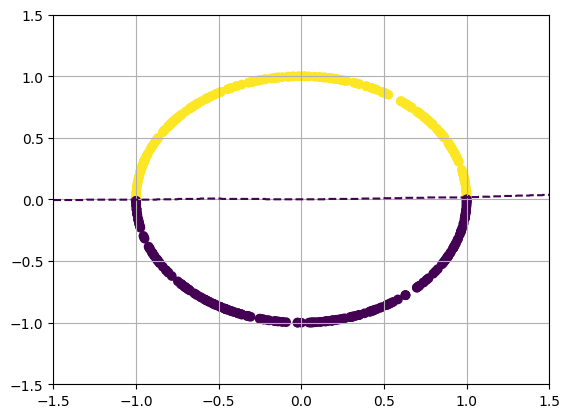

In [14]:
import peal
plot_decision_boundary(teacher, poisened_dataset_train)

In [ ]:
import peal
plot_decision_boundary(student, poisened_dataset_train)
#for i in range(10):
#    plt.scatter(*generator.sample_x().detach())

In [ ]:
# use counterfactual knowledge distillation to improve model
from peal.adaptors.counterfactual_knowledge_distillation import CounterfactualKnowledgeDistillation
cfkd = CounterfactualKnowledgeDistillation(
    student=student,
    datasource=(
        poisened_dataset_train,
        poisened_dataset_val,
        unpoisened_dataset_test,
    ),
    output_size=2,
    generator=generator,
    teacher=teacher,
    base_dir=request(
        'cfkd_base_dir',
        'peal_runs/artificial_symbolic_' + confounder_probability +
        '_classifier/cfkd_' + teacher_type
    ),
    gigabyte_vram=gigabyte_vram,
    overwrite=False,
)
cfkd.adaptor_config['explainer']['learning_rate'] = 1.0
cfkd.adaptor_config['explainer']['gradient_steps'] = 51
cfkd.run()

In [ ]:
# NOTES:
# 1. When student is ran without generating data, confounder probability is not defined and, therefore, the logic of loading preexisting model fails (need to load data before, should be allowed to skip)
# 2. unclear about the folder structure for cfdk
# 3. 

In [ ]:
plot_decision_boundary(student, unpoisened_dataset_train)

In [ ]:
run = '1'
student_path = request(
        'student_path',
        'peal_runs/artificial_symbolic_' + confounder_probability + '_classifier/'+ 'cfkd_oracle/' + run + '/finetuned_model/model.cpl'
)
student1 = torch.load(student_path).to(device)
plot_decision_boundary(student1, unpoisened_dataset_train)

In [ ]:
run = '2'
student_path = request(
        'student_path',
        'peal_runs/artificial_symbolic_' + confounder_probability + '_classifier/'+ 'cfkd_oracle/' + run + '/finetuned_model/model.cpl'
)
student2 = torch.load(student_path).to(device)
plot_decision_boundary(student2, unpoisened_dataset_train)

In [ ]:
run = '3'
student_path = request(
        'student_path',
        'peal_runs/artificial_symbolic_' + confounder_probability + '_classifier/'+ 'cfkd_oracle/' + run + '/finetuned_model/model.cpl'
)
student3 = torch.load(student_path).to(device)
plot_decision_boundary(student3, unpoisened_dataset_train)